In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "big"
enable_aug = False
enable_aug3 = False
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 1024
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-big-enable_aug-False-enable_aug3-False-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-1024-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

199999


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

199999
199999
2021
2021


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


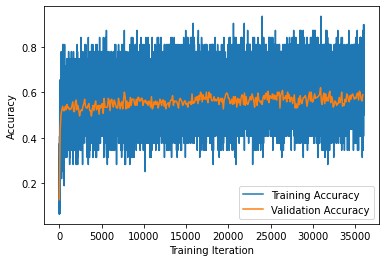

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.182 Validation Loss: 2.178 Accuracy: 0.031 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.180 Validation Loss: 2.178 Accuracy: 0.078 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.178 Validation Loss: 2.178 Accuracy: 0.102 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.176 Validation Loss: 2.178 Accuracy: 0.117 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.174 Validation Loss: 2.178 Accuracy: 0.128 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.172 Validation Loss: 2.178 Accuracy: 0.142 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.170 Validation Loss: 2.178 Accuracy: 0.153 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.168 Validation Loss: 2.178 Accuracy: 0.163 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.167 Validation Loss: 2.178 Accuracy: 0.167 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.165 Validation Loss: 2.178 Accuracy: 0.177 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.163 Validation Loss: 2.178 Accuracy: 0.203 Validation Accuracy: 0.096:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.163 Validation Loss: 2.178 Accuracy: 0.203 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 11 Loss: 2.162 Validation Loss: 2.178 Accuracy: 0.220 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 12 Loss: 2.161 Validation Loss: 2.178 Accuracy: 0.237 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 13 Loss: 2.159 Validation Loss: 2.178 Accuracy: 0.252 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 14 Loss: 2.158 Validation Loss: 2.178 Accuracy: 0.263 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 15 Loss: 2.155 Validation Loss: 2.178 Accuracy: 0.280 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 16 Loss: 2.154 Validation Loss: 2.178 Accuracy: 0.298 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 17 Loss: 2.152 Validation Loss: 2.178 Accuracy: 0.319 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 18 Loss: 2.151 Validation Loss: 2.178 Accuracy: 0.341 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 19 Loss: 2.149 Validation Loss: 2.178 Accuracy: 0.351 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 20 Loss: 2.145 Validation Loss: 2.178 Accuracy: 0.370 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 21 Loss: 2.141 Validation Loss: 2.178 Accuracy: 0.389 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 22 Loss: 2.139 Validation Loss: 2.178 Accuracy: 0.400 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 23 Loss: 2.134 Validation Loss: 2.178 Accuracy: 0.419 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 24 Loss: 2.130 Validation Loss: 2.178 Accuracy: 0.434 Validation Accuracy: 0.096:   1%|          | 11/1563 [00:00<00:14, 103.69it/s]

Epoch: 0 Iteration: 24 Loss: 2.130 Validation Loss: 2.178 Accuracy: 0.434 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 25 Loss: 2.125 Validation Loss: 2.178 Accuracy: 0.445 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 26 Loss: 2.122 Validation Loss: 2.178 Accuracy: 0.455 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 27 Loss: 2.119 Validation Loss: 2.178 Accuracy: 0.459 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 28 Loss: 2.115 Validation Loss: 2.178 Accuracy: 0.467 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 29 Loss: 2.110 Validation Loss: 2.178 Accuracy: 0.483 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 30 Loss: 2.106 Validation Loss: 2.178 Accuracy: 0.484 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 31 Loss: 2.102 Validation Loss: 2.178 Accuracy: 0.484 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 32 Loss: 2.097 Validation Loss: 2.178 Accuracy: 0.492 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 33 Loss: 2.093 Validation Loss: 2.178 Accuracy: 0.488 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 34 Loss: 2.090 Validation Loss: 2.178 Accuracy: 0.497 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 35 Loss: 2.086 Validation Loss: 2.178 Accuracy: 0.495 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 36 Loss: 2.081 Validation Loss: 2.178 Accuracy: 0.503 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 37 Loss: 2.076 Validation Loss: 2.178 Accuracy: 0.505 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 38 Loss: 2.073 Validation Loss: 2.178 Accuracy: 0.505 Validation Accuracy: 0.096:   2%|▏         | 25/1563 [00:00<00:12, 120.51it/s]

Epoch: 0 Iteration: 38 Loss: 2.073 Validation Loss: 2.178 Accuracy: 0.505 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 39 Loss: 2.069 Validation Loss: 2.178 Accuracy: 0.502 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 40 Loss: 2.066 Validation Loss: 2.178 Accuracy: 0.500 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 41 Loss: 2.063 Validation Loss: 2.178 Accuracy: 0.503 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 42 Loss: 2.058 Validation Loss: 2.178 Accuracy: 0.507 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 43 Loss: 2.056 Validation Loss: 2.178 Accuracy: 0.512 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 44 Loss: 2.051 Validation Loss: 2.178 Accuracy: 0.519 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 45 Loss: 2.047 Validation Loss: 2.178 Accuracy: 0.524 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 46 Loss: 2.043 Validation Loss: 2.178 Accuracy: 0.522 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 47 Loss: 2.036 Validation Loss: 2.178 Accuracy: 0.532 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 48 Loss: 2.031 Validation Loss: 2.178 Accuracy: 0.543 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 49 Loss: 2.027 Validation Loss: 2.178 Accuracy: 0.552 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 50 Loss: 2.023 Validation Loss: 2.178 Accuracy: 0.552 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 51 Loss: 2.016 Validation Loss: 2.178 Accuracy: 0.556 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 52 Loss: 2.015 Validation Loss: 2.178 Accuracy: 0.561 Validation Accuracy: 0.096:   2%|▏         | 39/1563 [00:00<00:12, 126.45it/s]

Epoch: 0 Iteration: 52 Loss: 2.015 Validation Loss: 2.178 Accuracy: 0.561 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 53 Loss: 2.009 Validation Loss: 2.178 Accuracy: 0.569 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 54 Loss: 2.001 Validation Loss: 2.178 Accuracy: 0.566 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 55 Loss: 1.997 Validation Loss: 2.178 Accuracy: 0.564 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 56 Loss: 1.995 Validation Loss: 2.178 Accuracy: 0.572 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 57 Loss: 1.991 Validation Loss: 2.178 Accuracy: 0.557 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 58 Loss: 1.985 Validation Loss: 2.178 Accuracy: 0.548 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 59 Loss: 1.979 Validation Loss: 2.178 Accuracy: 0.542 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 60 Loss: 1.971 Validation Loss: 2.178 Accuracy: 0.552 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 61 Loss: 1.965 Validation Loss: 2.178 Accuracy: 0.548 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 62 Loss: 1.959 Validation Loss: 2.178 Accuracy: 0.545 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 63 Loss: 1.953 Validation Loss: 2.178 Accuracy: 0.543 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 64 Loss: 1.948 Validation Loss: 2.178 Accuracy: 0.536 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 65 Loss: 1.941 Validation Loss: 2.178 Accuracy: 0.548 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 66 Loss: 1.935 Validation Loss: 2.178 Accuracy: 0.551 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 67 Loss: 1.930 Validation Loss: 2.178 Accuracy: 0.558 Validation Accuracy: 0.096:   3%|▎         | 53/1563 [00:00<00:11, 131.62it/s]

Epoch: 0 Iteration: 67 Loss: 1.930 Validation Loss: 2.178 Accuracy: 0.558 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 68 Loss: 1.925 Validation Loss: 2.178 Accuracy: 0.563 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 69 Loss: 1.922 Validation Loss: 2.178 Accuracy: 0.568 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 70 Loss: 1.914 Validation Loss: 2.178 Accuracy: 0.564 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 71 Loss: 1.911 Validation Loss: 2.178 Accuracy: 0.570 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 72 Loss: 1.904 Validation Loss: 2.178 Accuracy: 0.565 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 73 Loss: 1.901 Validation Loss: 2.178 Accuracy: 0.569 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 74 Loss: 1.896 Validation Loss: 2.178 Accuracy: 0.579 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 75 Loss: 1.892 Validation Loss: 2.178 Accuracy: 0.570 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 76 Loss: 1.885 Validation Loss: 2.178 Accuracy: 0.563 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 77 Loss: 1.878 Validation Loss: 2.178 Accuracy: 0.568 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 78 Loss: 1.869 Validation Loss: 2.178 Accuracy: 0.567 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 79 Loss: 1.863 Validation Loss: 2.178 Accuracy: 0.563 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 80 Loss: 1.859 Validation Loss: 2.178 Accuracy: 0.566 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 81 Loss: 1.852 Validation Loss: 2.178 Accuracy: 0.566 Validation Accuracy: 0.096:   4%|▍         | 68/1563 [00:00<00:11, 135.00it/s]

Epoch: 0 Iteration: 81 Loss: 1.852 Validation Loss: 2.178 Accuracy: 0.566 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 82 Loss: 1.845 Validation Loss: 2.178 Accuracy: 0.572 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 83 Loss: 1.838 Validation Loss: 2.178 Accuracy: 0.566 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 84 Loss: 1.834 Validation Loss: 2.178 Accuracy: 0.555 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 85 Loss: 1.832 Validation Loss: 2.178 Accuracy: 0.557 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 86 Loss: 1.828 Validation Loss: 2.178 Accuracy: 0.553 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 87 Loss: 1.823 Validation Loss: 2.178 Accuracy: 0.553 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 88 Loss: 1.817 Validation Loss: 2.178 Accuracy: 0.545 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 89 Loss: 1.813 Validation Loss: 2.178 Accuracy: 0.548 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 90 Loss: 1.810 Validation Loss: 2.178 Accuracy: 0.541 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 91 Loss: 1.801 Validation Loss: 2.178 Accuracy: 0.537 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 92 Loss: 1.792 Validation Loss: 2.178 Accuracy: 0.542 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 93 Loss: 1.784 Validation Loss: 2.178 Accuracy: 0.554 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 94 Loss: 1.779 Validation Loss: 2.178 Accuracy: 0.565 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 95 Loss: 1.769 Validation Loss: 2.178 Accuracy: 0.565 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 96 Loss: 1.762 Validation Loss: 2.178 Accuracy: 0.566 Validation Accuracy: 0.096:   5%|▌         | 82/1563 [00:00<00:10, 135.67it/s]

Epoch: 0 Iteration: 96 Loss: 1.762 Validation Loss: 2.178 Accuracy: 0.566 Validation Accuracy: 0.096:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 97 Loss: 1.754 Validation Loss: 2.178 Accuracy: 0.573 Validation Accuracy: 0.096:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 98 Loss: 1.748 Validation Loss: 2.178 Accuracy: 0.580 Validation Accuracy: 0.096:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 99 Loss: 1.741 Validation Loss: 2.178 Accuracy: 0.576 Validation Accuracy: 0.096:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 100 Loss: 1.729 Validation Loss: 1.705 Accuracy: 0.589 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 101 Loss: 1.722 Validation Loss: 1.705 Accuracy: 0.591 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 102 Loss: 1.713 Validation Loss: 1.705 Accuracy: 0.594 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 103 Loss: 1.706 Validation Loss: 1.705 Accuracy: 0.580 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 104 Loss: 1.694 Validation Loss: 1.705 Accuracy: 0.584 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 105 Loss: 1.685 Validation Loss: 1.705 Accuracy: 0.585 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 106 Loss: 1.675 Validation Loss: 1.705 Accuracy: 0.584 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 107 Loss: 1.670 Validation Loss: 1.705 Accuracy: 0.577 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 108 Loss: 1.661 Validation Loss: 1.705 Accuracy: 0.581 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 109 Loss: 1.648 Validation Loss: 1.705 Accuracy: 0.588 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 110 Loss: 1.636 Validation Loss: 1.705 Accuracy: 0.586 Validation Accuracy: 0.299:   6%|▌         | 97/1563 [00:00<00:10, 137.21it/s]

Epoch: 0 Iteration: 110 Loss: 1.636 Validation Loss: 1.705 Accuracy: 0.586 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 111 Loss: 1.624 Validation Loss: 1.705 Accuracy: 0.591 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 112 Loss: 1.614 Validation Loss: 1.705 Accuracy: 0.592 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 113 Loss: 1.603 Validation Loss: 1.705 Accuracy: 0.600 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 114 Loss: 1.594 Validation Loss: 1.705 Accuracy: 0.594 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 115 Loss: 1.586 Validation Loss: 1.705 Accuracy: 0.598 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 116 Loss: 1.574 Validation Loss: 1.705 Accuracy: 0.598 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 117 Loss: 1.565 Validation Loss: 1.705 Accuracy: 0.598 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 118 Loss: 1.556 Validation Loss: 1.705 Accuracy: 0.608 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 119 Loss: 1.545 Validation Loss: 1.705 Accuracy: 0.614 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 120 Loss: 1.539 Validation Loss: 1.705 Accuracy: 0.610 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 121 Loss: 1.526 Validation Loss: 1.705 Accuracy: 0.607 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 122 Loss: 1.517 Validation Loss: 1.705 Accuracy: 0.609 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 123 Loss: 1.505 Validation Loss: 1.705 Accuracy: 0.606 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 124 Loss: 1.495 Validation Loss: 1.705 Accuracy: 0.611 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 125 Loss: 1.480 Validation Loss: 1.705 Accuracy: 0.613 Validation Accuracy: 0.299:   7%|▋         | 111/1563 [00:00<00:10, 132.59it/s]

Epoch: 0 Iteration: 125 Loss: 1.480 Validation Loss: 1.705 Accuracy: 0.613 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:00<00:10, 135.35it/s]

Epoch: 0 Iteration: 126 Loss: 1.467 Validation Loss: 1.705 Accuracy: 0.615 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:00<00:10, 135.35it/s]

Epoch: 0 Iteration: 127 Loss: 1.451 Validation Loss: 1.705 Accuracy: 0.617 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:00<00:10, 135.35it/s]

Epoch: 0 Iteration: 128 Loss: 1.445 Validation Loss: 1.705 Accuracy: 0.601 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:00<00:10, 135.35it/s]

Epoch: 0 Iteration: 129 Loss: 1.433 Validation Loss: 1.705 Accuracy: 0.604 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:00<00:10, 135.35it/s]

Epoch: 0 Iteration: 130 Loss: 1.424 Validation Loss: 1.705 Accuracy: 0.606 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:00<00:10, 135.35it/s]

Epoch: 0 Iteration: 131 Loss: 1.416 Validation Loss: 1.705 Accuracy: 0.612 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:00<00:10, 135.35it/s]

Epoch: 0 Iteration: 132 Loss: 1.406 Validation Loss: 1.705 Accuracy: 0.613 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 133 Loss: 1.394 Validation Loss: 1.705 Accuracy: 0.619 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 134 Loss: 1.384 Validation Loss: 1.705 Accuracy: 0.618 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 135 Loss: 1.374 Validation Loss: 1.705 Accuracy: 0.620 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 136 Loss: 1.361 Validation Loss: 1.705 Accuracy: 0.630 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 137 Loss: 1.350 Validation Loss: 1.705 Accuracy: 0.639 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 138 Loss: 1.338 Validation Loss: 1.705 Accuracy: 0.653 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 139 Loss: 1.328 Validation Loss: 1.705 Accuracy: 0.656 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 140 Loss: 1.317 Validation Loss: 1.705 Accuracy: 0.664 Validation Accuracy: 0.299:   8%|▊         | 126/1563 [00:01<00:10, 135.35it/s]

Epoch: 0 Iteration: 140 Loss: 1.317 Validation Loss: 1.705 Accuracy: 0.664 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 141 Loss: 1.311 Validation Loss: 1.705 Accuracy: 0.650 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 142 Loss: 1.302 Validation Loss: 1.705 Accuracy: 0.644 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 143 Loss: 1.293 Validation Loss: 1.705 Accuracy: 0.648 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 144 Loss: 1.287 Validation Loss: 1.705 Accuracy: 0.648 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 145 Loss: 1.274 Validation Loss: 1.705 Accuracy: 0.646 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 146 Loss: 1.262 Validation Loss: 1.705 Accuracy: 0.645 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 147 Loss: 1.249 Validation Loss: 1.705 Accuracy: 0.647 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 148 Loss: 1.237 Validation Loss: 1.705 Accuracy: 0.642 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 149 Loss: 1.223 Validation Loss: 1.705 Accuracy: 0.645 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 150 Loss: 1.211 Validation Loss: 1.705 Accuracy: 0.651 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 151 Loss: 1.203 Validation Loss: 1.705 Accuracy: 0.668 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 152 Loss: 1.193 Validation Loss: 1.705 Accuracy: 0.675 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 153 Loss: 1.181 Validation Loss: 1.705 Accuracy: 0.680 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 154 Loss: 1.168 Validation Loss: 1.705 Accuracy: 0.684 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 155 Loss: 1.153 Validation Loss: 1.705 Accuracy: 0.690 Validation Accuracy: 0.299:   9%|▉         | 141/1563 [00:01<00:10, 137.21it/s]

Epoch: 0 Iteration: 155 Loss: 1.153 Validation Loss: 1.705 Accuracy: 0.690 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 156 Loss: 1.147 Validation Loss: 1.705 Accuracy: 0.695 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 157 Loss: 1.141 Validation Loss: 1.705 Accuracy: 0.693 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 158 Loss: 1.134 Validation Loss: 1.705 Accuracy: 0.697 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 159 Loss: 1.123 Validation Loss: 1.705 Accuracy: 0.693 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 160 Loss: 1.119 Validation Loss: 1.705 Accuracy: 0.684 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 161 Loss: 1.103 Validation Loss: 1.705 Accuracy: 0.685 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 162 Loss: 1.093 Validation Loss: 1.705 Accuracy: 0.681 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 163 Loss: 1.085 Validation Loss: 1.705 Accuracy: 0.684 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 164 Loss: 1.071 Validation Loss: 1.705 Accuracy: 0.693 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 165 Loss: 1.064 Validation Loss: 1.705 Accuracy: 0.692 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 166 Loss: 1.060 Validation Loss: 1.705 Accuracy: 0.689 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 167 Loss: 1.055 Validation Loss: 1.705 Accuracy: 0.699 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 168 Loss: 1.043 Validation Loss: 1.705 Accuracy: 0.696 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 169 Loss: 1.039 Validation Loss: 1.705 Accuracy: 0.693 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 170 Loss: 1.035 Validation Loss: 1.705 Accuracy: 0.698 Validation Accuracy: 0.299:  10%|▉         | 156/1563 [00:01<00:10, 138.49it/s]

Epoch: 0 Iteration: 170 Loss: 1.035 Validation Loss: 1.705 Accuracy: 0.698 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 171 Loss: 1.024 Validation Loss: 1.705 Accuracy: 0.706 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 172 Loss: 1.015 Validation Loss: 1.705 Accuracy: 0.717 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 173 Loss: 1.009 Validation Loss: 1.705 Accuracy: 0.717 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 174 Loss: 1.005 Validation Loss: 1.705 Accuracy: 0.713 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 175 Loss: 1.003 Validation Loss: 1.705 Accuracy: 0.708 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 176 Loss: 0.998 Validation Loss: 1.705 Accuracy: 0.703 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 177 Loss: 0.989 Validation Loss: 1.705 Accuracy: 0.697 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 178 Loss: 0.977 Validation Loss: 1.705 Accuracy: 0.709 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 179 Loss: 0.971 Validation Loss: 1.705 Accuracy: 0.715 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 180 Loss: 0.959 Validation Loss: 1.705 Accuracy: 0.721 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 181 Loss: 0.953 Validation Loss: 1.705 Accuracy: 0.713 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 182 Loss: 0.944 Validation Loss: 1.705 Accuracy: 0.711 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 183 Loss: 0.936 Validation Loss: 1.705 Accuracy: 0.703 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 184 Loss: 0.930 Validation Loss: 1.705 Accuracy: 0.704 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 185 Loss: 0.926 Validation Loss: 1.705 Accuracy: 0.709 Validation Accuracy: 0.299:  11%|█         | 171/1563 [00:01<00:09, 139.35it/s]

Epoch: 0 Iteration: 185 Loss: 0.926 Validation Loss: 1.705 Accuracy: 0.709 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 186 Loss: 0.919 Validation Loss: 1.705 Accuracy: 0.713 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 187 Loss: 0.907 Validation Loss: 1.705 Accuracy: 0.720 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 188 Loss: 0.902 Validation Loss: 1.705 Accuracy: 0.705 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 189 Loss: 0.895 Validation Loss: 1.705 Accuracy: 0.698 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 190 Loss: 0.880 Validation Loss: 1.705 Accuracy: 0.702 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 191 Loss: 0.875 Validation Loss: 1.705 Accuracy: 0.702 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 192 Loss: 0.866 Validation Loss: 1.705 Accuracy: 0.703 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 193 Loss: 0.858 Validation Loss: 1.705 Accuracy: 0.714 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 194 Loss: 0.848 Validation Loss: 1.705 Accuracy: 0.717 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 195 Loss: 0.842 Validation Loss: 1.705 Accuracy: 0.713 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 196 Loss: 0.829 Validation Loss: 1.705 Accuracy: 0.717 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 197 Loss: 0.818 Validation Loss: 1.705 Accuracy: 0.712 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 198 Loss: 0.822 Validation Loss: 1.705 Accuracy: 0.721 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 199 Loss: 0.816 Validation Loss: 1.705 Accuracy: 0.730 Validation Accuracy: 0.299:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 200 Loss: 0.808 Validation Loss: 0.852 Accuracy: 0.731 Validation Accuracy: 0.429:  12%|█▏        | 186/1563 [00:01<00:09, 139.94it/s]

Epoch: 0 Iteration: 200 Loss: 0.808 Validation Loss: 0.852 Accuracy: 0.731 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 201 Loss: 0.805 Validation Loss: 0.852 Accuracy: 0.732 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 202 Loss: 0.805 Validation Loss: 0.852 Accuracy: 0.728 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 203 Loss: 0.795 Validation Loss: 0.852 Accuracy: 0.726 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 204 Loss: 0.789 Validation Loss: 0.852 Accuracy: 0.730 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 205 Loss: 0.781 Validation Loss: 0.852 Accuracy: 0.739 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 206 Loss: 0.773 Validation Loss: 0.852 Accuracy: 0.738 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 207 Loss: 0.772 Validation Loss: 0.852 Accuracy: 0.740 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 208 Loss: 0.771 Validation Loss: 0.852 Accuracy: 0.737 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 209 Loss: 0.770 Validation Loss: 0.852 Accuracy: 0.734 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 210 Loss: 0.779 Validation Loss: 0.852 Accuracy: 0.716 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 211 Loss: 0.782 Validation Loss: 0.852 Accuracy: 0.712 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 212 Loss: 0.780 Validation Loss: 0.852 Accuracy: 0.721 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 213 Loss: 0.779 Validation Loss: 0.852 Accuracy: 0.718 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 214 Loss: 0.777 Validation Loss: 0.852 Accuracy: 0.713 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 215 Loss: 0.774 Validation Loss: 0.852 Accuracy: 0.711 Validation Accuracy: 0.429:  13%|█▎        | 201/1563 [00:01<00:10, 134.62it/s]

Epoch: 0 Iteration: 215 Loss: 0.774 Validation Loss: 0.852 Accuracy: 0.711 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 216 Loss: 0.777 Validation Loss: 0.852 Accuracy: 0.708 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 217 Loss: 0.776 Validation Loss: 0.852 Accuracy: 0.713 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 218 Loss: 0.769 Validation Loss: 0.852 Accuracy: 0.717 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 219 Loss: 0.762 Validation Loss: 0.852 Accuracy: 0.720 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 220 Loss: 0.764 Validation Loss: 0.852 Accuracy: 0.728 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 221 Loss: 0.763 Validation Loss: 0.852 Accuracy: 0.737 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 222 Loss: 0.757 Validation Loss: 0.852 Accuracy: 0.728 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 223 Loss: 0.761 Validation Loss: 0.852 Accuracy: 0.724 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 224 Loss: 0.764 Validation Loss: 0.852 Accuracy: 0.723 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 225 Loss: 0.773 Validation Loss: 0.852 Accuracy: 0.719 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 226 Loss: 0.775 Validation Loss: 0.852 Accuracy: 0.720 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 227 Loss: 0.770 Validation Loss: 0.852 Accuracy: 0.719 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 228 Loss: 0.764 Validation Loss: 0.852 Accuracy: 0.720 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 229 Loss: 0.756 Validation Loss: 0.852 Accuracy: 0.717 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 230 Loss: 0.747 Validation Loss: 0.852 Accuracy: 0.718 Validation Accuracy: 0.429:  14%|█▍        | 216/1563 [00:01<00:09, 136.93it/s]

Epoch: 0 Iteration: 230 Loss: 0.747 Validation Loss: 0.852 Accuracy: 0.718 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 231 Loss: 0.738 Validation Loss: 0.852 Accuracy: 0.717 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 232 Loss: 0.738 Validation Loss: 0.852 Accuracy: 0.718 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 233 Loss: 0.737 Validation Loss: 0.852 Accuracy: 0.720 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 234 Loss: 0.736 Validation Loss: 0.852 Accuracy: 0.719 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 235 Loss: 0.730 Validation Loss: 0.852 Accuracy: 0.727 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 236 Loss: 0.727 Validation Loss: 0.852 Accuracy: 0.729 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 237 Loss: 0.732 Validation Loss: 0.852 Accuracy: 0.722 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 238 Loss: 0.729 Validation Loss: 0.852 Accuracy: 0.721 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 239 Loss: 0.728 Validation Loss: 0.852 Accuracy: 0.720 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 240 Loss: 0.725 Validation Loss: 0.852 Accuracy: 0.721 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 241 Loss: 0.724 Validation Loss: 0.852 Accuracy: 0.720 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 242 Loss: 0.721 Validation Loss: 0.852 Accuracy: 0.723 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 243 Loss: 0.721 Validation Loss: 0.852 Accuracy: 0.722 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 244 Loss: 0.725 Validation Loss: 0.852 Accuracy: 0.716 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 245 Loss: 0.711 Validation Loss: 0.852 Accuracy: 0.716 Validation Accuracy: 0.429:  15%|█▍        | 231/1563 [00:01<00:09, 138.24it/s]

Epoch: 0 Iteration: 245 Loss: 0.711 Validation Loss: 0.852 Accuracy: 0.716 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 246 Loss: 0.707 Validation Loss: 0.852 Accuracy: 0.722 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 247 Loss: 0.705 Validation Loss: 0.852 Accuracy: 0.730 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 248 Loss: 0.703 Validation Loss: 0.852 Accuracy: 0.730 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 249 Loss: 0.702 Validation Loss: 0.852 Accuracy: 0.731 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 250 Loss: 0.700 Validation Loss: 0.852 Accuracy: 0.737 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 251 Loss: 0.697 Validation Loss: 0.852 Accuracy: 0.738 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 252 Loss: 0.693 Validation Loss: 0.852 Accuracy: 0.737 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 253 Loss: 0.698 Validation Loss: 0.852 Accuracy: 0.734 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 254 Loss: 0.694 Validation Loss: 0.852 Accuracy: 0.743 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 255 Loss: 0.696 Validation Loss: 0.852 Accuracy: 0.740 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 256 Loss: 0.693 Validation Loss: 0.852 Accuracy: 0.736 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 257 Loss: 0.691 Validation Loss: 0.852 Accuracy: 0.728 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 258 Loss: 0.689 Validation Loss: 0.852 Accuracy: 0.729 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 259 Loss: 0.690 Validation Loss: 0.852 Accuracy: 0.734 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 260 Loss: 0.689 Validation Loss: 0.852 Accuracy: 0.734 Validation Accuracy: 0.429:  16%|█▌        | 246/1563 [00:01<00:09, 139.18it/s]

Epoch: 0 Iteration: 260 Loss: 0.689 Validation Loss: 0.852 Accuracy: 0.734 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 261 Loss: 0.688 Validation Loss: 0.852 Accuracy: 0.733 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 262 Loss: 0.695 Validation Loss: 0.852 Accuracy: 0.725 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 263 Loss: 0.698 Validation Loss: 0.852 Accuracy: 0.720 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 264 Loss: 0.683 Validation Loss: 0.852 Accuracy: 0.723 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 265 Loss: 0.685 Validation Loss: 0.852 Accuracy: 0.723 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 266 Loss: 0.691 Validation Loss: 0.852 Accuracy: 0.718 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 267 Loss: 0.698 Validation Loss: 0.852 Accuracy: 0.717 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 268 Loss: 0.698 Validation Loss: 0.852 Accuracy: 0.719 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 269 Loss: 0.704 Validation Loss: 0.852 Accuracy: 0.708 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 270 Loss: 0.698 Validation Loss: 0.852 Accuracy: 0.710 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 271 Loss: 0.703 Validation Loss: 0.852 Accuracy: 0.705 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:01<00:09, 139.78it/s]

Epoch: 0 Iteration: 272 Loss: 0.709 Validation Loss: 0.852 Accuracy: 0.709 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:02<00:09, 139.78it/s]

Epoch: 0 Iteration: 273 Loss: 0.703 Validation Loss: 0.852 Accuracy: 0.721 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:02<00:09, 139.78it/s]

Epoch: 0 Iteration: 274 Loss: 0.707 Validation Loss: 0.852 Accuracy: 0.714 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:02<00:09, 139.78it/s]

Epoch: 0 Iteration: 275 Loss: 0.700 Validation Loss: 0.852 Accuracy: 0.723 Validation Accuracy: 0.429:  17%|█▋        | 261/1563 [00:02<00:09, 139.78it/s]

Epoch: 0 Iteration: 275 Loss: 0.700 Validation Loss: 0.852 Accuracy: 0.723 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 276 Loss: 0.699 Validation Loss: 0.852 Accuracy: 0.731 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 277 Loss: 0.689 Validation Loss: 0.852 Accuracy: 0.741 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 278 Loss: 0.686 Validation Loss: 0.852 Accuracy: 0.743 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 279 Loss: 0.684 Validation Loss: 0.852 Accuracy: 0.748 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 280 Loss: 0.679 Validation Loss: 0.852 Accuracy: 0.748 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 281 Loss: 0.678 Validation Loss: 0.852 Accuracy: 0.757 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 282 Loss: 0.668 Validation Loss: 0.852 Accuracy: 0.762 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 283 Loss: 0.658 Validation Loss: 0.852 Accuracy: 0.759 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 284 Loss: 0.660 Validation Loss: 0.852 Accuracy: 0.764 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 285 Loss: 0.659 Validation Loss: 0.852 Accuracy: 0.756 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 286 Loss: 0.658 Validation Loss: 0.852 Accuracy: 0.748 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 287 Loss: 0.651 Validation Loss: 0.852 Accuracy: 0.741 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 288 Loss: 0.649 Validation Loss: 0.852 Accuracy: 0.741 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 289 Loss: 0.639 Validation Loss: 0.852 Accuracy: 0.748 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 290 Loss: 0.643 Validation Loss: 0.852 Accuracy: 0.745 Validation Accuracy: 0.429:  18%|█▊        | 276/1563 [00:02<00:09, 140.08it/s]

Epoch: 0 Iteration: 290 Loss: 0.643 Validation Loss: 0.852 Accuracy: 0.745 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 291 Loss: 0.644 Validation Loss: 0.852 Accuracy: 0.734 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 292 Loss: 0.644 Validation Loss: 0.852 Accuracy: 0.729 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 293 Loss: 0.643 Validation Loss: 0.852 Accuracy: 0.730 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 294 Loss: 0.640 Validation Loss: 0.852 Accuracy: 0.727 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 295 Loss: 0.642 Validation Loss: 0.852 Accuracy: 0.727 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 296 Loss: 0.644 Validation Loss: 0.852 Accuracy: 0.728 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 297 Loss: 0.649 Validation Loss: 0.852 Accuracy: 0.729 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 298 Loss: 0.646 Validation Loss: 0.852 Accuracy: 0.733 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 299 Loss: 0.648 Validation Loss: 0.852 Accuracy: 0.727 Validation Accuracy: 0.429:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 300 Loss: 0.651 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 301 Loss: 0.647 Validation Loss: 0.743 Accuracy: 0.737 Validation Accuracy: 0.497:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 302 Loss: 0.651 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.497:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 303 Loss: 0.654 Validation Loss: 0.743 Accuracy: 0.740 Validation Accuracy: 0.497:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 304 Loss: 0.658 Validation Loss: 0.743 Accuracy: 0.739 Validation Accuracy: 0.497:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 305 Loss: 0.657 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  19%|█▊        | 291/1563 [00:02<00:09, 140.23it/s]

Epoch: 0 Iteration: 305 Loss: 0.657 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 306 Loss: 0.647 Validation Loss: 0.743 Accuracy: 0.751 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 307 Loss: 0.648 Validation Loss: 0.743 Accuracy: 0.752 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 308 Loss: 0.647 Validation Loss: 0.743 Accuracy: 0.748 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 309 Loss: 0.653 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 310 Loss: 0.650 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 311 Loss: 0.644 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 312 Loss: 0.636 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 313 Loss: 0.634 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 314 Loss: 0.633 Validation Loss: 0.743 Accuracy: 0.749 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 315 Loss: 0.633 Validation Loss: 0.743 Accuracy: 0.752 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 316 Loss: 0.630 Validation Loss: 0.743 Accuracy: 0.748 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 317 Loss: 0.631 Validation Loss: 0.743 Accuracy: 0.744 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 318 Loss: 0.630 Validation Loss: 0.743 Accuracy: 0.747 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 319 Loss: 0.627 Validation Loss: 0.743 Accuracy: 0.752 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 320 Loss: 0.634 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  20%|█▉        | 306/1563 [00:02<00:09, 134.82it/s]

Epoch: 0 Iteration: 320 Loss: 0.634 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 321 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 322 Loss: 0.638 Validation Loss: 0.743 Accuracy: 0.740 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 323 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 324 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 325 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 326 Loss: 0.645 Validation Loss: 0.743 Accuracy: 0.723 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 327 Loss: 0.644 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 328 Loss: 0.644 Validation Loss: 0.743 Accuracy: 0.721 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 329 Loss: 0.639 Validation Loss: 0.743 Accuracy: 0.719 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 330 Loss: 0.641 Validation Loss: 0.743 Accuracy: 0.726 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 331 Loss: 0.638 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 332 Loss: 0.645 Validation Loss: 0.743 Accuracy: 0.719 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 333 Loss: 0.650 Validation Loss: 0.743 Accuracy: 0.720 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 334 Loss: 0.648 Validation Loss: 0.743 Accuracy: 0.725 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 335 Loss: 0.650 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.497:  21%|██        | 321/1563 [00:02<00:09, 136.45it/s]

Epoch: 0 Iteration: 335 Loss: 0.650 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 336 Loss: 0.654 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 337 Loss: 0.655 Validation Loss: 0.743 Accuracy: 0.721 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 338 Loss: 0.655 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 339 Loss: 0.657 Validation Loss: 0.743 Accuracy: 0.726 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 340 Loss: 0.655 Validation Loss: 0.743 Accuracy: 0.720 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 341 Loss: 0.654 Validation Loss: 0.743 Accuracy: 0.717 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 342 Loss: 0.651 Validation Loss: 0.743 Accuracy: 0.726 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 343 Loss: 0.648 Validation Loss: 0.743 Accuracy: 0.725 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 344 Loss: 0.641 Validation Loss: 0.743 Accuracy: 0.729 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 345 Loss: 0.643 Validation Loss: 0.743 Accuracy: 0.724 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 346 Loss: 0.639 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 347 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 348 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 349 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.735 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 350 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.747 Validation Accuracy: 0.497:  21%|██▏       | 336/1563 [00:02<00:08, 137.65it/s]

Epoch: 0 Iteration: 350 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.747 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 351 Loss: 0.645 Validation Loss: 0.743 Accuracy: 0.746 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 352 Loss: 0.643 Validation Loss: 0.743 Accuracy: 0.748 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 353 Loss: 0.644 Validation Loss: 0.743 Accuracy: 0.747 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 354 Loss: 0.644 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 355 Loss: 0.650 Validation Loss: 0.743 Accuracy: 0.735 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 356 Loss: 0.652 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 357 Loss: 0.649 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 358 Loss: 0.649 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 359 Loss: 0.649 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 360 Loss: 0.635 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 361 Loss: 0.637 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 362 Loss: 0.641 Validation Loss: 0.743 Accuracy: 0.728 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 363 Loss: 0.638 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 364 Loss: 0.639 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 365 Loss: 0.636 Validation Loss: 0.743 Accuracy: 0.746 Validation Accuracy: 0.497:  22%|██▏       | 351/1563 [00:02<00:08, 138.43it/s]

Epoch: 0 Iteration: 365 Loss: 0.636 Validation Loss: 0.743 Accuracy: 0.746 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 366 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.752 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 367 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.752 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 368 Loss: 0.638 Validation Loss: 0.743 Accuracy: 0.750 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 369 Loss: 0.646 Validation Loss: 0.743 Accuracy: 0.742 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 370 Loss: 0.645 Validation Loss: 0.743 Accuracy: 0.735 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 371 Loss: 0.647 Validation Loss: 0.743 Accuracy: 0.739 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 372 Loss: 0.645 Validation Loss: 0.743 Accuracy: 0.744 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 373 Loss: 0.639 Validation Loss: 0.743 Accuracy: 0.740 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 374 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 375 Loss: 0.636 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 376 Loss: 0.637 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 377 Loss: 0.641 Validation Loss: 0.743 Accuracy: 0.724 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 378 Loss: 0.652 Validation Loss: 0.743 Accuracy: 0.712 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 379 Loss: 0.654 Validation Loss: 0.743 Accuracy: 0.714 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 380 Loss: 0.661 Validation Loss: 0.743 Accuracy: 0.716 Validation Accuracy: 0.497:  23%|██▎       | 366/1563 [00:02<00:08, 138.90it/s]

Epoch: 0 Iteration: 380 Loss: 0.661 Validation Loss: 0.743 Accuracy: 0.716 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 381 Loss: 0.653 Validation Loss: 0.743 Accuracy: 0.716 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 382 Loss: 0.646 Validation Loss: 0.743 Accuracy: 0.720 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 383 Loss: 0.648 Validation Loss: 0.743 Accuracy: 0.721 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 384 Loss: 0.648 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 385 Loss: 0.651 Validation Loss: 0.743 Accuracy: 0.728 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 386 Loss: 0.650 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 387 Loss: 0.650 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 388 Loss: 0.654 Validation Loss: 0.743 Accuracy: 0.740 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 389 Loss: 0.648 Validation Loss: 0.743 Accuracy: 0.742 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 390 Loss: 0.649 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 391 Loss: 0.647 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 392 Loss: 0.644 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 393 Loss: 0.646 Validation Loss: 0.743 Accuracy: 0.735 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 394 Loss: 0.643 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 395 Loss: 0.645 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.497:  24%|██▍       | 381/1563 [00:02<00:08, 139.34it/s]

Epoch: 0 Iteration: 395 Loss: 0.645 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.497:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 396 Loss: 0.642 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.497:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 397 Loss: 0.640 Validation Loss: 0.743 Accuracy: 0.725 Validation Accuracy: 0.497:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 398 Loss: 0.631 Validation Loss: 0.743 Accuracy: 0.731 Validation Accuracy: 0.497:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 399 Loss: 0.627 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.497:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 400 Loss: 0.624 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 401 Loss: 0.624 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 402 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 403 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 404 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 405 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 406 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 407 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:02<00:08, 139.73it/s]

Epoch: 0 Iteration: 408 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.746 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:03<00:08, 139.73it/s]

Epoch: 0 Iteration: 409 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.747 Validation Accuracy: 0.539:  25%|██▌       | 396/1563 [00:03<00:08, 139.73it/s]

Epoch: 0 Iteration: 409 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.747 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 410 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 411 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 412 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 413 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 414 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 415 Loss: 0.623 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 416 Loss: 0.621 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 417 Loss: 0.615 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 418 Loss: 0.615 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 419 Loss: 0.616 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 420 Loss: 0.617 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 421 Loss: 0.619 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 422 Loss: 0.616 Validation Loss: 0.709 Accuracy: 0.749 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 423 Loss: 0.620 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 424 Loss: 0.618 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.539:  26%|██▌       | 410/1563 [00:03<00:08, 134.40it/s]

Epoch: 0 Iteration: 424 Loss: 0.618 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 425 Loss: 0.622 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 426 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 427 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 428 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 429 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 430 Loss: 0.624 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 431 Loss: 0.620 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 432 Loss: 0.611 Validation Loss: 0.709 Accuracy: 0.746 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 433 Loss: 0.616 Validation Loss: 0.709 Accuracy: 0.752 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 434 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 435 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.743 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 436 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 437 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.753 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 438 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 439 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.539:  27%|██▋       | 425/1563 [00:03<00:08, 136.07it/s]

Epoch: 0 Iteration: 439 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 440 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 441 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 442 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 443 Loss: 0.620 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 444 Loss: 0.622 Validation Loss: 0.709 Accuracy: 0.755 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 445 Loss: 0.624 Validation Loss: 0.709 Accuracy: 0.753 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 446 Loss: 0.615 Validation Loss: 0.709 Accuracy: 0.751 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 447 Loss: 0.609 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 448 Loss: 0.610 Validation Loss: 0.709 Accuracy: 0.749 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 449 Loss: 0.615 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 450 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 451 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 452 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 453 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 454 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.539:  28%|██▊       | 440/1563 [00:03<00:08, 137.26it/s]

Epoch: 0 Iteration: 454 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 455 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 456 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 457 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 458 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 459 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 460 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 461 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 462 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 463 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 464 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 465 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 466 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 467 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 468 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 469 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.539:  29%|██▉       | 455/1563 [00:03<00:08, 138.13it/s]

Epoch: 0 Iteration: 469 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 470 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 471 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 472 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 473 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 474 Loss: 0.621 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 475 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 476 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 477 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 478 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 479 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 480 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 481 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 482 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 483 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 484 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.539:  30%|███       | 470/1563 [00:03<00:07, 138.76it/s]

Epoch: 0 Iteration: 484 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 485 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 486 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 487 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 488 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 489 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 490 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 491 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.752 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 492 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.750 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 493 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 494 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.743 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 495 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 496 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 497 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 498 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 499 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.539:  31%|███       | 485/1563 [00:03<00:07, 139.06it/s]

Epoch: 0 Iteration: 499 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.539:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 500 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 501 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 502 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 503 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 504 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 505 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 506 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 507 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 508 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 509 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 510 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 511 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 512 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 513 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.571:  32%|███▏      | 500/1563 [00:03<00:07, 139.47it/s]

Epoch: 0 Iteration: 513 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 514 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 515 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 516 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 517 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 518 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 519 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 520 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 521 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 522 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 523 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 524 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 525 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 526 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 527 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 528 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.571:  33%|███▎      | 514/1563 [00:03<00:07, 134.44it/s]

Epoch: 0 Iteration: 528 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 529 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 530 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 531 Loss: 0.608 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 532 Loss: 0.598 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 533 Loss: 0.597 Validation Loss: 0.696 Accuracy: 0.773 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 534 Loss: 0.595 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 535 Loss: 0.602 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 536 Loss: 0.613 Validation Loss: 0.696 Accuracy: 0.768 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 537 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 538 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 539 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 540 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 541 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 542 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 543 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.571:  34%|███▍      | 529/1563 [00:03<00:07, 136.23it/s]

Epoch: 0 Iteration: 543 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:03<00:07, 137.53it/s]

Epoch: 0 Iteration: 544 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:03<00:07, 137.53it/s]

Epoch: 0 Iteration: 545 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:03<00:07, 137.53it/s]

Epoch: 0 Iteration: 546 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 547 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 548 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 549 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 550 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 551 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 552 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 553 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 554 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 555 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 556 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 557 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 558 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.571:  35%|███▍      | 544/1563 [00:04<00:07, 137.53it/s]

Epoch: 0 Iteration: 558 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 559 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 560 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 561 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 562 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 563 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 564 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 565 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 566 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 567 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 568 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 569 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 570 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 571 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 572 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 573 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.571:  36%|███▌      | 559/1563 [00:04<00:07, 138.40it/s]

Epoch: 0 Iteration: 573 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 574 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 575 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 576 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 577 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 578 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 579 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 580 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 581 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 582 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 583 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 584 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 585 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 586 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 587 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 588 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.571:  37%|███▋      | 574/1563 [00:04<00:07, 139.07it/s]

Epoch: 0 Iteration: 588 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 589 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 590 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 591 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 592 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 593 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 594 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.772 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 595 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 596 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 597 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 598 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 599 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.571:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 600 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.592:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 601 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.592:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 602 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.592:  38%|███▊      | 589/1563 [00:04<00:06, 139.56it/s]

Epoch: 0 Iteration: 602 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 603 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 604 Loss: 0.606 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 605 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 606 Loss: 0.608 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 607 Loss: 0.607 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 608 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 609 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 610 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 611 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.764 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 612 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 613 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 614 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 615 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 616 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 617 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.592:  39%|███▊      | 603/1563 [00:04<00:07, 134.38it/s]

Epoch: 0 Iteration: 617 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 618 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 619 Loss: 0.607 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 620 Loss: 0.604 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 621 Loss: 0.608 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 622 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 623 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 624 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 625 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 626 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 627 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 628 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 629 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 630 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 631 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 632 Loss: 0.606 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.592:  40%|███▉      | 618/1563 [00:04<00:06, 136.36it/s]

Epoch: 0 Iteration: 632 Loss: 0.606 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 633 Loss: 0.600 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 634 Loss: 0.597 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 635 Loss: 0.595 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 636 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 637 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 638 Loss: 0.604 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 639 Loss: 0.607 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 640 Loss: 0.606 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 641 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 642 Loss: 0.602 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 643 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 644 Loss: 0.595 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 645 Loss: 0.594 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 646 Loss: 0.600 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 647 Loss: 0.595 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.592:  40%|████      | 633/1563 [00:04<00:06, 137.65it/s]

Epoch: 0 Iteration: 647 Loss: 0.595 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 648 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 649 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 650 Loss: 0.594 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 651 Loss: 0.596 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 652 Loss: 0.602 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 653 Loss: 0.602 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 654 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 655 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 656 Loss: 0.608 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 657 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 658 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 659 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 660 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 661 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 662 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.592:  41%|████▏     | 648/1563 [00:04<00:06, 138.59it/s]

Epoch: 0 Iteration: 662 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 663 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 664 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 665 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 666 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 667 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 668 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 669 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 670 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 671 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 672 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 673 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 674 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 675 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 676 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 677 Loss: 0.608 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.592:  42%|████▏     | 663/1563 [00:04<00:06, 139.28it/s]

Epoch: 0 Iteration: 677 Loss: 0.608 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 678 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 679 Loss: 0.595 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 680 Loss: 0.596 Validation Loss: 0.694 Accuracy: 0.757 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 681 Loss: 0.595 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 682 Loss: 0.593 Validation Loss: 0.694 Accuracy: 0.760 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 683 Loss: 0.591 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 684 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:04<00:06, 139.75it/s]

Epoch: 0 Iteration: 685 Loss: 0.593 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 686 Loss: 0.594 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 687 Loss: 0.593 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 688 Loss: 0.589 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 689 Loss: 0.590 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 690 Loss: 0.586 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 691 Loss: 0.584 Validation Loss: 0.694 Accuracy: 0.758 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 692 Loss: 0.583 Validation Loss: 0.694 Accuracy: 0.757 Validation Accuracy: 0.592:  43%|████▎     | 678/1563 [00:05<00:06, 139.75it/s]

Epoch: 0 Iteration: 692 Loss: 0.583 Validation Loss: 0.694 Accuracy: 0.757 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 693 Loss: 0.582 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 694 Loss: 0.589 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 695 Loss: 0.588 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 696 Loss: 0.593 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 697 Loss: 0.586 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 698 Loss: 0.588 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 699 Loss: 0.594 Validation Loss: 0.694 Accuracy: 0.763 Validation Accuracy: 0.592:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 700 Loss: 0.591 Validation Loss: 0.698 Accuracy: 0.762 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 701 Loss: 0.589 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 702 Loss: 0.595 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 703 Loss: 0.594 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 704 Loss: 0.593 Validation Loss: 0.698 Accuracy: 0.760 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 705 Loss: 0.592 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 706 Loss: 0.596 Validation Loss: 0.698 Accuracy: 0.760 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 707 Loss: 0.601 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.608:  44%|████▍     | 693/1563 [00:05<00:06, 139.98it/s]

Epoch: 0 Iteration: 707 Loss: 0.601 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 708 Loss: 0.595 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 709 Loss: 0.600 Validation Loss: 0.698 Accuracy: 0.750 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 710 Loss: 0.598 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 711 Loss: 0.603 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 712 Loss: 0.602 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 713 Loss: 0.606 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 714 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 715 Loss: 0.611 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 716 Loss: 0.611 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 717 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 718 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 719 Loss: 0.614 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 720 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 721 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 722 Loss: 0.613 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  45%|████▌     | 708/1563 [00:05<00:06, 134.62it/s]

Epoch: 0 Iteration: 722 Loss: 0.613 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 723 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 724 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 725 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 726 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 727 Loss: 0.615 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 728 Loss: 0.618 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 729 Loss: 0.611 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 730 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 731 Loss: 0.605 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 732 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 733 Loss: 0.608 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 734 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 735 Loss: 0.610 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 736 Loss: 0.606 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.608:  46%|████▋     | 723/1563 [00:05<00:06, 136.13it/s]

Epoch: 0 Iteration: 736 Loss: 0.606 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 737 Loss: 0.605 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 738 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 739 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 740 Loss: 0.618 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 741 Loss: 0.615 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 742 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 743 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 744 Loss: 0.612 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 745 Loss: 0.615 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 746 Loss: 0.614 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 747 Loss: 0.612 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 748 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.762 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 749 Loss: 0.612 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 750 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.608:  47%|████▋     | 737/1563 [00:05<00:06, 137.16it/s]

Epoch: 0 Iteration: 750 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 751 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.763 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 752 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.766 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 753 Loss: 0.618 Validation Loss: 0.698 Accuracy: 0.768 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 754 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.763 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 755 Loss: 0.616 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 756 Loss: 0.616 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 757 Loss: 0.615 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 758 Loss: 0.600 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 759 Loss: 0.602 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 760 Loss: 0.601 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 761 Loss: 0.605 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 762 Loss: 0.601 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 763 Loss: 0.601 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 764 Loss: 0.607 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  48%|████▊     | 751/1563 [00:05<00:05, 137.67it/s]

Epoch: 0 Iteration: 764 Loss: 0.607 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 765 Loss: 0.612 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 766 Loss: 0.613 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 767 Loss: 0.607 Validation Loss: 0.698 Accuracy: 0.746 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 768 Loss: 0.611 Validation Loss: 0.698 Accuracy: 0.746 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 769 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 770 Loss: 0.607 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 771 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 772 Loss: 0.611 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 773 Loss: 0.609 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 774 Loss: 0.599 Validation Loss: 0.698 Accuracy: 0.762 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 775 Loss: 0.601 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 776 Loss: 0.599 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 777 Loss: 0.595 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 778 Loss: 0.596 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.608:  49%|████▉     | 765/1563 [00:05<00:05, 138.04it/s]

Epoch: 0 Iteration: 778 Loss: 0.596 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 779 Loss: 0.593 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 780 Loss: 0.589 Validation Loss: 0.698 Accuracy: 0.767 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 781 Loss: 0.592 Validation Loss: 0.698 Accuracy: 0.761 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 782 Loss: 0.584 Validation Loss: 0.698 Accuracy: 0.765 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 783 Loss: 0.579 Validation Loss: 0.698 Accuracy: 0.766 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 784 Loss: 0.577 Validation Loss: 0.698 Accuracy: 0.764 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 785 Loss: 0.577 Validation Loss: 0.698 Accuracy: 0.767 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 786 Loss: 0.576 Validation Loss: 0.698 Accuracy: 0.763 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 787 Loss: 0.578 Validation Loss: 0.698 Accuracy: 0.761 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 788 Loss: 0.569 Validation Loss: 0.698 Accuracy: 0.761 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 789 Loss: 0.568 Validation Loss: 0.698 Accuracy: 0.762 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 790 Loss: 0.571 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 791 Loss: 0.571 Validation Loss: 0.698 Accuracy: 0.766 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 792 Loss: 0.563 Validation Loss: 0.698 Accuracy: 0.766 Validation Accuracy: 0.608:  50%|████▉     | 779/1563 [00:05<00:05, 138.59it/s]

Epoch: 0 Iteration: 792 Loss: 0.563 Validation Loss: 0.698 Accuracy: 0.766 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 793 Loss: 0.564 Validation Loss: 0.698 Accuracy: 0.764 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 794 Loss: 0.572 Validation Loss: 0.698 Accuracy: 0.762 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 795 Loss: 0.575 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 796 Loss: 0.585 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 797 Loss: 0.589 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 798 Loss: 0.595 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 799 Loss: 0.600 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.608:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 800 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.619:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 801 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.619:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 802 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.619:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 803 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.619:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 804 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.619:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 805 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.619:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 806 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.619:  51%|█████     | 793/1563 [00:05<00:05, 138.99it/s]

Epoch: 0 Iteration: 806 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 807 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 808 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 809 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 810 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 811 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 812 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 813 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 814 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 815 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 816 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 817 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 818 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 819 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 820 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.619:  52%|█████▏    | 807/1563 [00:05<00:05, 133.70it/s]

Epoch: 0 Iteration: 820 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:05<00:05, 135.49it/s]

Epoch: 0 Iteration: 821 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 822 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 823 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 824 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 825 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 826 Loss: 0.589 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 827 Loss: 0.594 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 828 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 829 Loss: 0.590 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 830 Loss: 0.590 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 831 Loss: 0.590 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 832 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 833 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 834 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 835 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.619:  53%|█████▎    | 821/1563 [00:06<00:05, 135.49it/s]

Epoch: 0 Iteration: 835 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 836 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 837 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 838 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 839 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 840 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 841 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 842 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 843 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 844 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 845 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 846 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 847 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 848 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 849 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.619:  53%|█████▎    | 836/1563 [00:06<00:05, 137.17it/s]

Epoch: 0 Iteration: 849 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 850 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 851 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 852 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 853 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 854 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 855 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 856 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 857 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 858 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 859 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 860 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 861 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 862 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 863 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 864 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.619:  54%|█████▍    | 850/1563 [00:06<00:05, 137.90it/s]

Epoch: 0 Iteration: 864 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 865 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 866 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 867 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 868 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 869 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 870 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 871 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 872 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 873 Loss: 0.587 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 874 Loss: 0.584 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 875 Loss: 0.580 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 876 Loss: 0.582 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 877 Loss: 0.584 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 878 Loss: 0.578 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.619:  55%|█████▌    | 865/1563 [00:06<00:05, 138.75it/s]

Epoch: 0 Iteration: 878 Loss: 0.578 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 879 Loss: 0.582 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 880 Loss: 0.584 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 881 Loss: 0.583 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 882 Loss: 0.579 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 883 Loss: 0.579 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 884 Loss: 0.568 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 885 Loss: 0.575 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 886 Loss: 0.570 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 887 Loss: 0.573 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 888 Loss: 0.575 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 889 Loss: 0.574 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 890 Loss: 0.579 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 891 Loss: 0.585 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 892 Loss: 0.582 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.619:  56%|█████▌    | 879/1563 [00:06<00:04, 138.17it/s]

Epoch: 0 Iteration: 892 Loss: 0.582 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 893 Loss: 0.583 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 894 Loss: 0.583 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 895 Loss: 0.583 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 896 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 897 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 898 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 899 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.619:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 900 Loss: 0.593 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.629:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 901 Loss: 0.593 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.629:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 902 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.629:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 903 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.629:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 904 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.629:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 905 Loss: 0.600 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.629:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 906 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.629:  57%|█████▋    | 893/1563 [00:06<00:04, 137.91it/s]

Epoch: 0 Iteration: 906 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 907 Loss: 0.606 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 908 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 909 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 910 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 911 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 912 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 913 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 914 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 915 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 916 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 917 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 918 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 919 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 920 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  58%|█████▊    | 907/1563 [00:06<00:04, 132.13it/s]

Epoch: 0 Iteration: 920 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 921 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 922 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 923 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 924 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 925 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 926 Loss: 0.608 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 927 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 928 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 929 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 930 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 931 Loss: 0.602 Validation Loss: 0.694 Accuracy: 0.757 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 932 Loss: 0.597 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 933 Loss: 0.590 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 934 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 935 Loss: 0.591 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.629:  59%|█████▉    | 921/1563 [00:06<00:04, 134.17it/s]

Epoch: 0 Iteration: 935 Loss: 0.591 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 936 Loss: 0.584 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 937 Loss: 0.587 Validation Loss: 0.694 Accuracy: 0.758 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 938 Loss: 0.587 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 939 Loss: 0.583 Validation Loss: 0.694 Accuracy: 0.766 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 940 Loss: 0.582 Validation Loss: 0.694 Accuracy: 0.766 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 941 Loss: 0.576 Validation Loss: 0.694 Accuracy: 0.771 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 942 Loss: 0.575 Validation Loss: 0.694 Accuracy: 0.763 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 943 Loss: 0.574 Validation Loss: 0.694 Accuracy: 0.760 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 944 Loss: 0.571 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 945 Loss: 0.577 Validation Loss: 0.694 Accuracy: 0.767 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 946 Loss: 0.584 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 947 Loss: 0.583 Validation Loss: 0.694 Accuracy: 0.757 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 948 Loss: 0.587 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 949 Loss: 0.588 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 950 Loss: 0.587 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  60%|█████▉    | 936/1563 [00:06<00:04, 136.00it/s]

Epoch: 0 Iteration: 950 Loss: 0.587 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 951 Loss: 0.577 Validation Loss: 0.694 Accuracy: 0.757 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 952 Loss: 0.587 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 953 Loss: 0.590 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 954 Loss: 0.585 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 955 Loss: 0.588 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 956 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 957 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:06<00:04, 137.32it/s]

Epoch: 0 Iteration: 958 Loss: 0.600 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:07<00:04, 137.32it/s]

Epoch: 0 Iteration: 959 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:07<00:04, 137.32it/s]

Epoch: 0 Iteration: 960 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:07<00:04, 137.32it/s]

Epoch: 0 Iteration: 961 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:07<00:04, 137.32it/s]

Epoch: 0 Iteration: 962 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:07<00:04, 137.32it/s]

Epoch: 0 Iteration: 963 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:07<00:04, 137.32it/s]

Epoch: 0 Iteration: 964 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.629:  61%|██████    | 951/1563 [00:07<00:04, 137.32it/s]

Epoch: 0 Iteration: 964 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 965 Loss: 0.599 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 966 Loss: 0.592 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 967 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 968 Loss: 0.595 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 969 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 970 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 971 Loss: 0.604 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 972 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 973 Loss: 0.593 Validation Loss: 0.694 Accuracy: 0.758 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 974 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 975 Loss: 0.592 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 976 Loss: 0.584 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 977 Loss: 0.586 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 978 Loss: 0.586 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.629:  62%|██████▏   | 965/1563 [00:07<00:04, 138.08it/s]

Epoch: 0 Iteration: 978 Loss: 0.586 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 979 Loss: 0.586 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 980 Loss: 0.580 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 981 Loss: 0.578 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 982 Loss: 0.583 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 983 Loss: 0.588 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 984 Loss: 0.589 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 985 Loss: 0.596 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 986 Loss: 0.604 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 987 Loss: 0.598 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 988 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 989 Loss: 0.597 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 990 Loss: 0.600 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 991 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 992 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.629:  63%|██████▎   | 979/1563 [00:07<00:04, 137.75it/s]

Epoch: 0 Iteration: 992 Loss: 0.601 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 993 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 994 Loss: 0.604 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 995 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 996 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 997 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 998 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 999 Loss: 0.607 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.629:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1000 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.769 Validation Accuracy: 0.692:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1001 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.692:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1002 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.692:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1003 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1004 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.692:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1005 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.692:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1006 Loss: 0.603 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.692:  64%|██████▎   | 993/1563 [00:07<00:04, 137.54it/s]

Epoch: 0 Iteration: 1006 Loss: 0.603 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1007 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1008 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1009 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1010 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1011 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1012 Loss: 0.604 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1013 Loss: 0.599 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1014 Loss: 0.600 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1015 Loss: 0.590 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1016 Loss: 0.592 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1017 Loss: 0.591 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1018 Loss: 0.596 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1019 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.774 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1020 Loss: 0.600 Validation Loss: 0.682 Accuracy: 0.773 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.10it/s]

Epoch: 0 Iteration: 1020 Loss: 0.600 Validation Loss: 0.682 Accuracy: 0.773 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1021 Loss: 0.593 Validation Loss: 0.682 Accuracy: 0.774 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1022 Loss: 0.592 Validation Loss: 0.682 Accuracy: 0.771 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1023 Loss: 0.588 Validation Loss: 0.682 Accuracy: 0.769 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1024 Loss: 0.581 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1025 Loss: 0.590 Validation Loss: 0.682 Accuracy: 0.761 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1026 Loss: 0.592 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1027 Loss: 0.585 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1028 Loss: 0.577 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1029 Loss: 0.579 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1030 Loss: 0.579 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1031 Loss: 0.581 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1032 Loss: 0.591 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1033 Loss: 0.591 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1034 Loss: 0.593 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1035 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.692:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.22it/s]

Epoch: 0 Iteration: 1035 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1036 Loss: 0.599 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1037 Loss: 0.596 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1038 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1039 Loss: 0.596 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1040 Loss: 0.601 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1041 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1042 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1043 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1044 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1045 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1046 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1047 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1048 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1049 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1050 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.692:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.22it/s]

Epoch: 0 Iteration: 1050 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1051 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1052 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1053 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1054 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1055 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1056 Loss: 0.599 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1057 Loss: 0.599 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1058 Loss: 0.601 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1059 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1060 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.763 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1061 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1062 Loss: 0.601 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1063 Loss: 0.594 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1064 Loss: 0.586 Validation Loss: 0.682 Accuracy: 0.767 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1065 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.692:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.54it/s]

Epoch: 0 Iteration: 1065 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1066 Loss: 0.582 Validation Loss: 0.682 Accuracy: 0.761 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1067 Loss: 0.582 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1068 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1069 Loss: 0.589 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1070 Loss: 0.583 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1071 Loss: 0.587 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1072 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1073 Loss: 0.580 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1074 Loss: 0.582 Validation Loss: 0.682 Accuracy: 0.753 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1075 Loss: 0.579 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1076 Loss: 0.585 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1077 Loss: 0.586 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1078 Loss: 0.579 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1079 Loss: 0.574 Validation Loss: 0.682 Accuracy: 0.771 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1080 Loss: 0.567 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.692:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.57it/s]

Epoch: 0 Iteration: 1080 Loss: 0.567 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1081 Loss: 0.562 Validation Loss: 0.682 Accuracy: 0.779 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1082 Loss: 0.573 Validation Loss: 0.682 Accuracy: 0.773 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1083 Loss: 0.573 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1084 Loss: 0.579 Validation Loss: 0.682 Accuracy: 0.778 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1085 Loss: 0.587 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1086 Loss: 0.586 Validation Loss: 0.682 Accuracy: 0.774 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1087 Loss: 0.582 Validation Loss: 0.682 Accuracy: 0.776 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1088 Loss: 0.581 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1089 Loss: 0.577 Validation Loss: 0.682 Accuracy: 0.769 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1090 Loss: 0.581 Validation Loss: 0.682 Accuracy: 0.767 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1091 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1092 Loss: 0.589 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1093 Loss: 0.591 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1094 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.692:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.12it/s]

Epoch: 0 Iteration: 1094 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.692:  70%|███████   | 1095/1563 [00:07<00:03, 139.06it/s]

Epoch: 0 Iteration: 1095 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.692:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1096 Loss: 0.603 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.692:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1097 Loss: 0.597 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.692:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1098 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.692:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1099 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.692:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1100 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1101 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1102 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1103 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1104 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1105 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1106 Loss: 0.611 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1107 Loss: 0.606 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1108 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.714:  70%|███████   | 1095/1563 [00:08<00:03, 139.06it/s]

Epoch: 0 Iteration: 1108 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1109 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1110 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1111 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1112 Loss: 0.594 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1113 Loss: 0.599 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1114 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1115 Loss: 0.595 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1116 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1117 Loss: 0.596 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1118 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1119 Loss: 0.589 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1120 Loss: 0.586 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1121 Loss: 0.592 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1122 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1123 Loss: 0.601 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.714:  71%|███████   | 1109/1563 [00:08<00:03, 133.84it/s]

Epoch: 0 Iteration: 1123 Loss: 0.601 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1124 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1125 Loss: 0.589 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1126 Loss: 0.592 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1127 Loss: 0.595 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1128 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1129 Loss: 0.599 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1130 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1131 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1132 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.768 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1133 Loss: 0.599 Validation Loss: 0.679 Accuracy: 0.772 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1134 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.768 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1135 Loss: 0.594 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1136 Loss: 0.585 Validation Loss: 0.679 Accuracy: 0.780 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1137 Loss: 0.587 Validation Loss: 0.679 Accuracy: 0.780 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1138 Loss: 0.583 Validation Loss: 0.679 Accuracy: 0.785 Validation Accuracy: 0.714:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.71it/s]

Epoch: 0 Iteration: 1138 Loss: 0.583 Validation Loss: 0.679 Accuracy: 0.785 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1139 Loss: 0.583 Validation Loss: 0.679 Accuracy: 0.785 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1140 Loss: 0.590 Validation Loss: 0.679 Accuracy: 0.779 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1141 Loss: 0.586 Validation Loss: 0.679 Accuracy: 0.773 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1142 Loss: 0.578 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1143 Loss: 0.575 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1144 Loss: 0.575 Validation Loss: 0.679 Accuracy: 0.765 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1145 Loss: 0.573 Validation Loss: 0.679 Accuracy: 0.765 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1146 Loss: 0.569 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1147 Loss: 0.571 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1148 Loss: 0.562 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1149 Loss: 0.563 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1150 Loss: 0.554 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1151 Loss: 0.552 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1152 Loss: 0.556 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.714:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.09it/s]

Epoch: 0 Iteration: 1152 Loss: 0.556 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1153 Loss: 0.557 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1154 Loss: 0.555 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1155 Loss: 0.556 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1156 Loss: 0.558 Validation Loss: 0.679 Accuracy: 0.771 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1157 Loss: 0.561 Validation Loss: 0.679 Accuracy: 0.769 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1158 Loss: 0.575 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1159 Loss: 0.578 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1160 Loss: 0.571 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1161 Loss: 0.572 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1162 Loss: 0.573 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1163 Loss: 0.574 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1164 Loss: 0.581 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1165 Loss: 0.587 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1166 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.714:  74%|███████▍  | 1153/1563 [00:08<00:02, 137.88it/s]

Epoch: 0 Iteration: 1166 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1167 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1168 Loss: 0.601 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1169 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1170 Loss: 0.608 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1171 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1172 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1173 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1174 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1175 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1176 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1177 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1178 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1179 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1180 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.714:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.34it/s]

Epoch: 0 Iteration: 1180 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1181 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1182 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1183 Loss: 0.600 Validation Loss: 0.679 Accuracy: 0.773 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1184 Loss: 0.600 Validation Loss: 0.679 Accuracy: 0.772 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1185 Loss: 0.593 Validation Loss: 0.679 Accuracy: 0.774 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1186 Loss: 0.594 Validation Loss: 0.679 Accuracy: 0.767 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1187 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.765 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1188 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1189 Loss: 0.594 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1190 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1191 Loss: 0.587 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1192 Loss: 0.584 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1193 Loss: 0.580 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1194 Loss: 0.582 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1195 Loss: 0.583 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.714:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.66it/s]

Epoch: 0 Iteration: 1195 Loss: 0.583 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.714:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1196 Loss: 0.584 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.714:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1197 Loss: 0.587 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.714:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1198 Loss: 0.595 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.714:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1199 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.714:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1200 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1201 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1202 Loss: 0.612 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1203 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1204 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1205 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1206 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1207 Loss: 0.600 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1208 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1209 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.717:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.12it/s]

Epoch: 0 Iteration: 1209 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1210 Loss: 0.604 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1211 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1212 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1213 Loss: 0.614 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1214 Loss: 0.609 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1215 Loss: 0.604 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1216 Loss: 0.611 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1217 Loss: 0.611 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1218 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1219 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1220 Loss: 0.600 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1221 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1222 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1223 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1224 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.19it/s]

Epoch: 0 Iteration: 1224 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1225 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1226 Loss: 0.609 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1227 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1228 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1229 Loss: 0.605 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1230 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1231 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.22it/s]

Epoch: 0 Iteration: 1232 Loss: 0.609 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1233 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1234 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1235 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1236 Loss: 0.606 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1237 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1238 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1239 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.717:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.22it/s]

Epoch: 0 Iteration: 1239 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1240 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1241 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1242 Loss: 0.606 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1243 Loss: 0.604 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1244 Loss: 0.598 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1245 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1246 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1247 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.776 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1248 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.771 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1249 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1250 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1251 Loss: 0.586 Validation Loss: 0.675 Accuracy: 0.768 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1252 Loss: 0.587 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1253 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.773 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1254 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.770 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.64it/s]

Epoch: 0 Iteration: 1254 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.770 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1255 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1256 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1257 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1258 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1259 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1260 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.767 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1261 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1262 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1263 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1264 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1265 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1266 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1267 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1268 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1269 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.717:  80%|████████  | 1255/1563 [00:09<00:02, 138.57it/s]

Epoch: 0 Iteration: 1269 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1270 Loss: 0.574 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1271 Loss: 0.573 Validation Loss: 0.675 Accuracy: 0.772 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1272 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.776 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1273 Loss: 0.586 Validation Loss: 0.675 Accuracy: 0.776 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1274 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.780 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1275 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.783 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1276 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1277 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.779 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1278 Loss: 0.570 Validation Loss: 0.675 Accuracy: 0.771 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1279 Loss: 0.569 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1280 Loss: 0.565 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1281 Loss: 0.562 Validation Loss: 0.675 Accuracy: 0.760 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1282 Loss: 0.566 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1283 Loss: 0.567 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1284 Loss: 0.572 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.25it/s]

Epoch: 0 Iteration: 1284 Loss: 0.572 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1285 Loss: 0.569 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1286 Loss: 0.568 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1287 Loss: 0.570 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1288 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1289 Loss: 0.578 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1290 Loss: 0.578 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1291 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1292 Loss: 0.578 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1293 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1294 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1295 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1296 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1297 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1298 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1299 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.79it/s]

Epoch: 0 Iteration: 1299 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.717:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1300 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1301 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1302 Loss: 0.587 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1303 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1304 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1305 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1306 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.740 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1307 Loss: 0.606 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1308 Loss: 0.605 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1309 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1310 Loss: 0.612 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1311 Loss: 0.614 Validation Loss: 0.675 Accuracy: 0.732 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1312 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1313 Loss: 0.619 Validation Loss: 0.675 Accuracy: 0.731 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1314 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.720:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.08it/s]

Epoch: 0 Iteration: 1314 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1315 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1316 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1317 Loss: 0.611 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1318 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1319 Loss: 0.612 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1320 Loss: 0.618 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1321 Loss: 0.619 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1322 Loss: 0.621 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1323 Loss: 0.623 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1324 Loss: 0.621 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1325 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1326 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1327 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1328 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1329 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.720:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.10it/s]

Epoch: 0 Iteration: 1329 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1330 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.743 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1331 Loss: 0.587 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1332 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1333 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1334 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1335 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1336 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1337 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1338 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1339 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1340 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1341 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1342 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1343 Loss: 0.598 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1344 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.720:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.93it/s]

Epoch: 0 Iteration: 1344 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1345 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1346 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1347 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1348 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1349 Loss: 0.620 Validation Loss: 0.675 Accuracy: 0.743 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1350 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1351 Loss: 0.628 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1352 Loss: 0.626 Validation Loss: 0.675 Accuracy: 0.743 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1353 Loss: 0.618 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1354 Loss: 0.624 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1355 Loss: 0.624 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1356 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1357 Loss: 0.617 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1358 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1359 Loss: 0.605 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.26it/s]

Epoch: 0 Iteration: 1359 Loss: 0.605 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1360 Loss: 0.607 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1361 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1362 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1363 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1364 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1365 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1366 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1367 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1368 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1369 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1370 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.09it/s]

Epoch: 0 Iteration: 1371 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:10<00:01, 139.09it/s]

Epoch: 0 Iteration: 1372 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:10<00:01, 139.09it/s]

Epoch: 0 Iteration: 1373 Loss: 0.587 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:10<00:01, 139.09it/s]

Epoch: 0 Iteration: 1374 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.720:  87%|████████▋ | 1360/1563 [00:10<00:01, 139.09it/s]

Epoch: 0 Iteration: 1374 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1375 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1376 Loss: 0.587 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1377 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.743 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1378 Loss: 0.586 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1379 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1380 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1381 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1382 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1383 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1384 Loss: 0.578 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1385 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1386 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1387 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1388 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.760 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1389 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.59it/s]

Epoch: 0 Iteration: 1389 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1390 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1391 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1392 Loss: 0.570 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1393 Loss: 0.574 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1394 Loss: 0.573 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1395 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1396 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1397 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1398 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1399 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.720:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1400 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.723:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1401 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.723:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1402 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.723:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1403 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.723:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1404 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.723:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.02it/s]

Epoch: 0 Iteration: 1404 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1405 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1406 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1407 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1408 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1409 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1410 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1411 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1412 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1413 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1414 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1415 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1416 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1417 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1418 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1419 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.723:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.04it/s]

Epoch: 0 Iteration: 1419 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1420 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1421 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1422 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1423 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1424 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1425 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1426 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1427 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1428 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1429 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1430 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1431 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1432 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1433 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1434 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:10<00:01, 136.69it/s]

Epoch: 0 Iteration: 1434 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1435 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1436 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1437 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1438 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1439 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1440 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1441 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1442 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1443 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1444 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1445 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1446 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1447 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1448 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1449 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.723:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.94it/s]

Epoch: 0 Iteration: 1449 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1450 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1451 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1452 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1453 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1454 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1455 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1456 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1457 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1458 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1459 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1460 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1461 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1462 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1463 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1464 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.85it/s]

Epoch: 0 Iteration: 1464 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1465 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1466 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1467 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1468 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1469 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1470 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1471 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1472 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1473 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1474 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1475 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1476 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1477 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1478 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1479 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.723:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.54it/s]

Epoch: 0 Iteration: 1479 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1480 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1481 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1482 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1483 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1484 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1485 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1486 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1487 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1488 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1489 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1490 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1491 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1492 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1493 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1494 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.80it/s]

Epoch: 0 Iteration: 1494 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.723:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1495 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.723:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1496 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.723:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1497 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.723:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1498 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.723:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1499 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.723:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1500 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1501 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1502 Loss: 0.576 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1503 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1504 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1505 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1506 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.03it/s]

Epoch: 0 Iteration: 1507 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:11<00:00, 140.03it/s]

Epoch: 0 Iteration: 1508 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:11<00:00, 140.03it/s]

Epoch: 0 Iteration: 1509 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.722:  96%|█████████▌| 1495/1563 [00:11<00:00, 140.03it/s]

Epoch: 0 Iteration: 1509 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1510 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1511 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1512 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1513 Loss: 0.572 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1514 Loss: 0.574 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1515 Loss: 0.572 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1516 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1517 Loss: 0.573 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1518 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1519 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1520 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1521 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1522 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1523 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.722:  97%|█████████▋| 1510/1563 [00:11<00:00, 134.07it/s]

Epoch: 0 Iteration: 1523 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1524 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1525 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.733 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1526 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.740 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1527 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1528 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.737 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1529 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1530 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1531 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1532 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1533 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1534 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1535 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1536 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1537 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.771 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1538 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.722:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.35it/s]

Epoch: 0 Iteration: 1538 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1539 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1540 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1541 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1542 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1543 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1544 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1545 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1546 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1547 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1548 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1549 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1550 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1551 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1552 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1553 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.01it/s]

Epoch: 0 Iteration: 1553 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1554 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1555 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1556 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1557 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1558 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1559 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1560 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1561 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1562 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.722:  99%|█████████▉| 1554/1563 [00:11<00:00, 138.03it/s]

Epoch: 0 Iteration: 1562 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.722: 100%|██████████| 1563/1563 [00:11<00:00, 137.17it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 13 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 14 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 15 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 16 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 17 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 18 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.773 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 19 Loss: 0.580 Validation Loss: 0.677 Accuracy: 0.772 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 20 Loss: 0.580 Validation Loss: 0.677 Accuracy: 0.775 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 21 Loss: 0.576 Validation Loss: 0.677 Accuracy: 0.771 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 22 Loss: 0.571 Validation Loss: 0.677 Accuracy: 0.779 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 23 Loss: 0.573 Validation Loss: 0.677 Accuracy: 0.779 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 24 Loss: 0.573 Validation Loss: 0.677 Accuracy: 0.771 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 25 Loss: 0.568 Validation Loss: 0.677 Accuracy: 0.773 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 26 Loss: 0.568 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 27 Loss: 0.566 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.722:   1%|          | 13/1563 [00:00<00:12, 122.50it/s]

Epoch: 1 Iteration: 27 Loss: 0.566 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 28 Loss: 0.564 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 29 Loss: 0.569 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 30 Loss: 0.563 Validation Loss: 0.677 Accuracy: 0.765 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 31 Loss: 0.569 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 32 Loss: 0.569 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 33 Loss: 0.564 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 34 Loss: 0.564 Validation Loss: 0.677 Accuracy: 0.761 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 35 Loss: 0.566 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 36 Loss: 0.568 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 37 Loss: 0.572 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 38 Loss: 0.575 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 39 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 40 Loss: 0.577 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 41 Loss: 0.579 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 42 Loss: 0.585 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.722:   2%|▏         | 28/1563 [00:00<00:11, 132.92it/s]

Epoch: 1 Iteration: 42 Loss: 0.585 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 43 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 44 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 45 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 46 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 47 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 48 Loss: 0.585 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 49 Loss: 0.583 Validation Loss: 0.677 Accuracy: 0.770 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 50 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 51 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 52 Loss: 0.591 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 53 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 54 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 55 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 56 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   3%|▎         | 43/1563 [00:00<00:11, 136.18it/s]

Epoch: 1 Iteration: 56 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 57 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 58 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 59 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 60 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 61 Loss: 0.579 Validation Loss: 0.677 Accuracy: 0.761 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 62 Loss: 0.576 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 63 Loss: 0.573 Validation Loss: 0.677 Accuracy: 0.768 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 64 Loss: 0.574 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 65 Loss: 0.578 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 66 Loss: 0.580 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 67 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 68 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 69 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.765 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 70 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 71 Loss: 0.579 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   4%|▎         | 57/1563 [00:00<00:10, 137.62it/s]

Epoch: 1 Iteration: 71 Loss: 0.579 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 72 Loss: 0.572 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 73 Loss: 0.570 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 74 Loss: 0.578 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 75 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 76 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 77 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 78 Loss: 0.585 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 79 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 80 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 81 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 82 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 83 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 84 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 85 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 86 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.722:   5%|▍         | 72/1563 [00:00<00:10, 139.00it/s]

Epoch: 1 Iteration: 86 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 87 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 88 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 89 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 90 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 91 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 92 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 93 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 94 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 95 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 96 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 97 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 98 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 99 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.722:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 100 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:   6%|▌         | 87/1563 [00:00<00:10, 139.72it/s]

Epoch: 1 Iteration: 100 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 101 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 102 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 103 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 104 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 105 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 106 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 107 Loss: 0.587 Validation Loss: 0.675 Accuracy: 0.743 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 108 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 109 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 110 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 111 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 112 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.760 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 113 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 114 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.767 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 115 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.723:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 1 Iteration: 115 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 116 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 117 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 118 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 119 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 120 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 121 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 122 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 123 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 124 Loss: 0.586 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 125 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 126 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 127 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 128 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 129 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 130 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:10, 136.48it/s]

Epoch: 1 Iteration: 130 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:00<00:10, 137.88it/s]

Epoch: 1 Iteration: 131 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:00<00:10, 137.88it/s]

Epoch: 1 Iteration: 132 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:00<00:10, 137.88it/s]

Epoch: 1 Iteration: 133 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:00<00:10, 137.88it/s]

Epoch: 1 Iteration: 134 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:00<00:10, 137.88it/s]

Epoch: 1 Iteration: 135 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:00<00:10, 137.88it/s]

Epoch: 1 Iteration: 136 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 137 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 138 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 139 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 140 Loss: 0.600 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 141 Loss: 0.604 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 142 Loss: 0.600 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 143 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 144 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.770 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 145 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.723:   8%|▊         | 131/1563 [00:01<00:10, 137.88it/s]

Epoch: 1 Iteration: 145 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 146 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 147 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 148 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 149 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 150 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 151 Loss: 0.600 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 152 Loss: 0.603 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 153 Loss: 0.598 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 154 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 155 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 156 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.760 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 157 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 158 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 159 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.769 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 160 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.723:   9%|▉         | 146/1563 [00:01<00:10, 138.82it/s]

Epoch: 1 Iteration: 160 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 161 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.780 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 162 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.784 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 163 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.779 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 164 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.783 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 165 Loss: 0.573 Validation Loss: 0.675 Accuracy: 0.785 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 166 Loss: 0.566 Validation Loss: 0.675 Accuracy: 0.780 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 167 Loss: 0.570 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 168 Loss: 0.568 Validation Loss: 0.675 Accuracy: 0.771 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 169 Loss: 0.565 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 170 Loss: 0.558 Validation Loss: 0.675 Accuracy: 0.769 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 171 Loss: 0.556 Validation Loss: 0.675 Accuracy: 0.770 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 172 Loss: 0.554 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 173 Loss: 0.556 Validation Loss: 0.675 Accuracy: 0.768 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 174 Loss: 0.559 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 175 Loss: 0.553 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.723:  10%|█         | 161/1563 [00:01<00:10, 139.51it/s]

Epoch: 1 Iteration: 175 Loss: 0.553 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 176 Loss: 0.565 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 177 Loss: 0.569 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 178 Loss: 0.569 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 179 Loss: 0.570 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 180 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 181 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 182 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 183 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 184 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 185 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 186 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 187 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 188 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 189 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 190 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:  11%|█▏        | 176/1563 [00:01<00:09, 140.02it/s]

Epoch: 1 Iteration: 190 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 191 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 192 Loss: 0.598 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 193 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 194 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 195 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 196 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 197 Loss: 0.598 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 198 Loss: 0.597 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 199 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.723:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 200 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.725:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 201 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.725:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 202 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.725:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 203 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.725:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 204 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.725:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 205 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.725:  12%|█▏        | 191/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 205 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 206 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 207 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 208 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 209 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 210 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 211 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 212 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 213 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 214 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 215 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 216 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 217 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 218 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 219 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 220 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.725:  13%|█▎        | 206/1563 [00:01<00:10, 135.15it/s]

Epoch: 1 Iteration: 220 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 221 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 222 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 223 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 224 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 225 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 226 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 227 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 228 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 229 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 230 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 231 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 232 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 233 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 234 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 235 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.725:  14%|█▍        | 221/1563 [00:01<00:09, 136.70it/s]

Epoch: 1 Iteration: 235 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 236 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 237 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 238 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 239 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 240 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 241 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 242 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 243 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 244 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 245 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 246 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 247 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 248 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 249 Loss: 0.559 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 250 Loss: 0.559 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.725:  15%|█▌        | 236/1563 [00:01<00:09, 137.92it/s]

Epoch: 1 Iteration: 250 Loss: 0.559 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 251 Loss: 0.554 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 252 Loss: 0.552 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 253 Loss: 0.549 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 254 Loss: 0.552 Validation Loss: 0.667 Accuracy: 0.786 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 255 Loss: 0.557 Validation Loss: 0.667 Accuracy: 0.780 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 256 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 257 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 258 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 259 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 260 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 261 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 262 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 263 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 264 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 265 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.725:  16%|█▌        | 251/1563 [00:01<00:09, 138.78it/s]

Epoch: 1 Iteration: 265 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 266 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 267 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 268 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 269 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 270 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 271 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 272 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 273 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 274 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 275 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:02<00:09, 139.35it/s]

Epoch: 1 Iteration: 276 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:02<00:09, 139.35it/s]

Epoch: 1 Iteration: 277 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:02<00:09, 139.35it/s]

Epoch: 1 Iteration: 278 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:02<00:09, 139.35it/s]

Epoch: 1 Iteration: 279 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:02<00:09, 139.35it/s]

Epoch: 1 Iteration: 280 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.725:  17%|█▋        | 266/1563 [00:02<00:09, 139.35it/s]

Epoch: 1 Iteration: 280 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 281 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 282 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 283 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 284 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 285 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 286 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 287 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 288 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 289 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 290 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 291 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 292 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 293 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 294 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 295 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.725:  18%|█▊        | 281/1563 [00:02<00:09, 139.66it/s]

Epoch: 1 Iteration: 295 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 296 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 297 Loss: 0.557 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 298 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 299 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 300 Loss: 0.562 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 301 Loss: 0.566 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 302 Loss: 0.572 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 303 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.743 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 304 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.740 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 305 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 306 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.731 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 307 Loss: 0.604 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 308 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.729 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 309 Loss: 0.604 Validation Loss: 0.668 Accuracy: 0.729 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 310 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.725:  19%|█▉        | 296/1563 [00:02<00:09, 140.01it/s]

Epoch: 1 Iteration: 310 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 311 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 312 Loss: 0.602 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 313 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.739 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 314 Loss: 0.603 Validation Loss: 0.668 Accuracy: 0.739 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 315 Loss: 0.606 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 316 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.744 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 317 Loss: 0.621 Validation Loss: 0.668 Accuracy: 0.744 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 318 Loss: 0.614 Validation Loss: 0.668 Accuracy: 0.738 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 319 Loss: 0.614 Validation Loss: 0.668 Accuracy: 0.736 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 320 Loss: 0.621 Validation Loss: 0.668 Accuracy: 0.729 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 321 Loss: 0.618 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 322 Loss: 0.615 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 323 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 324 Loss: 0.616 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 325 Loss: 0.616 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.725:  20%|█▉        | 311/1563 [00:02<00:09, 134.91it/s]

Epoch: 1 Iteration: 325 Loss: 0.616 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 326 Loss: 0.609 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 327 Loss: 0.602 Validation Loss: 0.668 Accuracy: 0.742 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 328 Loss: 0.607 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 329 Loss: 0.602 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 330 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.762 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 331 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 332 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 333 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 334 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.767 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 335 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 336 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 337 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 338 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 339 Loss: 0.589 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 340 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.725:  21%|██        | 326/1563 [00:02<00:09, 136.70it/s]

Epoch: 1 Iteration: 340 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 341 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 342 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 343 Loss: 0.589 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 344 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 345 Loss: 0.582 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 346 Loss: 0.579 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 347 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 348 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.744 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 349 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.742 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 350 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 351 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 352 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.739 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 353 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 354 Loss: 0.602 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 355 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.725:  22%|██▏       | 341/1563 [00:02<00:08, 137.90it/s]

Epoch: 1 Iteration: 355 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 356 Loss: 0.609 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 357 Loss: 0.604 Validation Loss: 0.668 Accuracy: 0.742 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 358 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 359 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 360 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 361 Loss: 0.603 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 362 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 363 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 364 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 365 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 366 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.784 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 367 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 368 Loss: 0.579 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 369 Loss: 0.573 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 370 Loss: 0.573 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.725:  23%|██▎       | 356/1563 [00:02<00:08, 138.74it/s]

Epoch: 1 Iteration: 370 Loss: 0.573 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 371 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 372 Loss: 0.577 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 373 Loss: 0.572 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 374 Loss: 0.571 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 375 Loss: 0.573 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 376 Loss: 0.572 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 377 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 378 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 379 Loss: 0.577 Validation Loss: 0.668 Accuracy: 0.746 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 380 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 381 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 382 Loss: 0.582 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 383 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 384 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.742 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 385 Loss: 0.576 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.725:  24%|██▎       | 371/1563 [00:02<00:08, 139.14it/s]

Epoch: 1 Iteration: 385 Loss: 0.576 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 386 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 387 Loss: 0.580 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 388 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 389 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 390 Loss: 0.589 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 391 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 392 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 393 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.760 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 394 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 395 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 396 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 397 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 398 Loss: 0.582 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 399 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.725:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 400 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.726:  25%|██▍       | 386/1563 [00:02<00:08, 139.48it/s]

Epoch: 1 Iteration: 400 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 401 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 402 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 403 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 404 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 405 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 406 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 407 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 408 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 409 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 410 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 411 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:02<00:08, 134.02it/s]

Epoch: 1 Iteration: 412 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:03<00:08, 134.02it/s]

Epoch: 1 Iteration: 413 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:03<00:08, 134.02it/s]

Epoch: 1 Iteration: 414 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:03<00:08, 134.02it/s]

Epoch: 1 Iteration: 415 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.726:  26%|██▌       | 401/1563 [00:03<00:08, 134.02it/s]

Epoch: 1 Iteration: 415 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 416 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 417 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 418 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 419 Loss: 0.595 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 420 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 421 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 422 Loss: 0.596 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 423 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 424 Loss: 0.599 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 425 Loss: 0.600 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 426 Loss: 0.599 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 427 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 428 Loss: 0.596 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 429 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 430 Loss: 0.595 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.726:  27%|██▋       | 416/1563 [00:03<00:08, 136.16it/s]

Epoch: 1 Iteration: 430 Loss: 0.595 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 431 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 432 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 433 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 434 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 435 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 436 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 437 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 438 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 439 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 440 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 441 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 442 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 443 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 444 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 445 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.726:  28%|██▊       | 431/1563 [00:03<00:08, 137.57it/s]

Epoch: 1 Iteration: 445 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 446 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 447 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 448 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 449 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 450 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 451 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 452 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 453 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 454 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 455 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 456 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.784 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 457 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 458 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 459 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 460 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.726:  29%|██▊       | 446/1563 [00:03<00:08, 138.40it/s]

Epoch: 1 Iteration: 460 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 461 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 462 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 463 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 464 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 465 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 466 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 467 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 468 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 469 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 470 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 471 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 472 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 473 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 474 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 475 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.726:  29%|██▉       | 461/1563 [00:03<00:07, 139.12it/s]

Epoch: 1 Iteration: 475 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 476 Loss: 0.599 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 477 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 478 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 479 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 480 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 481 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 482 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 483 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 484 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 485 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 486 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 487 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 488 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 489 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 490 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.726:  30%|███       | 476/1563 [00:03<00:07, 139.58it/s]

Epoch: 1 Iteration: 490 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 491 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 492 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 493 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 494 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 495 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 496 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 497 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 498 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 499 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.726:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 500 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.782 Validation Accuracy: 0.728:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 501 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.786 Validation Accuracy: 0.728:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 502 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.781 Validation Accuracy: 0.728:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 503 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.728:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 504 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.728:  31%|███▏      | 491/1563 [00:03<00:07, 139.86it/s]

Epoch: 1 Iteration: 504 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 505 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 506 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 507 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 508 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 509 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 510 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 511 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 512 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 513 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 514 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 515 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 516 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 517 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 518 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 519 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.728:  32%|███▏      | 505/1563 [00:03<00:07, 134.69it/s]

Epoch: 1 Iteration: 519 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 520 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 521 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 522 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 523 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 524 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 525 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 526 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 527 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 528 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 529 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 530 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 531 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 532 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 533 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 534 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.728:  33%|███▎      | 520/1563 [00:03<00:07, 136.28it/s]

Epoch: 1 Iteration: 534 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 535 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 536 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 537 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 538 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 539 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 540 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 541 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 542 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 543 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 544 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 545 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 546 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 547 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 548 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 549 Loss: 0.553 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.728:  34%|███▍      | 535/1563 [00:03<00:07, 137.50it/s]

Epoch: 1 Iteration: 549 Loss: 0.553 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:03<00:07, 138.52it/s]

Epoch: 1 Iteration: 550 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 551 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 552 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 553 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 554 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 555 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 556 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 557 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 558 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 559 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 560 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 561 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 562 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 563 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 564 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  35%|███▌      | 550/1563 [00:04<00:07, 138.52it/s]

Epoch: 1 Iteration: 564 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 565 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 566 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 567 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 568 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 569 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 570 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 571 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 572 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 573 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 574 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 575 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 576 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 577 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 578 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 579 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.728:  36%|███▌      | 565/1563 [00:04<00:07, 139.14it/s]

Epoch: 1 Iteration: 579 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 580 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 581 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 582 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 583 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 584 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 585 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 586 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 587 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 588 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 589 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 590 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 591 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 592 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 593 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 594 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:04<00:07, 139.54it/s]

Epoch: 1 Iteration: 594 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 595 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 596 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 597 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 598 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 599 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 600 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 601 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 602 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 603 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 604 Loss: 0.563 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 605 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 606 Loss: 0.563 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 607 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 608 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.728:  38%|███▊      | 595/1563 [00:04<00:06, 139.88it/s]

Epoch: 1 Iteration: 608 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 609 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 610 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 611 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 612 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 613 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 614 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 615 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 616 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 617 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 618 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 619 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 620 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 621 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 622 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 623 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  39%|███▉      | 609/1563 [00:04<00:07, 134.59it/s]

Epoch: 1 Iteration: 623 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 624 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 625 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 626 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 627 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 628 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 629 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 630 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 631 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 632 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 633 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 634 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 635 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 636 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 637 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:04<00:06, 136.27it/s]

Epoch: 1 Iteration: 637 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 638 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 639 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 640 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 641 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 642 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 643 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 644 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 645 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 646 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 647 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 648 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 649 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 650 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 651 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████      | 638/1563 [00:04<00:07, 131.86it/s]

Epoch: 1 Iteration: 651 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 652 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 653 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 654 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 655 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 656 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 657 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 658 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 659 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 660 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 661 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 662 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 663 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 664 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 665 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.728:  42%|████▏     | 652/1563 [00:04<00:06, 134.09it/s]

Epoch: 1 Iteration: 665 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 666 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 667 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 668 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 669 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 670 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 671 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 672 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 673 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 674 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 675 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 676 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 677 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 678 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 679 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 680 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:04<00:06, 135.49it/s]

Epoch: 1 Iteration: 680 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:04<00:06, 136.91it/s]

Epoch: 1 Iteration: 681 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:04<00:06, 136.91it/s]

Epoch: 1 Iteration: 682 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:04<00:06, 136.91it/s]

Epoch: 1 Iteration: 683 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:04<00:06, 136.91it/s]

Epoch: 1 Iteration: 684 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:04<00:06, 136.91it/s]

Epoch: 1 Iteration: 685 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:04<00:06, 136.91it/s]

Epoch: 1 Iteration: 686 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:04<00:06, 136.91it/s]

Epoch: 1 Iteration: 687 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 688 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 689 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 690 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 691 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 692 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 693 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 694 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:05<00:06, 136.91it/s]

Epoch: 1 Iteration: 694 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 695 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.728:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 696 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.728:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 697 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.728:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 698 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.728:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 699 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.728:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 700 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 701 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 702 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 703 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 704 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 705 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 706 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 707 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 708 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.729:  44%|████▍     | 695/1563 [00:05<00:06, 137.76it/s]

Epoch: 1 Iteration: 708 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 709 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 710 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 711 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 712 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 713 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 714 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 715 Loss: 0.553 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 716 Loss: 0.548 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 717 Loss: 0.554 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 718 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 719 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 720 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 721 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 722 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.729:  45%|████▌     | 709/1563 [00:05<00:06, 132.71it/s]

Epoch: 1 Iteration: 722 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 723 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 724 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 725 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 726 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 727 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 728 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 729 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 730 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 731 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 732 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 733 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 734 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 735 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 736 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.729:  46%|████▋     | 723/1563 [00:05<00:06, 134.77it/s]

Epoch: 1 Iteration: 736 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 737 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 738 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 739 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 740 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 741 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 742 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 743 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 744 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 745 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 746 Loss: 0.553 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 747 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 748 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 749 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 750 Loss: 0.549 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.729:  47%|████▋     | 737/1563 [00:05<00:06, 136.25it/s]

Epoch: 1 Iteration: 750 Loss: 0.549 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 751 Loss: 0.551 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 752 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 753 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 754 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 755 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 756 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 757 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 758 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 759 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 760 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 761 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 762 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 763 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 764 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  48%|████▊     | 751/1563 [00:05<00:05, 137.20it/s]

Epoch: 1 Iteration: 764 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 765 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 766 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 767 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 768 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 769 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 770 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 771 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 772 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 773 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 774 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 775 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 776 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 777 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 778 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  49%|████▉     | 765/1563 [00:05<00:05, 137.87it/s]

Epoch: 1 Iteration: 778 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 779 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 780 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 781 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 782 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 783 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 784 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 785 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 786 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 787 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 788 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 789 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 790 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 791 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 792 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  50%|████▉     | 779/1563 [00:05<00:05, 137.91it/s]

Epoch: 1 Iteration: 792 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 793 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 794 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 795 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 796 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 797 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 798 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 799 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.729:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 800 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.728:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 801 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.728:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 802 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 803 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.728:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 804 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.728:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 805 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 806 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  51%|█████     | 793/1563 [00:05<00:05, 138.33it/s]

Epoch: 1 Iteration: 806 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 807 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 808 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 809 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 810 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 811 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 812 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 813 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 814 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 815 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 816 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 817 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 818 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 819 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 820 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 821 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  52%|█████▏    | 807/1563 [00:05<00:05, 133.26it/s]

Epoch: 1 Iteration: 821 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:05<00:05, 135.37it/s]

Epoch: 1 Iteration: 822 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 823 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 824 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 825 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 826 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 827 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 828 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 829 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 830 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 831 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 832 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 833 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 834 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 835 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.728:  53%|█████▎    | 822/1563 [00:06<00:05, 135.37it/s]

Epoch: 1 Iteration: 835 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 836 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 837 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 838 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 839 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 840 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 841 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 842 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 843 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 844 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 845 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 846 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 847 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 848 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 849 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  53%|█████▎    | 836/1563 [00:06<00:05, 136.70it/s]

Epoch: 1 Iteration: 849 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 850 Loss: 0.551 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 851 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 852 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 853 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 854 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 855 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 856 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 857 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 858 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 859 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 860 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 861 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 862 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 863 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 864 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.728:  54%|█████▍    | 850/1563 [00:06<00:05, 137.64it/s]

Epoch: 1 Iteration: 864 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 865 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 866 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 867 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 868 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 869 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 870 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 871 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 872 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 873 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 874 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 875 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 876 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 877 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 878 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 879 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.728:  55%|█████▌    | 865/1563 [00:06<00:05, 138.45it/s]

Epoch: 1 Iteration: 879 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 880 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 881 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 882 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 883 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 884 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 885 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 886 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 887 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 888 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 889 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 890 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 891 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 892 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 893 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 894 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  56%|█████▋    | 880/1563 [00:06<00:04, 138.92it/s]

Epoch: 1 Iteration: 894 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.728:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 895 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.728:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 896 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.728:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 897 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.728:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 898 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.728:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 899 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.728:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 900 Loss: 0.567 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 901 Loss: 0.567 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 902 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 903 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 904 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 905 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 906 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 907 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 908 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.729:  57%|█████▋    | 895/1563 [00:06<00:04, 139.31it/s]

Epoch: 1 Iteration: 908 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 909 Loss: 0.561 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 910 Loss: 0.560 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 911 Loss: 0.561 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 912 Loss: 0.558 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 913 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 914 Loss: 0.572 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 915 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 916 Loss: 0.576 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 917 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 918 Loss: 0.576 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 919 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 920 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 921 Loss: 0.567 Validation Loss: 0.661 Accuracy: 0.776 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 922 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.729:  58%|█████▊    | 909/1563 [00:06<00:04, 134.02it/s]

Epoch: 1 Iteration: 922 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 923 Loss: 0.561 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 924 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 925 Loss: 0.558 Validation Loss: 0.661 Accuracy: 0.779 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 926 Loss: 0.556 Validation Loss: 0.661 Accuracy: 0.779 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 927 Loss: 0.558 Validation Loss: 0.661 Accuracy: 0.779 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 928 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.780 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 929 Loss: 0.565 Validation Loss: 0.661 Accuracy: 0.778 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 930 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 931 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 932 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 933 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 934 Loss: 0.552 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 935 Loss: 0.551 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 936 Loss: 0.549 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:06<00:04, 135.65it/s]

Epoch: 1 Iteration: 936 Loss: 0.549 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 937 Loss: 0.553 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 938 Loss: 0.559 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 939 Loss: 0.556 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 940 Loss: 0.553 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 941 Loss: 0.555 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 942 Loss: 0.551 Validation Loss: 0.661 Accuracy: 0.775 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 943 Loss: 0.546 Validation Loss: 0.661 Accuracy: 0.784 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 944 Loss: 0.544 Validation Loss: 0.661 Accuracy: 0.783 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 945 Loss: 0.542 Validation Loss: 0.661 Accuracy: 0.787 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 946 Loss: 0.541 Validation Loss: 0.661 Accuracy: 0.787 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 947 Loss: 0.544 Validation Loss: 0.661 Accuracy: 0.787 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 948 Loss: 0.550 Validation Loss: 0.661 Accuracy: 0.781 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 949 Loss: 0.549 Validation Loss: 0.661 Accuracy: 0.780 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 950 Loss: 0.554 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.729:  60%|█████▉    | 937/1563 [00:06<00:04, 136.81it/s]

Epoch: 1 Iteration: 950 Loss: 0.554 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 951 Loss: 0.559 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 952 Loss: 0.560 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 953 Loss: 0.556 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 954 Loss: 0.558 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 955 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 956 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 957 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 958 Loss: 0.558 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 959 Loss: 0.558 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:06<00:04, 137.68it/s]

Epoch: 1 Iteration: 960 Loss: 0.557 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:07<00:04, 137.68it/s]

Epoch: 1 Iteration: 961 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:07<00:04, 137.68it/s]

Epoch: 1 Iteration: 962 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.776 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:07<00:04, 137.68it/s]

Epoch: 1 Iteration: 963 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:07<00:04, 137.68it/s]

Epoch: 1 Iteration: 964 Loss: 0.568 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.729:  61%|██████    | 951/1563 [00:07<00:04, 137.68it/s]

Epoch: 1 Iteration: 964 Loss: 0.568 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 965 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 966 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 967 Loss: 0.567 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 968 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 969 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 970 Loss: 0.554 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 971 Loss: 0.545 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 972 Loss: 0.548 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 973 Loss: 0.555 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 974 Loss: 0.558 Validation Loss: 0.661 Accuracy: 0.753 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 975 Loss: 0.552 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 976 Loss: 0.551 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 977 Loss: 0.550 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 978 Loss: 0.555 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  62%|██████▏   | 965/1563 [00:07<00:04, 138.30it/s]

Epoch: 1 Iteration: 978 Loss: 0.555 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 979 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 980 Loss: 0.565 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 981 Loss: 0.565 Validation Loss: 0.661 Accuracy: 0.754 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 982 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 983 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.764 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 984 Loss: 0.565 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 985 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 986 Loss: 0.565 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 987 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 988 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 989 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 990 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 991 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 992 Loss: 0.572 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.729:  63%|██████▎   | 979/1563 [00:07<00:04, 138.71it/s]

Epoch: 1 Iteration: 992 Loss: 0.572 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 993 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 994 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 995 Loss: 0.571 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 996 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 997 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 998 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 999 Loss: 0.576 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.729:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1000 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.730:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1001 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1002 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.730:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1003 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.730:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1004 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.730:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1005 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.730:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1006 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  64%|██████▎   | 993/1563 [00:07<00:04, 139.02it/s]

Epoch: 1 Iteration: 1006 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1007 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1008 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1009 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1010 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1011 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1012 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1013 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1014 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1015 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1016 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1017 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1018 Loss: 0.573 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1019 Loss: 0.574 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1020 Loss: 0.569 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1021 Loss: 0.571 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.730:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.66it/s]

Epoch: 1 Iteration: 1021 Loss: 0.571 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1022 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1023 Loss: 0.574 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1024 Loss: 0.571 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1025 Loss: 0.564 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1026 Loss: 0.565 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1027 Loss: 0.565 Validation Loss: 0.674 Accuracy: 0.774 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1028 Loss: 0.562 Validation Loss: 0.674 Accuracy: 0.778 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1029 Loss: 0.565 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1030 Loss: 0.557 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1031 Loss: 0.561 Validation Loss: 0.674 Accuracy: 0.778 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1032 Loss: 0.560 Validation Loss: 0.674 Accuracy: 0.783 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1033 Loss: 0.559 Validation Loss: 0.674 Accuracy: 0.781 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1034 Loss: 0.554 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1035 Loss: 0.558 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1036 Loss: 0.558 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  65%|██████▌   | 1022/1563 [00:07<00:03, 135.61it/s]

Epoch: 1 Iteration: 1036 Loss: 0.558 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1037 Loss: 0.563 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1038 Loss: 0.573 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1039 Loss: 0.573 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1040 Loss: 0.574 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1041 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1042 Loss: 0.570 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1043 Loss: 0.572 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1044 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1045 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1046 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1047 Loss: 0.575 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1048 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1049 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1050 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1051 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.730:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.90it/s]

Epoch: 1 Iteration: 1051 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1052 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1053 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1054 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1055 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1056 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1057 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1058 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1059 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1060 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1061 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1062 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1063 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1064 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1065 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1066 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.730:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.80it/s]

Epoch: 1 Iteration: 1066 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1067 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1068 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1069 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1070 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1071 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1072 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1073 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1074 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1075 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1076 Loss: 0.570 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1077 Loss: 0.565 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1078 Loss: 0.566 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1079 Loss: 0.566 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1080 Loss: 0.566 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.730:  68%|██████▊   | 1067/1563 [00:07<00:03, 138.52it/s]

Epoch: 1 Iteration: 1080 Loss: 0.566 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1081 Loss: 0.562 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1082 Loss: 0.565 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1083 Loss: 0.571 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1084 Loss: 0.572 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1085 Loss: 0.564 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1086 Loss: 0.564 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1087 Loss: 0.561 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1088 Loss: 0.560 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1089 Loss: 0.559 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1090 Loss: 0.562 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1091 Loss: 0.569 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1092 Loss: 0.565 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1093 Loss: 0.562 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1094 Loss: 0.553 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  69%|██████▉   | 1081/1563 [00:07<00:03, 138.92it/s]

Epoch: 1 Iteration: 1094 Loss: 0.553 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:03, 139.13it/s]

Epoch: 1 Iteration: 1095 Loss: 0.549 Validation Loss: 0.674 Accuracy: 0.774 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:03, 139.13it/s]

Epoch: 1 Iteration: 1096 Loss: 0.553 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:03, 139.13it/s]

Epoch: 1 Iteration: 1097 Loss: 0.553 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:03, 139.13it/s]

Epoch: 1 Iteration: 1098 Loss: 0.550 Validation Loss: 0.674 Accuracy: 0.775 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1099 Loss: 0.554 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1100 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1101 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1102 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1103 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1104 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1105 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1106 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1107 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1108 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:08<00:03, 139.13it/s]

Epoch: 1 Iteration: 1108 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1109 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1110 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1111 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1112 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1113 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1114 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1115 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1116 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1117 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1118 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1119 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1120 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1121 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1122 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1123 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.730:  71%|███████   | 1109/1563 [00:08<00:03, 133.81it/s]

Epoch: 1 Iteration: 1123 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1124 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1125 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1126 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1127 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1128 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1129 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1130 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1131 Loss: 0.545 Validation Loss: 0.656 Accuracy: 0.787 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1132 Loss: 0.535 Validation Loss: 0.656 Accuracy: 0.784 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1133 Loss: 0.531 Validation Loss: 0.656 Accuracy: 0.785 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1134 Loss: 0.531 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1135 Loss: 0.539 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1136 Loss: 0.542 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1137 Loss: 0.541 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.730:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.78it/s]

Epoch: 1 Iteration: 1137 Loss: 0.541 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1138 Loss: 0.541 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1139 Loss: 0.537 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1140 Loss: 0.533 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1141 Loss: 0.536 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1142 Loss: 0.533 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1143 Loss: 0.530 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1144 Loss: 0.535 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1145 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1146 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1147 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1148 Loss: 0.548 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1149 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1150 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1151 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  73%|███████▎  | 1138/1563 [00:08<00:03, 136.92it/s]

Epoch: 1 Iteration: 1151 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1152 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1153 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1154 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1155 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1156 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1157 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1158 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1159 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1160 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1161 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1162 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1163 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1164 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1165 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1166 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.67it/s]

Epoch: 1 Iteration: 1166 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1167 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1168 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1169 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1170 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1171 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1172 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1173 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1174 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1175 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1176 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1177 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1178 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1179 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1180 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.42it/s]

Epoch: 1 Iteration: 1180 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1181 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1182 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1183 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1184 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1185 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1186 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1187 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1188 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1189 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1190 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1191 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1192 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1193 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1194 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.730:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.81it/s]

Epoch: 1 Iteration: 1194 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.730:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1195 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.730:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1196 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.730:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1197 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.730:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1198 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.730:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1199 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.730:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1200 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1201 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1202 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1203 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1204 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1205 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1206 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1207 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1208 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.06it/s]

Epoch: 1 Iteration: 1208 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1209 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1210 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1211 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1212 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1213 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1214 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1215 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1216 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1217 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1218 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1219 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1220 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1221 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1222 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.731:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.42it/s]

Epoch: 1 Iteration: 1222 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1223 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1224 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1225 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1226 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1227 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1228 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1229 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1230 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1231 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1232 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1233 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.14it/s]

Epoch: 1 Iteration: 1234 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.14it/s]

Epoch: 1 Iteration: 1235 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.14it/s]

Epoch: 1 Iteration: 1236 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.731:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.14it/s]

Epoch: 1 Iteration: 1236 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1237 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1238 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1239 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1240 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1241 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1242 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1243 Loss: 0.553 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1244 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1245 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1246 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1247 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1248 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1249 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1250 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.49it/s]

Epoch: 1 Iteration: 1250 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1251 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1252 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1253 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1254 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1255 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1256 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1257 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1258 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1259 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1260 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1261 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1262 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1263 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1264 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.731:  80%|████████  | 1251/1563 [00:09<00:02, 137.22it/s]

Epoch: 1 Iteration: 1264 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1265 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1266 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1267 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1268 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1269 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1270 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1271 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1272 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1273 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1274 Loss: 0.545 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1275 Loss: 0.549 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1276 Loss: 0.549 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1277 Loss: 0.546 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1278 Loss: 0.547 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.731:  81%|████████  | 1265/1563 [00:09<00:02, 137.73it/s]

Epoch: 1 Iteration: 1278 Loss: 0.547 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1279 Loss: 0.549 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1280 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1281 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1282 Loss: 0.554 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1283 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1284 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1285 Loss: 0.549 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1286 Loss: 0.547 Validation Loss: 0.655 Accuracy: 0.785 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1287 Loss: 0.546 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1288 Loss: 0.547 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1289 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1290 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1291 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1292 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.03it/s]

Epoch: 1 Iteration: 1292 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1293 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1294 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1295 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1296 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1297 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1298 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1299 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.731:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1300 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.732:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1301 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.788 Validation Accuracy: 0.732:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1302 Loss: 0.552 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.732:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1303 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.732:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1304 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.732:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1305 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1306 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.26it/s]

Epoch: 1 Iteration: 1306 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1307 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1308 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1309 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1310 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1311 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1312 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1313 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1314 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1315 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1316 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1317 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1318 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1319 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1320 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  84%|████████▎ | 1307/1563 [00:09<00:01, 132.92it/s]

Epoch: 1 Iteration: 1320 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1321 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1322 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1323 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1324 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1325 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1326 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1327 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1328 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1329 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1330 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1331 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1332 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1333 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1334 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  85%|████████▍ | 1321/1563 [00:09<00:01, 134.76it/s]

Epoch: 1 Iteration: 1334 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1335 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1336 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1337 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1338 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1339 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1340 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1341 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1342 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1343 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1344 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1345 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1346 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1347 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1348 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.732:  85%|████████▌ | 1335/1563 [00:09<00:01, 135.67it/s]

Epoch: 1 Iteration: 1348 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1349 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1350 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1351 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1352 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1353 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1354 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1355 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1356 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1357 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1358 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1359 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1360 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1361 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1362 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.732:  86%|████████▋ | 1349/1563 [00:09<00:01, 136.59it/s]

Epoch: 1 Iteration: 1362 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1363 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1364 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1365 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1366 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1367 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1368 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1369 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1370 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:09<00:01, 137.25it/s]

Epoch: 1 Iteration: 1371 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:10<00:01, 137.25it/s]

Epoch: 1 Iteration: 1372 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:10<00:01, 137.25it/s]

Epoch: 1 Iteration: 1373 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:10<00:01, 137.25it/s]

Epoch: 1 Iteration: 1374 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:10<00:01, 137.25it/s]

Epoch: 1 Iteration: 1375 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:10<00:01, 137.25it/s]

Epoch: 1 Iteration: 1376 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:10<00:01, 137.25it/s]

Epoch: 1 Iteration: 1376 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1377 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1378 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1379 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1380 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1381 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1382 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1383 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1384 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1385 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1386 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1387 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1388 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1389 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1390 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.732:  88%|████████▊ | 1377/1563 [00:10<00:01, 137.78it/s]

Epoch: 1 Iteration: 1390 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1391 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1392 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1393 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1394 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1395 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1396 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1397 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1398 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1399 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.732:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1400 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.733:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1401 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.733:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1402 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.733:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1403 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.733:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1404 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.733:  89%|████████▉ | 1391/1563 [00:10<00:01, 138.16it/s]

Epoch: 1 Iteration: 1404 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1405 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1406 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1407 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1408 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1409 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1410 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1411 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1412 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1413 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1414 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1415 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1416 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1417 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1418 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1419 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:10<00:01, 132.86it/s]

Epoch: 1 Iteration: 1419 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1420 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1421 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1422 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1423 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1424 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1425 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1426 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1427 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1428 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1429 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1430 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1431 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1432 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1433 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  91%|█████████ | 1420/1563 [00:10<00:01, 135.09it/s]

Epoch: 1 Iteration: 1433 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1434 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1435 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1436 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1437 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1438 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1439 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1440 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1441 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1442 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1443 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1444 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1445 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1446 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1447 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1448 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.733:  92%|█████████▏| 1434/1563 [00:10<00:00, 136.49it/s]

Epoch: 1 Iteration: 1448 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1449 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1450 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1451 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1452 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1453 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1454 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1455 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1456 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1457 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1458 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1459 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1460 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1461 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1462 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1463 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.733:  93%|█████████▎| 1449/1563 [00:10<00:00, 137.51it/s]

Epoch: 1 Iteration: 1463 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1464 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1465 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1466 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1467 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1468 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1469 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1470 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1471 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1472 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1473 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1474 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1475 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1476 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1477 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1478 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.733:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.32it/s]

Epoch: 1 Iteration: 1478 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1479 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1480 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1481 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1482 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1483 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1484 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1485 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1486 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1487 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1488 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1489 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1490 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1491 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1492 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1493 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.733:  95%|█████████▍| 1479/1563 [00:10<00:00, 138.88it/s]

Epoch: 1 Iteration: 1493 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1494 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1495 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1496 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1497 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1498 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1499 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1500 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1501 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1502 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1503 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1504 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1505 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1506 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.28it/s]

Epoch: 1 Iteration: 1507 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:11<00:00, 139.28it/s]

Epoch: 1 Iteration: 1507 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1508 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1509 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1510 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1511 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1512 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1513 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1514 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1515 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1516 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1517 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1518 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1519 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1520 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1521 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.733:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.15it/s]

Epoch: 1 Iteration: 1521 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1522 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1523 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1524 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1525 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1526 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1527 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1528 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1529 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1530 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1531 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1532 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1533 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1534 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1535 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.733:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.79it/s]

Epoch: 1 Iteration: 1535 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1536 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1537 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1538 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1539 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1540 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1541 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1542 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1543 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1544 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1545 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1546 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1547 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1548 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1549 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1550 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.733:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.95it/s]

Epoch: 1 Iteration: 1550 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1551 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1552 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1553 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1554 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1555 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1556 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1557 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1558 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1559 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1560 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1561 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1562 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.733:  99%|█████████▉| 1551/1563 [00:11<00:00, 137.87it/s]

Epoch: 1 Iteration: 1562 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.733: 100%|██████████| 1563/1563 [00:11<00:00, 137.11it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.553 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.553 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.553 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.551 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.733:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 12 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 13 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 14 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 15 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 16 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 17 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 18 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 19 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 20 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 21 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 22 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 23 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 24 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 25 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.778 Validation Accuracy: 0.733:   1%|          | 12/1563 [00:00<00:13, 119.02it/s]

Epoch: 2 Iteration: 25 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.778 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 26 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 27 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 28 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 29 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 30 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 31 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 32 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 33 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 34 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 35 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 36 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 37 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 38 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 39 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.733:   2%|▏         | 26/1563 [00:00<00:11, 130.61it/s]

Epoch: 2 Iteration: 39 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 40 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 41 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 42 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 43 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 44 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 45 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 46 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 47 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 48 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 49 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 50 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 51 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 52 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 53 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.733:   3%|▎         | 40/1563 [00:00<00:11, 134.52it/s]

Epoch: 2 Iteration: 53 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 54 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 55 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 56 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 57 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 58 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 59 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 60 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 61 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 62 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 63 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 64 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 65 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 66 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 67 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.733:   3%|▎         | 54/1563 [00:00<00:11, 136.33it/s]

Epoch: 2 Iteration: 67 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 68 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 69 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 70 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 71 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 72 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 73 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 74 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 75 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 76 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 77 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 78 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 79 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 80 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 81 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.733:   4%|▍         | 68/1563 [00:00<00:10, 137.17it/s]

Epoch: 2 Iteration: 81 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 82 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 83 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 84 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 85 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 86 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 87 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 88 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 89 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 90 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 91 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 92 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 93 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 94 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 95 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 96 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.733:   5%|▌         | 82/1563 [00:00<00:10, 138.07it/s]

Epoch: 2 Iteration: 96 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.733:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 97 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.733:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 98 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.733:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 99 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.733:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 100 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 101 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 102 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 103 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 104 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 105 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 106 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 107 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 108 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 109 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 110 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.734:   6%|▌         | 97/1563 [00:00<00:10, 138.89it/s]

Epoch: 2 Iteration: 110 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 111 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 112 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 113 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 114 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 115 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 116 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 117 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 118 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 119 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 120 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 121 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 122 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 123 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 124 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 125 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:   7%|▋         | 111/1563 [00:00<00:10, 133.49it/s]

Epoch: 2 Iteration: 125 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 126 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 127 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 128 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 129 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 130 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 131 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 132 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 133 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 134 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:00<00:10, 135.73it/s]

Epoch: 2 Iteration: 135 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:01<00:10, 135.73it/s]

Epoch: 2 Iteration: 136 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:01<00:10, 135.73it/s]

Epoch: 2 Iteration: 137 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:01<00:10, 135.73it/s]

Epoch: 2 Iteration: 138 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:01<00:10, 135.73it/s]

Epoch: 2 Iteration: 139 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:01<00:10, 135.73it/s]

Epoch: 2 Iteration: 140 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.734:   8%|▊         | 126/1563 [00:01<00:10, 135.73it/s]

Epoch: 2 Iteration: 140 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 141 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 142 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 143 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 144 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 145 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 146 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 147 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 148 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 149 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 150 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 151 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 152 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 153 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 154 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 155 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.734:   9%|▉         | 141/1563 [00:01<00:10, 137.24it/s]

Epoch: 2 Iteration: 155 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 156 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 157 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 158 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 159 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 160 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 161 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 162 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 163 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 164 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 165 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 166 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 167 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 168 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 169 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 170 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.734:  10%|▉         | 156/1563 [00:01<00:10, 138.16it/s]

Epoch: 2 Iteration: 170 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 171 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 172 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 173 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 174 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 175 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 176 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 177 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 178 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 179 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 180 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 181 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 182 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 183 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 184 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 185 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.734:  11%|█         | 171/1563 [00:01<00:10, 138.96it/s]

Epoch: 2 Iteration: 185 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 186 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 187 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 188 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 189 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 190 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 191 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 192 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 193 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 194 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 195 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 196 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 197 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 198 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 199 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.734:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 200 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:01<00:09, 139.50it/s]

Epoch: 2 Iteration: 200 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 201 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 202 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 203 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 204 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 205 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 206 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 207 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 208 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 209 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 210 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 211 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 212 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 213 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 214 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 215 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  13%|█▎        | 201/1563 [00:01<00:10, 133.97it/s]

Epoch: 2 Iteration: 215 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 216 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 217 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 218 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 219 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 220 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 221 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 222 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 223 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 224 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 225 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 226 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 227 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 228 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 229 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 230 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  14%|█▍        | 216/1563 [00:01<00:09, 136.39it/s]

Epoch: 2 Iteration: 230 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 231 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 232 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 233 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 234 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 235 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 236 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 237 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 238 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 239 Loss: 0.552 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 240 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 241 Loss: 0.551 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 242 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 243 Loss: 0.542 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 244 Loss: 0.538 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 245 Loss: 0.544 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.735:  15%|█▍        | 231/1563 [00:01<00:09, 137.73it/s]

Epoch: 2 Iteration: 245 Loss: 0.544 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 246 Loss: 0.543 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 247 Loss: 0.546 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 248 Loss: 0.540 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 249 Loss: 0.541 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 250 Loss: 0.536 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 251 Loss: 0.531 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 252 Loss: 0.535 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 253 Loss: 0.537 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 254 Loss: 0.529 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 255 Loss: 0.527 Validation Loss: 0.653 Accuracy: 0.788 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 256 Loss: 0.533 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 257 Loss: 0.525 Validation Loss: 0.653 Accuracy: 0.790 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 258 Loss: 0.529 Validation Loss: 0.653 Accuracy: 0.786 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 259 Loss: 0.536 Validation Loss: 0.653 Accuracy: 0.786 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 260 Loss: 0.537 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.735:  16%|█▌        | 246/1563 [00:01<00:09, 138.66it/s]

Epoch: 2 Iteration: 260 Loss: 0.537 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 261 Loss: 0.533 Validation Loss: 0.653 Accuracy: 0.783 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 262 Loss: 0.543 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 263 Loss: 0.550 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 264 Loss: 0.554 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 265 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 266 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 267 Loss: 0.544 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 268 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 269 Loss: 0.552 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 270 Loss: 0.554 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 271 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 272 Loss: 0.553 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 273 Loss: 0.551 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:01<00:09, 139.30it/s]

Epoch: 2 Iteration: 274 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:02<00:09, 139.30it/s]

Epoch: 2 Iteration: 275 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  17%|█▋        | 261/1563 [00:02<00:09, 139.30it/s]

Epoch: 2 Iteration: 275 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 276 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 277 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 278 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 279 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 280 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 281 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 282 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 283 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 284 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 285 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 286 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 287 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 288 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 289 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 290 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.735:  18%|█▊        | 276/1563 [00:02<00:09, 139.73it/s]

Epoch: 2 Iteration: 290 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 291 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 292 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 293 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 294 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 295 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 296 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 297 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 298 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 299 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 300 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 301 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 302 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 303 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 304 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 305 Loss: 0.584 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.735:  19%|█▊        | 291/1563 [00:02<00:09, 140.00it/s]

Epoch: 2 Iteration: 305 Loss: 0.584 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 306 Loss: 0.584 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 307 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 308 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 309 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 310 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 311 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 312 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 313 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 314 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 315 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 316 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 317 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 318 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 319 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 320 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:02<00:09, 134.92it/s]

Epoch: 2 Iteration: 320 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 321 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 322 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 323 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 324 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 325 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 326 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 327 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 328 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 329 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 330 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 331 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 332 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 333 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 334 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 335 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.735:  21%|██        | 321/1563 [00:02<00:09, 136.69it/s]

Epoch: 2 Iteration: 335 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 336 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 337 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 338 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 339 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 340 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 341 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 342 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 343 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 344 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 345 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 346 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 347 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 348 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 349 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 350 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:02<00:08, 137.93it/s]

Epoch: 2 Iteration: 350 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 351 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 352 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 353 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 354 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 355 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 356 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 357 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 358 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 359 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 360 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 361 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 362 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 363 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 364 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 365 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.735:  22%|██▏       | 351/1563 [00:02<00:08, 138.59it/s]

Epoch: 2 Iteration: 365 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 366 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 367 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 368 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 369 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 370 Loss: 0.539 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 371 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 372 Loss: 0.541 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 373 Loss: 0.538 Validation Loss: 0.650 Accuracy: 0.782 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 374 Loss: 0.538 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 375 Loss: 0.536 Validation Loss: 0.650 Accuracy: 0.790 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 376 Loss: 0.528 Validation Loss: 0.650 Accuracy: 0.790 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 377 Loss: 0.528 Validation Loss: 0.650 Accuracy: 0.795 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 378 Loss: 0.531 Validation Loss: 0.650 Accuracy: 0.790 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 379 Loss: 0.537 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 380 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:02<00:08, 139.28it/s]

Epoch: 2 Iteration: 380 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 381 Loss: 0.540 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 382 Loss: 0.533 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 383 Loss: 0.539 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 384 Loss: 0.537 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 385 Loss: 0.536 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 386 Loss: 0.534 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 387 Loss: 0.530 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 388 Loss: 0.536 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 389 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 390 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 391 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 392 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 393 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 394 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 395 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.735:  24%|██▍       | 381/1563 [00:02<00:08, 139.74it/s]

Epoch: 2 Iteration: 395 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 396 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 397 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 398 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 399 Loss: 0.539 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 400 Loss: 0.551 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 401 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 402 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 403 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 404 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 405 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 406 Loss: 0.554 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 407 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 408 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 409 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 410 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:02<00:08, 140.02it/s]

Epoch: 2 Iteration: 410 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:02<00:08, 134.77it/s]

Epoch: 2 Iteration: 411 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 412 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 413 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 414 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 415 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 416 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 417 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 418 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 419 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 420 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 421 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 422 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 423 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 424 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 425 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  26%|██▋       | 411/1563 [00:03<00:08, 134.77it/s]

Epoch: 2 Iteration: 425 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 426 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 427 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 428 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 429 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 430 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 431 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 432 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 433 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 434 Loss: 0.552 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 435 Loss: 0.548 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 436 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 437 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 438 Loss: 0.554 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 439 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 440 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:03<00:08, 136.53it/s]

Epoch: 2 Iteration: 440 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 441 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 442 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 443 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 444 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 445 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 446 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 447 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 448 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 449 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 450 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 451 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 452 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 453 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 454 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 455 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  28%|██▊       | 441/1563 [00:03<00:08, 137.82it/s]

Epoch: 2 Iteration: 455 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 456 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 457 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 458 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 459 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 460 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 461 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 462 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 463 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 464 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 465 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 466 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 467 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 468 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 469 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:03<00:07, 138.66it/s]

Epoch: 2 Iteration: 469 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 470 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 471 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 472 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 473 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 474 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 475 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 476 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 477 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.783 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 478 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.786 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 479 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.787 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 480 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 481 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.786 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 482 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 483 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 484 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  30%|███       | 470/1563 [00:03<00:08, 134.99it/s]

Epoch: 2 Iteration: 484 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 485 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 486 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 487 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 488 Loss: 0.553 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 489 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 490 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 491 Loss: 0.552 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 492 Loss: 0.550 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 493 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 494 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 495 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 496 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 497 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 498 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 499 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.735:  31%|███       | 485/1563 [00:03<00:07, 136.68it/s]

Epoch: 2 Iteration: 499 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.735:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 500 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 501 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 502 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 503 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 504 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 505 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 506 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 507 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 508 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 509 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 510 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 511 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 512 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 513 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.733:  32%|███▏      | 500/1563 [00:03<00:07, 137.85it/s]

Epoch: 2 Iteration: 513 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 514 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 515 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 516 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 517 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 518 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 519 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 520 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 521 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 522 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 523 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 524 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 525 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 526 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 527 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 528 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.733:  33%|███▎      | 514/1563 [00:03<00:07, 133.20it/s]

Epoch: 2 Iteration: 528 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 529 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 530 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 531 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 532 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 533 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 534 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 535 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 536 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 537 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 538 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 539 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 540 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 541 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 542 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 543 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  34%|███▍      | 529/1563 [00:03<00:07, 135.41it/s]

Epoch: 2 Iteration: 543 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:03<00:07, 136.97it/s]

Epoch: 2 Iteration: 544 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:03<00:07, 136.97it/s]

Epoch: 2 Iteration: 545 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:03<00:07, 136.97it/s]

Epoch: 2 Iteration: 546 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:03<00:07, 136.97it/s]

Epoch: 2 Iteration: 547 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:03<00:07, 136.97it/s]

Epoch: 2 Iteration: 548 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.785 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 549 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.784 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 550 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.786 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 551 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 552 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 553 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 554 Loss: 0.563 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 555 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 556 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 557 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 558 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.733:  35%|███▍      | 544/1563 [00:04<00:07, 136.97it/s]

Epoch: 2 Iteration: 558 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 559 Loss: 0.544 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 560 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 561 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 562 Loss: 0.547 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 563 Loss: 0.547 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 564 Loss: 0.541 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 565 Loss: 0.530 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 566 Loss: 0.532 Validation Loss: 0.656 Accuracy: 0.781 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 567 Loss: 0.535 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 568 Loss: 0.537 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 569 Loss: 0.543 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 570 Loss: 0.542 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 571 Loss: 0.540 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 572 Loss: 0.544 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 573 Loss: 0.537 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  36%|███▌      | 559/1563 [00:04<00:07, 138.06it/s]

Epoch: 2 Iteration: 573 Loss: 0.537 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 574 Loss: 0.534 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 575 Loss: 0.538 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 576 Loss: 0.540 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 577 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 578 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 579 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 580 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 581 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 582 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 583 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 584 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 585 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 586 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 587 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 588 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.733:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 2 Iteration: 588 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 589 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 590 Loss: 0.548 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 591 Loss: 0.547 Validation Loss: 0.656 Accuracy: 0.782 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 592 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 593 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 594 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 595 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 596 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 597 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 598 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 599 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 600 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 601 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 602 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:04<00:06, 139.35it/s]

Epoch: 2 Iteration: 602 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 603 Loss: 0.550 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 604 Loss: 0.549 Validation Loss: 0.647 Accuracy: 0.793 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 605 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 606 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 607 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 608 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.785 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 609 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 610 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 611 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 612 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 613 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 614 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 615 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 616 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 617 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.733:  39%|███▊      | 603/1563 [00:04<00:07, 134.40it/s]

Epoch: 2 Iteration: 617 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 618 Loss: 0.550 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 619 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 620 Loss: 0.546 Validation Loss: 0.647 Accuracy: 0.776 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 621 Loss: 0.545 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 622 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 623 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 624 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 625 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 626 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 627 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 628 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 629 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 630 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 631 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 632 Loss: 0.545 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.733:  40%|███▉      | 618/1563 [00:04<00:06, 136.27it/s]

Epoch: 2 Iteration: 632 Loss: 0.545 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 633 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 634 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 635 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 636 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 637 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 638 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 639 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 640 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 641 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 642 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 643 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 644 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 645 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 646 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 647 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 137.57it/s]

Epoch: 2 Iteration: 647 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 648 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 649 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 650 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 651 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 652 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 653 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 654 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 655 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 656 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 657 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 658 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 659 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 660 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 661 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 662 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.733:  41%|████▏     | 648/1563 [00:04<00:06, 138.49it/s]

Epoch: 2 Iteration: 662 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 663 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 664 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 665 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 666 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 667 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 668 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 669 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 670 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 671 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 672 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 673 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 674 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 675 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 676 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 677 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.733:  42%|████▏     | 663/1563 [00:04<00:06, 139.10it/s]

Epoch: 2 Iteration: 677 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 678 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 679 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 680 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 681 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 682 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 683 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 684 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 685 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:04<00:06, 139.59it/s]

Epoch: 2 Iteration: 686 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:05<00:06, 139.59it/s]

Epoch: 2 Iteration: 687 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:05<00:06, 139.59it/s]

Epoch: 2 Iteration: 688 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:05<00:06, 139.59it/s]

Epoch: 2 Iteration: 689 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:05<00:06, 139.59it/s]

Epoch: 2 Iteration: 690 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:05<00:06, 139.59it/s]

Epoch: 2 Iteration: 691 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:05<00:06, 139.59it/s]

Epoch: 2 Iteration: 692 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.733:  43%|████▎     | 678/1563 [00:05<00:06, 139.59it/s]

Epoch: 2 Iteration: 692 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 693 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 694 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 695 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 696 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 697 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 698 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 699 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.733:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 700 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 701 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 702 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 703 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 704 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 705 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 706 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:05<00:06, 139.83it/s]

Epoch: 2 Iteration: 706 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 707 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 708 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 709 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 710 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 711 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 712 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 713 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 714 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 715 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 716 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 717 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 718 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 719 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 720 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  45%|████▌     | 707/1563 [00:05<00:06, 134.70it/s]

Epoch: 2 Iteration: 720 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 721 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 722 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 723 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 724 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 725 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 726 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 727 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 728 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 729 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 730 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 731 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 732 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 733 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 734 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:05<00:06, 136.11it/s]

Epoch: 2 Iteration: 734 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 735 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 736 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 737 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 738 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 739 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 740 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 741 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 742 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 743 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 744 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 745 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 746 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 747 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 748 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 749 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:05<00:06, 137.18it/s]

Epoch: 2 Iteration: 749 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 750 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 751 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 752 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 753 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 754 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 755 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 756 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 757 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 758 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 759 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 760 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 761 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 762 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 763 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 764 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.734:  48%|████▊     | 750/1563 [00:05<00:05, 138.07it/s]

Epoch: 2 Iteration: 764 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 765 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 766 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 767 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 768 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 769 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 770 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 771 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 772 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 773 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 774 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 775 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 776 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 777 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 778 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 779 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.734:  49%|████▉     | 765/1563 [00:05<00:05, 138.59it/s]

Epoch: 2 Iteration: 779 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 780 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 781 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 782 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 783 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 784 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 785 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 786 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 787 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 788 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 789 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 790 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 791 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 792 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 793 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 794 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  50%|████▉     | 780/1563 [00:05<00:05, 139.12it/s]

Epoch: 2 Iteration: 794 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 795 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 796 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 797 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 798 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 799 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 800 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 801 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 802 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 803 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 804 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 805 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 806 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 807 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 808 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.734:  51%|█████     | 795/1563 [00:05<00:05, 139.52it/s]

Epoch: 2 Iteration: 808 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 809 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 810 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 811 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 812 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 813 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 814 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 815 Loss: 0.535 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 816 Loss: 0.534 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 817 Loss: 0.530 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 818 Loss: 0.535 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 819 Loss: 0.540 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 820 Loss: 0.536 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 821 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 822 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:05<00:05, 133.86it/s]

Epoch: 2 Iteration: 823 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  52%|█████▏    | 809/1563 [00:06<00:05, 133.86it/s]

Epoch: 2 Iteration: 823 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 824 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 825 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 826 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 827 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 828 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 829 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 830 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 831 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 832 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 833 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 834 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 835 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 836 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 837 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 838 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.734:  53%|█████▎    | 824/1563 [00:06<00:05, 135.72it/s]

Epoch: 2 Iteration: 838 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 839 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 840 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 841 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 842 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 843 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 844 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 845 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 846 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 847 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 848 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 849 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 850 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 851 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 852 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 853 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.734:  54%|█████▎    | 839/1563 [00:06<00:05, 137.07it/s]

Epoch: 2 Iteration: 853 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 854 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 855 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 856 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 857 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 858 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 859 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 860 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 861 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 862 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 863 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 864 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 865 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 866 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 867 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 868 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.734:  55%|█████▍    | 854/1563 [00:06<00:05, 138.05it/s]

Epoch: 2 Iteration: 868 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 869 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 870 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 871 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 872 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 873 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 874 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 875 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 876 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 877 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 878 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 879 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 880 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 881 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 882 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 883 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.734:  56%|█████▌    | 869/1563 [00:06<00:05, 138.79it/s]

Epoch: 2 Iteration: 883 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 884 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 885 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 886 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 887 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 888 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 889 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 890 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 891 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 892 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 893 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 894 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 895 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 896 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 897 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 898 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.734:  57%|█████▋    | 884/1563 [00:06<00:04, 139.34it/s]

Epoch: 2 Iteration: 898 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.734:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 899 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.734:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 900 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 901 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 902 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 903 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 904 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 905 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 906 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 907 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 908 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 909 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 910 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 911 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 912 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.735:  58%|█████▊    | 899/1563 [00:06<00:04, 139.68it/s]

Epoch: 2 Iteration: 912 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 913 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 914 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 915 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 916 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 917 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 918 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 919 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 920 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 921 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 922 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 923 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 924 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 925 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 926 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 927 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.735:  58%|█████▊    | 913/1563 [00:06<00:04, 134.66it/s]

Epoch: 2 Iteration: 927 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 928 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 929 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 930 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 931 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 932 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 933 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 934 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 935 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 936 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 937 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 938 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 939 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 940 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 941 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 942 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.735:  59%|█████▉    | 928/1563 [00:06<00:04, 136.48it/s]

Epoch: 2 Iteration: 942 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 943 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 944 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 945 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 946 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 947 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 948 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 949 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 950 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 951 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 952 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 953 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 954 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 955 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 956 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 957 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:06<00:04, 137.81it/s]

Epoch: 2 Iteration: 957 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:06<00:04, 138.68it/s]

Epoch: 2 Iteration: 958 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:06<00:04, 138.68it/s]

Epoch: 2 Iteration: 959 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:06<00:04, 138.68it/s]

Epoch: 2 Iteration: 960 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:06<00:04, 138.68it/s]

Epoch: 2 Iteration: 961 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 962 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 963 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 964 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 965 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 966 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 967 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 968 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 969 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 970 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 971 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 972 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  61%|██████▏   | 958/1563 [00:07<00:04, 138.68it/s]

Epoch: 2 Iteration: 972 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 973 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 974 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 975 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 976 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.789 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 977 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 978 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 979 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 980 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 981 Loss: 0.539 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 982 Loss: 0.537 Validation Loss: 0.640 Accuracy: 0.789 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 983 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 984 Loss: 0.532 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 985 Loss: 0.530 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 986 Loss: 0.532 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 987 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.735:  62%|██████▏   | 973/1563 [00:07<00:04, 139.40it/s]

Epoch: 2 Iteration: 987 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 988 Loss: 0.536 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 989 Loss: 0.539 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 990 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 991 Loss: 0.536 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 992 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 993 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 994 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 995 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 996 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 997 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 998 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 999 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 1000 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 1001 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  63%|██████▎   | 988/1563 [00:07<00:04, 139.86it/s]

Epoch: 2 Iteration: 1001 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1002 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1003 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1004 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1005 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1006 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1007 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1008 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1009 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1010 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1011 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1012 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1013 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1014 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1015 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1016 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:07<00:04, 134.70it/s]

Epoch: 2 Iteration: 1016 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1017 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1018 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1019 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1020 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1021 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1022 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1023 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1024 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1025 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1026 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1027 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1028 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1029 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1030 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1031 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:07<00:04, 136.48it/s]

Epoch: 2 Iteration: 1031 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1032 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1033 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1034 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1035 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1036 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1037 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1038 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1039 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1040 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1041 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1042 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1043 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1044 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1045 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1046 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:07<00:03, 137.81it/s]

Epoch: 2 Iteration: 1046 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1047 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1048 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1049 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1050 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1051 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1052 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1053 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1054 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1055 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1056 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1057 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1058 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1059 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1060 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1061 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.737:  67%|██████▋   | 1047/1563 [00:07<00:03, 138.68it/s]

Epoch: 2 Iteration: 1061 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1062 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1063 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1064 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1065 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1066 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1067 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1068 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1069 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1070 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1071 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1072 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1073 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1074 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1075 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1076 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:07<00:03, 139.26it/s]

Epoch: 2 Iteration: 1076 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1077 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1078 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1079 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1080 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1081 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1082 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1083 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1084 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1085 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1086 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1087 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1088 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1089 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1090 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1091 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  69%|██████▉   | 1077/1563 [00:07<00:03, 139.64it/s]

Epoch: 2 Iteration: 1091 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1092 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1093 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1094 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1095 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1096 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1097 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1098 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1099 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1100 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  70%|██████▉   | 1092/1563 [00:08<00:03, 139.99it/s]

Epoch: 2 Iteration: 1101 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  70%|██████▉   | 1092/1563 [00:08<00:03, 139.99it/s]

Epoch: 2 Iteration: 1102 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1092/1563 [00:08<00:03, 139.99it/s]

Epoch: 2 Iteration: 1103 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  70%|██████▉   | 1092/1563 [00:08<00:03, 139.99it/s]

Epoch: 2 Iteration: 1104 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1092/1563 [00:08<00:03, 139.99it/s]

Epoch: 2 Iteration: 1105 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  70%|██████▉   | 1092/1563 [00:08<00:03, 139.99it/s]

Epoch: 2 Iteration: 1106 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  70%|██████▉   | 1092/1563 [00:08<00:03, 139.99it/s]

Epoch: 2 Iteration: 1106 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1107 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1108 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1109 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1110 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1111 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1112 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1113 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1114 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1115 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1116 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1117 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1118 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1119 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1120 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1121 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:08<00:03, 134.74it/s]

Epoch: 2 Iteration: 1121 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1122 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1123 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1124 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1125 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1126 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1127 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1128 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1129 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1130 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1131 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1132 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1133 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1134 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1135 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1136 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.44it/s]

Epoch: 2 Iteration: 1136 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1137 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1138 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1139 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1140 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1141 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1142 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1143 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1144 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1145 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1146 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1147 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1148 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1149 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1150 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1151 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.71it/s]

Epoch: 2 Iteration: 1151 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1152 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1153 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1154 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1155 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1156 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1157 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1158 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1159 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1160 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1161 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1162 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1163 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1164 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1165 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:08<00:02, 138.47it/s]

Epoch: 2 Iteration: 1165 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1166 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1167 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1168 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1169 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1170 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1171 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1172 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1173 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1174 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1175 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1176 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1177 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1178 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1179 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.79it/s]

Epoch: 2 Iteration: 1179 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1180 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1181 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1182 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1183 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1184 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1185 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1186 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1187 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1188 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1189 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1190 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1191 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1192 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1193 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.12it/s]

Epoch: 2 Iteration: 1193 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1194 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1195 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1196 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1197 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1198 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1199 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1200 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1201 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1202 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1203 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1204 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1205 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1206 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1207 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:08<00:02, 139.30it/s]

Epoch: 2 Iteration: 1207 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1208 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1209 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1210 Loss: 0.530 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1211 Loss: 0.527 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1212 Loss: 0.522 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1213 Loss: 0.523 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1214 Loss: 0.519 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1215 Loss: 0.517 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1216 Loss: 0.517 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1217 Loss: 0.519 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1218 Loss: 0.514 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1219 Loss: 0.529 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1220 Loss: 0.530 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1221 Loss: 0.534 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  77%|███████▋  | 1208/1563 [00:08<00:02, 134.00it/s]

Epoch: 2 Iteration: 1221 Loss: 0.534 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1222 Loss: 0.528 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1223 Loss: 0.527 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1224 Loss: 0.531 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1225 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1226 Loss: 0.532 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1227 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1228 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1229 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1230 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1231 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1232 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1233 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1234 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1235 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  78%|███████▊  | 1222/1563 [00:08<00:02, 135.58it/s]

Epoch: 2 Iteration: 1235 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:08<00:02, 136.78it/s]

Epoch: 2 Iteration: 1236 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1237 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1238 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1239 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1240 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1241 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1242 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1243 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1244 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1245 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1246 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1247 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1248 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1249 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:09<00:02, 136.78it/s]

Epoch: 2 Iteration: 1249 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1250 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1251 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1252 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1253 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1254 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1255 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1256 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1257 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1258 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1259 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1260 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1261 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1262 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1263 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.737:  80%|███████▉  | 1250/1563 [00:09<00:02, 137.66it/s]

Epoch: 2 Iteration: 1263 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1264 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1265 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1266 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1267 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1268 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1269 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1270 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1271 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1272 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1273 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1274 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1275 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1276 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1277 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  81%|████████  | 1264/1563 [00:09<00:02, 138.31it/s]

Epoch: 2 Iteration: 1277 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1278 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1279 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1280 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1281 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1282 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1283 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1284 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1285 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1286 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1287 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1288 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1289 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1290 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1291 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.74it/s]

Epoch: 2 Iteration: 1291 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1292 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1293 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1294 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1295 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1296 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1297 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1298 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1299 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1300 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1301 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1302 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1303 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1304 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1305 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.05it/s]

Epoch: 2 Iteration: 1305 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1306 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1307 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1308 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1309 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1310 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1311 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1312 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1313 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1314 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1315 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1316 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1317 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1318 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1319 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1320 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.737:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.88it/s]

Epoch: 2 Iteration: 1320 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1321 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1322 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1323 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1324 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1325 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1326 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1327 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1328 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1329 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1330 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1331 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1332 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1333 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1334 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1335 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.82it/s]

Epoch: 2 Iteration: 1335 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1336 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1337 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1338 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1339 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1340 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1341 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1342 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1343 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1344 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1345 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1346 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1347 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1348 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1349 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1350 Loss: 0.533 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.32it/s]

Epoch: 2 Iteration: 1350 Loss: 0.533 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1351 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1352 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1353 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1354 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1355 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1356 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1357 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1358 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1359 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1360 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1361 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1362 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1363 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1364 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1365 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.32it/s]

Epoch: 2 Iteration: 1365 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1366 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1367 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1368 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1369 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1370 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1371 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1372 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1373 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:09<00:01, 138.85it/s]

Epoch: 2 Iteration: 1374 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:10<00:01, 138.85it/s]

Epoch: 2 Iteration: 1375 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:10<00:01, 138.85it/s]

Epoch: 2 Iteration: 1376 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:10<00:01, 138.85it/s]

Epoch: 2 Iteration: 1377 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:10<00:01, 138.85it/s]

Epoch: 2 Iteration: 1378 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:10<00:01, 138.85it/s]

Epoch: 2 Iteration: 1379 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:10<00:01, 138.85it/s]

Epoch: 2 Iteration: 1380 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  87%|████████▋ | 1366/1563 [00:10<00:01, 138.85it/s]

Epoch: 2 Iteration: 1380 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1381 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1382 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1383 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1384 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1385 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1386 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1387 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1388 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1389 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1390 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1391 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1392 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1393 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1394 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1395 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.38it/s]

Epoch: 2 Iteration: 1395 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1396 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1397 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1398 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1399 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1400 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1401 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1402 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1403 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.790 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1404 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.793 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1405 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1406 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.793 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1407 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1408 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1409 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.737:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.71it/s]

Epoch: 2 Iteration: 1409 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1410 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1411 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1412 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1413 Loss: 0.536 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1414 Loss: 0.529 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1415 Loss: 0.523 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1416 Loss: 0.524 Validation Loss: 0.643 Accuracy: 0.790 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1417 Loss: 0.528 Validation Loss: 0.643 Accuracy: 0.797 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1418 Loss: 0.531 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1419 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.796 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1420 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1421 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1422 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1423 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:10<00:01, 134.42it/s]

Epoch: 2 Iteration: 1423 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1424 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1425 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1426 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1427 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1428 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1429 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1430 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1431 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1432 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1433 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1434 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1435 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1436 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1437 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.737:  91%|█████████ | 1424/1563 [00:10<00:01, 135.98it/s]

Epoch: 2 Iteration: 1437 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1438 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1439 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1440 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1441 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1442 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1443 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1444 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1445 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1446 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1447 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1448 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1449 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1450 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1451 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1452 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.737:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.08it/s]

Epoch: 2 Iteration: 1452 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1453 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1454 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1455 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1456 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1457 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1458 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1459 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1460 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1461 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1462 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1463 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1464 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1465 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1466 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1467 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.737:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.98it/s]

Epoch: 2 Iteration: 1467 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1468 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1469 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1470 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1471 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1472 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1473 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1474 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1475 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1476 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1477 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1478 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1479 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1480 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1481 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1482 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.737:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.59it/s]

Epoch: 2 Iteration: 1482 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1483 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1484 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1485 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1486 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1487 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1488 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1489 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1490 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1491 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1492 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1493 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1494 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1495 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1496 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1497 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.02it/s]

Epoch: 2 Iteration: 1497 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.737:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1498 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.737:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1499 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.737:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1500 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1501 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1502 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1503 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1504 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1505 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1506 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1507 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1508 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1509 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.38it/s]

Epoch: 2 Iteration: 1510 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:11<00:00, 139.38it/s]

Epoch: 2 Iteration: 1511 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  96%|█████████▌| 1498/1563 [00:11<00:00, 139.38it/s]

Epoch: 2 Iteration: 1511 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1512 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1513 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1514 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1515 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1516 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1517 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1518 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1519 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1520 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1521 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1522 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1523 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1524 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1525 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1526 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.17it/s]

Epoch: 2 Iteration: 1526 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1527 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1528 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1529 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1530 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1531 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1532 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1533 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1534 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1535 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1536 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1537 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1538 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1539 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1540 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1541 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:11<00:00, 136.04it/s]

Epoch: 2 Iteration: 1541 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1542 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1543 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1544 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1545 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1546 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1547 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1548 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1549 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1550 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1551 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1552 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1553 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1554 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1555 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1556 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.42it/s]

Epoch: 2 Iteration: 1556 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.30it/s]

Epoch: 2 Iteration: 1557 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.30it/s]

Epoch: 2 Iteration: 1558 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.30it/s]

Epoch: 2 Iteration: 1559 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.30it/s]

Epoch: 2 Iteration: 1560 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.30it/s]

Epoch: 2 Iteration: 1561 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.30it/s]

Epoch: 2 Iteration: 1562 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.30it/s]

Epoch: 2 Iteration: 1562 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739: 100%|██████████| 1563/1563 [00:11<00:00, 137.47it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 13 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 14 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 15 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 16 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 17 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 18 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 19 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 20 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 21 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 22 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 23 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 24 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 25 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 26 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:   1%|          | 13/1563 [00:00<00:12, 122.39it/s]

Epoch: 3 Iteration: 26 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 27 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 28 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 29 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 30 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 31 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 32 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 33 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 34 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 35 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 36 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 37 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 38 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 39 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 40 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 41 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.740:   2%|▏         | 27/1563 [00:00<00:11, 132.43it/s]

Epoch: 3 Iteration: 41 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 42 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 43 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 44 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 45 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 46 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 47 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 48 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 49 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 50 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 51 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 52 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 53 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 54 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 55 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:11, 136.05it/s]

Epoch: 3 Iteration: 55 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 56 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 57 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 58 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 59 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 60 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 61 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 62 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 63 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 64 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 65 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 66 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 67 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 68 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 69 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   4%|▎         | 56/1563 [00:00<00:10, 137.35it/s]

Epoch: 3 Iteration: 69 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 70 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 71 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 72 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 73 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 74 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 75 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 76 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 77 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 78 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 79 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 80 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 81 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 82 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 83 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 83 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 84 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 85 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 86 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 87 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 88 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 89 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 90 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 91 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 92 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 93 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 94 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 95 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 96 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 97 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:10, 138.66it/s]

Epoch: 3 Iteration: 97 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 98 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 99 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 100 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 101 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 102 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 103 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 104 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 105 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 106 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 107 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 108 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 109 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 110 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 111 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   6%|▋         | 98/1563 [00:00<00:10, 139.08it/s]

Epoch: 3 Iteration: 111 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 112 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 113 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 114 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 115 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 116 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 117 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 118 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 119 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 120 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 121 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 122 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 123 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 124 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 125 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 126 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:00<00:10, 133.31it/s]

Epoch: 3 Iteration: 126 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 127 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 128 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 129 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 130 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 131 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 132 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 133 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 134 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 135 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:00<00:10, 135.42it/s]

Epoch: 3 Iteration: 136 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:01<00:10, 135.42it/s]

Epoch: 3 Iteration: 137 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:01<00:10, 135.42it/s]

Epoch: 3 Iteration: 138 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:01<00:10, 135.42it/s]

Epoch: 3 Iteration: 139 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:01<00:10, 135.42it/s]

Epoch: 3 Iteration: 140 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:01<00:10, 135.42it/s]

Epoch: 3 Iteration: 141 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:   8%|▊         | 127/1563 [00:01<00:10, 135.42it/s]

Epoch: 3 Iteration: 141 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 142 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 143 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 144 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 145 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 146 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 147 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 148 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 149 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 150 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 151 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 152 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 153 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 154 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 155 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:01<00:10, 137.00it/s]

Epoch: 3 Iteration: 155 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 156 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 157 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 158 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 159 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 160 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 161 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 162 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 163 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 164 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 165 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 166 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 167 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 168 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 169 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:10, 137.83it/s]

Epoch: 3 Iteration: 169 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 170 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 171 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 172 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 173 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 174 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 175 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 176 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 177 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 178 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 179 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 180 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 181 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 182 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 183 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:10, 138.43it/s]

Epoch: 3 Iteration: 183 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 184 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 185 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 186 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 187 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 188 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 189 Loss: 0.536 Validation Loss: 0.631 Accuracy: 0.790 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 190 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 191 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 192 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 193 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 194 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 195 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 196 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 197 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 198 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:09, 138.80it/s]

Epoch: 3 Iteration: 198 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 199 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 200 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 201 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 202 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 203 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 204 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 205 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 206 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 207 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 208 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 209 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 210 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 211 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 212 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.741:  13%|█▎        | 199/1563 [00:01<00:09, 139.20it/s]

Epoch: 3 Iteration: 212 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 213 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 214 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 215 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 216 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 217 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 218 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 219 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 220 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 221 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 222 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 223 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 224 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 225 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 226 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 227 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.741:  14%|█▎        | 213/1563 [00:01<00:10, 133.65it/s]

Epoch: 3 Iteration: 227 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 228 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 229 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 230 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 231 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 232 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 233 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 234 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 235 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 236 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 237 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 238 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 239 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 240 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 241 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 242 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:01<00:09, 135.57it/s]

Epoch: 3 Iteration: 242 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 243 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 244 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 245 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 246 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 247 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 248 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 249 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 250 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 251 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 252 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 253 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 254 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 255 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 256 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 257 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  16%|█▌        | 243/1563 [00:01<00:09, 136.96it/s]

Epoch: 3 Iteration: 257 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 258 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 259 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 260 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 261 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 262 Loss: 0.539 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 263 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 264 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 265 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 266 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 267 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 268 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 269 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 270 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 271 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 272 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:01<00:09, 137.90it/s]

Epoch: 3 Iteration: 272 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:01<00:09, 138.57it/s]

Epoch: 3 Iteration: 273 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:01<00:09, 138.57it/s]

Epoch: 3 Iteration: 274 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 275 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 276 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 277 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 278 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 279 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 280 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 281 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 282 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 283 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 284 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 285 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 286 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 287 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  17%|█▋        | 273/1563 [00:02<00:09, 138.57it/s]

Epoch: 3 Iteration: 287 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 288 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 289 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 290 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 291 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 292 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 293 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 294 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 295 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 296 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 297 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 298 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 299 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 300 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 301 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:02<00:09, 139.03it/s]

Epoch: 3 Iteration: 301 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 302 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 303 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 304 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 305 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 306 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 307 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 308 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 309 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 310 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 311 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 312 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 313 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 314 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 315 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  19%|█▉        | 302/1563 [00:02<00:09, 129.52it/s]

Epoch: 3 Iteration: 315 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 316 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 317 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 318 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 319 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 320 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 321 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 322 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 323 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 324 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 325 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 326 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 327 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 328 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 329 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:02<00:09, 132.26it/s]

Epoch: 3 Iteration: 329 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 330 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 331 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 332 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 333 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 334 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 335 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 336 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 337 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 338 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 339 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 340 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 341 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 342 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 343 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:02<00:09, 134.35it/s]

Epoch: 3 Iteration: 343 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 344 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 345 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 346 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 347 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 348 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 349 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 350 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 351 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 352 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 353 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 354 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 355 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 356 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 357 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 358 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:08, 135.96it/s]

Epoch: 3 Iteration: 358 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 359 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 360 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 361 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 362 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 363 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 364 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 365 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 366 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 367 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 368 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 369 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 370 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 371 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 372 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 373 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.741:  23%|██▎       | 359/1563 [00:02<00:08, 137.32it/s]

Epoch: 3 Iteration: 373 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 374 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 375 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 376 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 377 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 378 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 379 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 380 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 381 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 382 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 383 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 384 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 385 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 386 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 387 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  24%|██▍       | 374/1563 [00:02<00:08, 138.20it/s]

Epoch: 3 Iteration: 387 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 388 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 389 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 390 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 391 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 392 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 393 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 394 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 395 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 396 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 397 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 398 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 399 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 400 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 401 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:02<00:08, 138.62it/s]

Epoch: 3 Iteration: 401 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:02<00:08, 133.25it/s]

Epoch: 3 Iteration: 402 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:02<00:08, 133.25it/s]

Epoch: 3 Iteration: 403 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:02<00:08, 133.25it/s]

Epoch: 3 Iteration: 404 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:02<00:08, 133.25it/s]

Epoch: 3 Iteration: 405 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:02<00:08, 133.25it/s]

Epoch: 3 Iteration: 406 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:02<00:08, 133.25it/s]

Epoch: 3 Iteration: 407 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:02<00:08, 133.25it/s]

Epoch: 3 Iteration: 408 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 409 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 410 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 411 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 412 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 413 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 414 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 415 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:03<00:08, 133.25it/s]

Epoch: 3 Iteration: 415 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 416 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 417 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 418 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 419 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 420 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 421 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 422 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 423 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 424 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 425 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 426 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 427 Loss: 0.547 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 428 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 429 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.740:  27%|██▋       | 416/1563 [00:03<00:08, 135.11it/s]

Epoch: 3 Iteration: 429 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 430 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 431 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 432 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 433 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 434 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 435 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 436 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 437 Loss: 0.549 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 438 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 439 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 440 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 441 Loss: 0.549 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 442 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 443 Loss: 0.543 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  28%|██▊       | 430/1563 [00:03<00:08, 136.47it/s]

Epoch: 3 Iteration: 443 Loss: 0.543 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 444 Loss: 0.547 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 445 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 446 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 447 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 448 Loss: 0.548 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 449 Loss: 0.546 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 450 Loss: 0.540 Validation Loss: 0.634 Accuracy: 0.790 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 451 Loss: 0.539 Validation Loss: 0.634 Accuracy: 0.785 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 452 Loss: 0.540 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 453 Loss: 0.545 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 454 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 455 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.788 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 456 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 457 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:03<00:08, 137.43it/s]

Epoch: 3 Iteration: 457 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 458 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 459 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 460 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 461 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 462 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 463 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 464 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 465 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 466 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 467 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 468 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 469 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 470 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 471 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 472 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:03<00:08, 138.06it/s]

Epoch: 3 Iteration: 472 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 473 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 474 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 475 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 476 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 477 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 478 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 479 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 480 Loss: 0.548 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 481 Loss: 0.546 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 482 Loss: 0.546 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 483 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 484 Loss: 0.545 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 485 Loss: 0.541 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 486 Loss: 0.534 Validation Loss: 0.634 Accuracy: 0.793 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 487 Loss: 0.536 Validation Loss: 0.634 Accuracy: 0.792 Validation Accuracy: 0.740:  30%|███       | 473/1563 [00:03<00:07, 138.75it/s]

Epoch: 3 Iteration: 487 Loss: 0.536 Validation Loss: 0.634 Accuracy: 0.792 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 488 Loss: 0.535 Validation Loss: 0.634 Accuracy: 0.795 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 489 Loss: 0.535 Validation Loss: 0.634 Accuracy: 0.790 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 490 Loss: 0.530 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 491 Loss: 0.543 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 492 Loss: 0.548 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 493 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 494 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 495 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 496 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 497 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 498 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 499 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 500 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 501 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.740:  31%|███       | 488/1563 [00:03<00:07, 139.22it/s]

Epoch: 3 Iteration: 501 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 502 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 503 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 504 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 505 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 506 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 507 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 508 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 509 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 510 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 511 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 512 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 513 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 514 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 515 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:03<00:07, 133.97it/s]

Epoch: 3 Iteration: 515 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 516 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 517 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 518 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 519 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 520 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 521 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 522 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 523 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 524 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 525 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 526 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 527 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 528 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 529 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:03<00:07, 135.51it/s]

Epoch: 3 Iteration: 529 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 530 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 531 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 532 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 533 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 534 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 535 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 536 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 537 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 538 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 539 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 540 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 541 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 542 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 543 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  34%|███▍      | 530/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 543 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:03<00:07, 137.10it/s]

Epoch: 3 Iteration: 544 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:03<00:07, 137.10it/s]

Epoch: 3 Iteration: 545 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 546 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 547 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 548 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 549 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 550 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 551 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 552 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 553 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 554 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 555 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 556 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 557 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:04<00:07, 137.10it/s]

Epoch: 3 Iteration: 557 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 558 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 559 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 560 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 561 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 562 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 563 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 564 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 565 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 566 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 567 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 568 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 569 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 570 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 571 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:04<00:07, 137.78it/s]

Epoch: 3 Iteration: 571 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 572 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 573 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 574 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 575 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 576 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 577 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 578 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 579 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 580 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 581 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 582 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 583 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 584 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 585 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.740:  37%|███▋      | 572/1563 [00:04<00:07, 138.27it/s]

Epoch: 3 Iteration: 585 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 586 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 587 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 588 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 589 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 590 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 591 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 592 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 593 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 594 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 595 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 596 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 597 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 598 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 599 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:04<00:07, 138.57it/s]

Epoch: 3 Iteration: 599 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 600 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 601 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 602 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 603 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 604 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 605 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 606 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 607 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 608 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 609 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 610 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 611 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 612 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 613 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:04<00:06, 138.74it/s]

Epoch: 3 Iteration: 613 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 614 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 615 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 616 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 617 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 618 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 619 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 620 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 621 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 622 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 623 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 624 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 625 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 626 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 627 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:  39%|███▉      | 614/1563 [00:04<00:07, 133.35it/s]

Epoch: 3 Iteration: 627 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 628 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 629 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 630 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 631 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 632 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 633 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 634 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 635 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 636 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 637 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 638 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 639 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 640 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 641 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  40%|████      | 628/1563 [00:04<00:06, 135.07it/s]

Epoch: 3 Iteration: 641 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 642 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 643 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 644 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 645 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 646 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.793 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 647 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.796 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 648 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 649 Loss: 0.530 Validation Loss: 0.636 Accuracy: 0.794 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 650 Loss: 0.528 Validation Loss: 0.636 Accuracy: 0.797 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 651 Loss: 0.529 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 652 Loss: 0.521 Validation Loss: 0.636 Accuracy: 0.799 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 653 Loss: 0.518 Validation Loss: 0.636 Accuracy: 0.801 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 654 Loss: 0.521 Validation Loss: 0.636 Accuracy: 0.797 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 655 Loss: 0.521 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  41%|████      | 642/1563 [00:04<00:06, 136.36it/s]

Epoch: 3 Iteration: 655 Loss: 0.521 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 656 Loss: 0.521 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 657 Loss: 0.519 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 658 Loss: 0.522 Validation Loss: 0.636 Accuracy: 0.792 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 659 Loss: 0.530 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 660 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 661 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 662 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 663 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 664 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 665 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 666 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 667 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 668 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 669 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  42%|████▏     | 656/1563 [00:04<00:06, 137.21it/s]

Epoch: 3 Iteration: 669 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 670 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 671 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 672 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 673 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 674 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 675 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 676 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 677 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 678 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 679 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 680 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 681 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 682 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:04<00:06, 137.86it/s]

Epoch: 3 Iteration: 683 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.741:  43%|████▎     | 670/1563 [00:05<00:06, 137.86it/s]

Epoch: 3 Iteration: 683 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 684 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 685 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.797 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 686 Loss: 0.534 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 687 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.792 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 688 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.802 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 689 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 690 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.788 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 691 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 692 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 693 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 694 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 695 Loss: 0.541 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 696 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 697 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:  44%|████▍     | 684/1563 [00:05<00:06, 138.32it/s]

Epoch: 3 Iteration: 697 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 698 Loss: 0.534 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 699 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 700 Loss: 0.539 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 701 Loss: 0.543 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 702 Loss: 0.544 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 703 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 704 Loss: 0.553 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 705 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 706 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 707 Loss: 0.544 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 708 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 709 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 710 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 711 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.743:  45%|████▍     | 698/1563 [00:05<00:06, 138.08it/s]

Epoch: 3 Iteration: 711 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 712 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 713 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 714 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 715 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 716 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 717 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 718 Loss: 0.547 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 719 Loss: 0.543 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 720 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 721 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 722 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 723 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 724 Loss: 0.543 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 725 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  46%|████▌     | 712/1563 [00:05<00:06, 132.26it/s]

Epoch: 3 Iteration: 725 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 726 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 727 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 728 Loss: 0.545 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 729 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 730 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 731 Loss: 0.553 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 732 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 733 Loss: 0.545 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 734 Loss: 0.541 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 735 Loss: 0.543 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 736 Loss: 0.539 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 737 Loss: 0.541 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 738 Loss: 0.545 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 739 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:05<00:06, 133.85it/s]

Epoch: 3 Iteration: 739 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 740 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 741 Loss: 0.542 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 742 Loss: 0.545 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 743 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 744 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 745 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 746 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 747 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 748 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 749 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 750 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 751 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 752 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 753 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  47%|████▋     | 740/1563 [00:05<00:06, 135.01it/s]

Epoch: 3 Iteration: 753 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 754 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 755 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 756 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 757 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 758 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 759 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 760 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 761 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 762 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 763 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 764 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 765 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 766 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 767 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:05<00:05, 135.82it/s]

Epoch: 3 Iteration: 767 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 768 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 769 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 770 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 771 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 772 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 773 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 774 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 775 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 776 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 777 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 778 Loss: 0.544 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 779 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 780 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 781 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:05<00:05, 136.43it/s]

Epoch: 3 Iteration: 781 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 782 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 783 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 784 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 785 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 786 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 787 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 788 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 789 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 790 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 791 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 792 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 793 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 794 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 795 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  50%|█████     | 782/1563 [00:05<00:05, 137.04it/s]

Epoch: 3 Iteration: 795 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 796 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 797 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 798 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 799 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 800 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 801 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 802 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 803 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 804 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 805 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 806 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 807 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.786 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 808 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 809 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.744:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 3 Iteration: 809 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 810 Loss: 0.534 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 811 Loss: 0.533 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 812 Loss: 0.531 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 813 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 814 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 815 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 816 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:05<00:05, 132.22it/s]

Epoch: 3 Iteration: 817 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:06<00:05, 132.22it/s]

Epoch: 3 Iteration: 818 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:06<00:05, 132.22it/s]

Epoch: 3 Iteration: 819 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:06<00:05, 132.22it/s]

Epoch: 3 Iteration: 820 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:06<00:05, 132.22it/s]

Epoch: 3 Iteration: 821 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:06<00:05, 132.22it/s]

Epoch: 3 Iteration: 822 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:06<00:05, 132.22it/s]

Epoch: 3 Iteration: 823 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:06<00:05, 132.22it/s]

Epoch: 3 Iteration: 823 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 824 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 825 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 826 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 827 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 828 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 829 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 830 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 831 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 832 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 833 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 834 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 835 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 836 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 837 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  53%|█████▎    | 824/1563 [00:06<00:05, 134.23it/s]

Epoch: 3 Iteration: 837 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 838 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 839 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 840 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 841 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 842 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 843 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 844 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 845 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 846 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 847 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 848 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 849 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 850 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 851 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  54%|█████▎    | 838/1563 [00:06<00:05, 135.52it/s]

Epoch: 3 Iteration: 851 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 852 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 853 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 854 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 855 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 856 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 857 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 858 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 859 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 860 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 861 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 862 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 863 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 864 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 865 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:06<00:05, 136.50it/s]

Epoch: 3 Iteration: 865 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 866 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 867 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 868 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 869 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 870 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 871 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 872 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 873 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 874 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 875 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 876 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 877 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 878 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 879 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  55%|█████▌    | 866/1563 [00:06<00:05, 137.28it/s]

Epoch: 3 Iteration: 879 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 880 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 881 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 882 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 883 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 884 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 885 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 886 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 887 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 888 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 889 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 890 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 891 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 892 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 893 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▋    | 880/1563 [00:06<00:04, 137.93it/s]

Epoch: 3 Iteration: 893 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 894 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 895 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 896 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 897 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 898 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 899 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 900 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 901 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 902 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 903 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 904 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 905 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 906 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 907 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:06<00:04, 138.27it/s]

Epoch: 3 Iteration: 907 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 908 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 909 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 910 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 911 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 912 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 913 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 914 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 915 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 916 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 917 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 918 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 919 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 920 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 921 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.744:  58%|█████▊    | 908/1563 [00:06<00:04, 132.89it/s]

Epoch: 3 Iteration: 921 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 922 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 923 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 924 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 925 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 926 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 927 Loss: 0.554 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 928 Loss: 0.550 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 929 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 930 Loss: 0.550 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 931 Loss: 0.550 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 932 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 933 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 934 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 935 Loss: 0.554 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.744:  59%|█████▉    | 922/1563 [00:06<00:04, 134.76it/s]

Epoch: 3 Iteration: 935 Loss: 0.554 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 936 Loss: 0.547 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 937 Loss: 0.541 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 938 Loss: 0.545 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 939 Loss: 0.538 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 940 Loss: 0.538 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 941 Loss: 0.543 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 942 Loss: 0.551 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 943 Loss: 0.545 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 944 Loss: 0.549 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 945 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 946 Loss: 0.548 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 947 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 948 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 949 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:06<00:04, 136.04it/s]

Epoch: 3 Iteration: 949 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:06<00:04, 137.08it/s]

Epoch: 3 Iteration: 950 Loss: 0.549 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:06<00:04, 137.08it/s]

Epoch: 3 Iteration: 951 Loss: 0.549 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:06<00:04, 137.08it/s]

Epoch: 3 Iteration: 952 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:06<00:04, 137.08it/s]

Epoch: 3 Iteration: 953 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:06<00:04, 137.08it/s]

Epoch: 3 Iteration: 954 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 955 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 956 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 957 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 958 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 959 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.786 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 960 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 961 Loss: 0.550 Validation Loss: 0.633 Accuracy: 0.787 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 962 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.791 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 963 Loss: 0.544 Validation Loss: 0.633 Accuracy: 0.801 Validation Accuracy: 0.744:  61%|██████    | 950/1563 [00:07<00:04, 137.08it/s]

Epoch: 3 Iteration: 963 Loss: 0.544 Validation Loss: 0.633 Accuracy: 0.801 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 964 Loss: 0.543 Validation Loss: 0.633 Accuracy: 0.798 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 965 Loss: 0.540 Validation Loss: 0.633 Accuracy: 0.798 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 966 Loss: 0.537 Validation Loss: 0.633 Accuracy: 0.795 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 967 Loss: 0.543 Validation Loss: 0.633 Accuracy: 0.788 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 968 Loss: 0.544 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 969 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 970 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 971 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 972 Loss: 0.553 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 973 Loss: 0.542 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 974 Loss: 0.544 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 975 Loss: 0.535 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 976 Loss: 0.541 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 977 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:07<00:04, 137.70it/s]

Epoch: 3 Iteration: 977 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 978 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 979 Loss: 0.548 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 980 Loss: 0.550 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 981 Loss: 0.551 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 982 Loss: 0.553 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 983 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 984 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 985 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 986 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 987 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 988 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 989 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 990 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 991 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:07<00:04, 138.01it/s]

Epoch: 3 Iteration: 991 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 992 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 993 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 994 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 995 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 996 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 997 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 998 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 999 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 1000 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 1001 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 1002 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 1003 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 1004 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 1005 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.13it/s]

Epoch: 3 Iteration: 1005 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1006 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1007 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1008 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1009 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1010 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1011 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1012 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1013 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1014 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.792 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1015 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1016 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.788 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1017 Loss: 0.531 Validation Loss: 0.631 Accuracy: 0.789 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1018 Loss: 0.524 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1019 Loss: 0.528 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.01it/s]

Epoch: 3 Iteration: 1019 Loss: 0.528 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1020 Loss: 0.531 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1021 Loss: 0.529 Validation Loss: 0.631 Accuracy: 0.785 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1022 Loss: 0.536 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1023 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1024 Loss: 0.533 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1025 Loss: 0.530 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1026 Loss: 0.532 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1027 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1028 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1029 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1030 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1031 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1032 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1033 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.85it/s]

Epoch: 3 Iteration: 1033 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1034 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1035 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1036 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1037 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1038 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1039 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1040 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1041 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1042 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1043 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1044 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1045 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1046 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1047 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.23it/s]

Epoch: 3 Iteration: 1047 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1048 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1049 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1050 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1051 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1052 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1053 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1054 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1055 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1056 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1057 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1058 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1059 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1060 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1061 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.25it/s]

Epoch: 3 Iteration: 1061 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1062 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1063 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1064 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1065 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1066 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1067 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1068 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1069 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1070 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1071 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1072 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1073 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1074 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1075 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.94it/s]

Epoch: 3 Iteration: 1075 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1076 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1077 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1078 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1079 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1080 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1081 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1082 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1083 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1084 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1085 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1086 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1087 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1088 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1089 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.42it/s]

Epoch: 3 Iteration: 1089 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:07<00:03, 138.79it/s]

Epoch: 3 Iteration: 1090 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:07<00:03, 138.79it/s]

Epoch: 3 Iteration: 1091 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1092 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1093 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1094 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1095 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1096 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1097 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1098 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1099 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1100 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1101 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1102 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1103 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.79it/s]

Epoch: 3 Iteration: 1103 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1104 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1105 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1106 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1107 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1108 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1109 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1110 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1111 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1112 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1113 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1114 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1115 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1116 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1117 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 133.45it/s]

Epoch: 3 Iteration: 1117 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1118 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1119 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1120 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1121 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1122 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1123 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1124 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1125 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1126 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1127 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1128 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1129 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1130 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1131 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 135.17it/s]

Epoch: 3 Iteration: 1131 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1132 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1133 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1134 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1135 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1136 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1137 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1138 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1139 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1140 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1141 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1142 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1143 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1144 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1145 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 136.42it/s]

Epoch: 3 Iteration: 1145 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1146 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1147 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1148 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1149 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1150 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1151 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1152 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1153 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1154 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1155 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1156 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1157 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1158 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1159 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.32it/s]

Epoch: 3 Iteration: 1159 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1160 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1161 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1162 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1163 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1164 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1165 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1166 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1167 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1168 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1169 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1170 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1171 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1172 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1173 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.94it/s]

Epoch: 3 Iteration: 1173 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1174 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1175 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1176 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1177 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1178 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1179 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1180 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1181 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1182 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1183 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1184 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1185 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1186 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1187 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.41it/s]

Epoch: 3 Iteration: 1187 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1188 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1189 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1190 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1191 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1192 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1193 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1194 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1195 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1196 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1197 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1198 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1199 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1200 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1201 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.80it/s]

Epoch: 3 Iteration: 1201 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1202 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1203 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1204 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1205 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1206 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1207 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1208 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1209 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1210 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1211 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1212 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1213 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1214 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1215 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.746:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.36it/s]

Epoch: 3 Iteration: 1215 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1216 Loss: 0.539 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1217 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1218 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1219 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1220 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1221 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1222 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1223 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1224 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1225 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1226 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.90it/s]

Epoch: 3 Iteration: 1227 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.90it/s]

Epoch: 3 Iteration: 1228 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.90it/s]

Epoch: 3 Iteration: 1229 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.90it/s]

Epoch: 3 Iteration: 1229 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1230 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1231 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1232 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1233 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1234 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1235 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1236 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1237 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1238 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1239 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1240 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1241 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.796 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1242 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.790 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1243 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.99it/s]

Epoch: 3 Iteration: 1243 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1244 Loss: 0.532 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1245 Loss: 0.529 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1246 Loss: 0.533 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1247 Loss: 0.529 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1248 Loss: 0.528 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1249 Loss: 0.524 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1250 Loss: 0.529 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1251 Loss: 0.526 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1252 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1253 Loss: 0.539 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1254 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1255 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1256 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1257 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.79it/s]

Epoch: 3 Iteration: 1257 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1258 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1259 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1260 Loss: 0.541 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1261 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1262 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1263 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1264 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1265 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1266 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1267 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1268 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1269 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1270 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1271 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.746:  80%|████████  | 1258/1563 [00:09<00:02, 137.40it/s]

Epoch: 3 Iteration: 1271 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1272 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1273 Loss: 0.533 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1274 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1275 Loss: 0.535 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1276 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1277 Loss: 0.539 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1278 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1279 Loss: 0.535 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1280 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1281 Loss: 0.541 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1282 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1283 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1284 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1285 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.73it/s]

Epoch: 3 Iteration: 1285 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1286 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1287 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1288 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1289 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1290 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1291 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1292 Loss: 0.541 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1293 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1294 Loss: 0.539 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1295 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1296 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1297 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1298 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1299 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.15it/s]

Epoch: 3 Iteration: 1299 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1300 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1301 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1302 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1303 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1304 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1305 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1306 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1307 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1308 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1309 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1310 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1311 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1312 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1313 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 138.31it/s]

Epoch: 3 Iteration: 1313 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1314 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1315 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1316 Loss: 0.517 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1317 Loss: 0.520 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1318 Loss: 0.513 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1319 Loss: 0.517 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1320 Loss: 0.518 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1321 Loss: 0.517 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1322 Loss: 0.520 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1323 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.794 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1324 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1325 Loss: 0.514 Validation Loss: 0.626 Accuracy: 0.797 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1326 Loss: 0.526 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1327 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.71it/s]

Epoch: 3 Iteration: 1327 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1328 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1329 Loss: 0.526 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1330 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1331 Loss: 0.526 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1332 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1333 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1334 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1335 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1336 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1337 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1338 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1339 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1340 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1341 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.52it/s]

Epoch: 3 Iteration: 1341 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1342 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1343 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1344 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1345 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1346 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1347 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1348 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1349 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1350 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1351 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1352 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1353 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1354 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1355 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.93it/s]

Epoch: 3 Iteration: 1355 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1356 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1357 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1358 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1359 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1360 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1361 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1362 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1363 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:09<00:01, 136.91it/s]

Epoch: 3 Iteration: 1364 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.790 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 3 Iteration: 1365 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 3 Iteration: 1366 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 3 Iteration: 1367 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 3 Iteration: 1368 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 3 Iteration: 1369 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 3 Iteration: 1369 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1370 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1371 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1372 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1373 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1374 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1375 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1376 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1377 Loss: 0.529 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1378 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1379 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1380 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1381 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1382 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1383 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.56it/s]

Epoch: 3 Iteration: 1383 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1384 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1385 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1386 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1387 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1388 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1389 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1390 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1391 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1392 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1393 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1394 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1395 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1396 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1397 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.09it/s]

Epoch: 3 Iteration: 1397 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1398 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1399 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1400 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1401 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1402 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1403 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1404 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1405 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1406 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1407 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1408 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1409 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1410 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1411 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.37it/s]

Epoch: 3 Iteration: 1411 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1412 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1413 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1414 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1415 Loss: 0.533 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1416 Loss: 0.543 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1417 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1418 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1419 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1420 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1421 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1422 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1423 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1424 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1425 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.746:  90%|█████████ | 1412/1563 [00:10<00:01, 132.68it/s]

Epoch: 3 Iteration: 1425 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1426 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1427 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1428 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.786 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1429 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1430 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1431 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1432 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1433 Loss: 0.543 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1434 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1435 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1436 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.786 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1437 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1438 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1439 Loss: 0.539 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.746:  91%|█████████ | 1426/1563 [00:10<00:01, 134.69it/s]

Epoch: 3 Iteration: 1439 Loss: 0.539 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1440 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1441 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1442 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.793 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1443 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1444 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1445 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1446 Loss: 0.539 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1447 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1448 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1449 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1450 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1451 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1452 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1453 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.746:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.12it/s]

Epoch: 3 Iteration: 1453 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1454 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1455 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1456 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1457 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1458 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1459 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1460 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1461 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1462 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1463 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1464 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1465 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1466 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1467 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.746:  93%|█████████▎| 1454/1563 [00:10<00:00, 137.10it/s]

Epoch: 3 Iteration: 1467 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1468 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1469 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1470 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1471 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.791 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1472 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.795 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1473 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.798 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1474 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.797 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1475 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.791 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1476 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1477 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1478 Loss: 0.543 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1479 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1480 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1481 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.87it/s]

Epoch: 3 Iteration: 1481 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1482 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1483 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1484 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1485 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1486 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1487 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1488 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1489 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1490 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1491 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1492 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1493 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1494 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1495 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.29it/s]

Epoch: 3 Iteration: 1495 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  96%|█████████▌| 1496/1563 [00:10<00:00, 138.76it/s]

Epoch: 3 Iteration: 1496 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  96%|█████████▌| 1496/1563 [00:10<00:00, 138.76it/s]

Epoch: 3 Iteration: 1497 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  96%|█████████▌| 1496/1563 [00:10<00:00, 138.76it/s]

Epoch: 3 Iteration: 1498 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  96%|█████████▌| 1496/1563 [00:10<00:00, 138.76it/s]

Epoch: 3 Iteration: 1499 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.746:  96%|█████████▌| 1496/1563 [00:10<00:00, 138.76it/s]

Epoch: 3 Iteration: 1500 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1501 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1502 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1503 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1504 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1505 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1506 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1507 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1508 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1509 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.745:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.76it/s]

Epoch: 3 Iteration: 1509 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1510 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1511 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1512 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1513 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1514 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1515 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1516 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.793 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1517 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1518 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1519 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1520 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1521 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1522 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1523 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:11<00:00, 133.39it/s]

Epoch: 3 Iteration: 1523 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1524 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1525 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1526 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1527 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1528 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1529 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1530 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1531 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1532 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1533 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1534 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1535 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1536 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1537 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.745:  98%|█████████▊| 1524/1563 [00:11<00:00, 135.17it/s]

Epoch: 3 Iteration: 1537 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1538 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1539 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1540 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1541 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1542 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1543 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1544 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1545 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1546 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1547 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1548 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1549 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1550 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1551 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.745:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.46it/s]

Epoch: 3 Iteration: 1551 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1552 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1553 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1554 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1555 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1556 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1557 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1558 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1559 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1560 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1561 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1562 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:11<00:00, 137.40it/s]

Epoch: 3 Iteration: 1562 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.745: 100%|██████████| 1563/1563 [00:11<00:00, 136.45it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.793 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.794 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.797 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.794 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 13 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 14 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 15 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 16 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 17 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 18 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 19 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 20 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 21 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 22 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 23 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 24 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 25 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 26 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.15it/s]

Epoch: 4 Iteration: 26 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 27 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 28 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 29 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 30 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 31 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 32 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 33 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 34 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 35 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 36 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 37 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 38 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 39 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 40 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.17it/s]

Epoch: 4 Iteration: 40 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 41 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 42 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 43 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 44 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 45 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 46 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 47 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 48 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 49 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 50 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 51 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 52 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 53 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 54 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.25it/s]

Epoch: 4 Iteration: 54 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 55 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 56 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 57 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 58 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 59 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 60 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 61 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 62 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 63 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 64 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 65 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 66 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 67 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 68 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.26it/s]

Epoch: 4 Iteration: 68 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 69 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 70 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 71 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 72 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 73 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 74 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 75 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 76 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 77 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 78 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 79 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 80 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 81 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 82 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 136.81it/s]

Epoch: 4 Iteration: 82 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 83 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 84 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 85 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 86 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 87 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 88 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 89 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 90 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 91 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 92 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 93 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 94 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 95 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 96 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 137.12it/s]

Epoch: 4 Iteration: 96 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 97 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 98 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 99 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 100 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 101 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 102 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 103 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 104 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 105 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 106 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 107 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 108 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 109 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 110 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.743:   6%|▌         | 97/1563 [00:00<00:10, 137.39it/s]

Epoch: 4 Iteration: 110 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 111 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 112 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 113 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 114 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 115 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 116 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 117 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 118 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 119 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 120 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 121 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 122 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 123 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 124 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:   7%|▋         | 111/1563 [00:00<00:11, 131.69it/s]

Epoch: 4 Iteration: 124 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 125 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 126 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 127 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 128 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 129 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 130 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 131 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:00<00:11, 128.78it/s]

Epoch: 4 Iteration: 132 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:01<00:11, 128.78it/s]

Epoch: 4 Iteration: 133 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:01<00:11, 128.78it/s]

Epoch: 4 Iteration: 134 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:01<00:11, 128.78it/s]

Epoch: 4 Iteration: 135 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:01<00:11, 128.78it/s]

Epoch: 4 Iteration: 136 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:01<00:11, 128.78it/s]

Epoch: 4 Iteration: 137 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:01<00:11, 128.78it/s]

Epoch: 4 Iteration: 138 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:01<00:11, 128.78it/s]

Epoch: 4 Iteration: 138 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 139 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 140 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 141 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 142 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 143 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 144 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 145 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 146 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 147 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 148 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 149 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 150 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 151 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 152 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.743:   9%|▉         | 139/1563 [00:01<00:10, 131.77it/s]

Epoch: 4 Iteration: 152 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 153 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 154 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 155 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 156 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 157 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 158 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 159 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 160 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 161 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 162 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 163 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 164 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 165 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 166 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  10%|▉         | 153/1563 [00:01<00:10, 133.92it/s]

Epoch: 4 Iteration: 166 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 167 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 168 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 169 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 170 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 171 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 172 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 173 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 174 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 175 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 176 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 177 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 178 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 179 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 180 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:01<00:10, 134.79it/s]

Epoch: 4 Iteration: 180 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 181 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 182 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 183 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 184 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 185 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 186 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 187 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 188 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 189 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 190 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 191 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 192 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 193 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 194 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.743:  12%|█▏        | 181/1563 [00:01<00:10, 135.04it/s]

Epoch: 4 Iteration: 194 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.743:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 195 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 196 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.743:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 197 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.743:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 198 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.743:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 199 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 200 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 201 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 202 Loss: 0.536 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 203 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 204 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 205 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 206 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 207 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 208 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.744:  12%|█▏        | 195/1563 [00:01<00:10, 135.41it/s]

Epoch: 4 Iteration: 208 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 209 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 210 Loss: 0.536 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 211 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 212 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 213 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 214 Loss: 0.536 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 215 Loss: 0.533 Validation Loss: 0.631 Accuracy: 0.795 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 216 Loss: 0.534 Validation Loss: 0.631 Accuracy: 0.794 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 217 Loss: 0.532 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 218 Loss: 0.528 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 219 Loss: 0.533 Validation Loss: 0.631 Accuracy: 0.788 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 220 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 221 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 222 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:01<00:10, 131.15it/s]

Epoch: 4 Iteration: 222 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 223 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 224 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 225 Loss: 0.533 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 226 Loss: 0.534 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 227 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 228 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 229 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 230 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 231 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 232 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 233 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 234 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 235 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 236 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  14%|█▍        | 223/1563 [00:01<00:10, 133.57it/s]

Epoch: 4 Iteration: 236 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 237 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 238 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 239 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 240 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 241 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 242 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 243 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 244 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 245 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 246 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 247 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 248 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 249 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 250 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  15%|█▌        | 237/1563 [00:01<00:09, 135.38it/s]

Epoch: 4 Iteration: 250 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 251 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 252 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 253 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 254 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 255 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 256 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 257 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 258 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 259 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 260 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 261 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.790 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 262 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 263 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 264 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 265 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:09, 136.57it/s]

Epoch: 4 Iteration: 265 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:01<00:09, 137.64it/s]

Epoch: 4 Iteration: 266 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:01<00:09, 137.64it/s]

Epoch: 4 Iteration: 267 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:01<00:09, 137.64it/s]

Epoch: 4 Iteration: 268 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:01<00:09, 137.64it/s]

Epoch: 4 Iteration: 269 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 270 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 271 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 272 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 273 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 274 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 275 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 276 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 277 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 278 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 279 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  17%|█▋        | 266/1563 [00:02<00:09, 137.64it/s]

Epoch: 4 Iteration: 279 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 280 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 281 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 282 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 283 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 284 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 285 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 286 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 287 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 288 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 289 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 290 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 291 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 292 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 293 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:02<00:09, 138.23it/s]

Epoch: 4 Iteration: 293 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 294 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 295 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.744:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 296 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.744:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 297 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.744:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 298 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.744:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 299 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.744:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 300 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 301 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 302 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 303 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 304 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 305 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 306 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 307 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:02<00:09, 138.54it/s]

Epoch: 4 Iteration: 307 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 308 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 309 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 310 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 311 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 312 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 313 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 314 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 315 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 316 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 317 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 318 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 319 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 320 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 321 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:  20%|█▉        | 308/1563 [00:02<00:09, 133.28it/s]

Epoch: 4 Iteration: 321 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 322 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 323 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 324 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 325 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 326 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 327 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 328 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 329 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 330 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 331 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 332 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 333 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 334 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 335 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:09, 134.98it/s]

Epoch: 4 Iteration: 335 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 336 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 337 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 338 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 339 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 340 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 341 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 342 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 343 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 344 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 345 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 346 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 347 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 348 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 349 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.745:  21%|██▏       | 336/1563 [00:02<00:09, 136.13it/s]

Epoch: 4 Iteration: 349 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 350 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 351 Loss: 0.529 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 352 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.793 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 353 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.794 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 354 Loss: 0.521 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 355 Loss: 0.516 Validation Loss: 0.626 Accuracy: 0.799 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 356 Loss: 0.515 Validation Loss: 0.626 Accuracy: 0.794 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 357 Loss: 0.521 Validation Loss: 0.626 Accuracy: 0.790 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 358 Loss: 0.514 Validation Loss: 0.626 Accuracy: 0.793 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 359 Loss: 0.514 Validation Loss: 0.626 Accuracy: 0.798 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 360 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 361 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 362 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 363 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.745:  22%|██▏       | 350/1563 [00:02<00:08, 136.87it/s]

Epoch: 4 Iteration: 363 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 364 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 365 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 366 Loss: 0.520 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 367 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 368 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 369 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 370 Loss: 0.529 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 371 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 372 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 373 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 374 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 375 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 376 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 377 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.745:  23%|██▎       | 364/1563 [00:02<00:08, 137.44it/s]

Epoch: 4 Iteration: 377 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 378 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 379 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 380 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 381 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 382 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 383 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 384 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 385 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 386 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 387 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 388 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 389 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 390 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 391 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  24%|██▍       | 378/1563 [00:02<00:08, 137.88it/s]

Epoch: 4 Iteration: 391 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 392 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 393 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 394 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 395 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 396 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 397 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 398 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 399 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.745:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 400 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.744:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 401 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.744:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 402 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.744:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 403 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.744:  25%|██▌       | 392/1563 [00:02<00:08, 137.99it/s]

Epoch: 4 Iteration: 404 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.744:  25%|██▌       | 392/1563 [00:03<00:08, 137.99it/s]

Epoch: 4 Iteration: 405 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.744:  25%|██▌       | 392/1563 [00:03<00:08, 137.99it/s]

Epoch: 4 Iteration: 405 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 406 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 407 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 408 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 409 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 410 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 411 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 412 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 413 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 414 Loss: 0.520 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 415 Loss: 0.525 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 416 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 417 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 418 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 419 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:03<00:08, 132.48it/s]

Epoch: 4 Iteration: 419 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 420 Loss: 0.526 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 421 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 422 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 423 Loss: 0.525 Validation Loss: 0.626 Accuracy: 0.793 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 424 Loss: 0.529 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 425 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.795 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 426 Loss: 0.525 Validation Loss: 0.626 Accuracy: 0.794 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 427 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 428 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 429 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 430 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 431 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 432 Loss: 0.523 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 433 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:03<00:08, 134.19it/s]

Epoch: 4 Iteration: 433 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 434 Loss: 0.529 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 435 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 436 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 437 Loss: 0.517 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 438 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 439 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 440 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 441 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 442 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 443 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 444 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 445 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 446 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 447 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  28%|██▊       | 434/1563 [00:03<00:08, 135.49it/s]

Epoch: 4 Iteration: 447 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 448 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 449 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 450 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 451 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 452 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 453 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 454 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 455 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 456 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 457 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 458 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 459 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 460 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 461 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:03<00:08, 135.72it/s]

Epoch: 4 Iteration: 461 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 462 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 463 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 464 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 465 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 466 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 467 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 468 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 469 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 470 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 471 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 472 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 473 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 474 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 475 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:03<00:08, 136.57it/s]

Epoch: 4 Iteration: 475 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 476 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 477 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 478 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 479 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 480 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 481 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 482 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 483 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 484 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 485 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 486 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 487 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 488 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 489 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.744:  30%|███       | 476/1563 [00:03<00:07, 137.38it/s]

Epoch: 4 Iteration: 489 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 490 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 491 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 492 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 493 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 494 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 495 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 496 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 497 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 498 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 499 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 500 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 501 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 502 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 503 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:03<00:07, 137.86it/s]

Epoch: 4 Iteration: 503 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 504 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 505 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 506 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 507 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 508 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 509 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 510 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 511 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 512 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 513 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 514 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 515 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 516 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 517 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 518 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:03<00:08, 132.32it/s]

Epoch: 4 Iteration: 518 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 519 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 520 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 521 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 522 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 523 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 524 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 525 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 526 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 527 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 528 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 529 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 530 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 531 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 532 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 533 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  33%|███▎      | 519/1563 [00:03<00:07, 134.71it/s]

Epoch: 4 Iteration: 533 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 534 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 535 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 536 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 537 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 538 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 539 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 540 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:07, 136.35it/s]

Epoch: 4 Iteration: 541 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:04<00:07, 136.35it/s]

Epoch: 4 Iteration: 542 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:04<00:07, 136.35it/s]

Epoch: 4 Iteration: 543 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:04<00:07, 136.35it/s]

Epoch: 4 Iteration: 544 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:04<00:07, 136.35it/s]

Epoch: 4 Iteration: 545 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:04<00:07, 136.35it/s]

Epoch: 4 Iteration: 546 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:04<00:07, 136.35it/s]

Epoch: 4 Iteration: 547 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:04<00:07, 136.35it/s]

Epoch: 4 Iteration: 547 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 548 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 549 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 550 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 551 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 552 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 553 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 554 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 555 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 556 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 557 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 558 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 559 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 560 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 561 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▌      | 548/1563 [00:04<00:07, 137.34it/s]

Epoch: 4 Iteration: 561 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 562 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 563 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 564 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 565 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 566 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 567 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 568 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 569 Loss: 0.539 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 570 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 571 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 572 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 573 Loss: 0.533 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 574 Loss: 0.534 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 575 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 576 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:04<00:07, 137.98it/s]

Epoch: 4 Iteration: 576 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 577 Loss: 0.535 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 578 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 579 Loss: 0.541 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 580 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 581 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 582 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 583 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 584 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 585 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 586 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 587 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 588 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 589 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 590 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  37%|███▋      | 577/1563 [00:04<00:07, 138.64it/s]

Epoch: 4 Iteration: 590 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 591 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 592 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 593 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 594 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 595 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 596 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 597 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 598 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 599 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 600 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 601 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 602 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 603 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 604 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.744:  38%|███▊      | 591/1563 [00:04<00:06, 138.95it/s]

Epoch: 4 Iteration: 604 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 605 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 606 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 607 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 608 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 609 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 610 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 611 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 612 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 613 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 614 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 615 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 616 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 617 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 618 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▊      | 605/1563 [00:04<00:07, 133.36it/s]

Epoch: 4 Iteration: 618 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 619 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 620 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 621 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 622 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 623 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 624 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 625 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 626 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 627 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 628 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 629 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 630 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 631 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 632 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 619/1563 [00:04<00:07, 134.29it/s]

Epoch: 4 Iteration: 632 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 633 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 634 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 635 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 636 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 637 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 638 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 639 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 640 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 641 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 642 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.796 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 643 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.792 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 644 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 645 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 646 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.744:  40%|████      | 633/1563 [00:04<00:06, 135.08it/s]

Epoch: 4 Iteration: 646 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 647 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 648 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.796 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 649 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 650 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 651 Loss: 0.540 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 652 Loss: 0.540 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 653 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 654 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 655 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 656 Loss: 0.543 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 657 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 658 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 659 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.792 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 660 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.796 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:04<00:06, 135.58it/s]

Epoch: 4 Iteration: 660 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.796 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 661 Loss: 0.536 Validation Loss: 0.628 Accuracy: 0.803 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 662 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.800 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 663 Loss: 0.527 Validation Loss: 0.628 Accuracy: 0.801 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 664 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.799 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 665 Loss: 0.528 Validation Loss: 0.628 Accuracy: 0.803 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 666 Loss: 0.528 Validation Loss: 0.628 Accuracy: 0.805 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 667 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.800 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 668 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.796 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 669 Loss: 0.530 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 670 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 671 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 672 Loss: 0.536 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 673 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 674 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.744:  42%|████▏     | 661/1563 [00:04<00:06, 136.16it/s]

Epoch: 4 Iteration: 674 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:04<00:06, 137.28it/s]

Epoch: 4 Iteration: 675 Loss: 0.527 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:04<00:06, 137.28it/s]

Epoch: 4 Iteration: 676 Loss: 0.525 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:04<00:06, 137.28it/s]

Epoch: 4 Iteration: 677 Loss: 0.527 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 678 Loss: 0.527 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 679 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 680 Loss: 0.527 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 681 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 682 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 683 Loss: 0.530 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 684 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 685 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 686 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 687 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 688 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.744:  43%|████▎     | 675/1563 [00:05<00:06, 137.28it/s]

Epoch: 4 Iteration: 688 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 689 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 690 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 691 Loss: 0.540 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 692 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 693 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 694 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 695 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 696 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 697 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 698 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 699 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 700 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 701 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 702 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.744:  44%|████▍     | 689/1563 [00:05<00:06, 137.88it/s]

Epoch: 4 Iteration: 702 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 703 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 704 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 705 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 706 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 707 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 708 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 709 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 710 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 711 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 712 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.789 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 713 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 714 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 715 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.786 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 716 Loss: 0.536 Validation Loss: 0.641 Accuracy: 0.794 Validation Accuracy: 0.744:  45%|████▍     | 703/1563 [00:05<00:06, 133.03it/s]

Epoch: 4 Iteration: 716 Loss: 0.536 Validation Loss: 0.641 Accuracy: 0.794 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 717 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.788 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 718 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 719 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 720 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 721 Loss: 0.533 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 722 Loss: 0.534 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 723 Loss: 0.535 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 724 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 725 Loss: 0.535 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 726 Loss: 0.536 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 727 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 728 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 729 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 730 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.744:  46%|████▌     | 717/1563 [00:05<00:06, 134.52it/s]

Epoch: 4 Iteration: 730 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 731 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 732 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 733 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 734 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 735 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 736 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 737 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 738 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 739 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 740 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 741 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 742 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 743 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 744 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.790 Validation Accuracy: 0.744:  47%|████▋     | 731/1563 [00:05<00:06, 135.98it/s]

Epoch: 4 Iteration: 744 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.790 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 745 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.790 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 746 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.790 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 747 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.789 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 748 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.787 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 749 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 750 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 751 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 752 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 753 Loss: 0.546 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 754 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 755 Loss: 0.537 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 756 Loss: 0.537 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 757 Loss: 0.534 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 758 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:05<00:05, 137.16it/s]

Epoch: 4 Iteration: 758 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 759 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 760 Loss: 0.551 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 761 Loss: 0.552 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 762 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 763 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 764 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 765 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 766 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 767 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 768 Loss: 0.552 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 769 Loss: 0.552 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 770 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 771 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 772 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 773 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.744:  49%|████▊     | 759/1563 [00:05<00:05, 137.98it/s]

Epoch: 4 Iteration: 773 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 774 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 775 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 776 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 777 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 778 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 779 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 780 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 781 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 782 Loss: 0.537 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 783 Loss: 0.532 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 784 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 785 Loss: 0.535 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 786 Loss: 0.533 Validation Loss: 0.641 Accuracy: 0.787 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 787 Loss: 0.528 Validation Loss: 0.641 Accuracy: 0.783 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:05<00:05, 138.62it/s]

Epoch: 4 Iteration: 787 Loss: 0.528 Validation Loss: 0.641 Accuracy: 0.783 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 788 Loss: 0.528 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 789 Loss: 0.527 Validation Loss: 0.641 Accuracy: 0.787 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 790 Loss: 0.528 Validation Loss: 0.641 Accuracy: 0.788 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 791 Loss: 0.532 Validation Loss: 0.641 Accuracy: 0.792 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 792 Loss: 0.536 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 793 Loss: 0.533 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 794 Loss: 0.533 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 795 Loss: 0.534 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 796 Loss: 0.533 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 797 Loss: 0.536 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 798 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 799 Loss: 0.535 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.744:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 800 Loss: 0.534 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.745:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 801 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.745:  50%|█████     | 788/1563 [00:05<00:05, 138.99it/s]

Epoch: 4 Iteration: 801 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 802 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 803 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 804 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 805 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 806 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 807 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 808 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 809 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 810 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 811 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 812 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:05<00:05, 133.66it/s]

Epoch: 4 Iteration: 813 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:06<00:05, 133.66it/s]

Epoch: 4 Iteration: 814 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:06<00:05, 133.66it/s]

Epoch: 4 Iteration: 815 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  51%|█████▏    | 802/1563 [00:06<00:05, 133.66it/s]

Epoch: 4 Iteration: 815 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 816 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 817 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 818 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 819 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 820 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 821 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 822 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 823 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 824 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 825 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 826 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 827 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 828 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 829 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:06<00:05, 135.13it/s]

Epoch: 4 Iteration: 829 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 830 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 831 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 832 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 833 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 834 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 835 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 836 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 837 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 838 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 839 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 840 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 841 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 842 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 843 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  53%|█████▎    | 830/1563 [00:06<00:05, 136.48it/s]

Epoch: 4 Iteration: 843 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 844 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 845 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 846 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 847 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 848 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 849 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 850 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 851 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 852 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 853 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 854 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 855 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 856 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 857 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.745:  54%|█████▍    | 844/1563 [00:06<00:05, 137.39it/s]

Epoch: 4 Iteration: 857 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 858 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 859 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 860 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 861 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 862 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 863 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 864 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 865 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 866 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 867 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 868 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 869 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 870 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 871 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:06<00:05, 138.07it/s]

Epoch: 4 Iteration: 871 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 872 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 873 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 874 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 875 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 876 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 877 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 878 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 879 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 880 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 881 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 882 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 883 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 884 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 885 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.745:  56%|█████▌    | 872/1563 [00:06<00:04, 138.61it/s]

Epoch: 4 Iteration: 885 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 886 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 887 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 888 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 889 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 890 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 891 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 892 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 893 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 894 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 895 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 896 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 897 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 898 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 899 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.745:  57%|█████▋    | 886/1563 [00:06<00:04, 138.96it/s]

Epoch: 4 Iteration: 899 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 900 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 901 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 902 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 903 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 904 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 905 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 906 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 907 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 908 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 909 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 910 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 911 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 912 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 913 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:06<00:04, 139.25it/s]

Epoch: 4 Iteration: 913 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 914 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 915 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 916 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 917 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 918 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 919 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 920 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 921 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 922 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 923 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 924 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 925 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 926 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 927 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.746:  58%|█████▊    | 914/1563 [00:06<00:04, 133.76it/s]

Epoch: 4 Iteration: 927 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 928 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 929 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 930 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 931 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 932 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 933 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 934 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 935 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 936 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 937 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 938 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 939 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 940 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 941 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.746:  59%|█████▉    | 928/1563 [00:06<00:04, 135.50it/s]

Epoch: 4 Iteration: 941 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 942 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 943 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 944 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 945 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 946 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 947 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 948 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 949 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:06<00:04, 136.06it/s]

Epoch: 4 Iteration: 950 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:07<00:04, 136.06it/s]

Epoch: 4 Iteration: 951 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:07<00:04, 136.06it/s]

Epoch: 4 Iteration: 952 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:07<00:04, 136.06it/s]

Epoch: 4 Iteration: 953 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:07<00:04, 136.06it/s]

Epoch: 4 Iteration: 954 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:07<00:04, 136.06it/s]

Epoch: 4 Iteration: 955 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:07<00:04, 136.06it/s]

Epoch: 4 Iteration: 955 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 956 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 957 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 958 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 959 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 960 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 961 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 962 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 963 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 964 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 965 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 966 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 967 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 968 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 969 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  61%|██████    | 956/1563 [00:07<00:04, 136.51it/s]

Epoch: 4 Iteration: 969 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 970 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 971 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 972 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 973 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 974 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 975 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 976 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 977 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 978 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 979 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 980 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 981 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 982 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 983 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.746:  62%|██████▏   | 970/1563 [00:07<00:04, 136.84it/s]

Epoch: 4 Iteration: 983 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 984 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 985 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 986 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 987 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 988 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 989 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 990 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 991 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 992 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 993 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 994 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 995 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 996 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 997 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:07<00:04, 137.45it/s]

Epoch: 4 Iteration: 997 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.746:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 998 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 999 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1000 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1001 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1002 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1003 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1004 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1005 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1006 Loss: 0.531 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1007 Loss: 0.531 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1008 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1009 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1010 Loss: 0.529 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1011 Loss: 0.525 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.747:  64%|██████▍   | 998/1563 [00:07<00:04, 138.05it/s]

Epoch: 4 Iteration: 1011 Loss: 0.525 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1012 Loss: 0.528 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1013 Loss: 0.523 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1014 Loss: 0.519 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1015 Loss: 0.521 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1016 Loss: 0.524 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1017 Loss: 0.519 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1018 Loss: 0.517 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1019 Loss: 0.523 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1020 Loss: 0.531 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1021 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1022 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1023 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1024 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1025 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.747:  65%|██████▍   | 1012/1563 [00:07<00:04, 131.93it/s]

Epoch: 4 Iteration: 1025 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1026 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1027 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1028 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1029 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1030 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1031 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1032 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1033 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1034 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1035 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1036 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1037 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1038 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1039 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.747:  66%|██████▌   | 1026/1563 [00:07<00:04, 132.95it/s]

Epoch: 4 Iteration: 1039 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1040 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1041 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1042 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1043 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1044 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1045 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1046 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1047 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1048 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1049 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1050 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1051 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1052 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1053 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.747:  67%|██████▋   | 1040/1563 [00:07<00:03, 133.63it/s]

Epoch: 4 Iteration: 1053 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1054 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1055 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1056 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1057 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1058 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1059 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1060 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1061 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1062 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1063 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1064 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1065 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1066 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1067 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.747:  67%|██████▋   | 1054/1563 [00:07<00:03, 133.97it/s]

Epoch: 4 Iteration: 1067 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1068 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1069 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1070 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1071 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1072 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1073 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1074 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1075 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1076 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1077 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1078 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1079 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1080 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1081 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.747:  68%|██████▊   | 1068/1563 [00:07<00:03, 134.35it/s]

Epoch: 4 Iteration: 1081 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:07<00:03, 134.55it/s]

Epoch: 4 Iteration: 1082 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:07<00:03, 134.55it/s]

Epoch: 4 Iteration: 1083 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:07<00:03, 134.55it/s]

Epoch: 4 Iteration: 1084 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:07<00:03, 134.55it/s]

Epoch: 4 Iteration: 1085 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1086 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1087 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1088 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1089 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1090 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1091 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1092 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1093 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1094 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1095 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.747:  69%|██████▉   | 1082/1563 [00:08<00:03, 134.55it/s]

Epoch: 4 Iteration: 1095 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.747:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1096 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.747:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1097 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.747:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1098 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.747:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1099 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.747:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1100 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1101 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1102 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1103 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1104 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1105 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1106 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1107 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1108 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1109 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.746:  70%|███████   | 1096/1563 [00:08<00:03, 135.46it/s]

Epoch: 4 Iteration: 1109 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1110 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1111 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1112 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1113 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1114 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1115 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1116 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1117 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1118 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1119 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1120 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1121 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1122 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1123 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.746:  71%|███████   | 1110/1563 [00:08<00:03, 131.02it/s]

Epoch: 4 Iteration: 1123 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1124 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1125 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1126 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1127 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.794 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1128 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1129 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1130 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1131 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1132 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1133 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1134 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1135 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1136 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1137 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.746:  72%|███████▏  | 1124/1563 [00:08<00:03, 133.46it/s]

Epoch: 4 Iteration: 1137 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1138 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1139 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1140 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1141 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1142 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1143 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1144 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1145 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1146 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1147 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1148 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1149 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1150 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1151 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.746:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.25it/s]

Epoch: 4 Iteration: 1151 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1152 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1153 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1154 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1155 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1156 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1157 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1158 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1159 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1160 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1161 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1162 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1163 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1164 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1165 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.746:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.43it/s]

Epoch: 4 Iteration: 1165 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1166 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1167 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1168 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1169 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1170 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1171 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1172 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1173 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1174 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1175 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1176 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1177 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1178 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1179 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.746:  75%|███████▍  | 1166/1563 [00:08<00:02, 137.38it/s]

Epoch: 4 Iteration: 1179 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1180 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1181 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1182 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1183 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1184 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1185 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1186 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1187 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1188 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1189 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1190 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1191 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1192 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1193 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.746:  75%|███████▌  | 1180/1563 [00:08<00:02, 137.78it/s]

Epoch: 4 Iteration: 1193 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1194 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1195 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1196 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1197 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1198 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1199 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1200 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1201 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1202 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1203 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1204 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1205 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1206 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1207 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.746:  76%|███████▋  | 1194/1563 [00:08<00:02, 137.29it/s]

Epoch: 4 Iteration: 1207 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1208 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1209 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1210 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1211 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1212 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1213 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1214 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1215 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1216 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1217 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1218 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:08<00:02, 131.34it/s]

Epoch: 4 Iteration: 1219 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:09<00:02, 131.34it/s]

Epoch: 4 Iteration: 1220 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:09<00:02, 131.34it/s]

Epoch: 4 Iteration: 1221 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  77%|███████▋  | 1208/1563 [00:09<00:02, 131.34it/s]

Epoch: 4 Iteration: 1221 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1222 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1223 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1224 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1225 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1226 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1227 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1228 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1229 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1230 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1231 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1232 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1233 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1234 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1235 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.746:  78%|███████▊  | 1222/1563 [00:09<00:02, 132.76it/s]

Epoch: 4 Iteration: 1235 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1236 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1237 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1238 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1239 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1240 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1241 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1242 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1243 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1244 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1245 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1246 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1247 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1248 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1249 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:09<00:02, 134.16it/s]

Epoch: 4 Iteration: 1249 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1250 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1251 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1252 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1253 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1254 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1255 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1256 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1257 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1258 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1259 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1260 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1261 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1262 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1263 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.746:  80%|███████▉  | 1250/1563 [00:09<00:02, 135.41it/s]

Epoch: 4 Iteration: 1263 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1264 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1265 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1266 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1267 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1268 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1269 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1270 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1271 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1272 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1273 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1274 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1275 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1276 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1277 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.746:  81%|████████  | 1264/1563 [00:09<00:02, 136.70it/s]

Epoch: 4 Iteration: 1277 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1278 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1279 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1280 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1281 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1282 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1283 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1284 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1285 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1286 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1287 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1288 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1289 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1290 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1291 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:09<00:02, 137.66it/s]

Epoch: 4 Iteration: 1291 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1292 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1293 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1294 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1295 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1296 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1297 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1298 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1299 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1300 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1301 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1302 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1303 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1304 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1305 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  83%|████████▎ | 1292/1563 [00:09<00:01, 138.13it/s]

Epoch: 4 Iteration: 1305 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1306 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1307 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1308 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1309 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1310 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1311 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1312 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1313 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1314 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1315 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1316 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1317 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1318 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1319 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.746:  84%|████████▎ | 1306/1563 [00:09<00:01, 132.80it/s]

Epoch: 4 Iteration: 1319 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1320 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1321 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1322 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1323 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1324 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1325 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1326 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1327 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1328 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1329 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1330 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1331 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1332 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1333 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.746:  84%|████████▍ | 1320/1563 [00:09<00:01, 134.48it/s]

Epoch: 4 Iteration: 1333 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1334 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1335 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1336 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1337 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1338 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1339 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1340 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1341 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1342 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1343 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1344 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1345 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1346 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1347 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.746:  85%|████████▌ | 1334/1563 [00:09<00:01, 135.88it/s]

Epoch: 4 Iteration: 1347 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1348 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1349 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1350 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1351 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1352 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1353 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1354 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1355 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:09<00:01, 136.84it/s]

Epoch: 4 Iteration: 1356 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:10<00:01, 136.84it/s]

Epoch: 4 Iteration: 1357 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:10<00:01, 136.84it/s]

Epoch: 4 Iteration: 1358 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:10<00:01, 136.84it/s]

Epoch: 4 Iteration: 1359 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:10<00:01, 136.84it/s]

Epoch: 4 Iteration: 1360 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:10<00:01, 136.84it/s]

Epoch: 4 Iteration: 1361 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.746:  86%|████████▌ | 1348/1563 [00:10<00:01, 136.84it/s]

Epoch: 4 Iteration: 1361 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1362 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1363 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1364 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1365 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1366 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1367 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1368 Loss: 0.526 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1369 Loss: 0.525 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1370 Loss: 0.519 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1371 Loss: 0.523 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1372 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1373 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1374 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1375 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.746:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.42it/s]

Epoch: 4 Iteration: 1375 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1376 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1377 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1378 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1379 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1380 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1381 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1382 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1383 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1384 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1385 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1386 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1387 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1388 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1389 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.746:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.99it/s]

Epoch: 4 Iteration: 1389 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1390 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1391 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1392 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1393 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1394 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1395 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1396 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1397 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1398 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1399 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.746:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1400 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.747:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1401 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.747:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1402 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.747:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1403 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.747:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.26it/s]

Epoch: 4 Iteration: 1403 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1404 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1405 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1406 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1407 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1408 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1409 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1410 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1411 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1412 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1413 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1414 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1415 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1416 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1417 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.747:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.86it/s]

Epoch: 4 Iteration: 1417 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1418 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1419 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1420 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1421 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1422 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1423 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1424 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1425 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1426 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1427 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1428 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1429 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1430 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1431 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.747:  91%|█████████ | 1418/1563 [00:10<00:01, 134.05it/s]

Epoch: 4 Iteration: 1431 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1432 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1433 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1434 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1435 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1436 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1437 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1438 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1439 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1440 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1441 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1442 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1443 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1444 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1445 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  92%|█████████▏| 1432/1563 [00:10<00:00, 134.56it/s]

Epoch: 4 Iteration: 1445 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1446 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1447 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1448 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1449 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1450 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1451 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1452 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1453 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1454 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1455 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1456 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1457 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1458 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1459 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.747:  93%|█████████▎| 1446/1563 [00:10<00:00, 135.05it/s]

Epoch: 4 Iteration: 1459 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1460 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1461 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1462 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1463 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1464 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1465 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1466 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1467 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1468 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1469 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1470 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1471 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1472 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1473 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.747:  93%|█████████▎| 1460/1563 [00:10<00:00, 136.15it/s]

Epoch: 4 Iteration: 1473 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1474 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1475 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1476 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1477 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1478 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1479 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1480 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1481 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1482 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1483 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1484 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1485 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1486 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1487 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.747:  94%|█████████▍| 1474/1563 [00:10<00:00, 136.93it/s]

Epoch: 4 Iteration: 1487 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:10<00:00, 137.52it/s]

Epoch: 4 Iteration: 1488 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:10<00:00, 137.52it/s]

Epoch: 4 Iteration: 1489 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:10<00:00, 137.52it/s]

Epoch: 4 Iteration: 1490 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:10<00:00, 137.52it/s]

Epoch: 4 Iteration: 1491 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:10<00:00, 137.52it/s]

Epoch: 4 Iteration: 1492 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1493 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1494 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1495 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1496 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1497 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1498 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1499 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1500 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1501 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.747:  95%|█████████▌| 1488/1563 [00:11<00:00, 137.52it/s]

Epoch: 4 Iteration: 1501 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1502 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1503 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1504 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1505 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1506 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1507 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1508 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1509 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1510 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1511 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1512 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1513 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1514 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1515 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  96%|█████████▌| 1502/1563 [00:11<00:00, 132.30it/s]

Epoch: 4 Iteration: 1515 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1516 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1517 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1518 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1519 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1520 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1521 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1522 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1523 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1524 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1525 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1526 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1527 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1528 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1529 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.747:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.30it/s]

Epoch: 4 Iteration: 1529 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1530 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1531 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1532 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1533 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1534 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1535 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1536 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1537 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1538 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1539 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1540 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1541 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1542 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1543 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.747:  98%|█████████▊| 1530/1563 [00:11<00:00, 135.74it/s]

Epoch: 4 Iteration: 1543 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1544 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1545 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1546 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1547 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1548 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1549 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1550 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1551 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1552 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1553 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1554 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1555 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1556 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1557 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747:  99%|█████████▉| 1544/1563 [00:11<00:00, 136.63it/s]

Epoch: 4 Iteration: 1557 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.747: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.22it/s]

Epoch: 4 Iteration: 1558 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.747: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.22it/s]

Epoch: 4 Iteration: 1559 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.747: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.22it/s]

Epoch: 4 Iteration: 1560 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.747: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.22it/s]

Epoch: 4 Iteration: 1561 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.747: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.22it/s]

Epoch: 4 Iteration: 1562 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.747: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.22it/s]

Epoch: 4 Iteration: 1562 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.747: 100%|██████████| 1563/1563 [00:11<00:00, 135.68it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 13 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 14 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 15 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 16 Loss: 0.539 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 17 Loss: 0.541 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 18 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 19 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 20 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 21 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 22 Loss: 0.532 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 23 Loss: 0.533 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 24 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 25 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 26 Loss: 0.534 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   1%|          | 13/1563 [00:00<00:12, 121.81it/s]

Epoch: 5 Iteration: 26 Loss: 0.534 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 27 Loss: 0.532 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 28 Loss: 0.535 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 29 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 30 Loss: 0.530 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 31 Loss: 0.523 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 32 Loss: 0.518 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 33 Loss: 0.514 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 34 Loss: 0.517 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 35 Loss: 0.525 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 36 Loss: 0.528 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 37 Loss: 0.526 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 38 Loss: 0.528 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 39 Loss: 0.536 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 40 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:   2%|▏         | 27/1563 [00:00<00:11, 131.31it/s]

Epoch: 5 Iteration: 40 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 41 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 42 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 43 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 44 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 45 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 46 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 47 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 48 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 49 Loss: 0.541 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 50 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 51 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 52 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 53 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 54 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:   3%|▎         | 41/1563 [00:00<00:11, 133.31it/s]

Epoch: 5 Iteration: 54 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 55 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 56 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 57 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 58 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 59 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 60 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 61 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 62 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 63 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 64 Loss: 0.541 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 65 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 66 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 67 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 68 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   4%|▎         | 55/1563 [00:00<00:11, 134.25it/s]

Epoch: 5 Iteration: 68 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 69 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 70 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 71 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 72 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 73 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 74 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 75 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 76 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 77 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 78 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 79 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 80 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 81 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 82 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:   4%|▍         | 69/1563 [00:00<00:11, 134.81it/s]

Epoch: 5 Iteration: 82 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 83 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 84 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 85 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 86 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 87 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 88 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 89 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 90 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 91 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 92 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 93 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 94 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 95 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 96 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.746:   5%|▌         | 83/1563 [00:00<00:10, 135.04it/s]

Epoch: 5 Iteration: 96 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 97 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 98 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 99 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 100 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 101 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 102 Loss: 0.566 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 103 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 104 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 105 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 106 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 107 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 108 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 109 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 110 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:   6%|▌         | 97/1563 [00:00<00:10, 135.15it/s]

Epoch: 5 Iteration: 110 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 111 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 112 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 113 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 114 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 115 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 116 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 117 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 118 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 119 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 120 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 121 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 122 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 123 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 124 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:   7%|▋         | 111/1563 [00:00<00:11, 129.79it/s]

Epoch: 5 Iteration: 124 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 125 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 126 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 127 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 128 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 129 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 130 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 131 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 132 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:00<00:10, 132.50it/s]

Epoch: 5 Iteration: 133 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:01<00:10, 132.50it/s]

Epoch: 5 Iteration: 134 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:01<00:10, 132.50it/s]

Epoch: 5 Iteration: 135 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:01<00:10, 132.50it/s]

Epoch: 5 Iteration: 136 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:01<00:10, 132.50it/s]

Epoch: 5 Iteration: 137 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:01<00:10, 132.50it/s]

Epoch: 5 Iteration: 138 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:   8%|▊         | 125/1563 [00:01<00:10, 132.50it/s]

Epoch: 5 Iteration: 138 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 139 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 140 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 141 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 142 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 143 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 144 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 145 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 146 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 147 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 148 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 149 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 150 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 151 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 152 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.747:   9%|▉         | 139/1563 [00:01<00:10, 134.26it/s]

Epoch: 5 Iteration: 152 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 153 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.743 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 154 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.742 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 155 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 156 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 157 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 158 Loss: 0.566 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 159 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 160 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 161 Loss: 0.566 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 162 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 163 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 164 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 165 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 166 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:  10%|▉         | 153/1563 [00:01<00:10, 135.51it/s]

Epoch: 5 Iteration: 166 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 167 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 168 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 169 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 170 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 171 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 172 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 173 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 174 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 175 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 176 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 177 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 178 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 179 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 180 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.747:  11%|█         | 167/1563 [00:01<00:10, 136.27it/s]

Epoch: 5 Iteration: 180 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 181 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 182 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 183 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 184 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 185 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 186 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 187 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 188 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 189 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 190 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 191 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 192 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 193 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 194 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  12%|█▏        | 181/1563 [00:01<00:10, 136.73it/s]

Epoch: 5 Iteration: 194 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 195 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 196 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 197 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 198 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 199 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 200 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 201 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 202 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 203 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 204 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 205 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 206 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 207 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 208 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.747:  12%|█▏        | 195/1563 [00:01<00:09, 137.14it/s]

Epoch: 5 Iteration: 208 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 209 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 210 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 211 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 212 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 213 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 214 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 215 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 216 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 217 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 218 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 219 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 220 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 221 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 222 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.747:  13%|█▎        | 209/1563 [00:01<00:10, 131.87it/s]

Epoch: 5 Iteration: 222 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 223 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 224 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 225 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 226 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 227 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 228 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 229 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 230 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 231 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 232 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 233 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 234 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 235 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 236 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.747:  14%|█▍        | 223/1563 [00:01<00:10, 133.88it/s]

Epoch: 5 Iteration: 236 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 237 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.743 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 238 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 239 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 240 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 241 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 242 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 243 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 244 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 245 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 246 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 247 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 248 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 249 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 250 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.747:  15%|█▌        | 237/1563 [00:01<00:09, 135.41it/s]

Epoch: 5 Iteration: 250 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 251 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 252 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 253 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 254 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 255 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 256 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 257 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 258 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 259 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 260 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 261 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 262 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 263 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 264 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.747:  16%|█▌        | 251/1563 [00:01<00:09, 136.49it/s]

Epoch: 5 Iteration: 264 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:01<00:09, 137.15it/s]

Epoch: 5 Iteration: 265 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:01<00:09, 137.15it/s]

Epoch: 5 Iteration: 266 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:01<00:09, 137.15it/s]

Epoch: 5 Iteration: 267 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:01<00:09, 137.15it/s]

Epoch: 5 Iteration: 268 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:01<00:09, 137.15it/s]

Epoch: 5 Iteration: 269 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 270 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 271 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 272 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 273 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 274 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 275 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 276 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 277 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 278 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.747:  17%|█▋        | 265/1563 [00:02<00:09, 137.15it/s]

Epoch: 5 Iteration: 278 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 279 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 280 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 281 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 282 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 283 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 284 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 285 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 286 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 287 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 288 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 289 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 290 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 291 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 292 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.747:  18%|█▊        | 279/1563 [00:02<00:09, 137.69it/s]

Epoch: 5 Iteration: 292 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 293 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 294 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 295 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 296 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 297 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 298 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 299 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 300 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 301 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 302 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 303 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 304 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 305 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 306 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 138.13it/s]

Epoch: 5 Iteration: 306 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 307 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 308 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 309 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 310 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 311 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 312 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 313 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 314 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 315 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 316 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 317 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 318 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 319 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 320 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 133.01it/s]

Epoch: 5 Iteration: 320 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 321 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 322 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 323 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 324 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 325 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 326 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 327 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 328 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 329 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 330 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 331 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 332 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 333 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 334 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 5 Iteration: 334 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 335 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 336 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 337 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 338 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 339 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 340 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 341 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 342 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 343 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 344 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 345 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 346 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 347 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 348 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 136.26it/s]

Epoch: 5 Iteration: 348 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 349 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 350 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 351 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 352 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 353 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 354 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 355 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 356 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 357 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 358 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 359 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 360 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 361 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 362 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:08, 137.21it/s]

Epoch: 5 Iteration: 362 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 363 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 364 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 365 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 366 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 367 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 368 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 369 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 370 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 371 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 372 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 373 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 374 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 375 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 376 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 137.83it/s]

Epoch: 5 Iteration: 376 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 377 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 378 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 379 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 380 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 381 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 382 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 383 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 384 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 385 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 386 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 387 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 388 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 389 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 390 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 138.32it/s]

Epoch: 5 Iteration: 390 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 391 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 392 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 393 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 394 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 395 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 396 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 397 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 398 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 399 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 400 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.747:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 401 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.747:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 402 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.747:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 403 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.747:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 404 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  25%|██▌       | 391/1563 [00:02<00:08, 138.66it/s]

Epoch: 5 Iteration: 404 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 405 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 406 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 407 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 408 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 409 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 410 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 411 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 412 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 413 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 414 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 415 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 416 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 417 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 418 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  26%|██▌       | 405/1563 [00:03<00:08, 133.16it/s]

Epoch: 5 Iteration: 418 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 419 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 420 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 421 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 422 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 423 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 424 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 425 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 426 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 427 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 428 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 429 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 430 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 431 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 432 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.747:  27%|██▋       | 419/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 432 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 433 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 434 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 435 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 436 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 437 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 438 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 439 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 440 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 441 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.794 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 442 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 443 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.792 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 444 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 445 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.792 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 446 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.747:  28%|██▊       | 433/1563 [00:03<00:08, 136.22it/s]

Epoch: 5 Iteration: 446 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 447 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 448 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 449 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 450 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 451 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 452 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 453 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 454 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 455 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 456 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 457 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 458 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 459 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 460 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  29%|██▊       | 447/1563 [00:03<00:08, 137.21it/s]

Epoch: 5 Iteration: 460 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 461 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 462 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 463 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 464 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 465 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 466 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 467 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 468 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 469 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 470 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 471 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 472 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 473 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 474 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.747:  29%|██▉       | 461/1563 [00:03<00:07, 137.85it/s]

Epoch: 5 Iteration: 474 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 475 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 476 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 477 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 478 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 479 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 480 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 481 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 482 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 483 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 484 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 485 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 486 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 487 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 488 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.747:  30%|███       | 475/1563 [00:03<00:07, 138.31it/s]

Epoch: 5 Iteration: 488 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 489 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 490 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 491 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 492 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 493 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 494 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 495 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 496 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 497 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 498 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 499 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 500 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.748:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 501 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.748:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 502 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.748:  31%|███▏      | 489/1563 [00:03<00:07, 138.67it/s]

Epoch: 5 Iteration: 502 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 503 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 504 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 505 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 506 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 507 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.793 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 508 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 509 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 510 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 511 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 512 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 513 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 514 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 515 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 516 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  32%|███▏      | 503/1563 [00:03<00:07, 133.33it/s]

Epoch: 5 Iteration: 516 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 517 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 518 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 519 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 520 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 521 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 522 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 523 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 524 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 525 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 526 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 527 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 528 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 529 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 530 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 5 Iteration: 530 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 531 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 532 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 533 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 534 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 535 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 536 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 537 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 538 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 539 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 540 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 541 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:03<00:07, 136.29it/s]

Epoch: 5 Iteration: 542 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:04<00:07, 136.29it/s]

Epoch: 5 Iteration: 543 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:04<00:07, 136.29it/s]

Epoch: 5 Iteration: 544 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.748:  34%|███▍      | 531/1563 [00:04<00:07, 136.29it/s]

Epoch: 5 Iteration: 544 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 545 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 546 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 547 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 548 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 549 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 550 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 551 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 552 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 553 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 554 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 555 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 556 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 557 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 558 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.748:  35%|███▍      | 545/1563 [00:04<00:07, 136.95it/s]

Epoch: 5 Iteration: 558 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 559 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 560 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 561 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 562 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 563 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 564 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 565 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 566 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 567 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 568 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 569 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 570 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 571 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 572 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  36%|███▌      | 559/1563 [00:04<00:07, 137.11it/s]

Epoch: 5 Iteration: 572 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 573 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 574 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 575 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 576 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 577 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 578 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 579 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 580 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 581 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 582 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 583 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 584 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 585 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 586 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:  37%|███▋      | 573/1563 [00:04<00:07, 137.28it/s]

Epoch: 5 Iteration: 586 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 587 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 588 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 589 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 590 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 591 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 592 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 593 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 594 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 595 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 596 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 597 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 598 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 599 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 600 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  38%|███▊      | 587/1563 [00:04<00:07, 137.46it/s]

Epoch: 5 Iteration: 600 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 601 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 602 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 603 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 604 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 605 Loss: 0.567 Validation Loss: 0.619 Accuracy: 0.751 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 606 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 607 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 608 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 609 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 610 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 611 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 612 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 613 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 614 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 131.65it/s]

Epoch: 5 Iteration: 614 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 615 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 616 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 617 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 618 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 619 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 620 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 621 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 622 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 623 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 624 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 625 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 626 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 627 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 628 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 133.74it/s]

Epoch: 5 Iteration: 628 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 629 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 630 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 631 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 632 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 633 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 634 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 635 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 636 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 637 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 638 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 639 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 640 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 641 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 642 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:07, 131.18it/s]

Epoch: 5 Iteration: 642 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 643 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 644 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 645 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 646 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 647 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 648 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 649 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 650 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 651 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 652 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 653 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 654 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 655 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 656 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 133.01it/s]

Epoch: 5 Iteration: 656 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 657 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 658 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 659 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 660 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 661 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 662 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 663 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 664 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 665 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 666 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 667 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 668 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 669 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 670 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 134.44it/s]

Epoch: 5 Iteration: 670 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 135.43it/s]

Epoch: 5 Iteration: 671 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 135.43it/s]

Epoch: 5 Iteration: 672 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 135.43it/s]

Epoch: 5 Iteration: 673 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 135.43it/s]

Epoch: 5 Iteration: 674 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 135.43it/s]

Epoch: 5 Iteration: 675 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 135.43it/s]

Epoch: 5 Iteration: 676 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 677 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 678 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 679 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 680 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 681 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 682 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 683 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 684 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 135.43it/s]

Epoch: 5 Iteration: 684 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 685 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 686 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 687 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 688 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 689 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 690 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 691 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 692 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 693 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 694 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 695 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 696 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 697 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 698 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 136.19it/s]

Epoch: 5 Iteration: 698 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.749:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 699 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.749:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 700 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 701 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 702 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 703 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 704 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 705 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 706 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.786 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 707 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 708 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 709 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 710 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 711 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 712 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.42it/s]

Epoch: 5 Iteration: 712 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 713 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 714 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 715 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 716 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 717 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 718 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 719 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 720 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 721 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 722 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 723 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 724 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 725 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 726 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.70it/s]

Epoch: 5 Iteration: 726 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 727 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 728 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 729 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 730 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 731 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 732 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 733 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 734 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 735 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 736 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 737 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 738 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 739 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 740 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 134.04it/s]

Epoch: 5 Iteration: 740 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 741 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 742 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 743 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 744 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 745 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 746 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 747 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 748 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 749 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 750 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 751 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 752 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 753 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 754 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.71it/s]

Epoch: 5 Iteration: 754 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 755 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 756 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 757 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 758 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 759 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 760 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 761 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 762 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 763 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 764 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 765 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 766 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 767 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 768 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.66it/s]

Epoch: 5 Iteration: 768 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 769 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 770 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 771 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 772 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 773 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 774 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 775 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 776 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 777 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 778 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 779 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 780 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 781 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 782 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.32it/s]

Epoch: 5 Iteration: 782 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 783 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 784 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 785 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 786 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 787 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 788 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 789 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 790 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 791 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 792 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 793 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 794 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 795 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 796 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.87it/s]

Epoch: 5 Iteration: 796 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 797 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 798 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 799 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 800 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 801 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 802 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 803 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 804 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 805 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 806 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 807 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 808 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 809 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 810 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  51%|█████     | 797/1563 [00:05<00:05, 138.22it/s]

Epoch: 5 Iteration: 810 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:05<00:05, 132.82it/s]

Epoch: 5 Iteration: 811 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 812 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 813 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 814 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 815 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 816 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 817 Loss: 0.525 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 818 Loss: 0.516 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 819 Loss: 0.518 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 820 Loss: 0.513 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 821 Loss: 0.512 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 822 Loss: 0.514 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 823 Loss: 0.515 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 824 Loss: 0.508 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  52%|█████▏    | 811/1563 [00:06<00:05, 132.82it/s]

Epoch: 5 Iteration: 824 Loss: 0.508 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 825 Loss: 0.507 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 826 Loss: 0.508 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 827 Loss: 0.511 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 828 Loss: 0.515 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 829 Loss: 0.516 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 830 Loss: 0.521 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 831 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 832 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 833 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 834 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 835 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 836 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 837 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 838 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.749:  53%|█████▎    | 825/1563 [00:06<00:05, 134.46it/s]

Epoch: 5 Iteration: 838 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 839 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 840 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 841 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 842 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 843 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 844 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 845 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 846 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 847 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.790 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 848 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 849 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.791 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 850 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.794 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 851 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.798 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 852 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  54%|█████▎    | 839/1563 [00:06<00:05, 135.68it/s]

Epoch: 5 Iteration: 852 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 853 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 854 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 855 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 856 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 857 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 858 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 859 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 860 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 861 Loss: 0.521 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 862 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 863 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 864 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 865 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 866 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  55%|█████▍    | 853/1563 [00:06<00:05, 136.54it/s]

Epoch: 5 Iteration: 866 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 867 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 868 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 869 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 870 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 871 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 872 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 873 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 874 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 875 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 876 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 877 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 878 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 879 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 880 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.749:  55%|█████▌    | 867/1563 [00:06<00:05, 137.14it/s]

Epoch: 5 Iteration: 880 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 881 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 882 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 883 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 884 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 885 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 886 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 887 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 888 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 889 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 890 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 891 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 892 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 893 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 894 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  56%|█████▋    | 881/1563 [00:06<00:04, 137.06it/s]

Epoch: 5 Iteration: 894 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 895 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 896 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 897 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 898 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 899 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 900 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 901 Loss: 0.530 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 902 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 903 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 904 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 905 Loss: 0.533 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 906 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 907 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 908 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 137.52it/s]

Epoch: 5 Iteration: 908 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 909 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 910 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 911 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 912 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 913 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 914 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 915 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 916 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 917 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 918 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 919 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 920 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 921 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 922 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  58%|█████▊    | 909/1563 [00:06<00:04, 132.07it/s]

Epoch: 5 Iteration: 922 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 923 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 924 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 925 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 926 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 927 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 928 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 929 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 930 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 931 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 932 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 933 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 934 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 935 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 936 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  59%|█████▉    | 923/1563 [00:06<00:04, 133.72it/s]

Epoch: 5 Iteration: 936 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 937 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 938 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 939 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 940 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 941 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 942 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 943 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 944 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 945 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 946 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:06<00:04, 135.04it/s]

Epoch: 5 Iteration: 947 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:07<00:04, 135.04it/s]

Epoch: 5 Iteration: 948 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:07<00:04, 135.04it/s]

Epoch: 5 Iteration: 949 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:07<00:04, 135.04it/s]

Epoch: 5 Iteration: 950 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  60%|█████▉    | 937/1563 [00:07<00:04, 135.04it/s]

Epoch: 5 Iteration: 950 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 951 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 952 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 953 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 954 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 955 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 956 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 957 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 958 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 959 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 960 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 961 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 962 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 963 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 964 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  61%|██████    | 951/1563 [00:07<00:04, 136.03it/s]

Epoch: 5 Iteration: 964 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 965 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 966 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 967 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 968 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 969 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 970 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 971 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 972 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 973 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 974 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 975 Loss: 0.534 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 976 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 977 Loss: 0.534 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 978 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.747:  62%|██████▏   | 965/1563 [00:07<00:04, 136.91it/s]

Epoch: 5 Iteration: 978 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 979 Loss: 0.527 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 980 Loss: 0.528 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 981 Loss: 0.527 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 982 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 983 Loss: 0.530 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 984 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 985 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 986 Loss: 0.533 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 987 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 988 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 989 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 990 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 991 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 992 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  63%|██████▎   | 979/1563 [00:07<00:04, 137.39it/s]

Epoch: 5 Iteration: 992 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 993 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 994 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 995 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 996 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 997 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 998 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 999 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1000 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1001 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1002 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1003 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1004 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1005 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1006 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.747:  64%|██████▎   | 993/1563 [00:07<00:04, 137.78it/s]

Epoch: 5 Iteration: 1006 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1007 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1008 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1009 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1010 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1011 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1012 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1013 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1014 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1015 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1016 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1017 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1018 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1019 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1020 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.747:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.49it/s]

Epoch: 5 Iteration: 1020 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1021 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1022 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1023 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1024 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1025 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1026 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1027 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1028 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1029 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1030 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1031 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1032 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.736 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1033 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1034 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.747:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.31it/s]

Epoch: 5 Iteration: 1034 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1035 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1036 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1037 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1038 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1039 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1040 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1041 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1042 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1043 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1044 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1045 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1046 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1047 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1048 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:  66%|██████▌   | 1035/1563 [00:07<00:03, 135.47it/s]

Epoch: 5 Iteration: 1048 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1049 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1050 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.797 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1051 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1052 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1053 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1054 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1055 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1056 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1057 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1058 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1059 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1060 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1061 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1062 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.747:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.33it/s]

Epoch: 5 Iteration: 1062 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1063 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1064 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1065 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1066 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1067 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1068 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1069 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1070 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1071 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1072 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1073 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1074 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1075 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1076 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.15it/s]

Epoch: 5 Iteration: 1076 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1077 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1078 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1079 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1080 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1081 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1082 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1083 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.63it/s]

Epoch: 5 Iteration: 1084 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.63it/s]

Epoch: 5 Iteration: 1085 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.63it/s]

Epoch: 5 Iteration: 1086 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.63it/s]

Epoch: 5 Iteration: 1087 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.63it/s]

Epoch: 5 Iteration: 1088 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.63it/s]

Epoch: 5 Iteration: 1089 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.63it/s]

Epoch: 5 Iteration: 1090 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.747:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.63it/s]

Epoch: 5 Iteration: 1090 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1091 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1092 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1093 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1094 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1095 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1096 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1097 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1098 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1099 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.747:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1100 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.748:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1101 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.748:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1102 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.748:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1103 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.748:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1104 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.748:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.82it/s]

Epoch: 5 Iteration: 1104 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1105 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1106 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1107 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1108 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1109 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1110 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1111 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1112 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1113 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1114 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1115 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1116 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1117 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1118 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.748:  71%|███████   | 1105/1563 [00:08<00:03, 132.54it/s]

Epoch: 5 Iteration: 1118 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1119 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1120 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1121 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1122 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1123 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1124 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1125 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1126 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1127 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1128 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1129 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1130 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1131 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1132 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.748:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.41it/s]

Epoch: 5 Iteration: 1132 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1133 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1134 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1135 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1136 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1137 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1138 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1139 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1140 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1141 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1142 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1143 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1144 Loss: 0.540 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1145 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1146 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.748:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.70it/s]

Epoch: 5 Iteration: 1146 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1147 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1148 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1149 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1150 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1151 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1152 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1153 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1154 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1155 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1156 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1157 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1158 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1159 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1160 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.748:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.67it/s]

Epoch: 5 Iteration: 1160 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1161 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1162 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1163 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1164 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1165 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1166 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1167 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1168 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1169 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1170 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1171 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1172 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1173 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1174 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.42it/s]

Epoch: 5 Iteration: 1174 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1175 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1176 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1177 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1178 Loss: 0.540 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1179 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1180 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1181 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.794 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1182 Loss: 0.534 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1183 Loss: 0.530 Validation Loss: 0.628 Accuracy: 0.792 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1184 Loss: 0.529 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1185 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1186 Loss: 0.530 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1187 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1188 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.748:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.88it/s]

Epoch: 5 Iteration: 1188 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1189 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1190 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1191 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1192 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1193 Loss: 0.524 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1194 Loss: 0.522 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1195 Loss: 0.525 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1196 Loss: 0.528 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1197 Loss: 0.540 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1198 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1199 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.748:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1200 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.747:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1201 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.747:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1202 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.747:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.20it/s]

Epoch: 5 Iteration: 1202 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1203 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1204 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1205 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1206 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1207 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1208 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1209 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1210 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1211 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1212 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1213 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1214 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1215 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1216 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.747:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.94it/s]

Epoch: 5 Iteration: 1216 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.66it/s]

Epoch: 5 Iteration: 1217 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.66it/s]

Epoch: 5 Iteration: 1218 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.66it/s]

Epoch: 5 Iteration: 1219 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1220 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1221 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1222 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1223 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1224 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1225 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1226 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1227 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1228 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1229 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1230 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.747:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.66it/s]

Epoch: 5 Iteration: 1230 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1231 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1232 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1233 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1234 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1235 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1236 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1237 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1238 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1239 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1240 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1241 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1242 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1243 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1244 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.747:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.92it/s]

Epoch: 5 Iteration: 1244 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1245 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1246 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1247 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1248 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1249 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1250 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1251 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1252 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1253 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1254 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1255 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1256 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1257 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1258 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.747:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.83it/s]

Epoch: 5 Iteration: 1258 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1259 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1260 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1261 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1262 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1263 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1264 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1265 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1266 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1267 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1268 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1269 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1270 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1271 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1272 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.747:  81%|████████  | 1259/1563 [00:09<00:02, 137.39it/s]

Epoch: 5 Iteration: 1272 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1273 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1274 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1275 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1276 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1277 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1278 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1279 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1280 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1281 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1282 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1283 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1284 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1285 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1286 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.747:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.82it/s]

Epoch: 5 Iteration: 1286 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1287 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1288 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1289 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1290 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1291 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1292 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1293 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1294 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1295 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1296 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1297 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1298 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1299 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.747:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1300 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.748:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.21it/s]

Epoch: 5 Iteration: 1300 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1301 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1302 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1303 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1304 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1305 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1306 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1307 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1308 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1309 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1310 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1311 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1312 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1313 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1314 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.748:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.36it/s]

Epoch: 5 Iteration: 1314 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1315 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1316 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1317 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1318 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1319 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1320 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1321 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1322 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1323 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1324 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1325 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1326 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1327 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1328 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.97it/s]

Epoch: 5 Iteration: 1328 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1329 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1330 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1331 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1332 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1333 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1334 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1335 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1336 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1337 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1338 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1339 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1340 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1341 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1342 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.796 Validation Accuracy: 0.748:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.18it/s]

Epoch: 5 Iteration: 1342 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.796 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1343 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1344 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1345 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1346 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.795 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1347 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1348 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1349 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1350 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1351 Loss: 0.518 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1352 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1353 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1354 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1355 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.17it/s]

Epoch: 5 Iteration: 1356 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.748:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.17it/s]

Epoch: 5 Iteration: 1356 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1357 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1358 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1359 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1360 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1361 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1362 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1363 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1364 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1365 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1366 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1367 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1368 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1369 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1370 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.748:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.93it/s]

Epoch: 5 Iteration: 1370 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1371 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1372 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1373 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1374 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1375 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1376 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1377 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1378 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1379 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1380 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1381 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1382 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1383 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1384 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.748:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.50it/s]

Epoch: 5 Iteration: 1384 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1385 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1386 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1387 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1388 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1389 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1390 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1391 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1392 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1393 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1394 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1395 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1396 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1397 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1398 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.89it/s]

Epoch: 5 Iteration: 1398 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.748:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1399 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.748:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1400 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1401 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1402 Loss: 0.565 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1403 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1404 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1405 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1406 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1407 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1408 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1409 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1410 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1411 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1412 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.749:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.12it/s]

Epoch: 5 Iteration: 1412 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1413 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1414 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1415 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1416 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1417 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1418 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1419 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1420 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1421 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1422 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1423 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1424 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1425 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.747 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1426 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.749:  90%|█████████ | 1413/1563 [00:10<00:01, 132.84it/s]

Epoch: 5 Iteration: 1426 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1427 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1428 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1429 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1430 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1431 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1432 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1433 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1434 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1435 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1436 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1437 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1438 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1439 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1440 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.749:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.44it/s]

Epoch: 5 Iteration: 1440 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1441 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1442 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1443 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1444 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1445 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1446 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1447 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1448 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1449 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1450 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1451 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1452 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1453 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1454 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.749:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.74it/s]

Epoch: 5 Iteration: 1454 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1455 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1456 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1457 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1458 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1459 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1460 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1461 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1462 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1463 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1464 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1465 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1466 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1467 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1468 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.56it/s]

Epoch: 5 Iteration: 1468 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1469 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1470 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1471 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1472 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1473 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1474 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1475 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1476 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1477 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1478 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1479 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1480 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1481 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1482 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.742 Validation Accuracy: 0.749:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.17it/s]

Epoch: 5 Iteration: 1482 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.742 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1483 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1484 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1485 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1486 Loss: 0.565 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1487 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1488 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1489 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1490 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1491 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.57it/s]

Epoch: 5 Iteration: 1492 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.810 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.57it/s]

Epoch: 5 Iteration: 1493 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.809 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.57it/s]

Epoch: 5 Iteration: 1494 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.57it/s]

Epoch: 5 Iteration: 1495 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.802 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.57it/s]

Epoch: 5 Iteration: 1496 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.804 Validation Accuracy: 0.749:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.57it/s]

Epoch: 5 Iteration: 1496 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.804 Validation Accuracy: 0.749:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1497 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.802 Validation Accuracy: 0.749:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1498 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.797 Validation Accuracy: 0.749:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1499 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.799 Validation Accuracy: 0.749:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1500 Loss: 0.521 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1501 Loss: 0.516 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1502 Loss: 0.508 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1503 Loss: 0.511 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1504 Loss: 0.512 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1505 Loss: 0.509 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1506 Loss: 0.514 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1507 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1508 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1509 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1510 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.750:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.95it/s]

Epoch: 5 Iteration: 1510 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1511 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1512 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1513 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1514 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1515 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1516 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1517 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1518 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1519 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1520 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1521 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1522 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1523 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1524 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.750:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.54it/s]

Epoch: 5 Iteration: 1524 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1525 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1526 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1527 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1528 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1529 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1530 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1531 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1532 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1533 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1534 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1535 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1536 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1537 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1538 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.750:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.11it/s]

Epoch: 5 Iteration: 1538 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1539 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1540 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1541 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1542 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1543 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1544 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1545 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1546 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1547 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1548 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1549 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1550 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1551 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1552 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.750:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.36it/s]

Epoch: 5 Iteration: 1552 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1553 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1554 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1555 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1556 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1557 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1558 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1559 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1560 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1561 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1562 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.10it/s]

Epoch: 5 Iteration: 1562 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750: 100%|██████████| 1563/1563 [00:11<00:00, 135.67it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 13 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 14 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 15 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 16 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 17 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 18 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 19 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 20 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 21 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 22 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 23 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 24 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 25 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 26 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.749:   1%|          | 13/1563 [00:00<00:12, 121.60it/s]

Epoch: 6 Iteration: 26 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 27 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 28 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 29 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 30 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 31 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 32 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 33 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 34 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 35 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 36 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 37 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 38 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 39 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 40 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:   2%|▏         | 27/1563 [00:00<00:11, 131.40it/s]

Epoch: 6 Iteration: 40 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 41 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 42 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 43 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 44 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 45 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 46 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 47 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 48 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 49 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 50 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 51 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 52 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 53 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 54 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:11, 134.62it/s]

Epoch: 6 Iteration: 54 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 55 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 56 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 57 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 58 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 59 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 60 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 61 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 62 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 63 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 64 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 65 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 66 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 67 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 68 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.749:   4%|▎         | 55/1563 [00:00<00:11, 136.09it/s]

Epoch: 6 Iteration: 68 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 69 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 70 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 71 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 72 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 73 Loss: 0.514 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 74 Loss: 0.513 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 75 Loss: 0.512 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 76 Loss: 0.512 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 77 Loss: 0.513 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 78 Loss: 0.515 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 79 Loss: 0.510 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 80 Loss: 0.508 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 81 Loss: 0.509 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 82 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.749:   4%|▍         | 69/1563 [00:00<00:10, 136.95it/s]

Epoch: 6 Iteration: 82 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 83 Loss: 0.514 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 84 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 85 Loss: 0.512 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 86 Loss: 0.511 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 87 Loss: 0.511 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 88 Loss: 0.508 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 89 Loss: 0.515 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 90 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 91 Loss: 0.515 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 92 Loss: 0.512 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 93 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 94 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 95 Loss: 0.521 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 96 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:00<00:10, 137.30it/s]

Epoch: 6 Iteration: 96 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.749:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 97 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.749:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 98 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 99 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 100 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 101 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 102 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 103 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 104 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 105 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 106 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 107 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 108 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 109 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 110 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 137.76it/s]

Epoch: 6 Iteration: 110 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 111 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 112 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 113 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 114 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 115 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 116 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 117 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 118 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 119 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 120 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 121 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 122 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 123 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 124 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:11, 131.68it/s]

Epoch: 6 Iteration: 124 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 125 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 126 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 127 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 128 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 129 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 130 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 131 Loss: 0.525 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 132 Loss: 0.522 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 133 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 133.73it/s]

Epoch: 6 Iteration: 134 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 133.73it/s]

Epoch: 6 Iteration: 135 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 133.73it/s]

Epoch: 6 Iteration: 136 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 133.73it/s]

Epoch: 6 Iteration: 137 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 133.73it/s]

Epoch: 6 Iteration: 138 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 133.73it/s]

Epoch: 6 Iteration: 138 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 139 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 140 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 141 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 142 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 143 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 144 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 145 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 146 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 147 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 148 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 149 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 150 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 151 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 152 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 135.27it/s]

Epoch: 6 Iteration: 152 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 153 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 154 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 155 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 156 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 157 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 158 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 159 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 160 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 161 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 162 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 163 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 164 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 165 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 166 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 136.32it/s]

Epoch: 6 Iteration: 166 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 167 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 168 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 169 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 170 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 171 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 172 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 173 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 174 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 175 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 176 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 177 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 178 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 179 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 180 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.31it/s]

Epoch: 6 Iteration: 180 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 181 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 182 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 183 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 184 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 185 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 186 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 187 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 188 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 189 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 190 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 191 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 192 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 193 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 194 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:10, 138.08it/s]

Epoch: 6 Iteration: 194 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 195 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 196 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 197 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.788 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 198 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 199 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 200 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 201 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 202 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 203 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 204 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 205 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 206 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 207 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 208 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.63it/s]

Epoch: 6 Iteration: 208 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 209 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 210 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 211 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 212 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 213 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 214 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 215 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 216 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 217 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 218 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 219 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 220 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 221 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 222 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 133.23it/s]

Epoch: 6 Iteration: 222 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 223 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 224 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 225 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 226 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 227 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 228 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 229 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 230 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 231 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 232 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 233 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 234 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 235 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 236 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:09, 135.05it/s]

Epoch: 6 Iteration: 236 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 237 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 238 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 239 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 240 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 241 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 242 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 243 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 244 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 245 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 246 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 247 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 248 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 249 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 250 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 136.22it/s]

Epoch: 6 Iteration: 250 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 251 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 252 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 253 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 254 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 255 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 256 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 257 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 258 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 259 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 260 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 261 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 262 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 263 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 264 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 137.17it/s]

Epoch: 6 Iteration: 264 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 265 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 266 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 267 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 268 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 269 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 270 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 271 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 137.77it/s]

Epoch: 6 Iteration: 272 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 137.77it/s]

Epoch: 6 Iteration: 273 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 137.77it/s]

Epoch: 6 Iteration: 274 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 137.77it/s]

Epoch: 6 Iteration: 275 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 137.77it/s]

Epoch: 6 Iteration: 276 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 137.77it/s]

Epoch: 6 Iteration: 277 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 137.77it/s]

Epoch: 6 Iteration: 278 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 137.77it/s]

Epoch: 6 Iteration: 278 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 279 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 280 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 281 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 282 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 283 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 284 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 285 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 286 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 287 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 288 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 289 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 290 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 291 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 292 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 138.27it/s]

Epoch: 6 Iteration: 292 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 293 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 294 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 295 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 296 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 297 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 298 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 299 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 300 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 301 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 302 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 303 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 304 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 305 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 306 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.45it/s]

Epoch: 6 Iteration: 306 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 307 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 308 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 309 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 310 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 311 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 312 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.786 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 313 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 314 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 315 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 316 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 317 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 318 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 319 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 320 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.13it/s]

Epoch: 6 Iteration: 320 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 321 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 322 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 323 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 324 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 325 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 326 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 327 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 328 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 329 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 330 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 331 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 332 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 333 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 334 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 135.00it/s]

Epoch: 6 Iteration: 334 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 335 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 336 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 337 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 338 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 339 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.786 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 340 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.791 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 341 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.798 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 342 Loss: 0.525 Validation Loss: 0.630 Accuracy: 0.797 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 343 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.791 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 344 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.786 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 345 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 346 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 347 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 348 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.29it/s]

Epoch: 6 Iteration: 348 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 349 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 350 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 351 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 352 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 353 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 354 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 355 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 356 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 357 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 358 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 359 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 360 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 361 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 362 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 137.19it/s]

Epoch: 6 Iteration: 362 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 363 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 364 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 365 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 366 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 367 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 368 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 369 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 370 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 371 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.791 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 372 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.792 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 373 Loss: 0.523 Validation Loss: 0.630 Accuracy: 0.801 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 374 Loss: 0.522 Validation Loss: 0.630 Accuracy: 0.802 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 375 Loss: 0.520 Validation Loss: 0.630 Accuracy: 0.802 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 376 Loss: 0.524 Validation Loss: 0.630 Accuracy: 0.804 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.95it/s]

Epoch: 6 Iteration: 376 Loss: 0.524 Validation Loss: 0.630 Accuracy: 0.804 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 377 Loss: 0.518 Validation Loss: 0.630 Accuracy: 0.806 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 378 Loss: 0.522 Validation Loss: 0.630 Accuracy: 0.798 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 379 Loss: 0.520 Validation Loss: 0.630 Accuracy: 0.798 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 380 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.794 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 381 Loss: 0.525 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 382 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 383 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 384 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 385 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 386 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 387 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 388 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 389 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 390 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 138.48it/s]

Epoch: 6 Iteration: 390 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 391 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 392 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 393 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 394 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 395 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 396 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 397 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 398 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 399 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 400 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 401 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 402 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 403 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 404 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.78it/s]

Epoch: 6 Iteration: 404 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:02<00:08, 133.30it/s]

Epoch: 6 Iteration: 405 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:02<00:08, 133.30it/s]

Epoch: 6 Iteration: 406 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:02<00:08, 133.30it/s]

Epoch: 6 Iteration: 407 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 408 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 409 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 410 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 411 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 412 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 413 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 414 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 415 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 416 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 417 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 418 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.30it/s]

Epoch: 6 Iteration: 418 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 419 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 420 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 421 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 422 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 423 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 424 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 425 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 426 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 427 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 428 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 429 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 430 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 431 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 432 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 135.06it/s]

Epoch: 6 Iteration: 432 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 433 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 434 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 435 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 436 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 437 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 438 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 439 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 440 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 441 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 442 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 443 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 444 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 445 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 446 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.43it/s]

Epoch: 6 Iteration: 446 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 447 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 448 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 449 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 450 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 451 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 452 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 453 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 454 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 455 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 456 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 457 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 458 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 459 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 460 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.29it/s]

Epoch: 6 Iteration: 460 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 461 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 462 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 463 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 464 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 465 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 466 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 467 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 468 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 469 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 470 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 471 Loss: 0.525 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 472 Loss: 0.526 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 473 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 474 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:08, 132.49it/s]

Epoch: 6 Iteration: 474 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 475 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 476 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 477 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 478 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 479 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 480 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 481 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 482 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 483 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 484 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 485 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 486 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 487 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 488 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:08, 134.27it/s]

Epoch: 6 Iteration: 488 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 489 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 490 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 491 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 492 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 493 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 494 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 495 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 496 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 497 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 498 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 499 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 500 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 501 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 502 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 135.79it/s]

Epoch: 6 Iteration: 502 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 503 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 504 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 505 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 506 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 507 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 508 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 509 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 510 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 511 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 512 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 513 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 514 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 515 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 516 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 131.64it/s]

Epoch: 6 Iteration: 516 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 517 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 518 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 519 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 520 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 521 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 522 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 523 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 524 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 525 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 526 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 527 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 528 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 529 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 530 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 133.75it/s]

Epoch: 6 Iteration: 530 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 531 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 532 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 533 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 534 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 535 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 536 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 537 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 538 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 539 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 540 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 541 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 542 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.26it/s]

Epoch: 6 Iteration: 543 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 135.26it/s]

Epoch: 6 Iteration: 544 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 135.26it/s]

Epoch: 6 Iteration: 545 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 135.26it/s]

Epoch: 6 Iteration: 545 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 546 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 547 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 548 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 549 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 550 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 551 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 552 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 553 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 554 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 555 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 556 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 557 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 558 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 559 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.753:  35%|███▍      | 546/1563 [00:04<00:07, 136.74it/s]

Epoch: 6 Iteration: 559 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 560 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 561 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 562 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 563 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 564 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 565 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 566 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 567 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 568 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 569 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 570 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 571 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 572 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 573 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 574 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.753:  36%|███▌      | 560/1563 [00:04<00:07, 137.61it/s]

Epoch: 6 Iteration: 574 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 575 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 576 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 577 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 578 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 579 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 580 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 581 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 582 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 583 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 584 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 585 Loss: 0.521 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 586 Loss: 0.526 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 587 Loss: 0.529 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 588 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.753:  37%|███▋      | 575/1563 [00:04<00:07, 138.40it/s]

Epoch: 6 Iteration: 588 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 589 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 590 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 591 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 592 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 593 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 594 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 595 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 596 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 597 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 598 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 599 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 600 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 601 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 602 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.753:  38%|███▊      | 589/1563 [00:04<00:07, 138.76it/s]

Epoch: 6 Iteration: 602 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 603 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 604 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 605 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 606 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 607 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 608 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 609 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 610 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 611 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 612 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 613 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 614 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 615 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 616 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.753:  39%|███▊      | 603/1563 [00:04<00:07, 133.56it/s]

Epoch: 6 Iteration: 616 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 617 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 618 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 619 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 620 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 621 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 622 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 623 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 624 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 625 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 626 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 627 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 628 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 629 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 630 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  39%|███▉      | 617/1563 [00:04<00:06, 135.16it/s]

Epoch: 6 Iteration: 630 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 631 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 632 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 633 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 634 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 635 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 636 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 637 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 638 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 639 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 640 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 641 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 642 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 643 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 644 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  40%|████      | 631/1563 [00:04<00:06, 136.45it/s]

Epoch: 6 Iteration: 644 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 645 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 646 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 647 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 648 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 649 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 650 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 651 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 652 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 653 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 654 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 655 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 656 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 657 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 658 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  41%|████▏     | 645/1563 [00:04<00:06, 137.12it/s]

Epoch: 6 Iteration: 658 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 659 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 660 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 661 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 662 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 663 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 664 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 665 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 666 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 667 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 668 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 669 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 670 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 671 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 672 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  42%|████▏     | 659/1563 [00:04<00:06, 137.78it/s]

Epoch: 6 Iteration: 672 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 673 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 674 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 675 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 676 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 677 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 678 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 679 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:04<00:06, 138.08it/s]

Epoch: 6 Iteration: 680 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:05<00:06, 138.08it/s]

Epoch: 6 Iteration: 681 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:05<00:06, 138.08it/s]

Epoch: 6 Iteration: 682 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:05<00:06, 138.08it/s]

Epoch: 6 Iteration: 683 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:05<00:06, 138.08it/s]

Epoch: 6 Iteration: 684 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:05<00:06, 138.08it/s]

Epoch: 6 Iteration: 685 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:05<00:06, 138.08it/s]

Epoch: 6 Iteration: 686 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  43%|████▎     | 673/1563 [00:05<00:06, 138.08it/s]

Epoch: 6 Iteration: 686 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 687 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 688 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 689 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 690 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 691 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 692 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 693 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 694 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 695 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 696 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 697 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 698 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 699 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 700 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  44%|████▍     | 687/1563 [00:05<00:06, 138.41it/s]

Epoch: 6 Iteration: 700 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 701 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 702 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 703 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 704 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 705 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 706 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 707 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 708 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 709 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 710 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 711 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 712 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 713 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 714 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 715 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  45%|████▍     | 701/1563 [00:05<00:06, 132.48it/s]

Epoch: 6 Iteration: 715 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 716 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 717 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 718 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 719 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 720 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 721 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 722 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 723 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 724 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 725 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 726 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 727 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 728 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 729 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.752:  46%|████▌     | 716/1563 [00:05<00:06, 134.90it/s]

Epoch: 6 Iteration: 729 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 730 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.799 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 731 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.801 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 732 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.804 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 733 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.798 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 734 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 735 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.798 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 736 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 737 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 738 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 739 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 740 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 741 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 742 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 743 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.752:  47%|████▋     | 730/1563 [00:05<00:06, 136.23it/s]

Epoch: 6 Iteration: 743 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 744 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 745 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 746 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 747 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 748 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 749 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 750 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 751 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 752 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 753 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 754 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 755 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 756 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 757 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  48%|████▊     | 744/1563 [00:05<00:05, 137.16it/s]

Epoch: 6 Iteration: 757 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 758 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 759 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 760 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 761 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 762 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 763 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 764 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 765 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 766 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 767 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 768 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 769 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 770 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 771 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  48%|████▊     | 758/1563 [00:05<00:05, 137.86it/s]

Epoch: 6 Iteration: 771 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 772 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 773 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 774 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 775 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 776 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 777 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 778 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 779 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 780 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 781 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 782 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 783 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 784 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 785 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  49%|████▉     | 772/1563 [00:05<00:05, 138.39it/s]

Epoch: 6 Iteration: 785 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 786 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 787 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 788 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 789 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 790 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 791 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 792 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 793 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 794 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 795 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 796 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 797 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 798 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 799 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  50%|█████     | 786/1563 [00:05<00:05, 138.68it/s]

Epoch: 6 Iteration: 799 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 800 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 801 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 802 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 803 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 804 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 805 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 806 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 807 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 808 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 809 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 810 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 811 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 812 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 813 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.752:  51%|█████     | 800/1563 [00:05<00:05, 138.90it/s]

Epoch: 6 Iteration: 813 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:05<00:05, 133.52it/s]

Epoch: 6 Iteration: 814 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:05<00:05, 133.52it/s]

Epoch: 6 Iteration: 815 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 816 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 817 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 818 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 819 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 820 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 821 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.751 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 822 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.748 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 823 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 824 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.741 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 825 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.741 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 826 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 827 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.752:  52%|█████▏    | 814/1563 [00:06<00:05, 133.52it/s]

Epoch: 6 Iteration: 827 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 828 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.743 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 829 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.749 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 830 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.751 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 831 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 832 Loss: 0.567 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 833 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 834 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 835 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 836 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 837 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 838 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 839 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 840 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 841 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.752:  53%|█████▎    | 828/1563 [00:06<00:05, 135.33it/s]

Epoch: 6 Iteration: 841 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 842 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 843 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 844 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 845 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 846 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 847 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 848 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 849 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 850 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 851 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 852 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 853 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 854 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 855 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.752:  54%|█████▍    | 842/1563 [00:06<00:05, 136.69it/s]

Epoch: 6 Iteration: 855 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 856 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 857 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 858 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 859 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 860 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 861 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 862 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 863 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 864 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 865 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 866 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 867 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 868 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 869 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  55%|█████▍    | 856/1563 [00:06<00:05, 137.63it/s]

Epoch: 6 Iteration: 869 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 870 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 871 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 872 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 873 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 874 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 875 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 876 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 877 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 878 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 879 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 880 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.749 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 881 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 882 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 883 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.752:  56%|█████▌    | 870/1563 [00:06<00:05, 138.24it/s]

Epoch: 6 Iteration: 883 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 884 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 885 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.754 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 886 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 887 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 888 Loss: 0.569 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 889 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 890 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 891 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 892 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 893 Loss: 0.571 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 894 Loss: 0.569 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 895 Loss: 0.568 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 896 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 897 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 884/1563 [00:06<00:04, 138.61it/s]

Epoch: 6 Iteration: 897 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 898 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 899 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 900 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 901 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 902 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 903 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 904 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 905 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 906 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 907 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 908 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 909 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 910 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 911 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:  57%|█████▋    | 898/1563 [00:06<00:04, 138.97it/s]

Epoch: 6 Iteration: 911 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 912 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 913 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 914 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 915 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 916 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 917 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 918 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 919 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 920 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 921 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 922 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 923 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 924 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 925 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:  58%|█████▊    | 912/1563 [00:06<00:04, 133.58it/s]

Epoch: 6 Iteration: 925 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 926 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 927 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 928 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 929 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 930 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.744 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 931 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.740 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 932 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.743 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 933 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.741 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 934 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.751 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 935 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.742 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 936 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 937 Loss: 0.573 Validation Loss: 0.618 Accuracy: 0.738 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 938 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 939 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  59%|█████▉    | 926/1563 [00:06<00:04, 135.33it/s]

Epoch: 6 Iteration: 939 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 940 Loss: 0.575 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 941 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 942 Loss: 0.573 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 943 Loss: 0.573 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 944 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 945 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 946 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 947 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 948 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 949 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 950 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 951 Loss: 0.573 Validation Loss: 0.618 Accuracy: 0.748 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 952 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.748 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:06<00:04, 136.50it/s]

Epoch: 6 Iteration: 953 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.752:  60%|██████    | 940/1563 [00:07<00:04, 136.50it/s]

Epoch: 6 Iteration: 953 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 954 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 955 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 956 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 957 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 958 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 959 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 960 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 961 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 962 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 963 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 964 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 965 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 966 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 967 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:  61%|██████    | 954/1563 [00:07<00:04, 137.35it/s]

Epoch: 6 Iteration: 967 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 968 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 969 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 970 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 971 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 972 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 973 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 974 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 975 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 976 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 977 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 978 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 979 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 980 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 981 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.752:  62%|██████▏   | 968/1563 [00:07<00:04, 137.79it/s]

Epoch: 6 Iteration: 981 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 982 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 983 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 984 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 985 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 986 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 987 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 988 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 989 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.796 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 990 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 991 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 992 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 993 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 994 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 995 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  63%|██████▎   | 982/1563 [00:07<00:04, 138.30it/s]

Epoch: 6 Iteration: 995 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 996 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 997 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 998 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 999 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1000 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1001 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1002 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1003 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1004 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1005 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1006 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1007 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1008 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1009 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.752:  64%|██████▎   | 996/1563 [00:07<00:04, 138.62it/s]

Epoch: 6 Iteration: 1009 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1010 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1011 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1012 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1013 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1014 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1015 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1016 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1017 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1018 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1019 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1020 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1021 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1022 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1023 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.752:  65%|██████▍   | 1010/1563 [00:07<00:04, 133.32it/s]

Epoch: 6 Iteration: 1023 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1024 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1025 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1026 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1027 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1028 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1029 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1030 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1031 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1032 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1033 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1034 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1035 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1036 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1037 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  66%|██████▌   | 1024/1563 [00:07<00:03, 135.10it/s]

Epoch: 6 Iteration: 1037 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1038 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1039 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1040 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1041 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1042 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1043 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1044 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1045 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1046 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1047 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1048 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1049 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1050 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1051 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.752:  66%|██████▋   | 1038/1563 [00:07<00:03, 136.30it/s]

Epoch: 6 Iteration: 1051 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1052 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1053 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1054 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1055 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1056 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1057 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1058 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1059 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1060 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1061 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1062 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1063 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1064 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1065 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  67%|██████▋   | 1052/1563 [00:07<00:03, 137.23it/s]

Epoch: 6 Iteration: 1065 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1066 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1067 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1068 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1069 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1070 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1071 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1072 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1073 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1074 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1075 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1076 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1077 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1078 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1079 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.90it/s]

Epoch: 6 Iteration: 1079 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1080 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1081 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1082 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1083 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1084 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1085 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1086 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1087 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1088 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1089 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1090 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.34it/s]

Epoch: 6 Iteration: 1091 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:08<00:03, 138.34it/s]

Epoch: 6 Iteration: 1092 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:08<00:03, 138.34it/s]

Epoch: 6 Iteration: 1093 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  69%|██████▉   | 1080/1563 [00:08<00:03, 138.34it/s]

Epoch: 6 Iteration: 1093 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1094 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1095 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1096 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1097 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1098 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1099 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1100 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1101 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1102 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1103 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1104 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1105 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1106 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1107 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.752:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.73it/s]

Epoch: 6 Iteration: 1107 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1108 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1109 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1110 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1111 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1112 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1113 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1114 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1115 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1116 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1117 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1118 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1119 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1120 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1121 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  71%|███████   | 1108/1563 [00:08<00:03, 133.12it/s]

Epoch: 6 Iteration: 1121 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1122 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1123 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1124 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1125 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1126 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1127 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1128 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1129 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1130 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1131 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1132 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1133 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1134 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1135 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.752:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.67it/s]

Epoch: 6 Iteration: 1135 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1136 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1137 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1138 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1139 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1140 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1141 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1142 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1143 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1144 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1145 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1146 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1147 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1148 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1149 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  73%|███████▎  | 1136/1563 [00:08<00:03, 135.88it/s]

Epoch: 6 Iteration: 1149 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1150 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1151 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1152 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1153 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1154 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1155 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1156 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1157 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1158 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1159 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1160 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1161 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.794 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1162 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1163 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  74%|███████▎  | 1150/1563 [00:08<00:03, 136.61it/s]

Epoch: 6 Iteration: 1163 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1164 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1165 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1166 Loss: 0.511 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1167 Loss: 0.509 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1168 Loss: 0.512 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1169 Loss: 0.513 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1170 Loss: 0.504 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1171 Loss: 0.501 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1172 Loss: 0.506 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1173 Loss: 0.508 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1174 Loss: 0.510 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1175 Loss: 0.512 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1176 Loss: 0.513 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1177 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  74%|███████▍  | 1164/1563 [00:08<00:02, 137.46it/s]

Epoch: 6 Iteration: 1177 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1178 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1179 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1180 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1181 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1182 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1183 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1184 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1185 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1186 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1187 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1188 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1189 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1190 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1191 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.752:  75%|███████▌  | 1178/1563 [00:08<00:02, 138.07it/s]

Epoch: 6 Iteration: 1191 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1192 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1193 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1194 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1195 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1196 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1197 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1198 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1199 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1200 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.751:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1201 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.751:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1202 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.751:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1203 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.751:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1204 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.751:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1205 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.751:  76%|███████▋  | 1192/1563 [00:08<00:02, 138.45it/s]

Epoch: 6 Iteration: 1205 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1206 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1207 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1208 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1209 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1210 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1211 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1212 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1213 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1214 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1215 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1216 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1217 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1218 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1219 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  77%|███████▋  | 1206/1563 [00:08<00:02, 133.22it/s]

Epoch: 6 Iteration: 1219 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:08<00:02, 135.07it/s]

Epoch: 6 Iteration: 1220 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:08<00:02, 135.07it/s]

Epoch: 6 Iteration: 1221 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:08<00:02, 135.07it/s]

Epoch: 6 Iteration: 1222 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:08<00:02, 135.07it/s]

Epoch: 6 Iteration: 1223 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:08<00:02, 135.07it/s]

Epoch: 6 Iteration: 1224 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:08<00:02, 135.07it/s]

Epoch: 6 Iteration: 1225 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:08<00:02, 135.07it/s]

Epoch: 6 Iteration: 1226 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1227 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1228 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1229 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1230 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1231 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1232 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1233 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.751:  78%|███████▊  | 1220/1563 [00:09<00:02, 135.07it/s]

Epoch: 6 Iteration: 1233 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1234 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1235 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1236 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1237 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1238 Loss: 0.509 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1239 Loss: 0.510 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1240 Loss: 0.511 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1241 Loss: 0.501 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1242 Loss: 0.499 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1243 Loss: 0.501 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1244 Loss: 0.508 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1245 Loss: 0.506 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1246 Loss: 0.505 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1247 Loss: 0.510 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.751:  79%|███████▉  | 1234/1563 [00:09<00:02, 136.43it/s]

Epoch: 6 Iteration: 1247 Loss: 0.510 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1248 Loss: 0.516 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1249 Loss: 0.517 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1250 Loss: 0.517 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1251 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1252 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1253 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1254 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1255 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1256 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1257 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1258 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1259 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1260 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1261 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1262 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.751:  80%|███████▉  | 1248/1563 [00:09<00:02, 137.41it/s]

Epoch: 6 Iteration: 1262 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1263 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1264 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1265 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.797 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1266 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1267 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1268 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1269 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1270 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1271 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1272 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1273 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1274 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1275 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1276 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.751:  81%|████████  | 1263/1563 [00:09<00:02, 138.20it/s]

Epoch: 6 Iteration: 1276 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1277 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1278 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1279 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1280 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1281 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1282 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1283 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1284 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1285 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1286 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1287 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1288 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1289 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1290 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  82%|████████▏ | 1277/1563 [00:09<00:02, 138.50it/s]

Epoch: 6 Iteration: 1290 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1291 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1292 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1293 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1294 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1295 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1296 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1297 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1298 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1299 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.751:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1300 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.752:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1301 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1302 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.752:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1303 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.752:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1304 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  83%|████████▎ | 1291/1563 [00:09<00:01, 138.58it/s]

Epoch: 6 Iteration: 1304 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1305 Loss: 0.566 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1306 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1307 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1308 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1309 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1310 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1311 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1312 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1313 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1314 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1315 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1316 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.802 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1317 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.804 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1318 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.752:  83%|████████▎ | 1305/1563 [00:09<00:01, 133.12it/s]

Epoch: 6 Iteration: 1318 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1319 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1320 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1321 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.800 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1322 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1323 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1324 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1325 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1326 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1327 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1328 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1329 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1330 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1331 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1332 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  84%|████████▍ | 1319/1563 [00:09<00:01, 134.70it/s]

Epoch: 6 Iteration: 1332 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1333 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1334 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.751 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1335 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1336 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1337 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1338 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1339 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1340 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1341 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1342 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1343 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1344 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1345 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1346 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.752:  85%|████████▌ | 1333/1563 [00:09<00:01, 135.79it/s]

Epoch: 6 Iteration: 1346 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1347 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1348 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1349 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1350 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1351 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1352 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1353 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1354 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1355 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1356 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1357 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1358 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1359 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1360 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  86%|████████▌ | 1347/1563 [00:09<00:01, 136.54it/s]

Epoch: 6 Iteration: 1360 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:09<00:01, 137.09it/s]

Epoch: 6 Iteration: 1361 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:09<00:01, 137.09it/s]

Epoch: 6 Iteration: 1362 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:09<00:01, 137.09it/s]

Epoch: 6 Iteration: 1363 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1364 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1365 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1366 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1367 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1368 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1369 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1370 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1371 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1372 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1373 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1374 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.752:  87%|████████▋ | 1361/1563 [00:10<00:01, 137.09it/s]

Epoch: 6 Iteration: 1374 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1375 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1376 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1377 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1378 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1379 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1380 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1381 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.796 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1382 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.803 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1383 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1384 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1385 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1386 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1387 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1388 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.752:  88%|████████▊ | 1375/1563 [00:10<00:01, 137.59it/s]

Epoch: 6 Iteration: 1388 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1389 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1390 Loss: 0.514 Validation Loss: 0.618 Accuracy: 0.797 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1391 Loss: 0.512 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1392 Loss: 0.509 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1393 Loss: 0.506 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1394 Loss: 0.513 Validation Loss: 0.618 Accuracy: 0.797 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1395 Loss: 0.513 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1396 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1397 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1398 Loss: 0.515 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1399 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1400 Loss: 0.517 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1401 Loss: 0.513 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1402 Loss: 0.518 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.752:  89%|████████▉ | 1389/1563 [00:10<00:01, 138.07it/s]

Epoch: 6 Iteration: 1402 Loss: 0.518 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1403 Loss: 0.523 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1404 Loss: 0.521 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1405 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1406 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1407 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1408 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1409 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1410 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1411 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1412 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1413 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1414 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1415 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1416 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.752:  90%|████████▉ | 1403/1563 [00:10<00:01, 132.84it/s]

Epoch: 6 Iteration: 1416 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1417 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1418 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1419 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.800 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1420 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1421 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.791 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1422 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.788 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1423 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1424 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1425 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1426 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1427 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1428 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1429 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1430 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  91%|█████████ | 1417/1563 [00:10<00:01, 134.76it/s]

Epoch: 6 Iteration: 1430 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1431 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1432 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1433 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1434 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1435 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1436 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1437 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1438 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1439 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1440 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1441 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1442 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1443 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1444 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1445 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  92%|█████████▏| 1431/1563 [00:10<00:00, 136.16it/s]

Epoch: 6 Iteration: 1445 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1446 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1447 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1448 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1449 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1450 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1451 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1452 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1453 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1454 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1455 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1456 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1457 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1458 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1459 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.752:  93%|█████████▎| 1446/1563 [00:10<00:00, 137.33it/s]

Epoch: 6 Iteration: 1459 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1460 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1461 Loss: 0.523 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1462 Loss: 0.519 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1463 Loss: 0.519 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1464 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1465 Loss: 0.518 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1466 Loss: 0.515 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1467 Loss: 0.518 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1468 Loss: 0.521 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1469 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1470 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1471 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1472 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1473 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.752:  93%|█████████▎| 1460/1563 [00:10<00:00, 138.04it/s]

Epoch: 6 Iteration: 1473 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1474 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1475 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1476 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.735 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1477 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.726 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1478 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.728 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1479 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.732 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1480 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1481 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1482 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1483 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1484 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1485 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1486 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1487 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.752:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.47it/s]

Epoch: 6 Iteration: 1487 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1488 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1489 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1490 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1491 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1492 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1493 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1494 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1495 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1496 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1497 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1498 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1499 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.75it/s]

Epoch: 6 Iteration: 1500 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:11<00:00, 138.75it/s]

Epoch: 6 Iteration: 1501 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  95%|█████████▌| 1488/1563 [00:11<00:00, 138.75it/s]

Epoch: 6 Iteration: 1501 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1502 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1503 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1504 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1505 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1506 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1507 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1508 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1509 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1510 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1511 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1512 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.746 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1513 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1514 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1515 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.30it/s]

Epoch: 6 Iteration: 1515 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1516 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1517 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1518 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1519 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1520 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1521 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1522 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1523 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1524 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1525 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1526 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1527 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1528 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1529 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.752:  97%|█████████▋| 1516/1563 [00:11<00:00, 135.20it/s]

Epoch: 6 Iteration: 1529 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1530 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1531 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1532 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1533 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1534 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1535 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1536 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1537 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1538 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1539 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1540 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1541 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1542 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1543 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1544 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.752:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.56it/s]

Epoch: 6 Iteration: 1544 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1545 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1546 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1547 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1548 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1549 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1550 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1551 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1552 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1553 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1554 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1555 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1556 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1557 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1558 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752:  99%|█████████▉| 1545/1563 [00:11<00:00, 137.62it/s]

Epoch: 6 Iteration: 1558 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752: 100%|█████████▉| 1559/1563 [00:11<00:00, 138.26it/s]

Epoch: 6 Iteration: 1559 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752: 100%|█████████▉| 1559/1563 [00:11<00:00, 138.26it/s]

Epoch: 6 Iteration: 1560 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.752: 100%|█████████▉| 1559/1563 [00:11<00:00, 138.26it/s]

Epoch: 6 Iteration: 1561 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.752: 100%|█████████▉| 1559/1563 [00:11<00:00, 138.26it/s]

Epoch: 6 Iteration: 1562 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.752: 100%|█████████▉| 1559/1563 [00:11<00:00, 138.26it/s]

Epoch: 6 Iteration: 1562 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.752: 100%|██████████| 1563/1563 [00:11<00:00, 136.40it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 13 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 14 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 15 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 16 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 17 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 18 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 19 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 20 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 21 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 22 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 23 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 24 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 25 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 26 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 122.84it/s]

Epoch: 7 Iteration: 26 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 27 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 28 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 29 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 30 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 31 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 32 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 33 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 34 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 35 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 36 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 37 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 38 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 39 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 40 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 132.60it/s]

Epoch: 7 Iteration: 40 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 41 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 42 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 43 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 44 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 45 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 46 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 47 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 48 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 49 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 50 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 51 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 52 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 53 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 54 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 135.69it/s]

Epoch: 7 Iteration: 54 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 55 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 56 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 57 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 58 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 59 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 60 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 61 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.743 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 62 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.740 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 63 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.742 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 64 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.748 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 65 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 66 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 67 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 68 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:10, 137.15it/s]

Epoch: 7 Iteration: 68 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 69 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 70 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 71 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 72 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 73 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 74 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 75 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 76 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 77 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 78 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 79 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 80 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 81 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 82 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 138.02it/s]

Epoch: 7 Iteration: 82 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 83 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 84 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 85 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 86 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 87 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 88 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 89 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 90 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 91 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 92 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.796 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 93 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 94 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 95 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 96 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.59it/s]

Epoch: 7 Iteration: 96 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 97 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 98 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 99 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 100 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 101 Loss: 0.536 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 102 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 103 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 104 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 105 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 106 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 107 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 108 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 109 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 110 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.96it/s]

Epoch: 7 Iteration: 110 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 111 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 112 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 113 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 114 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 115 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 116 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 117 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 118 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 119 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 120 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 121 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 122 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 123 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 124 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.752:   7%|▋         | 111/1563 [00:00<00:10, 133.10it/s]

Epoch: 7 Iteration: 124 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 125 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 126 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 127 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 128 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 129 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 130 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 131 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 132 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.790 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 133 Loss: 0.539 Validation Loss: 0.631 Accuracy: 0.789 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 134 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:00<00:10, 135.11it/s]

Epoch: 7 Iteration: 135 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.786 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:01<00:10, 135.11it/s]

Epoch: 7 Iteration: 136 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.785 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:01<00:10, 135.11it/s]

Epoch: 7 Iteration: 137 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:01<00:10, 135.11it/s]

Epoch: 7 Iteration: 138 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.752:   8%|▊         | 125/1563 [00:01<00:10, 135.11it/s]

Epoch: 7 Iteration: 138 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 139 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 140 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 141 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 142 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 143 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 144 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 145 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 146 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 147 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 148 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 149 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 150 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 151 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 152 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.752:   9%|▉         | 139/1563 [00:01<00:10, 136.43it/s]

Epoch: 7 Iteration: 152 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 153 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 154 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 155 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 156 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 157 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 158 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 159 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 160 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 161 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 162 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 163 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 164 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 165 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 166 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.785 Validation Accuracy: 0.752:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 7 Iteration: 166 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.785 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 167 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 168 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.795 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 169 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.797 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 170 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.789 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 171 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.786 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 172 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 173 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 174 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 175 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 176 Loss: 0.535 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 177 Loss: 0.530 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 178 Loss: 0.526 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 179 Loss: 0.527 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 180 Loss: 0.526 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.752:  11%|█         | 167/1563 [00:01<00:10, 137.56it/s]

Epoch: 7 Iteration: 180 Loss: 0.526 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 181 Loss: 0.525 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 182 Loss: 0.532 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 183 Loss: 0.531 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 184 Loss: 0.534 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 185 Loss: 0.536 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 186 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 187 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 188 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 189 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 190 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 191 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 192 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 193 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 194 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.752:  12%|█▏        | 181/1563 [00:01<00:10, 137.98it/s]

Epoch: 7 Iteration: 194 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 195 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 196 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.785 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 197 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 198 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.794 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 199 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.800 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 200 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 201 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 202 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 203 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 204 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 205 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 206 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 207 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 208 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.18it/s]

Epoch: 7 Iteration: 208 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 209 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 210 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 211 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 212 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 213 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 214 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 215 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 216 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 217 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 218 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 219 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 220 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 221 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 222 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 223 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 132.82it/s]

Epoch: 7 Iteration: 223 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 224 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 225 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 226 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 227 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 228 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 229 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 230 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 231 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.745 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 232 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.745 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 233 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 234 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 235 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 236 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 237 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:09, 134.99it/s]

Epoch: 7 Iteration: 237 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 238 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 239 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 240 Loss: 0.570 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 241 Loss: 0.572 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 242 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 243 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 244 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 245 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 246 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 247 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 248 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 249 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 250 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 251 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 136.42it/s]

Epoch: 7 Iteration: 251 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 252 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 253 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 254 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 255 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 256 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 257 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 258 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 259 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 260 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 261 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 262 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 263 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 264 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 265 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 266 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 137.46it/s]

Epoch: 7 Iteration: 266 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:01<00:09, 138.27it/s]

Epoch: 7 Iteration: 267 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:01<00:09, 138.27it/s]

Epoch: 7 Iteration: 268 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:01<00:09, 138.27it/s]

Epoch: 7 Iteration: 269 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:01<00:09, 138.27it/s]

Epoch: 7 Iteration: 270 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:01<00:09, 138.27it/s]

Epoch: 7 Iteration: 271 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:01<00:09, 138.27it/s]

Epoch: 7 Iteration: 272 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:01<00:09, 138.27it/s]

Epoch: 7 Iteration: 273 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 274 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 275 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 276 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 277 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 278 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 279 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 280 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  17%|█▋        | 267/1563 [00:02<00:09, 138.27it/s]

Epoch: 7 Iteration: 280 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 281 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 282 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 283 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 284 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 285 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 286 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 287 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 288 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 289 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 290 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 291 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 292 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 293 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 294 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  18%|█▊        | 281/1563 [00:02<00:09, 133.29it/s]

Epoch: 7 Iteration: 294 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 295 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 296 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 297 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 298 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 299 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.751:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 300 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 301 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 302 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 303 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 304 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 305 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 306 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 307 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 308 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.752:  19%|█▉        | 295/1563 [00:02<00:09, 135.19it/s]

Epoch: 7 Iteration: 308 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 309 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 310 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 311 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 312 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 313 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 314 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 315 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 316 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 317 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 318 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 319 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 320 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 321 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 322 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 323 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  20%|█▉        | 309/1563 [00:02<00:09, 131.00it/s]

Epoch: 7 Iteration: 323 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 324 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 325 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 326 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 327 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 328 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 329 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 330 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 331 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 332 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 333 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 334 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 335 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 336 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 337 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  21%|██        | 324/1563 [00:02<00:09, 133.69it/s]

Epoch: 7 Iteration: 337 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 338 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 339 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 340 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 341 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 342 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 343 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 344 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 345 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 346 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 347 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 348 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 349 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 350 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 351 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  22%|██▏       | 338/1563 [00:02<00:09, 135.48it/s]

Epoch: 7 Iteration: 351 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 352 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 353 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 354 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 355 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 356 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 357 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 358 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 359 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 360 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 361 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 362 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 363 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 364 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 365 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  23%|██▎       | 352/1563 [00:02<00:08, 136.68it/s]

Epoch: 7 Iteration: 365 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 366 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 367 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 368 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 369 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 370 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 371 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 372 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 373 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 374 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 375 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 376 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 377 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 378 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 379 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  23%|██▎       | 366/1563 [00:02<00:08, 137.62it/s]

Epoch: 7 Iteration: 379 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 380 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 381 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 382 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 383 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 384 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 385 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 386 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 387 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 388 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 389 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 390 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 391 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 392 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 393 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 394 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  24%|██▍       | 380/1563 [00:02<00:08, 138.29it/s]

Epoch: 7 Iteration: 394 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 395 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 396 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 397 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.752:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 398 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 399 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 400 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 401 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 402 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 403 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 404 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 405 Loss: 0.525 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 406 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:02<00:08, 138.82it/s]

Epoch: 7 Iteration: 407 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:03<00:08, 138.82it/s]

Epoch: 7 Iteration: 408 Loss: 0.525 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.751:  25%|██▌       | 395/1563 [00:03<00:08, 138.82it/s]

Epoch: 7 Iteration: 408 Loss: 0.525 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 409 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 410 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 411 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 412 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 413 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 414 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 415 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 416 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 417 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 418 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 419 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 420 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 421 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 422 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.751:  26%|██▌       | 409/1563 [00:03<00:08, 133.68it/s]

Epoch: 7 Iteration: 422 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 423 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 424 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 425 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 426 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 427 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 428 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 429 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.792 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 430 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 431 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 432 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 433 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 434 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 435 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 436 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.751:  27%|██▋       | 423/1563 [00:03<00:08, 135.24it/s]

Epoch: 7 Iteration: 436 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 437 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 438 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 439 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 440 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 441 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 442 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 443 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 444 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 445 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 446 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 447 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 448 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 449 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 450 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.751:  28%|██▊       | 437/1563 [00:03<00:08, 136.59it/s]

Epoch: 7 Iteration: 450 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 451 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 452 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 453 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 454 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 455 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 456 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 457 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 458 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 459 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 460 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 461 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 462 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 463 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 464 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.751:  29%|██▉       | 451/1563 [00:03<00:08, 137.37it/s]

Epoch: 7 Iteration: 464 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 465 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 466 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 467 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 468 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 469 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 470 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 471 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 472 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 473 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 474 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 475 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 476 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 477 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 478 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.751:  30%|██▉       | 465/1563 [00:03<00:07, 137.90it/s]

Epoch: 7 Iteration: 478 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 479 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 480 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 481 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 482 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 483 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 484 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 485 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 486 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 487 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 488 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 489 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 490 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 491 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 492 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  31%|███       | 479/1563 [00:03<00:07, 138.36it/s]

Epoch: 7 Iteration: 492 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 493 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 494 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 495 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 496 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 497 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 498 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 499 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 500 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 501 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 502 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 503 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 504 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 505 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 506 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:  32%|███▏      | 493/1563 [00:03<00:07, 138.68it/s]

Epoch: 7 Iteration: 506 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 507 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 508 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 509 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 510 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 511 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 512 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 513 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 514 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 515 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 516 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 517 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 518 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 519 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 520 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.751:  32%|███▏      | 507/1563 [00:03<00:07, 133.18it/s]

Epoch: 7 Iteration: 520 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 521 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 522 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 523 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 524 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 525 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 526 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 527 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 528 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 529 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 530 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 531 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 532 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 533 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 534 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:  33%|███▎      | 521/1563 [00:03<00:07, 135.08it/s]

Epoch: 7 Iteration: 534 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 535 Loss: 0.567 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 536 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 537 Loss: 0.569 Validation Loss: 0.619 Accuracy: 0.745 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 538 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.745 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 539 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.749 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 540 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.743 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 541 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.738 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 542 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.742 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 543 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.743 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:03<00:07, 136.45it/s]

Epoch: 7 Iteration: 544 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.751 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:04<00:07, 136.45it/s]

Epoch: 7 Iteration: 545 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:04<00:07, 136.45it/s]

Epoch: 7 Iteration: 546 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:04<00:07, 136.45it/s]

Epoch: 7 Iteration: 547 Loss: 0.568 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:04<00:07, 136.45it/s]

Epoch: 7 Iteration: 548 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.751:  34%|███▍      | 535/1563 [00:04<00:07, 136.45it/s]

Epoch: 7 Iteration: 548 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 549 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 550 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 551 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 552 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 553 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 554 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 555 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 556 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 557 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 558 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 559 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 560 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 561 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 562 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  35%|███▌      | 549/1563 [00:04<00:07, 137.33it/s]

Epoch: 7 Iteration: 562 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 563 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 564 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 565 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 566 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.750 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 567 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 568 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 569 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 570 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 571 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 572 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 573 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 574 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 575 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 576 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.751:  36%|███▌      | 563/1563 [00:04<00:07, 138.05it/s]

Epoch: 7 Iteration: 576 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 577 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 578 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 579 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 580 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 581 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 582 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 583 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 584 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 585 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 586 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.744 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 587 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.739 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 588 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.743 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 589 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.748 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 590 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.745 Validation Accuracy: 0.751:  37%|███▋      | 577/1563 [00:04<00:07, 138.58it/s]

Epoch: 7 Iteration: 590 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.745 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 591 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.749 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 592 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 593 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 594 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 595 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 596 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 597 Loss: 0.575 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 598 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 599 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 600 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.752:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 601 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.752:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 602 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.752:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 603 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.752:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 604 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.752:  38%|███▊      | 591/1563 [00:04<00:06, 138.91it/s]

Epoch: 7 Iteration: 604 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 605 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 606 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 607 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 608 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 609 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 610 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 611 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 612 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 613 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 614 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 615 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 616 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 617 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 618 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 619 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.752:  39%|███▊      | 605/1563 [00:04<00:07, 133.40it/s]

Epoch: 7 Iteration: 619 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 620 Loss: 0.519 Validation Loss: 0.622 Accuracy: 0.797 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 621 Loss: 0.520 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 622 Loss: 0.517 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 623 Loss: 0.520 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 624 Loss: 0.520 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 625 Loss: 0.525 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 626 Loss: 0.520 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 627 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 628 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 629 Loss: 0.522 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 630 Loss: 0.525 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 631 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 632 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 633 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.752:  40%|███▉      | 620/1563 [00:04<00:06, 135.48it/s]

Epoch: 7 Iteration: 633 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 634 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 635 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 636 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 637 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 638 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 639 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 640 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 641 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 642 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 643 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 644 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 645 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 646 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 647 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 648 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.752:  41%|████      | 634/1563 [00:04<00:06, 136.77it/s]

Epoch: 7 Iteration: 648 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 649 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 650 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 651 Loss: 0.522 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 652 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 653 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 654 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 655 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 656 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 657 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 658 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 659 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 660 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.732 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 661 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 662 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.728 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 663 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.752:  42%|████▏     | 649/1563 [00:04<00:06, 137.88it/s]

Epoch: 7 Iteration: 663 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 664 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.731 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 665 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 666 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 667 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 668 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 669 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 670 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 671 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 672 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 673 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 674 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 675 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 676 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 677 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.752:  42%|████▏     | 664/1563 [00:04<00:06, 138.57it/s]

Epoch: 7 Iteration: 677 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:04<00:06, 138.96it/s]

Epoch: 7 Iteration: 678 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:04<00:06, 138.96it/s]

Epoch: 7 Iteration: 679 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:04<00:06, 138.96it/s]

Epoch: 7 Iteration: 680 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:04<00:06, 138.96it/s]

Epoch: 7 Iteration: 681 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:04<00:06, 138.96it/s]

Epoch: 7 Iteration: 682 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 683 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 684 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 685 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 686 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 687 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 688 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 689 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 690 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 691 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 692 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  43%|████▎     | 678/1563 [00:05<00:06, 138.96it/s]

Epoch: 7 Iteration: 692 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 693 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 694 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 695 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 696 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 697 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 698 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 699 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.752:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 700 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.750:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 701 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.750:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 702 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 703 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 704 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.750:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 705 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.750:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 706 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  44%|████▍     | 693/1563 [00:05<00:06, 139.34it/s]

Epoch: 7 Iteration: 706 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 707 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 708 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 709 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 710 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 711 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 712 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 713 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 714 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 715 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 716 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 717 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 718 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 719 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 720 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  45%|████▌     | 707/1563 [00:05<00:06, 134.12it/s]

Epoch: 7 Iteration: 720 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 721 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 722 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 723 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 724 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 725 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 726 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 727 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 728 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 729 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 730 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 731 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 732 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 733 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 734 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.750:  46%|████▌     | 721/1563 [00:05<00:06, 135.76it/s]

Epoch: 7 Iteration: 734 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 735 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 736 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 737 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 738 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 739 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 740 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 741 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 742 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 743 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 744 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 745 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 746 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 747 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 748 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.750:  47%|████▋     | 735/1563 [00:05<00:06, 136.97it/s]

Epoch: 7 Iteration: 748 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 749 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 750 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 751 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 752 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 753 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 754 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 755 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 756 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 757 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 758 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 759 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 760 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 761 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 762 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.750:  48%|████▊     | 749/1563 [00:05<00:05, 137.73it/s]

Epoch: 7 Iteration: 762 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 763 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 764 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 765 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 766 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 767 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 768 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 769 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 770 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 771 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 772 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 773 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 774 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 775 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 776 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 777 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  49%|████▉     | 763/1563 [00:05<00:05, 138.37it/s]

Epoch: 7 Iteration: 777 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 778 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 779 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 780 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 781 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 782 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 783 Loss: 0.524 Validation Loss: 0.630 Accuracy: 0.794 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 784 Loss: 0.526 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 785 Loss: 0.525 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 786 Loss: 0.523 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 787 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 788 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 789 Loss: 0.523 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 790 Loss: 0.522 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 791 Loss: 0.524 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 792 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.750:  50%|████▉     | 778/1563 [00:05<00:05, 138.93it/s]

Epoch: 7 Iteration: 792 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 793 Loss: 0.518 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 794 Loss: 0.521 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 795 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 796 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 797 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 798 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 799 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 800 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 801 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 802 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 803 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 804 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 805 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 806 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  51%|█████     | 793/1563 [00:05<00:05, 139.30it/s]

Epoch: 7 Iteration: 806 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 807 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 808 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 809 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 810 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 811 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 812 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 813 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 814 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 815 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 816 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 817 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:05<00:05, 134.10it/s]

Epoch: 7 Iteration: 818 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:06<00:05, 134.10it/s]

Epoch: 7 Iteration: 819 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:06<00:05, 134.10it/s]

Epoch: 7 Iteration: 820 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  52%|█████▏    | 807/1563 [00:06<00:05, 134.10it/s]

Epoch: 7 Iteration: 820 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 821 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 822 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 823 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 824 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 825 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 826 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 827 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 828 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 829 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 830 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 831 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 832 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 833 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 834 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 835 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.750:  53%|█████▎    | 821/1563 [00:06<00:05, 135.76it/s]

Epoch: 7 Iteration: 835 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 836 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 837 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 838 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 839 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 840 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 841 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 842 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 843 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 844 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 845 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 846 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 847 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 848 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 849 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  53%|█████▎    | 836/1563 [00:06<00:05, 137.08it/s]

Epoch: 7 Iteration: 849 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 850 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 851 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 852 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 853 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 854 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 855 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 856 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 857 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 858 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 859 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 860 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 861 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 862 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 863 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 864 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  54%|█████▍    | 850/1563 [00:06<00:05, 137.91it/s]

Epoch: 7 Iteration: 864 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 865 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 866 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 867 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 868 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 869 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 870 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 871 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 872 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 873 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 874 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 875 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 876 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 877 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 878 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 879 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  55%|█████▌    | 865/1563 [00:06<00:05, 138.59it/s]

Epoch: 7 Iteration: 879 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 880 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 881 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 882 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 883 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 884 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 885 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 886 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 887 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 888 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 889 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 890 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 891 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 892 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 893 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 894 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 7 Iteration: 894 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 895 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 896 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 897 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 898 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 899 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 900 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 901 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 902 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 903 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 904 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 905 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 906 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 907 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 908 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 139.39it/s]

Epoch: 7 Iteration: 908 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 909 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 910 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 911 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 912 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 913 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 914 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 915 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 916 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 917 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 918 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 919 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 920 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 921 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 922 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 923 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 134.15it/s]

Epoch: 7 Iteration: 923 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 924 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 925 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 926 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 927 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 928 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 929 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 930 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 931 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 932 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 933 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 934 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 935 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 936 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 937 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  59%|█████▉    | 924/1563 [00:06<00:04, 135.95it/s]

Epoch: 7 Iteration: 937 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 938 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 939 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 940 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 941 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 942 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 943 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 944 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 945 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 946 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 947 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 948 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 949 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 950 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 951 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.749:  60%|██████    | 938/1563 [00:06<00:04, 137.07it/s]

Epoch: 7 Iteration: 951 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:06<00:04, 137.75it/s]

Epoch: 7 Iteration: 952 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:06<00:04, 137.75it/s]

Epoch: 7 Iteration: 953 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:06<00:04, 137.75it/s]

Epoch: 7 Iteration: 954 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:06<00:04, 137.75it/s]

Epoch: 7 Iteration: 955 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:06<00:04, 137.75it/s]

Epoch: 7 Iteration: 956 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 957 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 958 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 959 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 960 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 961 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 962 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 963 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 964 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 965 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.749:  61%|██████    | 952/1563 [00:07<00:04, 137.75it/s]

Epoch: 7 Iteration: 965 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 966 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 967 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 968 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 969 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 970 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 971 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 972 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 973 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 974 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 975 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 976 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 977 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 978 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 979 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.749:  62%|██████▏   | 966/1563 [00:07<00:04, 138.19it/s]

Epoch: 7 Iteration: 979 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 980 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 981 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 982 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 983 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 984 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 985 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 986 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 987 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 988 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 989 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 990 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 991 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 992 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 993 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.749:  63%|██████▎   | 980/1563 [00:07<00:04, 138.45it/s]

Epoch: 7 Iteration: 993 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 994 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 995 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 996 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 997 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 998 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 999 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1000 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1001 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1002 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1003 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1004 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1005 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1006 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1007 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  64%|██████▎   | 994/1563 [00:07<00:04, 138.59it/s]

Epoch: 7 Iteration: 1007 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1008 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1009 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1010 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1011 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1012 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1013 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1014 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1015 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1016 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1017 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1018 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1019 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1020 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1021 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.750:  64%|██████▍   | 1008/1563 [00:07<00:04, 133.27it/s]

Epoch: 7 Iteration: 1021 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1022 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1023 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1024 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1025 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1026 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1027 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1028 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1029 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1030 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1031 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1032 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1033 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1034 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1035 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  65%|██████▌   | 1022/1563 [00:07<00:04, 135.01it/s]

Epoch: 7 Iteration: 1035 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1036 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1037 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1038 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1039 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1040 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1041 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1042 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1043 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1044 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1045 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1046 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1047 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1048 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1049 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.56it/s]

Epoch: 7 Iteration: 1049 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1050 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1051 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1052 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1053 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1054 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1055 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1056 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1057 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1058 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1059 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1060 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1061 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1062 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1063 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.750:  67%|██████▋   | 1050/1563 [00:07<00:03, 135.81it/s]

Epoch: 7 Iteration: 1063 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1064 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1065 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1066 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1067 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1068 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1069 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1070 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1071 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1072 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1073 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1074 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1075 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1076 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1077 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.750:  68%|██████▊   | 1064/1563 [00:07<00:03, 135.97it/s]

Epoch: 7 Iteration: 1077 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1078 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1079 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1080 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1081 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1082 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1083 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1084 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1085 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1086 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1087 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1088 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1089 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1090 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1091 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  69%|██████▉   | 1078/1563 [00:07<00:03, 136.58it/s]

Epoch: 7 Iteration: 1091 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:07<00:03, 137.29it/s]

Epoch: 7 Iteration: 1092 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1093 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1094 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1095 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1096 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1097 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1098 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1099 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1100 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1101 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1102 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1103 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1104 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1105 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  70%|██████▉   | 1092/1563 [00:08<00:03, 137.29it/s]

Epoch: 7 Iteration: 1105 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1106 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1107 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1108 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1109 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1110 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1111 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1112 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1113 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1114 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1115 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1116 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1117 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1118 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1119 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  71%|███████   | 1106/1563 [00:08<00:03, 132.29it/s]

Epoch: 7 Iteration: 1119 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1120 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1121 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1122 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1123 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1124 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1125 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1126 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1127 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1128 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1129 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1130 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1131 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1132 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1133 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.750:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.02it/s]

Epoch: 7 Iteration: 1133 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1134 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1135 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1136 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1137 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1138 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1139 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1140 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1141 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1142 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1143 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1144 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1145 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1146 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1147 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.41it/s]

Epoch: 7 Iteration: 1147 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1148 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1149 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1150 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1151 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1152 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1153 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1154 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1155 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1156 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1157 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1158 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1159 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1160 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1161 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.750:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.35it/s]

Epoch: 7 Iteration: 1161 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1162 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1163 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1164 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1165 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1166 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1167 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1168 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1169 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1170 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1171 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1172 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1173 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1174 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1175 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.750:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.02it/s]

Epoch: 7 Iteration: 1175 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1176 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1177 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1178 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1179 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1180 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1181 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1182 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1183 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1184 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1185 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1186 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1187 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1188 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1189 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.80it/s]

Epoch: 7 Iteration: 1189 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1190 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1191 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1192 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1193 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1194 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1195 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1196 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1197 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1198 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1199 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1200 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1201 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1202 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1203 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.750:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.25it/s]

Epoch: 7 Iteration: 1203 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1204 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1205 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1206 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1207 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1208 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1209 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1210 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1211 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1212 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1213 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1214 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1215 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1216 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1217 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.750:  77%|███████▋  | 1204/1563 [00:08<00:02, 133.05it/s]

Epoch: 7 Iteration: 1217 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1218 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1219 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1220 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1221 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1222 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1223 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1224 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1225 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1226 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1227 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.99it/s]

Epoch: 7 Iteration: 1228 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.99it/s]

Epoch: 7 Iteration: 1229 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.99it/s]

Epoch: 7 Iteration: 1230 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.99it/s]

Epoch: 7 Iteration: 1231 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.750:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.99it/s]

Epoch: 7 Iteration: 1231 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1232 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1233 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1234 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1235 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1236 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1237 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1238 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1239 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1240 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1241 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1242 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1243 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1244 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1245 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.750:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.41it/s]

Epoch: 7 Iteration: 1245 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1246 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1247 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1248 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1249 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1250 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1251 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1252 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1253 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1254 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1255 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1256 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1257 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1258 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1259 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1260 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.42it/s]

Epoch: 7 Iteration: 1260 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1261 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1262 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1263 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1264 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1265 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1266 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1267 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1268 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1269 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1270 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1271 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1272 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1273 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1274 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 138.22it/s]

Epoch: 7 Iteration: 1274 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1275 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1276 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1277 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.793 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1278 Loss: 0.512 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1279 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1280 Loss: 0.509 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1281 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1282 Loss: 0.511 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1283 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1284 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1285 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1286 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1287 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1288 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 138.66it/s]

Epoch: 7 Iteration: 1288 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1289 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1290 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1291 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1292 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1293 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1294 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1295 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1296 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1297 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1298 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1299 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.796 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1300 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.749:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1301 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.749:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1302 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.93it/s]

Epoch: 7 Iteration: 1302 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1303 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1304 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1305 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1306 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1307 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1308 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1309 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.750 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1310 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1311 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1312 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1313 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1314 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1315 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1316 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  83%|████████▎ | 1303/1563 [00:09<00:01, 133.10it/s]

Epoch: 7 Iteration: 1316 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1317 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1318 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1319 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1320 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1321 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1322 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1323 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1324 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1325 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1326 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1327 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1328 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1329 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1330 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.749:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.82it/s]

Epoch: 7 Iteration: 1330 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1331 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1332 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1333 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1334 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1335 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1336 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1337 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1338 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1339 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1340 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1341 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1342 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1343 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1344 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.749:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.05it/s]

Epoch: 7 Iteration: 1344 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1345 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1346 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1347 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1348 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1349 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1350 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1351 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1352 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1353 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1354 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1355 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1356 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1357 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1358 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.86it/s]

Epoch: 7 Iteration: 1358 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:09<00:01, 136.83it/s]

Epoch: 7 Iteration: 1359 Loss: 0.565 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:09<00:01, 136.83it/s]

Epoch: 7 Iteration: 1360 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:09<00:01, 136.83it/s]

Epoch: 7 Iteration: 1361 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:09<00:01, 136.83it/s]

Epoch: 7 Iteration: 1362 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:09<00:01, 136.83it/s]

Epoch: 7 Iteration: 1363 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:09<00:01, 136.83it/s]

Epoch: 7 Iteration: 1364 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:09<00:01, 136.83it/s]

Epoch: 7 Iteration: 1365 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1366 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1367 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1368 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1369 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1370 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1371 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1372 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  87%|████████▋ | 1359/1563 [00:10<00:01, 136.83it/s]

Epoch: 7 Iteration: 1372 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1373 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1374 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1375 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1376 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1377 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1378 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1379 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1380 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1381 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1382 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1383 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1384 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1385 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1386 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.23it/s]

Epoch: 7 Iteration: 1386 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1387 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1388 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1389 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1390 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1391 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1392 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1393 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1394 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1395 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1396 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1397 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1398 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1399 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.749:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1400 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.00it/s]

Epoch: 7 Iteration: 1400 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1401 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1402 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1403 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1404 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1405 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1406 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1407 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1408 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1409 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1410 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1411 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1412 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1413 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1414 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1415 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 132.60it/s]

Epoch: 7 Iteration: 1415 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1416 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1417 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1418 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1419 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1420 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1421 Loss: 0.577 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1422 Loss: 0.579 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1423 Loss: 0.577 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1424 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1425 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1426 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1427 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1428 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1429 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  91%|█████████ | 1416/1563 [00:10<00:01, 135.25it/s]

Epoch: 7 Iteration: 1429 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1430 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1431 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1432 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1433 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1434 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1435 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1436 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1437 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1438 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1439 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1440 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1441 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1442 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1443 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.54it/s]

Epoch: 7 Iteration: 1443 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1444 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1445 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1446 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1447 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1448 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1449 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1450 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1451 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1452 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1453 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1454 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1455 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1456 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1457 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.47it/s]

Epoch: 7 Iteration: 1457 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1458 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1459 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1460 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1461 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1462 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1463 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1464 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1465 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1466 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1467 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1468 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1469 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.750 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1470 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.750 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1471 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  93%|█████████▎| 1458/1563 [00:10<00:00, 138.20it/s]

Epoch: 7 Iteration: 1471 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1472 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1473 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1474 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1475 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1476 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1477 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1478 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1479 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1480 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1481 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1482 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1483 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1484 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1485 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.64it/s]

Epoch: 7 Iteration: 1485 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1486 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1487 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1488 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1489 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1490 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1491 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1492 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1493 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1494 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1495 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1496 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1497 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1498 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1499 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  95%|█████████▌| 1486/1563 [00:10<00:00, 139.03it/s]

Epoch: 7 Iteration: 1499 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.31it/s]

Epoch: 7 Iteration: 1500 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1501 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1502 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1503 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1504 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1505 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1506 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1507 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1508 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1509 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1510 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1511 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1512 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1513 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.31it/s]

Epoch: 7 Iteration: 1513 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1514 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1515 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1516 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1517 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1518 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1519 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1520 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1521 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1522 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1523 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1524 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1525 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1526 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1527 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.749:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.56it/s]

Epoch: 7 Iteration: 1527 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1528 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1529 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1530 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1531 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1532 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1533 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1534 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1535 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1536 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1537 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1538 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1539 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1540 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1541 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  98%|█████████▊| 1528/1563 [00:11<00:00, 135.17it/s]

Epoch: 7 Iteration: 1541 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1542 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1543 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1544 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1545 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1546 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1547 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1548 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1549 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1550 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1551 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1552 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1553 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1554 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1555 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:11<00:00, 136.39it/s]

Epoch: 7 Iteration: 1555 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1556 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1557 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1558 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1559 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1560 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1561 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1562 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749: 100%|█████████▉| 1556/1563 [00:11<00:00, 137.30it/s]

Epoch: 7 Iteration: 1562 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749: 100%|██████████| 1563/1563 [00:11<00:00, 136.56it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 13 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 14 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 15 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 16 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 17 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 18 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 19 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 20 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 21 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 22 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 23 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 24 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 25 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 26 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 122.13it/s]

Epoch: 8 Iteration: 26 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 27 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 28 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 29 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 30 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 31 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 32 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 33 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 34 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 35 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 36 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 37 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 38 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 39 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 40 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.802 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 8 Iteration: 40 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.802 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 41 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.798 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 42 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.798 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 43 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.797 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 44 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.797 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 45 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.800 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 46 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 47 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.794 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 48 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.804 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 49 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.797 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 50 Loss: 0.511 Validation Loss: 0.624 Accuracy: 0.799 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 51 Loss: 0.514 Validation Loss: 0.624 Accuracy: 0.799 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 52 Loss: 0.514 Validation Loss: 0.624 Accuracy: 0.794 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 53 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 54 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.792 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.54it/s]

Epoch: 8 Iteration: 54 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.792 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 55 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 56 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 57 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 58 Loss: 0.513 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 59 Loss: 0.517 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 60 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 61 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 62 Loss: 0.521 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 63 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 64 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 65 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 66 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 67 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 68 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:10, 137.22it/s]

Epoch: 8 Iteration: 68 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 69 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 70 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 71 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 72 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 73 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 74 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 75 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 76 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 77 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 78 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 79 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 80 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 81 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 82 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 138.06it/s]

Epoch: 8 Iteration: 82 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 83 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 84 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 85 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 86 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 87 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 88 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 89 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 90 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 91 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 92 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 93 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 94 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 95 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 96 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.67it/s]

Epoch: 8 Iteration: 96 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 97 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 98 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 99 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 100 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 101 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 102 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 103 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 104 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 105 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 106 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 107 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 108 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 109 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 110 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.93it/s]

Epoch: 8 Iteration: 110 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 111 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 112 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 113 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 114 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 115 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 116 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 117 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 118 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 119 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 120 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 121 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 122 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 123 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 124 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 8 Iteration: 124 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 125 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 126 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 127 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 128 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 129 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 130 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 131 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 132 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 133 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 134 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.92it/s]

Epoch: 8 Iteration: 135 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.92it/s]

Epoch: 8 Iteration: 136 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.92it/s]

Epoch: 8 Iteration: 137 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.92it/s]

Epoch: 8 Iteration: 138 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.92it/s]

Epoch: 8 Iteration: 138 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 139 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 140 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 141 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 142 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 143 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 144 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 145 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 146 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 147 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 148 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 149 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 150 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 151 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 152 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 136.38it/s]

Epoch: 8 Iteration: 152 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 153 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 154 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 155 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 156 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 157 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 158 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 159 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 160 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 161 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 162 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 163 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 164 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 165 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 166 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 167 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 137.42it/s]

Epoch: 8 Iteration: 167 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 168 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 169 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 170 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 171 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 172 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 173 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 174 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 175 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 176 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 177 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.742 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 178 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.747 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 179 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.744 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 180 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.746 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 181 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:01<00:10, 138.22it/s]

Epoch: 8 Iteration: 181 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 182 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 183 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 184 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 185 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 186 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 187 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 188 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 189 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 190 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 191 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 192 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 193 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 194 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 195 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.750:  12%|█▏        | 182/1563 [00:01<00:10, 132.15it/s]

Epoch: 8 Iteration: 195 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.750:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 196 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 197 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.750:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 198 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.750:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 199 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.750:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 200 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 201 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 202 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 203 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 204 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 205 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 206 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 207 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 208 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 209 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  13%|█▎        | 196/1563 [00:01<00:10, 134.21it/s]

Epoch: 8 Iteration: 209 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 210 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 211 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 212 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 213 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 214 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 215 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 216 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 217 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 218 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 219 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 220 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 221 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 222 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 223 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  13%|█▎        | 210/1563 [00:01<00:10, 130.41it/s]

Epoch: 8 Iteration: 223 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 224 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 225 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 226 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 227 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 228 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 229 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 230 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 231 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 232 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 233 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 234 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 235 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 236 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 237 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  14%|█▍        | 224/1563 [00:01<00:10, 132.90it/s]

Epoch: 8 Iteration: 237 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 238 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 239 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 240 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 241 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 242 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 243 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 244 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 245 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 246 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 247 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 248 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 249 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 250 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 251 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  15%|█▌        | 238/1563 [00:01<00:09, 134.60it/s]

Epoch: 8 Iteration: 251 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 252 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 253 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 254 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 255 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 256 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 257 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 258 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 259 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 260 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 261 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 262 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 263 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 264 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 265 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  16%|█▌        | 252/1563 [00:01<00:09, 135.99it/s]

Epoch: 8 Iteration: 265 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:01<00:09, 136.83it/s]

Epoch: 8 Iteration: 266 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:01<00:09, 136.83it/s]

Epoch: 8 Iteration: 267 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:01<00:09, 136.83it/s]

Epoch: 8 Iteration: 268 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:01<00:09, 136.83it/s]

Epoch: 8 Iteration: 269 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:01<00:09, 136.83it/s]

Epoch: 8 Iteration: 270 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 271 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 272 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 273 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 274 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 275 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 276 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 277 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 278 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 279 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.751:  17%|█▋        | 266/1563 [00:02<00:09, 136.83it/s]

Epoch: 8 Iteration: 279 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 280 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 281 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 282 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 283 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 284 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 285 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 286 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 287 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 288 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 289 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 290 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 291 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 292 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 293 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  18%|█▊        | 280/1563 [00:02<00:09, 137.25it/s]

Epoch: 8 Iteration: 293 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 294 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 295 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 296 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 297 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 298 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 299 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 300 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 301 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 302 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 303 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 304 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 305 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 306 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 307 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  19%|█▉        | 294/1563 [00:02<00:09, 137.63it/s]

Epoch: 8 Iteration: 307 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 308 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 309 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 310 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 311 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 312 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 313 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 314 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 315 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 316 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 317 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 318 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 319 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 320 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 321 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  20%|█▉        | 308/1563 [00:02<00:09, 132.50it/s]

Epoch: 8 Iteration: 321 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 322 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 323 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 324 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 325 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 326 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 327 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 328 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 329 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 330 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 331 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 332 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 333 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 334 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 335 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.751:  21%|██        | 322/1563 [00:02<00:09, 134.54it/s]

Epoch: 8 Iteration: 335 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 336 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 337 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 338 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 339 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 340 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 341 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 342 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 343 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 344 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 345 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 346 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 347 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 348 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 349 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  21%|██▏       | 336/1563 [00:02<00:09, 136.03it/s]

Epoch: 8 Iteration: 349 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 350 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 351 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 352 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 353 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 354 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 355 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 356 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 357 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 358 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 359 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 360 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 361 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 362 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 363 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  22%|██▏       | 350/1563 [00:02<00:08, 137.09it/s]

Epoch: 8 Iteration: 363 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 364 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 365 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 366 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 367 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 368 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 369 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 370 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 371 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 372 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 373 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 374 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 375 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 376 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 377 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  23%|██▎       | 364/1563 [00:02<00:08, 137.80it/s]

Epoch: 8 Iteration: 377 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 378 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 379 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 380 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 381 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 382 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 383 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.803 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 384 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.810 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 385 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.800 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 386 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 387 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 388 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 389 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 390 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 391 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  24%|██▍       | 378/1563 [00:02<00:08, 138.33it/s]

Epoch: 8 Iteration: 391 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 392 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 393 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 394 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 395 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 396 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 397 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 398 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 399 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 400 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 401 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 402 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 403 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 404 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 405 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.751:  25%|██▌       | 392/1563 [00:02<00:08, 138.75it/s]

Epoch: 8 Iteration: 405 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:02<00:08, 133.31it/s]

Epoch: 8 Iteration: 406 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 407 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 408 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 409 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 410 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 411 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 412 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 413 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.788 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 414 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.788 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 415 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 416 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 417 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 418 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 419 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  26%|██▌       | 406/1563 [00:03<00:08, 133.31it/s]

Epoch: 8 Iteration: 419 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 420 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 421 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 422 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 423 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 424 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 425 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 426 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 427 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 428 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 429 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 430 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 431 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 432 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 433 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 434 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.751:  27%|██▋       | 420/1563 [00:03<00:08, 135.01it/s]

Epoch: 8 Iteration: 434 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 435 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 436 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 437 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 438 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 439 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 440 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 441 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 442 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 443 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 444 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 445 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 446 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 447 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 448 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.751:  28%|██▊       | 435/1563 [00:03<00:08, 136.57it/s]

Epoch: 8 Iteration: 448 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 449 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 450 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 451 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 452 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 453 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 454 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 455 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 456 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 457 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 458 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 459 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 460 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 461 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 462 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  29%|██▊       | 449/1563 [00:03<00:08, 137.49it/s]

Epoch: 8 Iteration: 462 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 463 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 464 Loss: 0.525 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 465 Loss: 0.521 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 466 Loss: 0.519 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 467 Loss: 0.519 Validation Loss: 0.623 Accuracy: 0.800 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 468 Loss: 0.515 Validation Loss: 0.623 Accuracy: 0.811 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 469 Loss: 0.511 Validation Loss: 0.623 Accuracy: 0.810 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 470 Loss: 0.514 Validation Loss: 0.623 Accuracy: 0.801 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 471 Loss: 0.514 Validation Loss: 0.623 Accuracy: 0.798 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 472 Loss: 0.512 Validation Loss: 0.623 Accuracy: 0.799 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 473 Loss: 0.506 Validation Loss: 0.623 Accuracy: 0.795 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 474 Loss: 0.506 Validation Loss: 0.623 Accuracy: 0.792 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 475 Loss: 0.505 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 476 Loss: 0.499 Validation Loss: 0.623 Accuracy: 0.792 Validation Accuracy: 0.751:  30%|██▉       | 463/1563 [00:03<00:07, 138.15it/s]

Epoch: 8 Iteration: 476 Loss: 0.499 Validation Loss: 0.623 Accuracy: 0.792 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 477 Loss: 0.495 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 478 Loss: 0.495 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 479 Loss: 0.503 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 480 Loss: 0.513 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 481 Loss: 0.514 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 482 Loss: 0.515 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 483 Loss: 0.523 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 484 Loss: 0.523 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 485 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 486 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 487 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 488 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 489 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 490 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  31%|███       | 477/1563 [00:03<00:07, 138.65it/s]

Epoch: 8 Iteration: 490 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 491 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 492 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 493 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 494 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 495 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 496 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 497 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 498 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.791 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 499 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.792 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 500 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.801 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 501 Loss: 0.530 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 502 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 503 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 504 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.751:  31%|███▏      | 491/1563 [00:03<00:07, 139.00it/s]

Epoch: 8 Iteration: 504 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.798 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 505 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.797 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 506 Loss: 0.536 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 507 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 508 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 509 Loss: 0.529 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 510 Loss: 0.529 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 511 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 512 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 513 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 514 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 515 Loss: 0.543 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 516 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 517 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 518 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.751:  32%|███▏      | 505/1563 [00:03<00:07, 133.64it/s]

Epoch: 8 Iteration: 518 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 519 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 520 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 521 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 522 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 523 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 524 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 525 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 526 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 527 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 528 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 529 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 530 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 531 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 532 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.751:  33%|███▎      | 519/1563 [00:03<00:07, 135.24it/s]

Epoch: 8 Iteration: 532 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 533 Loss: 0.524 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 534 Loss: 0.522 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 535 Loss: 0.521 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 536 Loss: 0.518 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 537 Loss: 0.523 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 538 Loss: 0.521 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 539 Loss: 0.517 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 540 Loss: 0.520 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 541 Loss: 0.523 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 542 Loss: 0.519 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:03<00:07, 136.43it/s]

Epoch: 8 Iteration: 543 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:04<00:07, 136.43it/s]

Epoch: 8 Iteration: 544 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:04<00:07, 136.43it/s]

Epoch: 8 Iteration: 545 Loss: 0.530 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:04<00:07, 136.43it/s]

Epoch: 8 Iteration: 546 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.751:  34%|███▍      | 533/1563 [00:04<00:07, 136.43it/s]

Epoch: 8 Iteration: 546 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 547 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 548 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 549 Loss: 0.534 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 550 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 551 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 552 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 553 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 554 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 555 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 556 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 557 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 558 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 559 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 560 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.751:  35%|███▍      | 547/1563 [00:04<00:07, 137.33it/s]

Epoch: 8 Iteration: 560 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 561 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 562 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 563 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 564 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 565 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 566 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 567 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 568 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 569 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 570 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 571 Loss: 0.536 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 572 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 573 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 574 Loss: 0.534 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.751:  36%|███▌      | 561/1563 [00:04<00:07, 138.06it/s]

Epoch: 8 Iteration: 574 Loss: 0.534 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 575 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 576 Loss: 0.528 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 577 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 578 Loss: 0.526 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 579 Loss: 0.529 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 580 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 581 Loss: 0.531 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 582 Loss: 0.536 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 583 Loss: 0.534 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 584 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 585 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 586 Loss: 0.529 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 587 Loss: 0.527 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 588 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  37%|███▋      | 575/1563 [00:04<00:07, 137.97it/s]

Epoch: 8 Iteration: 588 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 589 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 590 Loss: 0.533 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 591 Loss: 0.535 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 592 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 593 Loss: 0.536 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 594 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 595 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 596 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 597 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 598 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 599 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 600 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 601 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 602 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.751:  38%|███▊      | 589/1563 [00:04<00:07, 137.93it/s]

Epoch: 8 Iteration: 602 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 603 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 604 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 605 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 606 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 607 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 608 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 609 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 610 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 611 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 612 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 613 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 614 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 615 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 616 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  39%|███▊      | 603/1563 [00:04<00:07, 132.55it/s]

Epoch: 8 Iteration: 616 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 617 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 618 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 619 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 620 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 621 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 622 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 623 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 624 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 625 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 626 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 627 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 628 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 629 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 630 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  39%|███▉      | 617/1563 [00:04<00:07, 134.48it/s]

Epoch: 8 Iteration: 630 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 631 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 632 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 633 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 634 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 635 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 636 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 637 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 638 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 639 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 640 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 641 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 642 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 643 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 644 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.751:  40%|████      | 631/1563 [00:04<00:06, 135.99it/s]

Epoch: 8 Iteration: 644 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 645 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 646 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 647 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 648 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 649 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 650 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 651 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 652 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 653 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 654 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 655 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 656 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 657 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 658 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.751:  41%|████▏     | 645/1563 [00:04<00:06, 137.10it/s]

Epoch: 8 Iteration: 658 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 659 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 660 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 661 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 662 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 663 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 664 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 665 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 666 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 667 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 668 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 669 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 670 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 671 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 672 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.751:  42%|████▏     | 659/1563 [00:04<00:06, 137.91it/s]

Epoch: 8 Iteration: 672 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 673 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 674 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 675 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 676 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 677 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 678 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 679 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:04<00:06, 138.38it/s]

Epoch: 8 Iteration: 680 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:05<00:06, 138.38it/s]

Epoch: 8 Iteration: 681 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:05<00:06, 138.38it/s]

Epoch: 8 Iteration: 682 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:05<00:06, 138.38it/s]

Epoch: 8 Iteration: 683 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.744 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:05<00:06, 138.38it/s]

Epoch: 8 Iteration: 684 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.740 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:05<00:06, 138.38it/s]

Epoch: 8 Iteration: 685 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.744 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:05<00:06, 138.38it/s]

Epoch: 8 Iteration: 686 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.751:  43%|████▎     | 673/1563 [00:05<00:06, 138.38it/s]

Epoch: 8 Iteration: 686 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 687 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 688 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 689 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 690 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 691 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 692 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 693 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 694 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 695 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 696 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 697 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 698 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 699 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.751:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 700 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  44%|████▍     | 687/1563 [00:05<00:06, 138.66it/s]

Epoch: 8 Iteration: 700 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 701 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 702 Loss: 0.561 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 703 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 704 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 705 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 706 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 707 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 708 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 709 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 710 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 711 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 712 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 713 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 714 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 715 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.750:  45%|████▍     | 701/1563 [00:05<00:06, 132.90it/s]

Epoch: 8 Iteration: 715 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 716 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 717 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 718 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 719 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 720 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 721 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 722 Loss: 0.510 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 723 Loss: 0.508 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 724 Loss: 0.507 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 725 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 726 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 727 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 728 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 729 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  46%|████▌     | 716/1563 [00:05<00:06, 135.24it/s]

Epoch: 8 Iteration: 729 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 730 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 731 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 732 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 733 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 734 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 735 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 736 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 737 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.753 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 738 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 739 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.747 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 740 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 741 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 742 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 743 Loss: 0.564 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  47%|████▋     | 730/1563 [00:05<00:06, 136.43it/s]

Epoch: 8 Iteration: 743 Loss: 0.564 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 744 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 745 Loss: 0.560 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 746 Loss: 0.565 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 747 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 748 Loss: 0.560 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 749 Loss: 0.562 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 750 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 751 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 752 Loss: 0.568 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 753 Loss: 0.560 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 754 Loss: 0.566 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 755 Loss: 0.565 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 756 Loss: 0.564 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 757 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  48%|████▊     | 744/1563 [00:05<00:05, 137.38it/s]

Epoch: 8 Iteration: 757 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 758 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 759 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 760 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 761 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 762 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 763 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 764 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 765 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 766 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 767 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 768 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 769 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 770 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 771 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  48%|████▊     | 758/1563 [00:05<00:05, 138.02it/s]

Epoch: 8 Iteration: 771 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 772 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 773 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 774 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 775 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 776 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 777 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 778 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 779 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 780 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 781 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 782 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 783 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 784 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 785 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  49%|████▉     | 772/1563 [00:05<00:05, 138.58it/s]

Epoch: 8 Iteration: 785 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 786 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 787 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 788 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 789 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 790 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 791 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 792 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 793 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 794 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 795 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 796 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 797 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 798 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 799 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.750:  50%|█████     | 786/1563 [00:05<00:05, 138.90it/s]

Epoch: 8 Iteration: 799 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.750:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 800 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 801 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 802 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 803 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 804 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 805 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 806 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 807 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 808 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 809 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 810 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 811 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 812 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 813 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.749:  51%|█████     | 800/1563 [00:05<00:05, 139.16it/s]

Epoch: 8 Iteration: 813 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:05<00:05, 133.51it/s]

Epoch: 8 Iteration: 814 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:05<00:05, 133.51it/s]

Epoch: 8 Iteration: 815 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:05<00:05, 133.51it/s]

Epoch: 8 Iteration: 816 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 817 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 818 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 819 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 820 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 821 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 822 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 823 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 824 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 825 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 826 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 827 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.749:  52%|█████▏    | 814/1563 [00:06<00:05, 133.51it/s]

Epoch: 8 Iteration: 827 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 828 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 829 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 830 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 831 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 832 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 833 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 834 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 835 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 836 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 837 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 838 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 839 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 840 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 841 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:  53%|█████▎    | 828/1563 [00:06<00:05, 135.27it/s]

Epoch: 8 Iteration: 841 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 842 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 843 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 844 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 845 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 846 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 847 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 848 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 849 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 850 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 851 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 852 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 853 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 854 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 855 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.749:  54%|█████▍    | 842/1563 [00:06<00:05, 136.50it/s]

Epoch: 8 Iteration: 855 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 856 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 857 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 858 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 859 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 860 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 861 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 862 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 863 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 864 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 865 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 866 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 867 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 868 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 869 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  55%|█████▍    | 856/1563 [00:06<00:05, 137.36it/s]

Epoch: 8 Iteration: 869 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 870 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 871 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 872 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 873 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 874 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 875 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 876 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 877 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 878 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 879 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 880 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 881 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 882 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 883 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  56%|█████▌    | 870/1563 [00:06<00:05, 137.53it/s]

Epoch: 8 Iteration: 883 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 884 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 885 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 886 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 887 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 888 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 889 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 890 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 891 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 892 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 893 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 894 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 895 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 896 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 897 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.749:  57%|█████▋    | 884/1563 [00:06<00:04, 138.08it/s]

Epoch: 8 Iteration: 897 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.749:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 898 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.749:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 899 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.749:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 900 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 901 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 902 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 903 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 904 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 905 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 906 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 907 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 908 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 909 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 910 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 911 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.750:  57%|█████▋    | 898/1563 [00:06<00:04, 138.54it/s]

Epoch: 8 Iteration: 911 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 912 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 913 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 914 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 915 Loss: 0.565 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 916 Loss: 0.567 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 917 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 918 Loss: 0.572 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 919 Loss: 0.575 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 920 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 921 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 922 Loss: 0.575 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 923 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 924 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.753 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 925 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.749 Validation Accuracy: 0.750:  58%|█████▊    | 912/1563 [00:06<00:04, 133.17it/s]

Epoch: 8 Iteration: 925 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.749 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 926 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.750 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 927 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 928 Loss: 0.569 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 929 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 930 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 931 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 932 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 933 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 934 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 935 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 936 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 937 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 938 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 939 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.750:  59%|█████▉    | 926/1563 [00:06<00:04, 134.61it/s]

Epoch: 8 Iteration: 939 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 940 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 941 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 942 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 943 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 944 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 945 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 946 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 947 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 948 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 949 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 950 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 951 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 952 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:06<00:04, 135.50it/s]

Epoch: 8 Iteration: 953 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.750:  60%|██████    | 940/1563 [00:07<00:04, 135.50it/s]

Epoch: 8 Iteration: 953 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 954 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 955 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 956 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 957 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 958 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 959 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 960 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 961 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 962 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 963 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 964 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 965 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 966 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 967 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  61%|██████    | 954/1563 [00:07<00:04, 136.29it/s]

Epoch: 8 Iteration: 967 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 968 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 969 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 970 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 971 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 972 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 973 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 974 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 975 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 976 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 977 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 978 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 979 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 980 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 981 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.750:  62%|██████▏   | 968/1563 [00:07<00:04, 136.85it/s]

Epoch: 8 Iteration: 981 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 982 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 983 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 984 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 985 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 986 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 987 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 988 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 989 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 990 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 991 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 992 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 993 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 994 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 995 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  63%|██████▎   | 982/1563 [00:07<00:04, 137.03it/s]

Epoch: 8 Iteration: 995 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.750:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 996 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.750:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 997 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.750:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 998 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.750:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 999 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.750:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1000 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1001 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1002 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1003 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1004 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1005 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1006 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1007 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1008 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1009 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  64%|██████▎   | 996/1563 [00:07<00:04, 137.34it/s]

Epoch: 8 Iteration: 1009 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1010 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1011 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1012 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1013 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1014 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1015 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1016 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1017 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1018 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1019 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1020 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1021 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1022 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1023 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.751:  65%|██████▍   | 1010/1563 [00:07<00:04, 132.10it/s]

Epoch: 8 Iteration: 1023 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1024 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1025 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1026 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1027 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1028 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1029 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1030 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1031 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1032 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1033 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1034 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1035 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1036 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1037 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  66%|██████▌   | 1024/1563 [00:07<00:04, 133.81it/s]

Epoch: 8 Iteration: 1037 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1038 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1039 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1040 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1041 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1042 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1043 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1044 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1045 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1046 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1047 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1048 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1049 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1050 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1051 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.751:  66%|██████▋   | 1038/1563 [00:07<00:03, 135.23it/s]

Epoch: 8 Iteration: 1051 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1052 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1053 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1054 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1055 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1056 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1057 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1058 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1059 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1060 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1061 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1062 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1063 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1064 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1065 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.751:  67%|██████▋   | 1052/1563 [00:07<00:03, 136.51it/s]

Epoch: 8 Iteration: 1065 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1066 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1067 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1068 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1069 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1070 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1071 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1072 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1073 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1074 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1075 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1076 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1077 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1078 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1079 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.751:  68%|██████▊   | 1066/1563 [00:07<00:03, 137.33it/s]

Epoch: 8 Iteration: 1079 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1080 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1081 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1082 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1083 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1084 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1085 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1086 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1087 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1088 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1089 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.02it/s]

Epoch: 8 Iteration: 1090 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:08<00:03, 138.02it/s]

Epoch: 8 Iteration: 1091 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:08<00:03, 138.02it/s]

Epoch: 8 Iteration: 1092 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:08<00:03, 138.02it/s]

Epoch: 8 Iteration: 1093 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:  69%|██████▉   | 1080/1563 [00:08<00:03, 138.02it/s]

Epoch: 8 Iteration: 1093 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1094 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1095 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1096 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1097 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1098 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1099 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1100 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1101 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1102 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1103 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1104 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1105 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1106 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1107 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  70%|██████▉   | 1094/1563 [00:08<00:03, 138.36it/s]

Epoch: 8 Iteration: 1107 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1108 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1109 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1110 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1111 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1112 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1113 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1114 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1115 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1116 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1117 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1118 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1119 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1120 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1121 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.751:  71%|███████   | 1108/1563 [00:08<00:03, 133.05it/s]

Epoch: 8 Iteration: 1121 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1122 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.750 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1123 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1124 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1125 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1126 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1127 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1128 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1129 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1130 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1131 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1132 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1133 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1134 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1135 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  72%|███████▏  | 1122/1563 [00:08<00:03, 134.99it/s]

Epoch: 8 Iteration: 1135 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1136 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1137 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1138 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1139 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1140 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1141 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1142 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1143 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1144 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1145 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1146 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1147 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1148 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.794 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1149 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.45it/s]

Epoch: 8 Iteration: 1149 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1150 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1151 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1152 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1153 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1154 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1155 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1156 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1157 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1158 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1159 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1160 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1161 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1162 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1163 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1164 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  74%|███████▎  | 1150/1563 [00:08<00:03, 137.39it/s]

Epoch: 8 Iteration: 1164 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1165 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1166 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1167 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1168 Loss: 0.565 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1169 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1170 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1171 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1172 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1173 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1174 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1175 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1176 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1177 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1178 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.22it/s]

Epoch: 8 Iteration: 1178 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1179 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1180 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1181 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1182 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1183 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1184 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1185 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1186 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1187 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1188 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1189 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1190 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1191 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1192 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  75%|███████▌  | 1179/1563 [00:08<00:02, 138.67it/s]

Epoch: 8 Iteration: 1192 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1193 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1194 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1195 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1196 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1197 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1198 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1199 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.751:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1200 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1201 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.750:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1202 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.750:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1203 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1204 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.750:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1205 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1206 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.750:  76%|███████▋  | 1193/1563 [00:08<00:02, 138.99it/s]

Epoch: 8 Iteration: 1206 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1207 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1208 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1209 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1210 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1211 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1212 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1213 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1214 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1215 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1216 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1217 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1218 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1219 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.792 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1220 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.750:  77%|███████▋  | 1207/1563 [00:08<00:02, 133.56it/s]

Epoch: 8 Iteration: 1220 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:08<00:02, 135.35it/s]

Epoch: 8 Iteration: 1221 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:08<00:02, 135.35it/s]

Epoch: 8 Iteration: 1222 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:08<00:02, 135.35it/s]

Epoch: 8 Iteration: 1223 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:08<00:02, 135.35it/s]

Epoch: 8 Iteration: 1224 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:08<00:02, 135.35it/s]

Epoch: 8 Iteration: 1225 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1226 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1227 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1228 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.786 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1229 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1230 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1231 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1232 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1233 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1234 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.750:  78%|███████▊  | 1221/1563 [00:09<00:02, 135.35it/s]

Epoch: 8 Iteration: 1234 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1235 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1236 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1237 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1238 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1239 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1240 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1241 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1242 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1243 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1244 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1245 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1246 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1247 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1248 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.750:  79%|███████▉  | 1235/1563 [00:09<00:02, 136.66it/s]

Epoch: 8 Iteration: 1248 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1249 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1250 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1251 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1252 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1253 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1254 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1255 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1256 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1257 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1258 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1259 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1260 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1261 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1262 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|███████▉  | 1249/1563 [00:09<00:02, 137.63it/s]

Epoch: 8 Iteration: 1262 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1263 Loss: 0.521 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1264 Loss: 0.520 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1265 Loss: 0.517 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1266 Loss: 0.519 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1267 Loss: 0.518 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1268 Loss: 0.517 Validation Loss: 0.630 Accuracy: 0.791 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1269 Loss: 0.515 Validation Loss: 0.630 Accuracy: 0.799 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1270 Loss: 0.518 Validation Loss: 0.630 Accuracy: 0.798 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1271 Loss: 0.524 Validation Loss: 0.630 Accuracy: 0.794 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1272 Loss: 0.524 Validation Loss: 0.630 Accuracy: 0.794 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1273 Loss: 0.515 Validation Loss: 0.630 Accuracy: 0.790 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1274 Loss: 0.519 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1275 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1276 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1277 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  81%|████████  | 1263/1563 [00:09<00:02, 138.22it/s]

Epoch: 8 Iteration: 1277 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1278 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1279 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1280 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1281 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1282 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1283 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1284 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1285 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1286 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1287 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.786 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1288 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1289 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1290 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1291 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.750:  82%|████████▏ | 1278/1563 [00:09<00:02, 138.85it/s]

Epoch: 8 Iteration: 1291 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1292 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1293 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1294 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1295 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1296 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1297 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1298 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1299 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1300 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1301 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1302 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1303 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1304 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1305 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.750:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.10it/s]

Epoch: 8 Iteration: 1305 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1306 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1307 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1308 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1309 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1310 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1311 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1312 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1313 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1314 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1315 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1316 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1317 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1318 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1319 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  84%|████████▎ | 1306/1563 [00:09<00:01, 133.64it/s]

Epoch: 8 Iteration: 1319 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1320 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1321 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1322 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1323 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1324 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1325 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1326 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1327 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1328 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1329 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1330 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1331 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1332 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1333 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  84%|████████▍ | 1320/1563 [00:09<00:01, 135.30it/s]

Epoch: 8 Iteration: 1333 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1334 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1335 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1336 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1337 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1338 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1339 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1340 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1341 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1342 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1343 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1344 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1345 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1346 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1347 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.750:  85%|████████▌ | 1334/1563 [00:09<00:01, 136.36it/s]

Epoch: 8 Iteration: 1347 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1348 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1349 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1350 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1351 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1352 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1353 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1354 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1355 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1356 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1357 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1358 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1359 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1360 Loss: 0.567 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1361 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.750:  86%|████████▌ | 1348/1563 [00:09<00:01, 137.08it/s]

Epoch: 8 Iteration: 1361 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:09<00:01, 137.51it/s]

Epoch: 8 Iteration: 1362 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:09<00:01, 137.51it/s]

Epoch: 8 Iteration: 1363 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1364 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1365 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1366 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1367 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1368 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1369 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1370 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1371 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1372 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1373 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1374 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1375 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  87%|████████▋ | 1362/1563 [00:10<00:01, 137.51it/s]

Epoch: 8 Iteration: 1375 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1376 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1377 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1378 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1379 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1380 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1381 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1382 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1383 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1384 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1385 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1386 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1387 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1388 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1389 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  88%|████████▊ | 1376/1563 [00:10<00:01, 137.71it/s]

Epoch: 8 Iteration: 1389 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1390 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1391 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1392 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1393 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1394 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1395 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1396 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1397 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1398 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1399 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1400 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1401 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1402 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1403 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  89%|████████▉ | 1390/1563 [00:10<00:01, 138.05it/s]

Epoch: 8 Iteration: 1403 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1404 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1405 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1406 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1407 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1408 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1409 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1410 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1411 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1412 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1413 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1414 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1415 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1416 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1417 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.750:  90%|████████▉ | 1404/1563 [00:10<00:01, 132.63it/s]

Epoch: 8 Iteration: 1417 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1418 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1419 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1420 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1421 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1422 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1423 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1424 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1425 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1426 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1427 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1428 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1429 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1430 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1431 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.750:  91%|█████████ | 1418/1563 [00:10<00:01, 134.49it/s]

Epoch: 8 Iteration: 1431 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1432 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1433 Loss: 0.570 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1434 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1435 Loss: 0.570 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1436 Loss: 0.572 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1437 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1438 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1439 Loss: 0.576 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1440 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1441 Loss: 0.581 Validation Loss: 0.617 Accuracy: 0.745 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1442 Loss: 0.589 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1443 Loss: 0.585 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1444 Loss: 0.581 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1445 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  92%|█████████▏| 1432/1563 [00:10<00:00, 135.66it/s]

Epoch: 8 Iteration: 1445 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1446 Loss: 0.580 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1447 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1448 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1449 Loss: 0.574 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1450 Loss: 0.577 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1451 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1452 Loss: 0.573 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1453 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1454 Loss: 0.572 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1455 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1456 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1457 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1458 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1459 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  93%|█████████▎| 1446/1563 [00:10<00:00, 136.63it/s]

Epoch: 8 Iteration: 1459 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1460 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1461 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1462 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1463 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1464 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1465 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1466 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1467 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1468 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1469 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1470 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1471 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1472 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1473 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  93%|█████████▎| 1460/1563 [00:10<00:00, 137.36it/s]

Epoch: 8 Iteration: 1473 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1474 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1475 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1476 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1477 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1478 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1479 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.747 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1480 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1481 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.746 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1482 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.745 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1483 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1484 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1485 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1486 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1487 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.750:  94%|█████████▍| 1474/1563 [00:10<00:00, 138.01it/s]

Epoch: 8 Iteration: 1487 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1488 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1489 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1490 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1491 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1492 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1493 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1494 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1495 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1496 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1497 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1498 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1499 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:10<00:00, 138.52it/s]

Epoch: 8 Iteration: 1500 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:11<00:00, 138.52it/s]

Epoch: 8 Iteration: 1501 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.750:  95%|█████████▌| 1488/1563 [00:11<00:00, 138.52it/s]

Epoch: 8 Iteration: 1501 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1502 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1503 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1504 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1505 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1506 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1507 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1508 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1509 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1510 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.788 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1511 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1512 Loss: 0.529 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1513 Loss: 0.532 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1514 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1515 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.750:  96%|█████████▌| 1502/1563 [00:11<00:00, 133.10it/s]

Epoch: 8 Iteration: 1515 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1516 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1517 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1518 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1519 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1520 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1521 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1522 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1523 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1524 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1525 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1526 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1527 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1528 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1529 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.750:  97%|█████████▋| 1516/1563 [00:11<00:00, 134.97it/s]

Epoch: 8 Iteration: 1529 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1530 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1531 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1532 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1533 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1534 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1535 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1536 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1537 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1538 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1539 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1540 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1541 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1542 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1543 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.750:  98%|█████████▊| 1530/1563 [00:11<00:00, 136.21it/s]

Epoch: 8 Iteration: 1543 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1544 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1545 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1546 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1547 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1548 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1549 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1550 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1551 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1552 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1553 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1554 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1555 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1556 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1557 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.11it/s]

Epoch: 8 Iteration: 1557 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.750: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.82it/s]

Epoch: 8 Iteration: 1558 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.750: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.82it/s]

Epoch: 8 Iteration: 1559 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.750: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.82it/s]

Epoch: 8 Iteration: 1560 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.750: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.82it/s]

Epoch: 8 Iteration: 1561 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.750: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.82it/s]

Epoch: 8 Iteration: 1562 Loss: 0.529 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.750: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.82it/s]

Epoch: 8 Iteration: 1562 Loss: 0.529 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.750: 100%|██████████| 1563/1563 [00:11<00:00, 136.34it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 12 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.742 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 13 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.739 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 14 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 15 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 16 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.741 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 17 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.744 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 18 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 19 Loss: 0.575 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 20 Loss: 0.576 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 21 Loss: 0.583 Validation Loss: 0.618 Accuracy: 0.741 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 22 Loss: 0.584 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 23 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.748 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 24 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 25 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.751:   1%|          | 12/1563 [00:00<00:13, 119.14it/s]

Epoch: 9 Iteration: 25 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 26 Loss: 0.570 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 27 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 28 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 29 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 30 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 31 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 32 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 33 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 34 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 35 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 36 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 37 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 38 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 39 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.751:   2%|▏         | 26/1563 [00:00<00:11, 130.57it/s]

Epoch: 9 Iteration: 39 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 40 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 41 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 42 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 43 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 44 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 45 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 46 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 47 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 48 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 49 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 50 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 51 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 52 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 53 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.751:   3%|▎         | 40/1563 [00:00<00:11, 134.51it/s]

Epoch: 9 Iteration: 53 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 54 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 55 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 56 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 57 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 58 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 59 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 60 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 61 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 62 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 63 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 64 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 65 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 66 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 67 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.751:   3%|▎         | 54/1563 [00:00<00:11, 136.28it/s]

Epoch: 9 Iteration: 67 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 68 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 69 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 70 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 71 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 72 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 73 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 74 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 75 Loss: 0.515 Validation Loss: 0.618 Accuracy: 0.805 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 76 Loss: 0.512 Validation Loss: 0.618 Accuracy: 0.809 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 77 Loss: 0.508 Validation Loss: 0.618 Accuracy: 0.814 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 78 Loss: 0.513 Validation Loss: 0.618 Accuracy: 0.806 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 79 Loss: 0.513 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 80 Loss: 0.512 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 81 Loss: 0.509 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.751:   4%|▍         | 68/1563 [00:00<00:10, 137.03it/s]

Epoch: 9 Iteration: 81 Loss: 0.509 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 82 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 83 Loss: 0.507 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 84 Loss: 0.505 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 85 Loss: 0.501 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 86 Loss: 0.497 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 87 Loss: 0.497 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 88 Loss: 0.507 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 89 Loss: 0.511 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 90 Loss: 0.511 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 91 Loss: 0.509 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 92 Loss: 0.513 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 93 Loss: 0.514 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 94 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 95 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:   5%|▌         | 82/1563 [00:00<00:10, 137.75it/s]

Epoch: 9 Iteration: 95 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.751:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 96 Loss: 0.514 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.751:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 97 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.751:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 98 Loss: 0.510 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.751:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 99 Loss: 0.505 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.751:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 100 Loss: 0.509 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 101 Loss: 0.508 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 102 Loss: 0.503 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 103 Loss: 0.504 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 104 Loss: 0.509 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 105 Loss: 0.511 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 106 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 107 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 108 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 109 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.753:   6%|▌         | 96/1563 [00:00<00:10, 138.14it/s]

Epoch: 9 Iteration: 109 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 110 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 111 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 112 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 113 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 114 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 115 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.744 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 116 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 117 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 118 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 119 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 120 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 121 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 122 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 123 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.753:   7%|▋         | 110/1563 [00:00<00:10, 132.42it/s]

Epoch: 9 Iteration: 123 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 124 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 125 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 126 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 127 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 128 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 129 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 130 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 131 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 132 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 133 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 134 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:00<00:10, 134.44it/s]

Epoch: 9 Iteration: 135 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:01<00:10, 134.44it/s]

Epoch: 9 Iteration: 136 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:01<00:10, 134.44it/s]

Epoch: 9 Iteration: 137 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.753:   8%|▊         | 124/1563 [00:01<00:10, 134.44it/s]

Epoch: 9 Iteration: 137 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 138 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 139 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 140 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 141 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 142 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 143 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 144 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 145 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 146 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 147 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 148 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 149 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 150 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 151 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.753:   9%|▉         | 138/1563 [00:01<00:10, 135.88it/s]

Epoch: 9 Iteration: 151 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 152 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 153 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 154 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 155 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 156 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 157 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 158 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 159 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 160 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 161 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 162 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 163 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 164 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 165 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.753:  10%|▉         | 152/1563 [00:01<00:10, 136.50it/s]

Epoch: 9 Iteration: 165 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 166 Loss: 0.516 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 167 Loss: 0.514 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 168 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 169 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 170 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 171 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 172 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 173 Loss: 0.516 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 174 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.796 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 175 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 176 Loss: 0.501 Validation Loss: 0.620 Accuracy: 0.802 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 177 Loss: 0.500 Validation Loss: 0.620 Accuracy: 0.801 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 178 Loss: 0.504 Validation Loss: 0.620 Accuracy: 0.802 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 179 Loss: 0.511 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:  11%|█         | 166/1563 [00:01<00:10, 136.87it/s]

Epoch: 9 Iteration: 179 Loss: 0.511 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 180 Loss: 0.512 Validation Loss: 0.620 Accuracy: 0.796 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 181 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 182 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 183 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 184 Loss: 0.511 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 185 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 186 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 187 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 188 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 189 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 190 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 191 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 192 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 193 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.753:  12%|█▏        | 180/1563 [00:01<00:10, 137.24it/s]

Epoch: 9 Iteration: 193 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 194 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 195 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 196 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 197 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 198 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 199 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 200 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 201 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 202 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 203 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 204 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 205 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 206 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 207 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.751 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 207 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.751 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 208 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 209 Loss: 0.569 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 210 Loss: 0.561 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 211 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 212 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 213 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 214 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 215 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 216 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 217 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 218 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 219 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 220 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 221 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 132.05it/s]

Epoch: 9 Iteration: 221 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 222 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 223 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 224 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 225 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 226 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 227 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 228 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 229 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 230 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 231 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 232 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 233 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 234 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 235 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 134.09it/s]

Epoch: 9 Iteration: 235 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 236 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 237 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 238 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 239 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 240 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 241 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 242 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 243 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 244 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 245 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 246 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 247 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 248 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 249 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 135.64it/s]

Epoch: 9 Iteration: 249 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 250 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 251 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 252 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.747 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 253 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 254 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.750 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 255 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 256 Loss: 0.561 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 257 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 258 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 259 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 260 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 261 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 262 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 263 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 136.80it/s]

Epoch: 9 Iteration: 263 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 264 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 265 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 266 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 267 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 268 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 269 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 270 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 137.51it/s]

Epoch: 9 Iteration: 271 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 137.51it/s]

Epoch: 9 Iteration: 272 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 137.51it/s]

Epoch: 9 Iteration: 273 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 137.51it/s]

Epoch: 9 Iteration: 274 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 137.51it/s]

Epoch: 9 Iteration: 275 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 137.51it/s]

Epoch: 9 Iteration: 276 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 137.51it/s]

Epoch: 9 Iteration: 277 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 137.51it/s]

Epoch: 9 Iteration: 277 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 278 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 279 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 280 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 281 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 282 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 283 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 284 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 285 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 286 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 287 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 288 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 289 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 290 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 291 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 138.11it/s]

Epoch: 9 Iteration: 291 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 292 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 293 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 294 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 295 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 296 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 297 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 298 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 299 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 300 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 301 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 302 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 303 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 304 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 305 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.42it/s]

Epoch: 9 Iteration: 305 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 306 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 307 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 308 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 309 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 310 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 311 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.790 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 312 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 313 Loss: 0.523 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 314 Loss: 0.524 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 315 Loss: 0.524 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 316 Loss: 0.524 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 317 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 318 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 319 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 133.29it/s]

Epoch: 9 Iteration: 319 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 320 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 321 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 322 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 323 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 324 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 325 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 326 Loss: 0.521 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 327 Loss: 0.521 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 328 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 329 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 330 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 331 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 332 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 333 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 9 Iteration: 333 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 334 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 335 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 336 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 337 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 338 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 339 Loss: 0.525 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 340 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.797 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 341 Loss: 0.525 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 342 Loss: 0.524 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 343 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 344 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 345 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 346 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 347 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 136.34it/s]

Epoch: 9 Iteration: 347 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 348 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 349 Loss: 0.520 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 350 Loss: 0.524 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 351 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 352 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 353 Loss: 0.522 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 354 Loss: 0.518 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 355 Loss: 0.516 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 356 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 357 Loss: 0.524 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 358 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 359 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 360 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 361 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 137.26it/s]

Epoch: 9 Iteration: 361 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 362 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 363 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 364 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 365 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 366 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 367 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 368 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 369 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 370 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 371 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 372 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 373 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 374 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 375 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 137.93it/s]

Epoch: 9 Iteration: 375 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 376 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 377 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 378 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 379 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 380 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 381 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 382 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.790 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 383 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.790 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 384 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 385 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 386 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 387 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 388 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 389 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 138.28it/s]

Epoch: 9 Iteration: 389 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 390 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 391 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 392 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 393 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 394 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 395 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 396 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 397 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 398 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 399 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 400 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 401 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 402 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 403 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.75it/s]

Epoch: 9 Iteration: 403 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:02<00:08, 133.33it/s]

Epoch: 9 Iteration: 404 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:02<00:08, 133.33it/s]

Epoch: 9 Iteration: 405 Loss: 0.574 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:02<00:08, 133.33it/s]

Epoch: 9 Iteration: 406 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:02<00:08, 133.33it/s]

Epoch: 9 Iteration: 407 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 408 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 409 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 410 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 411 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 412 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 413 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 414 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 415 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 416 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 417 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.33it/s]

Epoch: 9 Iteration: 417 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 418 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 419 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 420 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 421 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 422 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 423 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 424 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 425 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 426 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 427 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 428 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 429 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 430 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 431 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.06it/s]

Epoch: 9 Iteration: 431 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 432 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 433 Loss: 0.579 Validation Loss: 0.616 Accuracy: 0.739 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 434 Loss: 0.578 Validation Loss: 0.616 Accuracy: 0.743 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 435 Loss: 0.578 Validation Loss: 0.616 Accuracy: 0.738 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 436 Loss: 0.579 Validation Loss: 0.616 Accuracy: 0.740 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 437 Loss: 0.582 Validation Loss: 0.616 Accuracy: 0.741 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 438 Loss: 0.576 Validation Loss: 0.616 Accuracy: 0.741 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 439 Loss: 0.579 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 440 Loss: 0.573 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 441 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 442 Loss: 0.573 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 443 Loss: 0.578 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 444 Loss: 0.570 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 445 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.36it/s]

Epoch: 9 Iteration: 445 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 446 Loss: 0.572 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 447 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 448 Loss: 0.572 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 449 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 450 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 451 Loss: 0.569 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 452 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 453 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 454 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 455 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 456 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 457 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 458 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 459 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.08it/s]

Epoch: 9 Iteration: 459 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 460 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 461 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 462 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 463 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 464 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 465 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 466 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 467 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 468 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 469 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 470 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 471 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 472 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 473 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:08, 137.36it/s]

Epoch: 9 Iteration: 473 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 474 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 475 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 476 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 477 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 478 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 479 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 480 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 481 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 482 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 483 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 484 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 485 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 486 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 487 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  30%|███       | 474/1563 [00:03<00:07, 138.06it/s]

Epoch: 9 Iteration: 487 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 488 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 489 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 490 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 491 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 492 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 493 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 494 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 495 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 496 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 497 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 498 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 499 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.753:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 500 Loss: 0.518 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.750:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 501 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.750:  31%|███       | 488/1563 [00:03<00:07, 138.54it/s]

Epoch: 9 Iteration: 501 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 502 Loss: 0.518 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 503 Loss: 0.513 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 504 Loss: 0.518 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 505 Loss: 0.519 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 506 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 507 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 508 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 509 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 510 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 511 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 512 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 513 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 514 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 515 Loss: 0.526 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 516 Loss: 0.521 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.750:  32%|███▏      | 502/1563 [00:03<00:07, 132.89it/s]

Epoch: 9 Iteration: 516 Loss: 0.521 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 517 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.793 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 518 Loss: 0.522 Validation Loss: 0.626 Accuracy: 0.795 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 519 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 520 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 521 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 522 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 523 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 524 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 525 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 526 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 527 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 528 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 529 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 530 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 135.05it/s]

Epoch: 9 Iteration: 530 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 531 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 532 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 533 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 534 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 535 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 536 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 537 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 538 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 539 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 540 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 541 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 542 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 543 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 136.41it/s]

Epoch: 9 Iteration: 544 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 136.41it/s]

Epoch: 9 Iteration: 544 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 545 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 546 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 547 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 548 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 549 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 550 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 551 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 552 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 553 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 554 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 555 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 556 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 557 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 558 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 137.35it/s]

Epoch: 9 Iteration: 558 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 559 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 560 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 561 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 562 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 563 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 564 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 565 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 566 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 567 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 568 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 569 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 570 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 571 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 572 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.75it/s]

Epoch: 9 Iteration: 572 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 573 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 574 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 575 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 576 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 577 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 578 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 579 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 580 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.796 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 581 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 582 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 583 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 584 Loss: 0.530 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 585 Loss: 0.527 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 586 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 138.10it/s]

Epoch: 9 Iteration: 586 Loss: 0.524 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 587 Loss: 0.525 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 588 Loss: 0.531 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 589 Loss: 0.523 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 590 Loss: 0.528 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 591 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 592 Loss: 0.535 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 593 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 594 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 595 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 596 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 597 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 598 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 599 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 600 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.32it/s]

Epoch: 9 Iteration: 600 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 601 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 602 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 603 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 604 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 605 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 606 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 607 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 608 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 609 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 610 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 611 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 612 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 613 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 614 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 615 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 132.27it/s]

Epoch: 9 Iteration: 615 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 616 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 617 Loss: 0.515 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 618 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 619 Loss: 0.512 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 620 Loss: 0.511 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 621 Loss: 0.513 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 622 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 623 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 624 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 625 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 626 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 627 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 628 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 629 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:  39%|███▉      | 616/1563 [00:04<00:07, 134.70it/s]

Epoch: 9 Iteration: 629 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 630 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 631 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 632 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 633 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 634 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 635 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 636 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 637 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 638 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 639 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 640 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 641 Loss: 0.568 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 642 Loss: 0.565 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 643 Loss: 0.569 Validation Loss: 0.616 Accuracy: 0.745 Validation Accuracy: 0.750:  40%|████      | 630/1563 [00:04<00:06, 136.09it/s]

Epoch: 9 Iteration: 643 Loss: 0.569 Validation Loss: 0.616 Accuracy: 0.745 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 644 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.745 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 645 Loss: 0.572 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 646 Loss: 0.571 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 647 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.742 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 648 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 649 Loss: 0.581 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 650 Loss: 0.572 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 651 Loss: 0.573 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 652 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 653 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 654 Loss: 0.556 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 655 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 656 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 657 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:  41%|████      | 644/1563 [00:04<00:06, 136.26it/s]

Epoch: 9 Iteration: 657 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 658 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 659 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 660 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 661 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 662 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 663 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 664 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 665 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 666 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 667 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 668 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 669 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 670 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 671 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.750:  42%|████▏     | 658/1563 [00:04<00:06, 137.09it/s]

Epoch: 9 Iteration: 671 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 672 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 673 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 674 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 675 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 676 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 677 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 678 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 679 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 680 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:04<00:06, 137.79it/s]

Epoch: 9 Iteration: 681 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:05<00:06, 137.79it/s]

Epoch: 9 Iteration: 682 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:05<00:06, 137.79it/s]

Epoch: 9 Iteration: 683 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:05<00:06, 137.79it/s]

Epoch: 9 Iteration: 684 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:05<00:06, 137.79it/s]

Epoch: 9 Iteration: 685 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  43%|████▎     | 672/1563 [00:05<00:06, 137.79it/s]

Epoch: 9 Iteration: 685 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 686 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 687 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 688 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.794 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 689 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 690 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 691 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 692 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 693 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 694 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 695 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 696 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 697 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 698 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 699 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.750:  44%|████▍     | 686/1563 [00:05<00:06, 138.41it/s]

Epoch: 9 Iteration: 699 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 700 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 701 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 702 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 703 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 704 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 705 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 706 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 707 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.754 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 708 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 709 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 710 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 711 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 712 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 713 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  45%|████▍     | 700/1563 [00:05<00:06, 138.54it/s]

Epoch: 9 Iteration: 713 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 714 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 715 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 716 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 717 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 718 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 719 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 720 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 721 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 722 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 723 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 724 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 725 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 726 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 727 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.750:  46%|████▌     | 714/1563 [00:05<00:06, 133.21it/s]

Epoch: 9 Iteration: 727 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 728 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 729 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 730 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 731 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 732 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 733 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 734 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 735 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 736 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 737 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 738 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 739 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 740 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 741 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  47%|████▋     | 728/1563 [00:05<00:06, 134.97it/s]

Epoch: 9 Iteration: 741 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 742 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 743 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 744 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 745 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 746 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 747 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 748 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 749 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 750 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 751 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 752 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 753 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 754 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 755 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  47%|████▋     | 742/1563 [00:05<00:06, 135.68it/s]

Epoch: 9 Iteration: 755 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 756 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 757 Loss: 0.511 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 758 Loss: 0.512 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 759 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 760 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 761 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 762 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 763 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 764 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 765 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 766 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 767 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 768 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 769 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  48%|████▊     | 756/1563 [00:05<00:05, 136.68it/s]

Epoch: 9 Iteration: 769 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 770 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 771 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 772 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 773 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 774 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 775 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 776 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 777 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 778 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 779 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 780 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 781 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 782 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 783 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  49%|████▉     | 770/1563 [00:05<00:05, 137.47it/s]

Epoch: 9 Iteration: 783 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 784 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 785 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 786 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 787 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 788 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 789 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 790 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 791 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 792 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 793 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 794 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 795 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 796 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 797 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 784/1563 [00:05<00:05, 137.99it/s]

Epoch: 9 Iteration: 797 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.750:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 798 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 799 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.750:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 800 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 801 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 802 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 803 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 804 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 805 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 806 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 807 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 808 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 809 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 810 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 811 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.749:  51%|█████     | 798/1563 [00:05<00:05, 138.42it/s]

Epoch: 9 Iteration: 811 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:05<00:05, 133.20it/s]

Epoch: 9 Iteration: 812 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:05<00:05, 133.20it/s]

Epoch: 9 Iteration: 813 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:05<00:05, 133.20it/s]

Epoch: 9 Iteration: 814 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:05<00:05, 133.20it/s]

Epoch: 9 Iteration: 815 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:05<00:05, 133.20it/s]

Epoch: 9 Iteration: 816 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 817 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 818 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 819 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 820 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 821 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 822 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 823 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 824 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 825 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.749:  52%|█████▏    | 812/1563 [00:06<00:05, 133.20it/s]

Epoch: 9 Iteration: 825 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 826 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 827 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 828 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 829 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 830 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 831 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 832 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 833 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 834 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 835 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 836 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 837 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 838 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 839 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.749:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 9 Iteration: 839 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 840 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 841 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 842 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 843 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 844 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 845 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 846 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 847 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 848 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 849 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 850 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 851 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 852 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 853 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.749:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 9 Iteration: 853 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 854 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 855 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 856 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 857 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 858 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 859 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 860 Loss: 0.519 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 861 Loss: 0.521 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 862 Loss: 0.520 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 863 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 864 Loss: 0.522 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 865 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 866 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 867 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.749:  55%|█████▍    | 854/1563 [00:06<00:05, 137.28it/s]

Epoch: 9 Iteration: 867 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 868 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 869 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 870 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 871 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 872 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 873 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 874 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 875 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 876 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 877 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 878 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 879 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 880 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 881 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  56%|█████▌    | 868/1563 [00:06<00:05, 137.89it/s]

Epoch: 9 Iteration: 881 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 882 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 883 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 884 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 885 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 886 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 887 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 888 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 889 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 890 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 891 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 892 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 893 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 894 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 895 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.749:  56%|█████▋    | 882/1563 [00:06<00:04, 138.36it/s]

Epoch: 9 Iteration: 895 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.749:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 896 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.749:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 897 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.749:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 898 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.749:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 899 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.749:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 900 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 901 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 902 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 903 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 904 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 905 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 906 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 907 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 908 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 909 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  57%|█████▋    | 896/1563 [00:06<00:04, 138.70it/s]

Epoch: 9 Iteration: 909 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 910 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 911 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 912 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 913 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 914 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 915 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 916 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 917 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 918 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 919 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 920 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 921 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 922 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 923 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 924 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.750:  58%|█████▊    | 910/1563 [00:06<00:04, 133.16it/s]

Epoch: 9 Iteration: 924 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 925 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 926 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 927 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 928 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 929 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 930 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 931 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 932 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 933 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 934 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 935 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 936 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 937 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 938 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.750:  59%|█████▉    | 925/1563 [00:06<00:04, 135.23it/s]

Epoch: 9 Iteration: 938 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 939 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 940 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 941 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 942 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 943 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 944 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 945 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 946 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 947 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 948 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 949 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 950 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 951 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 952 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  60%|██████    | 939/1563 [00:06<00:04, 136.46it/s]

Epoch: 9 Iteration: 952 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:06<00:04, 137.33it/s]

Epoch: 9 Iteration: 953 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 954 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 955 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 956 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 957 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 958 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 959 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 960 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 961 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 962 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 963 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 964 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 965 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 966 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  61%|██████    | 953/1563 [00:07<00:04, 137.33it/s]

Epoch: 9 Iteration: 966 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 967 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 968 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 969 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 970 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 971 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 972 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 973 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 974 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 975 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 976 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 977 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 978 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 979 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 980 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  62%|██████▏   | 967/1563 [00:07<00:04, 137.98it/s]

Epoch: 9 Iteration: 980 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 981 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 982 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 983 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 984 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 985 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 986 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 987 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 988 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 989 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 990 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 991 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 992 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 993 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 994 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  63%|██████▎   | 981/1563 [00:07<00:04, 138.53it/s]

Epoch: 9 Iteration: 994 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.750:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 995 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 996 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.750:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 997 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.750:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 998 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.750:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 999 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1000 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1001 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1002 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1003 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1004 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1005 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1006 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1007 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1008 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  64%|██████▎   | 995/1563 [00:07<00:04, 138.94it/s]

Epoch: 9 Iteration: 1008 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1009 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1010 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1011 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1012 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1013 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1014 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1015 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1016 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.745 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1017 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.746 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1018 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1019 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1020 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1021 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1022 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.751:  65%|██████▍   | 1009/1563 [00:07<00:04, 133.35it/s]

Epoch: 9 Iteration: 1022 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1023 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1024 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1025 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1026 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1027 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1028 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1029 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1030 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1031 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1032 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1033 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1034 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1035 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1036 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  65%|██████▌   | 1023/1563 [00:07<00:04, 134.99it/s]

Epoch: 9 Iteration: 1036 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1037 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1038 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1039 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1040 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1041 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1042 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1043 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1044 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1045 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1046 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1047 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1048 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1049 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1050 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.20it/s]

Epoch: 9 Iteration: 1050 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1051 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1052 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1053 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1054 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1055 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1056 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1057 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1058 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1059 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1060 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1061 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1062 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1063 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1064 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.06it/s]

Epoch: 9 Iteration: 1064 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1065 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1066 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1067 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1068 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1069 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1070 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1071 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1072 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1073 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1074 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1075 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1076 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1077 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1078 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  68%|██████▊   | 1065/1563 [00:07<00:03, 137.67it/s]

Epoch: 9 Iteration: 1078 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1079 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1080 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1081 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1082 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1083 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1084 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1085 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1086 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1087 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1088 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1089 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1090 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:07<00:03, 137.89it/s]

Epoch: 9 Iteration: 1091 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:08<00:03, 137.89it/s]

Epoch: 9 Iteration: 1092 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  69%|██████▉   | 1079/1563 [00:08<00:03, 137.89it/s]

Epoch: 9 Iteration: 1092 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1093 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1094 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1095 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1096 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1097 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1098 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1099 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1100 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.749:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1101 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1102 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.749:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1103 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.749:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1104 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.749:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1105 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.749:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1106 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.749:  70%|██████▉   | 1093/1563 [00:08<00:03, 138.26it/s]

Epoch: 9 Iteration: 1106 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1107 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1108 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1109 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1110 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1111 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1112 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1113 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1114 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1115 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1116 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1117 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1118 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1119 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1120 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  71%|███████   | 1107/1563 [00:08<00:03, 132.74it/s]

Epoch: 9 Iteration: 1120 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1121 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1122 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1123 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1124 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1125 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1126 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1127 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1128 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1129 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1130 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1131 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1132 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1133 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1134 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.749:  72%|███████▏  | 1121/1563 [00:08<00:03, 134.57it/s]

Epoch: 9 Iteration: 1134 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1135 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1136 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1137 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1138 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1139 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1140 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1141 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1142 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1143 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1144 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1145 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1146 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1147 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1148 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.749:  73%|███████▎  | 1135/1563 [00:08<00:03, 135.81it/s]

Epoch: 9 Iteration: 1148 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1149 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1150 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1151 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1152 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1153 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1154 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1155 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1156 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1157 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1158 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1159 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1160 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1161 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1162 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.749:  74%|███████▎  | 1149/1563 [00:08<00:03, 136.72it/s]

Epoch: 9 Iteration: 1162 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1163 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1164 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1165 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1166 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1167 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1168 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1169 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1170 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1171 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1172 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1173 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1174 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1175 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1176 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.749:  74%|███████▍  | 1163/1563 [00:08<00:02, 137.45it/s]

Epoch: 9 Iteration: 1176 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1177 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1178 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1179 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1180 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1181 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1182 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1183 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1184 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1185 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1186 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1187 Loss: 0.512 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1188 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1189 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.802 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1190 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.749:  75%|███████▌  | 1177/1563 [00:08<00:02, 137.96it/s]

Epoch: 9 Iteration: 1190 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1191 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1192 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1193 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1194 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1195 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1196 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1197 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1198 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1199 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.749:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1200 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1201 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.750:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1202 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1203 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1204 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.750:  76%|███████▌  | 1191/1563 [00:08<00:02, 138.23it/s]

Epoch: 9 Iteration: 1204 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1205 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1206 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1207 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1208 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1209 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1210 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1211 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1212 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1213 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1214 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1215 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1216 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1217 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1218 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.750:  77%|███████▋  | 1205/1563 [00:08<00:02, 132.88it/s]

Epoch: 9 Iteration: 1218 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1219 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1220 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1221 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1222 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1223 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1224 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1225 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:08<00:02, 134.69it/s]

Epoch: 9 Iteration: 1226 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:09<00:02, 134.69it/s]

Epoch: 9 Iteration: 1227 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:09<00:02, 134.69it/s]

Epoch: 9 Iteration: 1228 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:09<00:02, 134.69it/s]

Epoch: 9 Iteration: 1229 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:09<00:02, 134.69it/s]

Epoch: 9 Iteration: 1230 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:09<00:02, 134.69it/s]

Epoch: 9 Iteration: 1231 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:09<00:02, 134.69it/s]

Epoch: 9 Iteration: 1232 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1219/1563 [00:09<00:02, 134.69it/s]

Epoch: 9 Iteration: 1232 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1233 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1234 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1235 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1236 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1237 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1238 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1239 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1240 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1241 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1242 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1243 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1244 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1245 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1246 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.750:  79%|███████▉  | 1233/1563 [00:09<00:02, 135.89it/s]

Epoch: 9 Iteration: 1246 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1247 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1248 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1249 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1250 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1251 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1252 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1253 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1254 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1255 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1256 Loss: 0.523 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1257 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1258 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1259 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1260 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.750:  80%|███████▉  | 1247/1563 [00:09<00:02, 136.92it/s]

Epoch: 9 Iteration: 1260 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1261 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1262 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1263 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1264 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1265 Loss: 0.527 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1266 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1267 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1268 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1269 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1270 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1271 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1272 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1273 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.790 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1274 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.750:  81%|████████  | 1261/1563 [00:09<00:02, 137.49it/s]

Epoch: 9 Iteration: 1274 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1275 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1276 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1277 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1278 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1279 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1280 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1281 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1282 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1283 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1284 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1285 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1286 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1287 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1288 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.750:  82%|████████▏ | 1275/1563 [00:09<00:02, 137.96it/s]

Epoch: 9 Iteration: 1288 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1289 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1290 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1291 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1292 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1293 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1294 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1295 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1296 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1297 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1298 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1299 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.793 Validation Accuracy: 0.750:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1300 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.796 Validation Accuracy: 0.751:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1301 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1302 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.751:  82%|████████▏ | 1289/1563 [00:09<00:01, 138.26it/s]

Epoch: 9 Iteration: 1302 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1303 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1304 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1305 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1306 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1307 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1308 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1309 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1310 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1311 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1312 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1313 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1314 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1315 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1316 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  83%|████████▎ | 1303/1563 [00:09<00:01, 132.81it/s]

Epoch: 9 Iteration: 1316 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1317 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1318 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1319 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1320 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1321 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1322 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1323 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1324 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1325 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1326 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1327 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1328 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1329 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1330 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  84%|████████▍ | 1317/1563 [00:09<00:01, 134.42it/s]

Epoch: 9 Iteration: 1330 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1331 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1332 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1333 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1334 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1335 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1336 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1337 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1338 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1339 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1340 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1341 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1342 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1343 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1344 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.751:  85%|████████▌ | 1331/1563 [00:09<00:01, 135.78it/s]

Epoch: 9 Iteration: 1344 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1345 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1346 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1347 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1348 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1349 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1350 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1351 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.795 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1352 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1353 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.791 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1354 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.791 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1355 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1356 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1357 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1358 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.751:  86%|████████▌ | 1345/1563 [00:09<00:01, 136.52it/s]

Epoch: 9 Iteration: 1358 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:09<00:01, 137.21it/s]

Epoch: 9 Iteration: 1359 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:09<00:01, 137.21it/s]

Epoch: 9 Iteration: 1360 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:09<00:01, 137.21it/s]

Epoch: 9 Iteration: 1361 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:09<00:01, 137.21it/s]

Epoch: 9 Iteration: 1362 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:09<00:01, 137.21it/s]

Epoch: 9 Iteration: 1363 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1364 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1365 Loss: 0.523 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1366 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1367 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1368 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1369 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1370 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1371 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1372 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  87%|████████▋ | 1359/1563 [00:10<00:01, 137.21it/s]

Epoch: 9 Iteration: 1372 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1373 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1374 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1375 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1376 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1377 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1378 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1379 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1380 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1381 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1382 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1383 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1384 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1385 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1386 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  88%|████████▊ | 1373/1563 [00:10<00:01, 137.65it/s]

Epoch: 9 Iteration: 1386 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1387 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1388 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1389 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1390 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1391 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1392 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1393 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1394 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1395 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1396 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1397 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1398 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1399 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1400 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  89%|████████▊ | 1387/1563 [00:10<00:01, 138.13it/s]

Epoch: 9 Iteration: 1400 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1401 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1402 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1403 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1404 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1405 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1406 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1407 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1408 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1409 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1410 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1411 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1412 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1413 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1414 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.751:  90%|████████▉ | 1401/1563 [00:10<00:01, 131.87it/s]

Epoch: 9 Iteration: 1414 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1415 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1416 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1417 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1418 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1419 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1420 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1421 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1422 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1423 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1424 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1425 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1426 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1427 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1428 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.751:  91%|█████████ | 1415/1563 [00:10<00:01, 134.00it/s]

Epoch: 9 Iteration: 1428 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1429 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1430 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1431 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1432 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1433 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1434 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1435 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1436 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1437 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1438 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1439 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1440 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1441 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1442 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  91%|█████████▏| 1429/1563 [00:10<00:00, 135.56it/s]

Epoch: 9 Iteration: 1442 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1443 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1444 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1445 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1446 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1447 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1448 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1449 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1450 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1451 Loss: 0.511 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1452 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1453 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1454 Loss: 0.512 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1455 Loss: 0.513 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1456 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  92%|█████████▏| 1443/1563 [00:10<00:00, 136.50it/s]

Epoch: 9 Iteration: 1456 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1457 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1458 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1459 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1460 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1461 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1462 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1463 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1464 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1465 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1466 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1467 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1468 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1469 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1470 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.751:  93%|█████████▎| 1457/1563 [00:10<00:00, 136.98it/s]

Epoch: 9 Iteration: 1470 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1471 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1472 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1473 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1474 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1475 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1476 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1477 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1478 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1479 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1480 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1481 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1482 Loss: 0.568 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1483 Loss: 0.573 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1484 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.751:  94%|█████████▍| 1471/1563 [00:10<00:00, 137.30it/s]

Epoch: 9 Iteration: 1484 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1485 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1486 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1487 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1488 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1489 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1490 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1491 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1492 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1493 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1494 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1495 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1496 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1497 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1498 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  95%|█████████▌| 1485/1563 [00:10<00:00, 137.66it/s]

Epoch: 9 Iteration: 1498 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  96%|█████████▌| 1499/1563 [00:10<00:00, 137.87it/s]

Epoch: 9 Iteration: 1499 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1500 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1501 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1502 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1503 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1504 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1505 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1506 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1507 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1508 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1509 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1510 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1511 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1512 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.752:  96%|█████████▌| 1499/1563 [00:11<00:00, 137.87it/s]

Epoch: 9 Iteration: 1512 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1513 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1514 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.731 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1515 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.724 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1516 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.720 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1517 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.723 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1518 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.727 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1519 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.738 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1520 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1521 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1522 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1523 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1524 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1525 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.799 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1526 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.805 Validation Accuracy: 0.752:  97%|█████████▋| 1513/1563 [00:11<00:00, 132.42it/s]

Epoch: 9 Iteration: 1526 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.805 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1527 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.802 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1528 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.804 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1529 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.797 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1530 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1531 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1532 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1533 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1534 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1535 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1536 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1537 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1538 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1539 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1540 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  98%|█████████▊| 1527/1563 [00:11<00:00, 134.23it/s]

Epoch: 9 Iteration: 1540 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1541 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1542 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1543 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1544 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1545 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1546 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1547 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1548 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1549 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1550 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1551 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1552 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1553 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1554 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.752:  99%|█████████▊| 1541/1563 [00:11<00:00, 135.59it/s]

Epoch: 9 Iteration: 1554 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1555 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1556 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1557 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1558 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1559 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1560 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1561 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1562 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.752:  99%|█████████▉| 1555/1563 [00:11<00:00, 136.45it/s]

Epoch: 9 Iteration: 1562 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.752: 100%|██████████| 1563/1563 [00:11<00:00, 136.24it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 12 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 13 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 14 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 15 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 16 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 17 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 18 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 19 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 20 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 21 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 22 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 23 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 24 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 25 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.83it/s]

Epoch: 10 Iteration: 25 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 26 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 27 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 28 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 29 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 30 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 31 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.751 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 32 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 33 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 34 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 35 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 36 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 37 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 38 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 39 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 129.33it/s]

Epoch: 10 Iteration: 39 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 40 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 41 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 42 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 43 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 44 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 45 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 46 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 47 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 48 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 49 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 50 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 51 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 52 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 53 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 132.38it/s]

Epoch: 10 Iteration: 53 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 54 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 55 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 56 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 57 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 58 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 59 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 60 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 61 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 62 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 63 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 64 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 65 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 66 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 67 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 134.27it/s]

Epoch: 10 Iteration: 67 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 68 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 69 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 70 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 71 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 72 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 73 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 74 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 75 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 76 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 77 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 78 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 79 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 80 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 81 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:11, 135.63it/s]

Epoch: 10 Iteration: 81 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 82 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 83 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 84 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 85 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 86 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 87 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 88 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 89 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 90 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 91 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 92 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 93 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 94 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 95 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 136.50it/s]

Epoch: 10 Iteration: 95 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 96 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 97 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 98 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 99 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 100 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 101 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 102 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 103 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 104 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 105 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 106 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 107 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 108 Loss: 0.516 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 109 Loss: 0.514 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.25it/s]

Epoch: 10 Iteration: 109 Loss: 0.514 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 110 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 111 Loss: 0.509 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 112 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 113 Loss: 0.512 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 114 Loss: 0.511 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 115 Loss: 0.508 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 116 Loss: 0.504 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 117 Loss: 0.502 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 118 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 119 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 120 Loss: 0.511 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 121 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 122 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 123 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:11, 131.92it/s]

Epoch: 10 Iteration: 123 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 124 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 125 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 126 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 127 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 128 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 129 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 130 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 131 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 132 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 133 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.10it/s]

Epoch: 10 Iteration: 134 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.10it/s]

Epoch: 10 Iteration: 135 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.10it/s]

Epoch: 10 Iteration: 136 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.10it/s]

Epoch: 10 Iteration: 137 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.10it/s]

Epoch: 10 Iteration: 137 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 138 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 139 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 140 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 141 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 142 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 143 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 144 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 145 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 146 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 147 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 148 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 149 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 150 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 151 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.77it/s]

Epoch: 10 Iteration: 151 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 152 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 153 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 154 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 155 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 156 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 157 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 158 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 159 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 160 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 161 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 162 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 163 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 164 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 165 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.97it/s]

Epoch: 10 Iteration: 165 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 166 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 167 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 168 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 169 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 170 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 171 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 172 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 173 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 174 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 175 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 176 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 177 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 178 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 179 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.60it/s]

Epoch: 10 Iteration: 179 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 180 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 181 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 182 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 183 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 184 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 185 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 186 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 187 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 188 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 189 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 190 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 191 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 192 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 193 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 137.66it/s]

Epoch: 10 Iteration: 193 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 194 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 195 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 196 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 197 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 198 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 199 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 200 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 201 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 202 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 203 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 204 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 205 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 206 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 207 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.755:  12%|█▏        | 194/1563 [00:01<00:09, 138.33it/s]

Epoch: 10 Iteration: 207 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 208 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 209 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 210 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 211 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 212 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 213 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 214 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 215 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 216 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 217 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 218 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 219 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 220 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 221 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  13%|█▎        | 208/1563 [00:01<00:10, 132.91it/s]

Epoch: 10 Iteration: 221 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 222 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 223 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 224 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 225 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 226 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 227 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 228 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 229 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 230 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 231 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 232 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 233 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 234 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 235 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  14%|█▍        | 222/1563 [00:01<00:09, 134.28it/s]

Epoch: 10 Iteration: 235 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 236 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 237 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 238 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 239 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 240 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 241 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 242 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 243 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 244 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 245 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 246 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 247 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 248 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 249 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  15%|█▌        | 236/1563 [00:01<00:09, 135.69it/s]

Epoch: 10 Iteration: 249 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 250 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 251 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 252 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 253 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 254 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 255 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 256 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 257 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 258 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 259 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 260 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 261 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 262 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 263 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.755:  16%|█▌        | 250/1563 [00:01<00:09, 136.81it/s]

Epoch: 10 Iteration: 263 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 264 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 265 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 266 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 267 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 268 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 269 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 270 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:01<00:09, 137.67it/s]

Epoch: 10 Iteration: 271 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:02<00:09, 137.67it/s]

Epoch: 10 Iteration: 272 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:02<00:09, 137.67it/s]

Epoch: 10 Iteration: 273 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:02<00:09, 137.67it/s]

Epoch: 10 Iteration: 274 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:02<00:09, 137.67it/s]

Epoch: 10 Iteration: 275 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:02<00:09, 137.67it/s]

Epoch: 10 Iteration: 276 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:02<00:09, 137.67it/s]

Epoch: 10 Iteration: 277 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  17%|█▋        | 264/1563 [00:02<00:09, 137.67it/s]

Epoch: 10 Iteration: 277 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 278 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 279 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 280 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 281 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 282 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 283 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 284 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 285 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 286 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 287 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 288 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 289 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 290 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 291 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.755:  18%|█▊        | 278/1563 [00:02<00:09, 138.29it/s]

Epoch: 10 Iteration: 291 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 292 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 293 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 294 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 295 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 296 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 297 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 298 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 299 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 300 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 301 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 302 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 303 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 304 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 305 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  19%|█▊        | 292/1563 [00:02<00:09, 138.72it/s]

Epoch: 10 Iteration: 305 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 306 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 307 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 308 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 309 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 310 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 311 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 312 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 313 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.751 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 314 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 315 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.753 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 316 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 317 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 318 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 319 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  20%|█▉        | 306/1563 [00:02<00:09, 133.33it/s]

Epoch: 10 Iteration: 319 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 320 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 321 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 322 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 323 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 324 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 325 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 326 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 327 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 328 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 329 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 330 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 331 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 332 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 333 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  20%|██        | 320/1563 [00:02<00:09, 135.08it/s]

Epoch: 10 Iteration: 333 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 334 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 335 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 336 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 337 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 338 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 339 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 340 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 341 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 342 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 343 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 344 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 345 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 346 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 347 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.755:  21%|██▏       | 334/1563 [00:02<00:09, 136.37it/s]

Epoch: 10 Iteration: 347 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 348 Loss: 0.562 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 349 Loss: 0.561 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 350 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 351 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 352 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 353 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 354 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 355 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 356 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 357 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 358 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 359 Loss: 0.561 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 360 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 361 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  22%|██▏       | 348/1563 [00:02<00:08, 137.21it/s]

Epoch: 10 Iteration: 361 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 362 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 363 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 364 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 365 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 366 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 367 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 368 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 369 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 370 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 371 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 372 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 373 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 374 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 375 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  23%|██▎       | 362/1563 [00:02<00:08, 137.96it/s]

Epoch: 10 Iteration: 375 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 376 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 377 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 378 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 379 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 380 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 381 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 382 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 383 Loss: 0.561 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 384 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 385 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 386 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 387 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 388 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 389 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  24%|██▍       | 376/1563 [00:02<00:08, 138.37it/s]

Epoch: 10 Iteration: 389 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 390 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 391 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 392 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 393 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 394 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 395 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 396 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 397 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 398 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 399 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.755:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 400 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 401 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 402 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 403 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  25%|██▍       | 390/1563 [00:02<00:08, 138.71it/s]

Epoch: 10 Iteration: 403 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:02<00:08, 133.29it/s]

Epoch: 10 Iteration: 404 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:02<00:08, 133.29it/s]

Epoch: 10 Iteration: 405 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:02<00:08, 133.29it/s]

Epoch: 10 Iteration: 406 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 407 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 408 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 409 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 410 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 411 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.794 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 412 Loss: 0.521 Validation Loss: 0.624 Accuracy: 0.793 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 413 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 414 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 415 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 416 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 417 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  26%|██▌       | 404/1563 [00:03<00:08, 133.29it/s]

Epoch: 10 Iteration: 417 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 418 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 419 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 420 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 421 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 422 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 423 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 424 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 425 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 426 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 427 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 428 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 429 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 430 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 431 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  27%|██▋       | 418/1563 [00:03<00:08, 135.17it/s]

Epoch: 10 Iteration: 431 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 432 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 433 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 434 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 435 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 436 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 437 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 438 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 439 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 440 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 441 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 442 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 443 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 444 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 445 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  28%|██▊       | 432/1563 [00:03<00:08, 136.50it/s]

Epoch: 10 Iteration: 445 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 446 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 447 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 448 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 449 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 450 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 451 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 452 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 453 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 454 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 455 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 456 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 457 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 458 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 459 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  29%|██▊       | 446/1563 [00:03<00:08, 137.42it/s]

Epoch: 10 Iteration: 459 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 460 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 461 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 462 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 463 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 464 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 465 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 466 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 467 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 468 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 469 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 470 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 471 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 472 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 473 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 474 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  29%|██▉       | 460/1563 [00:03<00:07, 138.18it/s]

Epoch: 10 Iteration: 474 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 475 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 476 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 477 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 478 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 479 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 480 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 481 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 482 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 483 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 484 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 485 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 486 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 487 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 488 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  30%|███       | 475/1563 [00:03<00:07, 138.78it/s]

Epoch: 10 Iteration: 488 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 489 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 490 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 491 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 492 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 493 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 494 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 495 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 496 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 497 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 498 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 499 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 500 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 501 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 502 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 139.04it/s]

Epoch: 10 Iteration: 502 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 503 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 504 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 505 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 506 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 507 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 508 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.754 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 509 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 510 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 511 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 512 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 513 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 514 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 515 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 516 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:07, 133.60it/s]

Epoch: 10 Iteration: 516 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 517 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 518 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 519 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 520 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 521 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 522 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 523 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 524 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 525 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 526 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 527 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 528 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 529 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 530 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:08, 129.73it/s]

Epoch: 10 Iteration: 530 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 531 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 532 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 533 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 534 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 535 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 536 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 537 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 538 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 539 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 540 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 541 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 131.93it/s]

Epoch: 10 Iteration: 542 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 131.93it/s]

Epoch: 10 Iteration: 543 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 131.93it/s]

Epoch: 10 Iteration: 544 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 131.93it/s]

Epoch: 10 Iteration: 544 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 545 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 546 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 547 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 548 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 549 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 550 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 551 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 552 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 553 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 554 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 555 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 556 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 557 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 558 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 133.90it/s]

Epoch: 10 Iteration: 558 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 559 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 560 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 561 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 562 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 563 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 564 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 565 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 566 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 567 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.748 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 568 Loss: 0.563 Validation Loss: 0.615 Accuracy: 0.744 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 569 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.742 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 570 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.745 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 571 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.748 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 572 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.748 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 135.32it/s]

Epoch: 10 Iteration: 572 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.748 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 573 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 574 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 575 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 576 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 577 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 578 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 579 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 580 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 581 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 582 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 583 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 584 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 585 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 586 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 136.60it/s]

Epoch: 10 Iteration: 586 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 587 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 588 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.801 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 589 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 590 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 591 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 592 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 593 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 594 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 595 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 596 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 597 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 598 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 599 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 600 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  38%|███▊      | 587/1563 [00:04<00:07, 137.41it/s]

Epoch: 10 Iteration: 600 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 601 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 602 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 603 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 604 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 605 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 606 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 607 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 608 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 609 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 610 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 611 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 612 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 613 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 614 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.792 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 615 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 131.95it/s]

Epoch: 10 Iteration: 615 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 616 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 617 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 618 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 619 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 620 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 621 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 622 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 623 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 624 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 625 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 626 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 627 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 628 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 629 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  39%|███▉      | 616/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 629 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 630 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 631 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 632 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 633 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 634 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 635 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 636 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 637 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 638 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 639 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 640 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 641 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 642 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 643 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.752:  40%|████      | 630/1563 [00:04<00:06, 135.79it/s]

Epoch: 10 Iteration: 643 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 644 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 645 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 646 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 647 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 648 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 649 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 650 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 651 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 652 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 653 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 654 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 655 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 656 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 657 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  41%|████      | 644/1563 [00:04<00:06, 136.86it/s]

Epoch: 10 Iteration: 657 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 658 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 659 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.792 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 660 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 661 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 662 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 663 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 664 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 665 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 666 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 667 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 668 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 669 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 670 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 671 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  42%|████▏     | 658/1563 [00:04<00:06, 137.65it/s]

Epoch: 10 Iteration: 671 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 672 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 673 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 674 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 675 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 676 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 677 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 678 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:04<00:06, 137.99it/s]

Epoch: 10 Iteration: 679 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:05<00:06, 137.99it/s]

Epoch: 10 Iteration: 680 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:05<00:06, 137.99it/s]

Epoch: 10 Iteration: 681 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:05<00:06, 137.99it/s]

Epoch: 10 Iteration: 682 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:05<00:06, 137.99it/s]

Epoch: 10 Iteration: 683 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:05<00:06, 137.99it/s]

Epoch: 10 Iteration: 684 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:05<00:06, 137.99it/s]

Epoch: 10 Iteration: 685 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  43%|████▎     | 672/1563 [00:05<00:06, 137.99it/s]

Epoch: 10 Iteration: 685 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 686 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 687 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 688 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 689 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 690 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 691 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 692 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 693 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 694 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 695 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 696 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 697 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 698 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 699 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  44%|████▍     | 686/1563 [00:05<00:06, 138.37it/s]

Epoch: 10 Iteration: 699 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 700 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 701 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 702 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 703 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 704 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 705 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 706 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 707 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 708 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 709 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 710 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 711 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 712 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 713 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.752:  45%|████▍     | 700/1563 [00:05<00:06, 138.62it/s]

Epoch: 10 Iteration: 713 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 714 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 715 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 716 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 717 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 718 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 719 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 720 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 721 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 722 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 723 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 724 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 725 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 726 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 727 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.752:  46%|████▌     | 714/1563 [00:05<00:06, 132.89it/s]

Epoch: 10 Iteration: 727 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 728 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 729 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 730 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 731 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 732 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 733 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 734 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 735 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 736 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 737 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 738 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 739 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 740 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 741 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  47%|████▋     | 728/1563 [00:05<00:06, 134.62it/s]

Epoch: 10 Iteration: 741 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 742 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 743 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 744 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 745 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 746 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 747 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 748 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 749 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 750 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 751 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 752 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 753 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 754 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 755 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.752:  47%|████▋     | 742/1563 [00:05<00:06, 136.02it/s]

Epoch: 10 Iteration: 755 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 756 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 757 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 758 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 759 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 760 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 761 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 762 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 763 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 764 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 765 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 766 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 767 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 768 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 769 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  48%|████▊     | 756/1563 [00:05<00:05, 137.02it/s]

Epoch: 10 Iteration: 769 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 770 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 771 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 772 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 773 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 774 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 775 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 776 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 777 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 778 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 779 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 780 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 781 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 782 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 783 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.752:  49%|████▉     | 770/1563 [00:05<00:05, 137.67it/s]

Epoch: 10 Iteration: 783 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 784 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 785 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 786 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 787 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.747 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 788 Loss: 0.573 Validation Loss: 0.613 Accuracy: 0.734 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 789 Loss: 0.576 Validation Loss: 0.613 Accuracy: 0.744 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 790 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.742 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 791 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 792 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 793 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 794 Loss: 0.572 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 795 Loss: 0.572 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 796 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 797 Loss: 0.570 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  50%|█████     | 784/1563 [00:05<00:05, 138.05it/s]

Epoch: 10 Iteration: 797 Loss: 0.570 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 798 Loss: 0.568 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 799 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 800 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 801 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 802 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 803 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 804 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 805 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 806 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 807 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 808 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 809 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 810 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 811 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  51%|█████     | 798/1563 [00:05<00:05, 138.36it/s]

Epoch: 10 Iteration: 811 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:05<00:05, 132.87it/s]

Epoch: 10 Iteration: 812 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:05<00:05, 132.87it/s]

Epoch: 10 Iteration: 813 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.799 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:05<00:05, 132.87it/s]

Epoch: 10 Iteration: 814 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 815 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 816 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 817 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 818 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 819 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 820 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 821 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 822 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.751 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 823 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.744 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 824 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 825 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.751:  52%|█████▏    | 812/1563 [00:06<00:05, 132.87it/s]

Epoch: 10 Iteration: 825 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 826 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 827 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 828 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 829 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 830 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 831 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 832 Loss: 0.573 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 833 Loss: 0.579 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 834 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 835 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 836 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 837 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 838 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 839 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  53%|█████▎    | 826/1563 [00:06<00:05, 134.65it/s]

Epoch: 10 Iteration: 839 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 840 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 841 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 842 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 843 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 844 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 845 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 846 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 847 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 848 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 849 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 850 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 851 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 852 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 853 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  54%|█████▎    | 840/1563 [00:06<00:05, 135.89it/s]

Epoch: 10 Iteration: 853 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 854 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 855 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 856 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 857 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 858 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 859 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 860 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 861 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 862 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 863 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 864 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 865 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 866 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 867 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.751:  55%|█████▍    | 854/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 867 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 868 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 869 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 870 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 871 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 872 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 873 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 874 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 875 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 876 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 877 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 878 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 879 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 880 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 881 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  56%|█████▌    | 868/1563 [00:06<00:05, 137.63it/s]

Epoch: 10 Iteration: 881 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 882 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 883 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 884 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 885 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 886 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 887 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 888 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 889 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 890 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 891 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 892 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 893 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 894 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 895 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  56%|█████▋    | 882/1563 [00:06<00:04, 137.44it/s]

Epoch: 10 Iteration: 895 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 896 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 897 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 898 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 899 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 900 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 901 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 902 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 903 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 904 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 905 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 906 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 907 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.794 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 908 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 909 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.751:  57%|█████▋    | 896/1563 [00:06<00:04, 137.73it/s]

Epoch: 10 Iteration: 909 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 910 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.802 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 911 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.798 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 912 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.797 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 913 Loss: 0.529 Validation Loss: 0.627 Accuracy: 0.798 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 914 Loss: 0.520 Validation Loss: 0.627 Accuracy: 0.803 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 915 Loss: 0.516 Validation Loss: 0.627 Accuracy: 0.798 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 916 Loss: 0.515 Validation Loss: 0.627 Accuracy: 0.797 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 917 Loss: 0.521 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 918 Loss: 0.512 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 919 Loss: 0.509 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 920 Loss: 0.512 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 921 Loss: 0.514 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 922 Loss: 0.517 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 923 Loss: 0.521 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.751:  58%|█████▊    | 910/1563 [00:06<00:04, 132.41it/s]

Epoch: 10 Iteration: 923 Loss: 0.521 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 924 Loss: 0.517 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 925 Loss: 0.522 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 926 Loss: 0.522 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 927 Loss: 0.521 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 928 Loss: 0.516 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 929 Loss: 0.514 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 930 Loss: 0.522 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 931 Loss: 0.516 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 932 Loss: 0.526 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 933 Loss: 0.525 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 934 Loss: 0.526 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 935 Loss: 0.525 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 936 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 937 Loss: 0.525 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  59%|█████▉    | 924/1563 [00:06<00:04, 134.41it/s]

Epoch: 10 Iteration: 937 Loss: 0.525 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 938 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 939 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 940 Loss: 0.522 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 941 Loss: 0.525 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 942 Loss: 0.520 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 943 Loss: 0.520 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 944 Loss: 0.528 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 945 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 946 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 947 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.800 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 948 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 949 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 950 Loss: 0.531 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:06<00:04, 135.81it/s]

Epoch: 10 Iteration: 951 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.751:  60%|██████    | 938/1563 [00:07<00:04, 135.81it/s]

Epoch: 10 Iteration: 951 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 952 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 953 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 954 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 955 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 956 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 957 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 958 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 959 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 960 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 961 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 962 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 963 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 964 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 965 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.751:  61%|██████    | 952/1563 [00:07<00:04, 136.27it/s]

Epoch: 10 Iteration: 965 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 966 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 967 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 968 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 969 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 970 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 971 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 972 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 973 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 974 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 975 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 976 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 977 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 978 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 979 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.797 Validation Accuracy: 0.751:  62%|██████▏   | 966/1563 [00:07<00:04, 137.18it/s]

Epoch: 10 Iteration: 979 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.797 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 980 Loss: 0.528 Validation Loss: 0.627 Accuracy: 0.802 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 981 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.798 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 982 Loss: 0.520 Validation Loss: 0.627 Accuracy: 0.794 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 983 Loss: 0.516 Validation Loss: 0.627 Accuracy: 0.804 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 984 Loss: 0.505 Validation Loss: 0.627 Accuracy: 0.812 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 985 Loss: 0.503 Validation Loss: 0.627 Accuracy: 0.812 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 986 Loss: 0.508 Validation Loss: 0.627 Accuracy: 0.809 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 987 Loss: 0.506 Validation Loss: 0.627 Accuracy: 0.803 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 988 Loss: 0.513 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 989 Loss: 0.519 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 990 Loss: 0.515 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 991 Loss: 0.517 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 992 Loss: 0.522 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 993 Loss: 0.516 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.751:  63%|██████▎   | 980/1563 [00:07<00:04, 137.73it/s]

Epoch: 10 Iteration: 993 Loss: 0.516 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.751:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 994 Loss: 0.515 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.751:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 995 Loss: 0.514 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.751:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 996 Loss: 0.506 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.751:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 997 Loss: 0.512 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.751:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 998 Loss: 0.510 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.751:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 999 Loss: 0.502 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.751:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1000 Loss: 0.510 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1001 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1002 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1003 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1004 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1005 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1006 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1007 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  64%|██████▎   | 994/1563 [00:07<00:04, 138.11it/s]

Epoch: 10 Iteration: 1007 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1008 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1009 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.751 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1010 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1011 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1012 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1013 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1014 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1015 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1016 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1017 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1018 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1019 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1020 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1021 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.59it/s]

Epoch: 10 Iteration: 1021 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1022 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1023 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1024 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1025 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1026 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1027 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1028 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1029 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1030 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1031 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1032 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1033 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1034 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1035 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.66it/s]

Epoch: 10 Iteration: 1035 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1036 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1037 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1038 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1039 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1040 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1041 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1042 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1043 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1044 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1045 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1046 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1047 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1048 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1049 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.749:  66%|██████▋   | 1036/1563 [00:07<00:03, 136.05it/s]

Epoch: 10 Iteration: 1049 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1050 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1051 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1052 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1053 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1054 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1055 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1056 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1057 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1058 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1059 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1060 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1061 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1062 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1063 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  67%|██████▋   | 1050/1563 [00:07<00:03, 137.07it/s]

Epoch: 10 Iteration: 1063 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1064 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1065 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1066 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1067 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1068 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1069 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1070 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1071 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1072 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1073 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1074 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.797 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1075 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1076 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1077 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.749:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.79it/s]

Epoch: 10 Iteration: 1077 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1078 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.797 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1079 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.797 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1080 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1081 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.802 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1082 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1083 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1084 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1085 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.802 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1086 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1087 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.25it/s]

Epoch: 10 Iteration: 1088 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.801 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:08<00:03, 138.25it/s]

Epoch: 10 Iteration: 1089 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:08<00:03, 138.25it/s]

Epoch: 10 Iteration: 1090 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:08<00:03, 138.25it/s]

Epoch: 10 Iteration: 1091 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  69%|██████▉   | 1078/1563 [00:08<00:03, 138.25it/s]

Epoch: 10 Iteration: 1091 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1092 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1093 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1094 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1095 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1096 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1097 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1098 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1099 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.749:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1100 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.748:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1101 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.748:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1102 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1103 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.748:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1104 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.748:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1105 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.748:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.58it/s]

Epoch: 10 Iteration: 1105 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1106 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1107 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1108 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1109 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1110 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1111 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1112 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1113 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1114 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1115 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1116 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1117 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1118 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1119 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.748:  71%|███████   | 1106/1563 [00:08<00:03, 133.15it/s]

Epoch: 10 Iteration: 1119 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1120 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1121 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1122 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1123 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1124 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1125 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1126 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1127 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1128 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1129 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1130 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1131 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1132 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1133 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.89it/s]

Epoch: 10 Iteration: 1133 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1134 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1135 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1136 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1137 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1138 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1139 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1140 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1141 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1142 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1143 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1144 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1145 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1146 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1147 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.748:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.78it/s]

Epoch: 10 Iteration: 1147 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1148 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1149 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1150 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1151 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1152 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1153 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1154 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1155 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1156 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1157 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1158 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1159 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1160 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1161 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.748:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.06it/s]

Epoch: 10 Iteration: 1161 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1162 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1163 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1164 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1165 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1166 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1167 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1168 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1169 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1170 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1171 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1172 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1173 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1174 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1175 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.748:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.72it/s]

Epoch: 10 Iteration: 1175 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1176 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1177 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1178 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1179 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1180 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1181 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1182 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1183 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1184 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1185 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1186 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1187 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1188 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1189 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.748:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.45it/s]

Epoch: 10 Iteration: 1189 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1190 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1191 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1192 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1193 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1194 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1195 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1196 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1197 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1198 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1199 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1200 Loss: 0.566 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1201 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1202 Loss: 0.571 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1203 Loss: 0.570 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.80it/s]

Epoch: 10 Iteration: 1203 Loss: 0.570 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1204 Loss: 0.562 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1205 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1206 Loss: 0.559 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1207 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1208 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1209 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1210 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1211 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1212 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1213 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1214 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1215 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1216 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1217 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.22it/s]

Epoch: 10 Iteration: 1217 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:08<00:02, 133.45it/s]

Epoch: 10 Iteration: 1218 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:08<00:02, 133.45it/s]

Epoch: 10 Iteration: 1219 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:08<00:02, 133.45it/s]

Epoch: 10 Iteration: 1220 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:08<00:02, 133.45it/s]

Epoch: 10 Iteration: 1221 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:08<00:02, 133.45it/s]

Epoch: 10 Iteration: 1222 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1223 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1224 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1225 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1226 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1227 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1228 Loss: 0.559 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1229 Loss: 0.558 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1230 Loss: 0.562 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1231 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  78%|███████▊  | 1218/1563 [00:09<00:02, 133.45it/s]

Epoch: 10 Iteration: 1231 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1232 Loss: 0.571 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1233 Loss: 0.575 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1234 Loss: 0.571 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1235 Loss: 0.570 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1236 Loss: 0.565 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1237 Loss: 0.567 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1238 Loss: 0.567 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1239 Loss: 0.563 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1240 Loss: 0.561 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1241 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1242 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1243 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1244 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1245 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  79%|███████▉  | 1232/1563 [00:09<00:02, 134.60it/s]

Epoch: 10 Iteration: 1245 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1246 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1247 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1248 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1249 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1250 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1251 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1252 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1253 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1254 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1255 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1256 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1257 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1258 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1259 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  80%|███████▉  | 1246/1563 [00:09<00:02, 135.57it/s]

Epoch: 10 Iteration: 1259 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1260 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1261 Loss: 0.521 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1262 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1263 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.794 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1264 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1265 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.799 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1266 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1267 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1268 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1269 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1270 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1271 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1272 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.757 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1273 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.752 Validation Accuracy: 0.748:  81%|████████  | 1260/1563 [00:09<00:02, 136.38it/s]

Epoch: 10 Iteration: 1273 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.752 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1274 Loss: 0.563 Validation Loss: 0.607 Accuracy: 0.748 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1275 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.745 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1276 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.748 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1277 Loss: 0.561 Validation Loss: 0.607 Accuracy: 0.752 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1278 Loss: 0.561 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1279 Loss: 0.569 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1280 Loss: 0.574 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1281 Loss: 0.570 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1282 Loss: 0.568 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1283 Loss: 0.572 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1284 Loss: 0.569 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1285 Loss: 0.569 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1286 Loss: 0.570 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1287 Loss: 0.572 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.748:  82%|████████▏ | 1274/1563 [00:09<00:02, 136.91it/s]

Epoch: 10 Iteration: 1287 Loss: 0.572 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1288 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1289 Loss: 0.555 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1290 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1291 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1292 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1293 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1294 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1295 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1296 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1297 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1298 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1299 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.748:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1300 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.747:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1301 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.747:  82%|████████▏ | 1288/1563 [00:09<00:02, 137.34it/s]

Epoch: 10 Iteration: 1301 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1302 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1303 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1304 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1305 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1306 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1307 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1308 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1309 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1310 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1311 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1312 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1313 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1314 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1315 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.747:  83%|████████▎ | 1302/1563 [00:09<00:01, 132.27it/s]

Epoch: 10 Iteration: 1315 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1316 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1317 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1318 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1319 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1320 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1321 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1322 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1323 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1324 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1325 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1326 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1327 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1328 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1329 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.747:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.02it/s]

Epoch: 10 Iteration: 1329 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1330 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1331 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1332 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1333 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1334 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1335 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1336 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1337 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1338 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1339 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1340 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1341 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1342 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1343 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  85%|████████▌ | 1330/1563 [00:09<00:01, 135.34it/s]

Epoch: 10 Iteration: 1343 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1344 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1345 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1346 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1347 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1348 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1349 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1350 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1351 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1352 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1353 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1354 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1355 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1356 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1357 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.37it/s]

Epoch: 10 Iteration: 1357 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.10it/s]

Epoch: 10 Iteration: 1358 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1359 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1360 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1361 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1362 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1363 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1364 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1365 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1366 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1367 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1368 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1369 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1370 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1371 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.747:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.10it/s]

Epoch: 10 Iteration: 1371 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1372 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1373 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1374 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1375 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1376 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1377 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1378 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1379 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1380 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1381 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1382 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1383 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1384 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1385 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  88%|████████▊ | 1372/1563 [00:10<00:01, 136.94it/s]

Epoch: 10 Iteration: 1385 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1386 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1387 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1388 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1389 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1390 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1391 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1392 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1393 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1394 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1395 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1396 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1397 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1398 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1399 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.57it/s]

Epoch: 10 Iteration: 1399 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1400 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1401 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1402 Loss: 0.560 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1403 Loss: 0.561 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1404 Loss: 0.563 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1405 Loss: 0.561 Validation Loss: 0.614 Accuracy: 0.758 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1406 Loss: 0.565 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1407 Loss: 0.564 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1408 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1409 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1410 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1411 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1412 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1413 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.749:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.03it/s]

Epoch: 10 Iteration: 1413 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1414 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1415 Loss: 0.553 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1416 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1417 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1418 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1419 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1420 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1421 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1422 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1423 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1424 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1425 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1426 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1427 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.749:  90%|█████████ | 1414/1563 [00:10<00:01, 132.78it/s]

Epoch: 10 Iteration: 1427 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1428 Loss: 0.515 Validation Loss: 0.614 Accuracy: 0.801 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1429 Loss: 0.513 Validation Loss: 0.614 Accuracy: 0.796 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1430 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1431 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.786 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1432 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1433 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1434 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1435 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1436 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1437 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1438 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.750 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1439 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.744 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1440 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.741 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1441 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.745 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:10<00:01, 134.65it/s]

Epoch: 10 Iteration: 1441 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.745 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1442 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.745 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1443 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.741 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1444 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.745 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1445 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1446 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.752 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1447 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1448 Loss: 0.562 Validation Loss: 0.614 Accuracy: 0.754 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1449 Loss: 0.567 Validation Loss: 0.614 Accuracy: 0.754 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1450 Loss: 0.566 Validation Loss: 0.614 Accuracy: 0.756 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1451 Loss: 0.570 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1452 Loss: 0.561 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1453 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1454 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1455 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.749:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.10it/s]

Epoch: 10 Iteration: 1455 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1456 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1457 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1458 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1459 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1460 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1461 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1462 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1463 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1464 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1465 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1466 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1467 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1468 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1469 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.749:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.02it/s]

Epoch: 10 Iteration: 1469 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1470 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.757 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1471 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1472 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1473 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.758 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1474 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.752 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1475 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.746 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1476 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.745 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1477 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.749 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1478 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1479 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1480 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1481 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1482 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1483 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.82it/s]

Epoch: 10 Iteration: 1483 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1484 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.797 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1485 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.802 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1486 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.799 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1487 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.800 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1488 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.792 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1489 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1490 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1491 Loss: 0.521 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1492 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1493 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1494 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.31it/s]

Epoch: 10 Iteration: 1495 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:11<00:00, 138.31it/s]

Epoch: 10 Iteration: 1496 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:11<00:00, 138.31it/s]

Epoch: 10 Iteration: 1497 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.749:  95%|█████████▍| 1484/1563 [00:11<00:00, 138.31it/s]

Epoch: 10 Iteration: 1497 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1498 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1499 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.753 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1500 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.747 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1501 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.744 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1502 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1503 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1504 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1505 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1506 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1507 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1508 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1509 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1510 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1511 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.62it/s]

Epoch: 10 Iteration: 1511 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1512 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1513 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1514 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1515 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1516 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1517 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1518 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1519 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1520 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1521 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1522 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1523 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1524 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1525 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.19it/s]

Epoch: 10 Iteration: 1525 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1526 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1527 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1528 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1529 Loss: 0.507 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1530 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1531 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1532 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1533 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.797 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1534 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1535 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1536 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1537 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1538 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1539 Loss: 0.511 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.96it/s]

Epoch: 10 Iteration: 1539 Loss: 0.511 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1540 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1541 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1542 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1543 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1544 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1545 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1546 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1547 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1548 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1549 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1550 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1551 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1552 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1553 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.36it/s]

Epoch: 10 Iteration: 1553 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1554 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1555 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1556 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1557 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1558 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1559 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1560 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1561 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1562 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.22it/s]

Epoch: 10 Iteration: 1562 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.749: 100%|██████████| 1563/1563 [00:11<00:00, 135.97it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.799 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.805 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.807 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.809 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.804 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.510 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 13 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 14 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 15 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 16 Loss: 0.512 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 17 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 18 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 19 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 20 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 21 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 22 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 23 Loss: 0.510 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 24 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 25 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 26 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.34it/s]

Epoch: 11 Iteration: 26 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 27 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 28 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 29 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 30 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 31 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 32 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 33 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 34 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 35 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 36 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 37 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 38 Loss: 0.512 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 39 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 40 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 132.10it/s]

Epoch: 11 Iteration: 40 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 41 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 42 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 43 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 44 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 45 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 46 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 47 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 48 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 49 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 50 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 51 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 52 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 53 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 54 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 11 Iteration: 54 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 55 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 56 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 57 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 58 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 59 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 60 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 61 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 62 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 63 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 64 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 65 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 66 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 67 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 68 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.91it/s]

Epoch: 11 Iteration: 68 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 69 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 70 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 71 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 72 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 73 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 74 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 75 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 76 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 77 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 78 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 79 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 80 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 81 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 82 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.83it/s]

Epoch: 11 Iteration: 82 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 83 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 84 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 85 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 86 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 87 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 88 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 89 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 90 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 91 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 92 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 93 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 94 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 95 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 96 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.40it/s]

Epoch: 11 Iteration: 96 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 97 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 98 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 99 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 100 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 101 Loss: 0.554 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 102 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 103 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 104 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 105 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 106 Loss: 0.552 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 107 Loss: 0.552 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 108 Loss: 0.553 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 109 Loss: 0.551 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 110 Loss: 0.555 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.68it/s]

Epoch: 11 Iteration: 110 Loss: 0.555 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 111 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 112 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 113 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 114 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 115 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 116 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 117 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 118 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 119 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 120 Loss: 0.512 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 121 Loss: 0.509 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 122 Loss: 0.510 Validation Loss: 0.610 Accuracy: 0.801 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 123 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 124 Loss: 0.507 Validation Loss: 0.610 Accuracy: 0.796 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 133.03it/s]

Epoch: 11 Iteration: 124 Loss: 0.507 Validation Loss: 0.610 Accuracy: 0.796 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 125 Loss: 0.508 Validation Loss: 0.610 Accuracy: 0.794 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 126 Loss: 0.507 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 127 Loss: 0.507 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 128 Loss: 0.500 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 129 Loss: 0.500 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 130 Loss: 0.500 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 131 Loss: 0.505 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 132 Loss: 0.513 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 133 Loss: 0.509 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 134 Loss: 0.513 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 135.03it/s]

Epoch: 11 Iteration: 135 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 135.03it/s]

Epoch: 11 Iteration: 136 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 135.03it/s]

Epoch: 11 Iteration: 137 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 135.03it/s]

Epoch: 11 Iteration: 138 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 135.03it/s]

Epoch: 11 Iteration: 138 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 139 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.752 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 140 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.754 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 141 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 142 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 143 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 144 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 145 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 146 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 147 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 148 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 149 Loss: 0.551 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 150 Loss: 0.551 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 151 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 152 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.28it/s]

Epoch: 11 Iteration: 152 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 153 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 154 Loss: 0.548 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 155 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 156 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 157 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 158 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 159 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 160 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 161 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 162 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 163 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 164 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 165 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 166 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 11 Iteration: 166 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 167 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 168 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 169 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 170 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 171 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 172 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 173 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 174 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 175 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 176 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 177 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 178 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 179 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 180 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 137.88it/s]

Epoch: 11 Iteration: 180 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 181 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 182 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 183 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 184 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 185 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 186 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 187 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 188 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 189 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 190 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 191 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 192 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 193 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 194 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.41it/s]

Epoch: 11 Iteration: 194 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 195 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 196 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 197 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 198 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 199 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 200 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 201 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 202 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 203 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 204 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 205 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 206 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 207 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 208 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:09, 138.54it/s]

Epoch: 11 Iteration: 208 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 209 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 210 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 211 Loss: 0.528 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 212 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 213 Loss: 0.526 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 214 Loss: 0.528 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 215 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 216 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 217 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 218 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 219 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 220 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 221 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 222 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  13%|█▎        | 209/1563 [00:01<00:10, 133.26it/s]

Epoch: 11 Iteration: 222 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 223 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 224 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 225 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 226 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 227 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 228 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 229 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 230 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 231 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 232 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 233 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 234 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 235 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 236 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.750:  14%|█▍        | 223/1563 [00:01<00:09, 134.99it/s]

Epoch: 11 Iteration: 236 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 237 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 238 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 239 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 240 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 241 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 242 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 243 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 244 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 245 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 246 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 247 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 248 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 249 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 250 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.750:  15%|█▌        | 237/1563 [00:01<00:09, 136.24it/s]

Epoch: 11 Iteration: 250 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 251 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 252 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 253 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 254 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 255 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 256 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 257 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 258 Loss: 0.523 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 259 Loss: 0.524 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 260 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 261 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 262 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 263 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 264 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.750:  16%|█▌        | 251/1563 [00:01<00:09, 136.85it/s]

Epoch: 11 Iteration: 264 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 265 Loss: 0.528 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 266 Loss: 0.529 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 267 Loss: 0.531 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 268 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 269 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 270 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 271 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:01<00:09, 137.38it/s]

Epoch: 11 Iteration: 272 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:02<00:09, 137.38it/s]

Epoch: 11 Iteration: 273 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:02<00:09, 137.38it/s]

Epoch: 11 Iteration: 274 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:02<00:09, 137.38it/s]

Epoch: 11 Iteration: 275 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:02<00:09, 137.38it/s]

Epoch: 11 Iteration: 276 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:02<00:09, 137.38it/s]

Epoch: 11 Iteration: 277 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:02<00:09, 137.38it/s]

Epoch: 11 Iteration: 278 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.750:  17%|█▋        | 265/1563 [00:02<00:09, 137.38it/s]

Epoch: 11 Iteration: 278 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 279 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 280 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.794 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 281 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 282 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 283 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 284 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 285 Loss: 0.529 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 286 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 287 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 288 Loss: 0.532 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 289 Loss: 0.529 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 290 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 291 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 292 Loss: 0.529 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  18%|█▊        | 279/1563 [00:02<00:09, 137.75it/s]

Epoch: 11 Iteration: 292 Loss: 0.529 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 293 Loss: 0.526 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 294 Loss: 0.522 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 295 Loss: 0.518 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 296 Loss: 0.521 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 297 Loss: 0.518 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 298 Loss: 0.518 Validation Loss: 0.627 Accuracy: 0.794 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 299 Loss: 0.516 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.750:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 300 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 301 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 302 Loss: 0.505 Validation Loss: 0.619 Accuracy: 0.804 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 303 Loss: 0.504 Validation Loss: 0.619 Accuracy: 0.803 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 304 Loss: 0.507 Validation Loss: 0.619 Accuracy: 0.806 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 305 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.797 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 306 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.02it/s]

Epoch: 11 Iteration: 306 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 307 Loss: 0.512 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 308 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 309 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 310 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 311 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 312 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 313 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 314 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 315 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.754 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 316 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 317 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 318 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 319 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 320 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.752:  20%|█▉        | 307/1563 [00:02<00:09, 131.97it/s]

Epoch: 11 Iteration: 320 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 321 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 322 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 323 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 324 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 325 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 326 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 327 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 328 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 329 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 330 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 331 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 332 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 333 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 334 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██        | 321/1563 [00:02<00:09, 132.89it/s]

Epoch: 11 Iteration: 334 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 335 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 336 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 337 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 338 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 339 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 340 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 341 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 342 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 343 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 344 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 345 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 346 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 347 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 348 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 335/1563 [00:02<00:09, 127.85it/s]

Epoch: 11 Iteration: 348 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 349 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 350 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 351 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 352 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 353 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 354 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 355 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 356 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 357 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 358 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 359 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 360 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 361 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 362 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  22%|██▏       | 349/1563 [00:02<00:09, 130.77it/s]

Epoch: 11 Iteration: 362 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 363 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 364 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 365 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 366 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 367 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 368 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 369 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 370 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 371 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 372 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 373 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 374 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 375 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 376 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.752:  23%|██▎       | 363/1563 [00:02<00:09, 132.97it/s]

Epoch: 11 Iteration: 376 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 377 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 378 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 379 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 380 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 381 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 382 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 383 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 384 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 385 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 386 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 387 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 388 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 389 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 390 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  24%|██▍       | 377/1563 [00:02<00:08, 134.68it/s]

Epoch: 11 Iteration: 390 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 391 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 392 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 393 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 394 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 395 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 396 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 397 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 398 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 399 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 400 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 401 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 402 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 403 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:02<00:08, 135.74it/s]

Epoch: 11 Iteration: 404 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.752:  25%|██▌       | 391/1563 [00:03<00:08, 135.74it/s]

Epoch: 11 Iteration: 404 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 405 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 406 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 407 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 408 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 409 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 410 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 411 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 412 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 413 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 414 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 415 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 416 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 417 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 418 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.752:  26%|██▌       | 405/1563 [00:03<00:08, 131.21it/s]

Epoch: 11 Iteration: 418 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 419 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 420 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 421 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 422 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 423 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 424 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 425 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 426 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 427 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 428 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 429 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 430 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 431 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 432 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.752:  27%|██▋       | 419/1563 [00:03<00:08, 133.40it/s]

Epoch: 11 Iteration: 432 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 433 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 434 Loss: 0.573 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 435 Loss: 0.570 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 436 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 437 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 438 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 439 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 440 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 441 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 442 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 443 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 444 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.799 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 445 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 446 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.752:  28%|██▊       | 433/1563 [00:03<00:08, 134.98it/s]

Epoch: 11 Iteration: 446 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 447 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 448 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 449 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.800 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 450 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 451 Loss: 0.510 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 452 Loss: 0.511 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 453 Loss: 0.511 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 454 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 455 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 456 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 457 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 458 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 459 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 460 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.752:  29%|██▊       | 447/1563 [00:03<00:08, 136.11it/s]

Epoch: 11 Iteration: 460 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 461 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 462 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 463 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 464 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 465 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 466 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 467 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 468 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 469 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.746 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 470 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.747 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 471 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 472 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 473 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 474 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.752:  29%|██▉       | 461/1563 [00:03<00:08, 136.85it/s]

Epoch: 11 Iteration: 474 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 475 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 476 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 477 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 478 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 479 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 480 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 481 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 482 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 483 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 484 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 485 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 486 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 487 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 488 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.752:  30%|███       | 475/1563 [00:03<00:07, 137.29it/s]

Epoch: 11 Iteration: 488 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 489 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 490 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 491 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 492 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 493 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 494 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 495 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 496 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 497 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 498 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 499 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.752:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 500 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 501 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 502 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  31%|███▏      | 489/1563 [00:03<00:07, 137.72it/s]

Epoch: 11 Iteration: 502 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 503 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 504 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 505 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 506 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 507 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 508 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 509 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 510 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 511 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 512 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 513 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 514 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 515 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 516 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  32%|███▏      | 503/1563 [00:03<00:08, 132.29it/s]

Epoch: 11 Iteration: 516 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 517 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 518 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 519 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 520 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 521 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 522 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 523 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 524 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 525 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 526 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 527 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 528 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 529 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 530 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  33%|███▎      | 517/1563 [00:03<00:07, 134.21it/s]

Epoch: 11 Iteration: 530 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 531 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 532 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 533 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 534 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 535 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 536 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 537 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 538 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 539 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 540 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:03<00:07, 135.46it/s]

Epoch: 11 Iteration: 541 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 135.46it/s]

Epoch: 11 Iteration: 542 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 135.46it/s]

Epoch: 11 Iteration: 543 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 135.46it/s]

Epoch: 11 Iteration: 544 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  34%|███▍      | 531/1563 [00:04<00:07, 135.46it/s]

Epoch: 11 Iteration: 544 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 545 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 546 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 547 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 548 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 549 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 550 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 551 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 552 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 553 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 554 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 555 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 556 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 557 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.800 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 558 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.753:  35%|███▍      | 545/1563 [00:04<00:07, 136.48it/s]

Epoch: 11 Iteration: 558 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 559 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 560 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 561 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 562 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 563 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 564 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 565 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 566 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 567 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 568 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 569 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 570 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 571 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 572 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  36%|███▌      | 559/1563 [00:04<00:07, 137.14it/s]

Epoch: 11 Iteration: 572 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 573 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 574 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 575 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 576 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 577 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 578 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 579 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 580 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 581 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 582 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 583 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 584 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 585 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 586 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  37%|███▋      | 573/1563 [00:04<00:07, 137.65it/s]

Epoch: 11 Iteration: 586 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 587 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 588 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 589 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 590 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 591 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 592 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.797 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 593 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 594 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 595 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 596 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 597 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 598 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 599 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 600 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.752:  38%|███▊      | 587/1563 [00:04<00:07, 138.02it/s]

Epoch: 11 Iteration: 600 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 601 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 602 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 603 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 604 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 605 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 606 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 607 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 608 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 609 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 610 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 611 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 612 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 613 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 614 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.752:  38%|███▊      | 601/1563 [00:04<00:07, 132.09it/s]

Epoch: 11 Iteration: 614 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 615 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 616 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 617 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 618 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 619 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 620 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 621 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 622 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 623 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 624 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 625 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 626 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 627 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 628 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  39%|███▉      | 615/1563 [00:04<00:07, 134.23it/s]

Epoch: 11 Iteration: 628 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 629 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 630 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 631 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 632 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 633 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 634 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 635 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 636 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 637 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 638 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 639 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 640 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 641 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 642 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  40%|████      | 629/1563 [00:04<00:06, 135.19it/s]

Epoch: 11 Iteration: 642 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 643 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 644 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 645 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 646 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 647 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 648 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 649 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 650 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 651 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 652 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 653 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 654 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 655 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 656 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  41%|████      | 643/1563 [00:04<00:06, 135.81it/s]

Epoch: 11 Iteration: 656 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 657 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 658 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 659 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 660 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 661 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 662 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 663 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 664 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 665 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 666 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 667 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 668 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 669 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 670 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  42%|████▏     | 657/1563 [00:04<00:06, 136.46it/s]

Epoch: 11 Iteration: 670 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:04<00:06, 136.92it/s]

Epoch: 11 Iteration: 671 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:04<00:06, 136.92it/s]

Epoch: 11 Iteration: 672 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:04<00:06, 136.92it/s]

Epoch: 11 Iteration: 673 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:04<00:06, 136.92it/s]

Epoch: 11 Iteration: 674 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:04<00:06, 136.92it/s]

Epoch: 11 Iteration: 675 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:04<00:06, 136.92it/s]

Epoch: 11 Iteration: 676 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:04<00:06, 136.92it/s]

Epoch: 11 Iteration: 677 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 678 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 679 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 680 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 681 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 682 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 683 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 684 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  43%|████▎     | 671/1563 [00:05<00:06, 136.92it/s]

Epoch: 11 Iteration: 684 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 685 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 686 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 687 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 688 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 689 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 690 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.801 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 691 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.803 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 692 Loss: 0.513 Validation Loss: 0.613 Accuracy: 0.805 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 693 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.805 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 694 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.806 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 695 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.801 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 696 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.803 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 697 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 698 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  44%|████▍     | 685/1563 [00:05<00:06, 137.21it/s]

Epoch: 11 Iteration: 698 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 699 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.752:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 700 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 701 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 702 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 703 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 704 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 705 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 706 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 707 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 708 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 709 Loss: 0.514 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 710 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 711 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 712 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.754:  45%|████▍     | 699/1563 [00:05<00:06, 137.34it/s]

Epoch: 11 Iteration: 712 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 713 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 714 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 715 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 716 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 717 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 718 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 719 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 720 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 721 Loss: 0.510 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 722 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 723 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 724 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 725 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 726 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  46%|████▌     | 713/1563 [00:05<00:06, 131.98it/s]

Epoch: 11 Iteration: 726 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 727 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 728 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 729 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 730 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 731 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 732 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 733 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 734 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 735 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 736 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 737 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 738 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 739 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 740 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  47%|████▋     | 727/1563 [00:05<00:06, 133.32it/s]

Epoch: 11 Iteration: 740 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 741 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 742 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 743 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 744 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 745 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 746 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 747 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 748 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 749 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 750 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 751 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 752 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 753 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 754 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.754:  47%|████▋     | 741/1563 [00:05<00:06, 134.39it/s]

Epoch: 11 Iteration: 754 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 755 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 756 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 757 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 758 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 759 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 760 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 761 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 762 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 763 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 764 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 765 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 766 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 767 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 768 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  48%|████▊     | 755/1563 [00:05<00:05, 134.99it/s]

Epoch: 11 Iteration: 768 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 769 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 770 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 771 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 772 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 773 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 774 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 775 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 776 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 777 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 778 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 779 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.796 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 780 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 781 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 782 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.754:  49%|████▉     | 769/1563 [00:05<00:05, 135.91it/s]

Epoch: 11 Iteration: 782 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 783 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 784 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 785 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 786 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 787 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 788 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 789 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 790 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 791 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 792 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 793 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 794 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 795 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 796 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.754:  50%|█████     | 783/1563 [00:05<00:05, 136.78it/s]

Epoch: 11 Iteration: 796 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.754:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 797 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.754:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 798 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.754:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 799 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.754:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 800 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 801 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 802 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 803 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 804 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 805 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 806 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 807 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 808 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 809 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 810 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.753:  51%|█████     | 797/1563 [00:05<00:05, 137.41it/s]

Epoch: 11 Iteration: 810 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 811 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 812 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 813 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 814 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 815 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 816 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 817 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 818 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 819 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 820 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 821 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 822 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 823 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 824 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.753:  52%|█████▏    | 811/1563 [00:06<00:05, 132.13it/s]

Epoch: 11 Iteration: 824 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 825 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 826 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 827 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 828 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 829 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 830 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 831 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 832 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 833 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 834 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 835 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 836 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 837 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 838 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.753:  53%|█████▎    | 825/1563 [00:06<00:05, 134.15it/s]

Epoch: 11 Iteration: 838 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 839 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 840 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 841 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 842 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 843 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 844 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 845 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 846 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 847 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 848 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 849 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 850 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 851 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 852 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.753:  54%|█████▎    | 839/1563 [00:06<00:05, 135.65it/s]

Epoch: 11 Iteration: 852 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 853 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 854 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 855 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 856 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 857 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 858 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 859 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 860 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 861 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 862 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 863 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 864 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 865 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 866 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.753:  55%|█████▍    | 853/1563 [00:06<00:05, 136.71it/s]

Epoch: 11 Iteration: 866 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 867 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 868 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 869 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 870 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 871 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 872 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 873 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 874 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 875 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 876 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 877 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.800 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 878 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.800 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 879 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 880 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.753:  55%|█████▌    | 867/1563 [00:06<00:05, 137.39it/s]

Epoch: 11 Iteration: 880 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 881 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 882 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 883 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 884 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 885 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 886 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 887 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 888 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 889 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 890 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 891 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 892 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 893 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 894 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.753:  56%|█████▋    | 881/1563 [00:06<00:04, 137.97it/s]

Epoch: 11 Iteration: 894 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.753:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 895 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.753:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 896 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.753:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 897 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.753:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 898 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.753:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 899 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.753:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 900 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 901 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 902 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 903 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 904 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 905 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 906 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 907 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 908 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.754:  57%|█████▋    | 895/1563 [00:06<00:04, 138.31it/s]

Epoch: 11 Iteration: 908 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 909 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 910 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 911 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 912 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 913 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 914 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 915 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 916 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 917 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 918 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 919 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 920 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 921 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 922 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.754:  58%|█████▊    | 909/1563 [00:06<00:04, 132.94it/s]

Epoch: 11 Iteration: 922 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 923 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 924 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 925 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 926 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 927 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 928 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 929 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 930 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 931 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 932 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 933 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 934 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 935 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 936 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.754:  59%|█████▉    | 923/1563 [00:06<00:04, 134.72it/s]

Epoch: 11 Iteration: 936 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 937 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 938 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 939 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 940 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 941 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 942 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 943 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 944 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 945 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 946 Loss: 0.560 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 947 Loss: 0.567 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:06<00:04, 136.03it/s]

Epoch: 11 Iteration: 948 Loss: 0.570 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:07<00:04, 136.03it/s]

Epoch: 11 Iteration: 949 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:07<00:04, 136.03it/s]

Epoch: 11 Iteration: 950 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.754:  60%|█████▉    | 937/1563 [00:07<00:04, 136.03it/s]

Epoch: 11 Iteration: 950 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 951 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 952 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 953 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 954 Loss: 0.571 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 955 Loss: 0.574 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 956 Loss: 0.574 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 957 Loss: 0.565 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 958 Loss: 0.566 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 959 Loss: 0.571 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 960 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 961 Loss: 0.564 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 962 Loss: 0.564 Validation Loss: 0.612 Accuracy: 0.749 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 963 Loss: 0.575 Validation Loss: 0.612 Accuracy: 0.749 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 964 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.754:  61%|██████    | 951/1563 [00:07<00:04, 136.89it/s]

Epoch: 11 Iteration: 964 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 965 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 966 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 967 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 968 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 969 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.751 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 970 Loss: 0.592 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 971 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 972 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 973 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 974 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 975 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.741 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 976 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.740 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 977 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.745 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 978 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.754:  62%|██████▏   | 965/1563 [00:07<00:04, 137.64it/s]

Epoch: 11 Iteration: 978 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.748 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 979 Loss: 0.592 Validation Loss: 0.612 Accuracy: 0.738 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 980 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.741 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 981 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.741 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 982 Loss: 0.579 Validation Loss: 0.612 Accuracy: 0.743 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 983 Loss: 0.570 Validation Loss: 0.612 Accuracy: 0.749 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 984 Loss: 0.567 Validation Loss: 0.612 Accuracy: 0.753 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 985 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 986 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 987 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 988 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 989 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 990 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 991 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 992 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.754:  63%|██████▎   | 979/1563 [00:07<00:04, 138.04it/s]

Epoch: 11 Iteration: 992 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 993 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 994 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 995 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 996 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 997 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 998 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 999 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.754:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1000 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1001 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1002 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1003 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1004 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1005 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1006 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 138.29it/s]

Epoch: 11 Iteration: 1006 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1007 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1008 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1009 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1010 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1011 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1012 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1013 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1014 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1015 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1016 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1017 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1018 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1019 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1020 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 132.02it/s]

Epoch: 11 Iteration: 1020 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1021 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1022 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1023 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1024 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1025 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1026 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1027 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1028 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1029 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1030 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1031 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1032 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1033 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1034 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.66it/s]

Epoch: 11 Iteration: 1034 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1035 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1036 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1037 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1038 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1039 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1040 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1041 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1042 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1043 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1044 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1045 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1046 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1047 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1048 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.98it/s]

Epoch: 11 Iteration: 1048 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1049 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1050 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1051 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1052 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1053 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1054 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1055 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1056 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1057 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1058 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1059 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1060 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1061 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1062 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 136.04it/s]

Epoch: 11 Iteration: 1062 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1063 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1064 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1065 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1066 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1067 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1068 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1069 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1070 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1071 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1072 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1073 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1074 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1075 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1076 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.68it/s]

Epoch: 11 Iteration: 1076 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1077 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1078 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1079 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1080 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1081 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1082 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1083 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 137.20it/s]

Epoch: 11 Iteration: 1084 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.20it/s]

Epoch: 11 Iteration: 1085 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.20it/s]

Epoch: 11 Iteration: 1086 Loss: 0.518 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.20it/s]

Epoch: 11 Iteration: 1087 Loss: 0.515 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.20it/s]

Epoch: 11 Iteration: 1088 Loss: 0.514 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.20it/s]

Epoch: 11 Iteration: 1089 Loss: 0.514 Validation Loss: 0.623 Accuracy: 0.788 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.20it/s]

Epoch: 11 Iteration: 1090 Loss: 0.505 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 137.20it/s]

Epoch: 11 Iteration: 1090 Loss: 0.505 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1091 Loss: 0.499 Validation Loss: 0.623 Accuracy: 0.798 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1092 Loss: 0.511 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1093 Loss: 0.517 Validation Loss: 0.623 Accuracy: 0.793 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1094 Loss: 0.514 Validation Loss: 0.623 Accuracy: 0.790 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1095 Loss: 0.515 Validation Loss: 0.623 Accuracy: 0.790 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1096 Loss: 0.517 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1097 Loss: 0.518 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1098 Loss: 0.521 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1099 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1100 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1101 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1102 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1103 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1104 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.51it/s]

Epoch: 11 Iteration: 1104 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1105 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1106 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1107 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1108 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1109 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1110 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1111 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1112 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1113 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1114 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1115 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1116 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1117 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1118 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 132.41it/s]

Epoch: 11 Iteration: 1118 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1119 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1120 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1121 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1122 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1123 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1124 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1125 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1126 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1127 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1128 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1129 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1130 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1131 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1132 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.27it/s]

Epoch: 11 Iteration: 1132 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1133 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1134 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1135 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1136 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1137 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1138 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1139 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1140 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1141 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1142 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1143 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1144 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1145 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1146 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.44it/s]

Epoch: 11 Iteration: 1146 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1147 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1148 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1149 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1150 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1151 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1152 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1153 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1154 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1155 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1156 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1157 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1158 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1159 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.797 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1160 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.26it/s]

Epoch: 11 Iteration: 1160 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1161 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1162 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1163 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1164 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1165 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1166 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1167 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1168 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1169 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1170 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1171 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1172 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1173 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1174 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.74it/s]

Epoch: 11 Iteration: 1174 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1175 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1176 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.740 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1177 Loss: 0.573 Validation Loss: 0.618 Accuracy: 0.742 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1178 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1179 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1180 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.744 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1181 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.749 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1182 Loss: 0.570 Validation Loss: 0.618 Accuracy: 0.751 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1183 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1184 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1185 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1186 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1187 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1188 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.95it/s]

Epoch: 11 Iteration: 1188 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1189 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1190 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1191 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1192 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1193 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1194 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1195 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1196 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1197 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1198 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1199 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1200 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.754:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1201 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1202 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.754:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.14it/s]

Epoch: 11 Iteration: 1202 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1203 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1204 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1205 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1206 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1207 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1208 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1209 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1210 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1211 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1212 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1213 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1214 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1215 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1216 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.73it/s]

Epoch: 11 Iteration: 1216 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:08<00:02, 133.56it/s]

Epoch: 11 Iteration: 1217 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:08<00:02, 133.56it/s]

Epoch: 11 Iteration: 1218 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1219 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1220 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1221 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1222 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1223 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1224 Loss: 0.513 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1225 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1226 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1227 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1228 Loss: 0.501 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1229 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1230 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.56it/s]

Epoch: 11 Iteration: 1230 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1231 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1232 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1233 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1234 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1235 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1236 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1237 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1238 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1239 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1240 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1241 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1242 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1243 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1244 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.54it/s]

Epoch: 11 Iteration: 1244 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1245 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1246 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1247 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1248 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1249 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1250 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1251 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1252 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1253 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1254 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.746 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1255 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1256 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1257 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1258 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  80%|███████▉  | 1245/1563 [00:09<00:02, 134.69it/s]

Epoch: 11 Iteration: 1258 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1259 Loss: 0.569 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1260 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1261 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1262 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1263 Loss: 0.568 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1264 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1265 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1266 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1267 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1268 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1269 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1270 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1271 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1272 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.754:  81%|████████  | 1259/1563 [00:09<00:02, 134.82it/s]

Epoch: 11 Iteration: 1272 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1273 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1274 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1275 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1276 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1277 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1278 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1279 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1280 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1281 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1282 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1283 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1284 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1285 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1286 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  81%|████████▏ | 1273/1563 [00:09<00:02, 134.91it/s]

Epoch: 11 Iteration: 1286 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1287 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1288 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.750 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1289 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1290 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1291 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1292 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1293 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1294 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1295 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1296 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1297 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1298 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1299 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1300 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.752:  82%|████████▏ | 1287/1563 [00:09<00:02, 135.01it/s]

Epoch: 11 Iteration: 1300 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1301 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1302 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1303 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1304 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1305 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1306 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1307 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1308 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1309 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1310 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1311 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1312 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1313 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1314 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  83%|████████▎ | 1301/1563 [00:09<00:02, 129.35it/s]

Epoch: 11 Iteration: 1314 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1315 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1316 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1317 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1318 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1319 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1320 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1321 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1322 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1323 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1324 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1325 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1326 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1327 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1328 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.752:  84%|████████▍ | 1315/1563 [00:09<00:01, 131.13it/s]

Epoch: 11 Iteration: 1328 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1329 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1330 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1331 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1332 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1333 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1334 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1335 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1336 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1337 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1338 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1339 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1340 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1341 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1342 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.752:  85%|████████▌ | 1329/1563 [00:09<00:01, 132.24it/s]

Epoch: 11 Iteration: 1342 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1343 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1344 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1345 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1346 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1347 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1348 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1349 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1350 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:09<00:01, 132.89it/s]

Epoch: 11 Iteration: 1351 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:10<00:01, 132.89it/s]

Epoch: 11 Iteration: 1352 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:10<00:01, 132.89it/s]

Epoch: 11 Iteration: 1353 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:10<00:01, 132.89it/s]

Epoch: 11 Iteration: 1354 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:10<00:01, 132.89it/s]

Epoch: 11 Iteration: 1355 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:10<00:01, 132.89it/s]

Epoch: 11 Iteration: 1356 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.752:  86%|████████▌ | 1343/1563 [00:10<00:01, 132.89it/s]

Epoch: 11 Iteration: 1356 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1357 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1358 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.796 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1359 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1360 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1361 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1362 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1363 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1364 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1365 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1366 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1367 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1368 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1369 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1370 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  87%|████████▋ | 1357/1563 [00:10<00:01, 133.36it/s]

Epoch: 11 Iteration: 1370 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1371 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1372 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1373 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1374 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1375 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1376 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1377 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1378 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1379 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1380 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1381 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1382 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1383 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1384 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  88%|████████▊ | 1371/1563 [00:10<00:01, 135.26it/s]

Epoch: 11 Iteration: 1384 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1385 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1386 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1387 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1388 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1389 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1390 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1391 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1392 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1393 Loss: 0.557 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1394 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1395 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1396 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1397 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1398 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.752:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.42it/s]

Epoch: 11 Iteration: 1398 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1399 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1400 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1401 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1402 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.790 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1403 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1404 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1405 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1406 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1407 Loss: 0.535 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1408 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1409 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1410 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1411 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1412 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 137.32it/s]

Epoch: 11 Iteration: 1412 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1413 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1414 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1415 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1416 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1417 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1418 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1419 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1420 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1421 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1422 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1423 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1424 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1425 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1426 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.751:  90%|█████████ | 1413/1563 [00:10<00:01, 132.21it/s]

Epoch: 11 Iteration: 1426 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1427 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1428 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1429 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1430 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1431 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1432 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1433 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1434 Loss: 0.526 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1435 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1436 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1437 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1438 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1439 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1440 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.751:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.18it/s]

Epoch: 11 Iteration: 1440 Loss: 0.528 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1441 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1442 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1443 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1444 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1445 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1446 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1447 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1448 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1449 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1450 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1451 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1452 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1453 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1454 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.751:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.67it/s]

Epoch: 11 Iteration: 1454 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1455 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1456 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1457 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1458 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1459 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1460 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1461 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1462 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1463 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1464 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1465 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1466 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1467 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1468 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.751:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.73it/s]

Epoch: 11 Iteration: 1468 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1469 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1470 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1471 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1472 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1473 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1474 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1475 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1476 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1477 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1478 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1479 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1480 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1481 Loss: 0.539 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1482 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.751:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.40it/s]

Epoch: 11 Iteration: 1482 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.99it/s]

Epoch: 11 Iteration: 1483 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.99it/s]

Epoch: 11 Iteration: 1484 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.99it/s]

Epoch: 11 Iteration: 1485 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.99it/s]

Epoch: 11 Iteration: 1486 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.99it/s]

Epoch: 11 Iteration: 1487 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.99it/s]

Epoch: 11 Iteration: 1488 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1489 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1490 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1491 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1492 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1493 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1494 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1495 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1496 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.751:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.99it/s]

Epoch: 11 Iteration: 1496 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1497 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1498 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1499 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1500 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1501 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1502 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1503 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1504 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.760 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1505 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1506 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1507 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1508 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1509 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1510 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.35it/s]

Epoch: 11 Iteration: 1510 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1511 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1512 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1513 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1514 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1515 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1516 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1517 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1518 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1519 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1520 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1521 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1522 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1523 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1524 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.93it/s]

Epoch: 11 Iteration: 1524 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1525 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1526 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1527 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1528 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.757 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1529 Loss: 0.560 Validation Loss: 0.609 Accuracy: 0.754 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1530 Loss: 0.567 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1531 Loss: 0.570 Validation Loss: 0.609 Accuracy: 0.751 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1532 Loss: 0.564 Validation Loss: 0.609 Accuracy: 0.750 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1533 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1534 Loss: 0.566 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1535 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.754 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1536 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1537 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1538 Loss: 0.564 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.76it/s]

Epoch: 11 Iteration: 1538 Loss: 0.564 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1539 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1540 Loss: 0.570 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1541 Loss: 0.573 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1542 Loss: 0.573 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1543 Loss: 0.561 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1544 Loss: 0.565 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1545 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1546 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1547 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1548 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1549 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1550 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1551 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1552 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  98%|█████████▊| 1539/1563 [00:11<00:00, 136.08it/s]

Epoch: 11 Iteration: 1552 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1553 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1554 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.760 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1555 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.758 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1556 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.757 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1557 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.753 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1558 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.760 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1559 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.758 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1560 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1561 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1562 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.760 Validation Accuracy: 0.752:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.99it/s]

Epoch: 11 Iteration: 1562 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.760 Validation Accuracy: 0.752: 100%|██████████| 1563/1563 [00:11<00:00, 135.37it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 13 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 14 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 15 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 16 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 17 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 18 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 19 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 20 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 21 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 22 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 23 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 24 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 25 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 26 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   1%|          | 13/1563 [00:00<00:12, 122.14it/s]

Epoch: 12 Iteration: 26 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 27 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 28 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 29 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 30 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 31 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 32 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 33 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 34 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 35 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 36 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 37 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 38 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 39 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 40 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:   2%|▏         | 27/1563 [00:00<00:11, 131.88it/s]

Epoch: 12 Iteration: 40 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 41 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 42 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 43 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 44 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 45 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 46 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 47 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 48 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 49 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 50 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 51 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 52 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 53 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 54 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:   3%|▎         | 41/1563 [00:00<00:11, 135.24it/s]

Epoch: 12 Iteration: 54 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 55 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 56 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 57 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 58 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 59 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 60 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 61 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 62 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 63 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 64 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 65 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 66 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 67 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 68 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:   4%|▎         | 55/1563 [00:00<00:11, 136.84it/s]

Epoch: 12 Iteration: 68 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 69 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 70 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 71 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 72 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 73 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 74 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 75 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 76 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 77 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 78 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 79 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 80 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 81 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 82 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.751:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 12 Iteration: 82 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 83 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 84 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 85 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 86 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 87 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 88 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 89 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 90 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 91 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 92 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 93 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 94 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 95 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 96 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 12 Iteration: 96 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 97 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 98 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 99 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 100 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 101 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 102 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 103 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 104 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 105 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 106 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 107 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 108 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 109 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 110 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:   6%|▌         | 97/1563 [00:00<00:10, 138.39it/s]

Epoch: 12 Iteration: 110 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 111 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 112 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 113 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 114 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 115 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 116 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 117 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 118 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 119 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 120 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 121 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 122 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 123 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 124 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:   7%|▋         | 111/1563 [00:00<00:10, 132.34it/s]

Epoch: 12 Iteration: 124 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 125 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 126 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 127 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 128 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.752 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 129 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.758 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 130 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 131 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 132 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 133 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 134 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:00<00:10, 134.05it/s]

Epoch: 12 Iteration: 135 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.05it/s]

Epoch: 12 Iteration: 136 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.05it/s]

Epoch: 12 Iteration: 137 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.05it/s]

Epoch: 12 Iteration: 138 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:   8%|▊         | 125/1563 [00:01<00:10, 134.05it/s]

Epoch: 12 Iteration: 138 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 139 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 140 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 141 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 142 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 143 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 144 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 145 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 146 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 147 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 148 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 149 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 150 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 151 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 152 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.750:   9%|▉         | 139/1563 [00:01<00:10, 135.25it/s]

Epoch: 12 Iteration: 152 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 153 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 154 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 155 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 156 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 157 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 158 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 159 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 160 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 161 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 162 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 163 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 164 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 165 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 166 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  10%|▉         | 153/1563 [00:01<00:10, 131.35it/s]

Epoch: 12 Iteration: 166 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 167 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 168 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 169 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 170 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 171 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 172 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 173 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 174 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 175 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 176 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 177 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 178 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 179 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 180 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 167/1563 [00:01<00:10, 133.02it/s]

Epoch: 12 Iteration: 180 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 181 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 182 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 183 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 184 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 185 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 186 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 187 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 188 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 189 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 190 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 191 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 192 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 193 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 194 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.794 Validation Accuracy: 0.750:  12%|█▏        | 181/1563 [00:01<00:10, 134.36it/s]

Epoch: 12 Iteration: 194 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.794 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 195 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 196 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 197 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 198 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 199 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.750:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 200 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 201 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 202 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 203 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 204 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 205 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 206 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 207 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 208 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:10, 134.93it/s]

Epoch: 12 Iteration: 208 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 209 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 210 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 211 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 212 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 213 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 214 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 215 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 216 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 217 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 218 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 219 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 220 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 221 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 222 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.751:  13%|█▎        | 209/1563 [00:01<00:10, 130.37it/s]

Epoch: 12 Iteration: 222 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 223 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 224 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 225 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 226 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 227 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 228 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 229 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 230 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 231 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 232 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 233 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 234 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 235 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 236 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  14%|█▍        | 223/1563 [00:01<00:10, 132.80it/s]

Epoch: 12 Iteration: 236 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 237 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 238 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 239 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 240 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 241 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 242 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 243 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 244 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 245 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 246 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 247 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 248 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 249 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 250 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.751:  15%|█▌        | 237/1563 [00:01<00:09, 134.33it/s]

Epoch: 12 Iteration: 250 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 251 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 252 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 253 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 254 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 255 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 256 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 257 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 258 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 259 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 260 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 261 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 262 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 263 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 264 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:09, 135.16it/s]

Epoch: 12 Iteration: 264 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 135.83it/s]

Epoch: 12 Iteration: 265 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 135.83it/s]

Epoch: 12 Iteration: 266 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 135.83it/s]

Epoch: 12 Iteration: 267 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 135.83it/s]

Epoch: 12 Iteration: 268 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:01<00:09, 135.83it/s]

Epoch: 12 Iteration: 269 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 270 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 271 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 272 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 273 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 274 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 275 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 276 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 277 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 278 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  17%|█▋        | 265/1563 [00:02<00:09, 135.83it/s]

Epoch: 12 Iteration: 278 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 279 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 280 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 281 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 282 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 283 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 284 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 285 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 286 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 287 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 288 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 289 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 290 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 291 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 292 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  18%|█▊        | 279/1563 [00:02<00:09, 136.22it/s]

Epoch: 12 Iteration: 292 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 293 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 294 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 295 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 296 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 297 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 298 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 299 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 300 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 301 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 302 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 303 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 304 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 305 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 306 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:  19%|█▊        | 293/1563 [00:02<00:09, 136.46it/s]

Epoch: 12 Iteration: 306 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 307 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 308 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 309 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 310 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 311 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 312 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 313 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 314 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 315 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 316 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 317 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 318 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 319 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 320 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:  20%|█▉        | 307/1563 [00:02<00:09, 131.35it/s]

Epoch: 12 Iteration: 320 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 321 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 322 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 323 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 324 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 325 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 326 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 327 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 328 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 329 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 330 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 331 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 332 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 333 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 334 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.751:  21%|██        | 321/1563 [00:02<00:09, 133.21it/s]

Epoch: 12 Iteration: 334 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 335 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 336 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 337 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 338 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 339 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 340 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 341 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.801 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 342 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.801 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 343 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.799 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 344 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 345 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 346 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 347 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 348 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.751:  21%|██▏       | 335/1563 [00:02<00:09, 134.47it/s]

Epoch: 12 Iteration: 348 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 349 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 350 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 351 Loss: 0.510 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 352 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 353 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 354 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 355 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 356 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 357 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 358 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 359 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 360 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 361 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 362 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.751:  22%|██▏       | 349/1563 [00:02<00:08, 135.31it/s]

Epoch: 12 Iteration: 362 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 363 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 364 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 365 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.804 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 366 Loss: 0.504 Validation Loss: 0.612 Accuracy: 0.815 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 367 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.805 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 368 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 369 Loss: 0.512 Validation Loss: 0.612 Accuracy: 0.805 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 370 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 371 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 372 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.805 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 373 Loss: 0.510 Validation Loss: 0.612 Accuracy: 0.804 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 374 Loss: 0.509 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 375 Loss: 0.504 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 376 Loss: 0.501 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:  23%|██▎       | 363/1563 [00:02<00:08, 135.91it/s]

Epoch: 12 Iteration: 376 Loss: 0.501 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 377 Loss: 0.509 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 378 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 379 Loss: 0.509 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 380 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 381 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 382 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 383 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 384 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 385 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 386 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 387 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 388 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 389 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 390 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.751:  24%|██▍       | 377/1563 [00:02<00:08, 136.78it/s]

Epoch: 12 Iteration: 390 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 391 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 392 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 393 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 394 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 395 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 396 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 397 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 398 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 399 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.751:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 400 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 401 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  25%|██▌       | 391/1563 [00:02<00:08, 137.38it/s]

Epoch: 12 Iteration: 402 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  25%|██▌       | 391/1563 [00:03<00:08, 137.38it/s]

Epoch: 12 Iteration: 403 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  25%|██▌       | 391/1563 [00:03<00:08, 137.38it/s]

Epoch: 12 Iteration: 404 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  25%|██▌       | 391/1563 [00:03<00:08, 137.38it/s]

Epoch: 12 Iteration: 404 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 405 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 406 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 407 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 408 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 409 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 410 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 411 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 412 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 413 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 414 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 415 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 416 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 417 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 418 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  26%|██▌       | 405/1563 [00:03<00:08, 132.10it/s]

Epoch: 12 Iteration: 418 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 419 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 420 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 421 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 422 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 423 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 424 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 425 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 426 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 427 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 428 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 429 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 430 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 431 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 432 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  27%|██▋       | 419/1563 [00:03<00:08, 133.99it/s]

Epoch: 12 Iteration: 432 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 433 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 434 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 435 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 436 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 437 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 438 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 439 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 440 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 441 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 442 Loss: 0.561 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 443 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 444 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 445 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.756 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 446 Loss: 0.566 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  28%|██▊       | 433/1563 [00:03<00:08, 135.39it/s]

Epoch: 12 Iteration: 446 Loss: 0.566 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 447 Loss: 0.567 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 448 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 449 Loss: 0.565 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 450 Loss: 0.569 Validation Loss: 0.609 Accuracy: 0.761 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 451 Loss: 0.561 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 452 Loss: 0.561 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 453 Loss: 0.571 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 454 Loss: 0.569 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 455 Loss: 0.567 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 456 Loss: 0.560 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 457 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 458 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 459 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 460 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.750:  29%|██▊       | 447/1563 [00:03<00:08, 136.36it/s]

Epoch: 12 Iteration: 460 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 461 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 462 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 463 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 464 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 465 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 466 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 467 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 468 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 469 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 470 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 471 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 472 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 473 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.761 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 474 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  29%|██▉       | 461/1563 [00:03<00:08, 137.01it/s]

Epoch: 12 Iteration: 474 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 475 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 476 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 477 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 478 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 479 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 480 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 481 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 482 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 483 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 484 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 485 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 486 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 487 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 488 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.750:  30%|███       | 475/1563 [00:03<00:07, 137.46it/s]

Epoch: 12 Iteration: 488 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 489 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 490 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 491 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 492 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 493 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 494 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.794 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 495 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 496 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 497 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 498 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 499 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 500 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 501 Loss: 0.517 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 502 Loss: 0.514 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 137.80it/s]

Epoch: 12 Iteration: 502 Loss: 0.514 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 503 Loss: 0.510 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 504 Loss: 0.508 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 505 Loss: 0.509 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 506 Loss: 0.508 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 507 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 508 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 509 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 510 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 511 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 512 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 513 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 514 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 515 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 516 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 132.49it/s]

Epoch: 12 Iteration: 516 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 517 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 518 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 519 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 520 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 521 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 522 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 523 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 524 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 525 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 526 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 527 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 528 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 529 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 530 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 134.27it/s]

Epoch: 12 Iteration: 530 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 531 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 532 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 533 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 534 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 535 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 536 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 537 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 538 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 135.68it/s]

Epoch: 12 Iteration: 539 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 135.68it/s]

Epoch: 12 Iteration: 540 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 135.68it/s]

Epoch: 12 Iteration: 541 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 135.68it/s]

Epoch: 12 Iteration: 542 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 135.68it/s]

Epoch: 12 Iteration: 543 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 135.68it/s]

Epoch: 12 Iteration: 544 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 135.68it/s]

Epoch: 12 Iteration: 544 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 545 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 546 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 547 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 548 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 549 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 550 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 551 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 552 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 553 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 554 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 555 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 556 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 557 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 558 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 136.61it/s]

Epoch: 12 Iteration: 558 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 559 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 560 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 561 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 562 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 563 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 564 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 565 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 566 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 567 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 568 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 569 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 570 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 571 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 572 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 137.38it/s]

Epoch: 12 Iteration: 572 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 573 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 574 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 575 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 576 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 577 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 578 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 579 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 580 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 581 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 582 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 583 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 584 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 585 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 586 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 137.78it/s]

Epoch: 12 Iteration: 586 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 587 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 588 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 589 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 590 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 591 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 592 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 593 Loss: 0.521 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 594 Loss: 0.517 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 595 Loss: 0.517 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 596 Loss: 0.509 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 597 Loss: 0.511 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 598 Loss: 0.513 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 599 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 600 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  38%|███▊      | 587/1563 [00:04<00:07, 138.20it/s]

Epoch: 12 Iteration: 600 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 601 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 602 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 603 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 604 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 605 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 606 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 607 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 608 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 609 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 610 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 611 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 612 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 613 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 614 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.749:  38%|███▊      | 601/1563 [00:04<00:07, 132.32it/s]

Epoch: 12 Iteration: 614 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 615 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 616 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 617 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 618 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 619 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 620 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 621 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 622 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 623 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 624 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 625 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 626 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 627 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 628 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.749:  39%|███▉      | 615/1563 [00:04<00:07, 134.51it/s]

Epoch: 12 Iteration: 628 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 629 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 630 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 631 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 632 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 633 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 634 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 635 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 636 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 637 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 638 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 639 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 640 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 641 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 642 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.749:  40%|████      | 629/1563 [00:04<00:06, 135.54it/s]

Epoch: 12 Iteration: 642 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 643 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 644 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 645 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 646 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 647 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 648 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 649 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 650 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 651 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 652 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 653 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 654 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 655 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 656 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  41%|████      | 643/1563 [00:04<00:06, 136.31it/s]

Epoch: 12 Iteration: 656 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 657 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 658 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 659 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 660 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 661 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 662 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 663 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 664 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 665 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 666 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 667 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 668 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 669 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 670 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  42%|████▏     | 657/1563 [00:04<00:06, 137.05it/s]

Epoch: 12 Iteration: 670 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 137.25it/s]

Epoch: 12 Iteration: 671 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 137.25it/s]

Epoch: 12 Iteration: 672 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 137.25it/s]

Epoch: 12 Iteration: 673 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 137.25it/s]

Epoch: 12 Iteration: 674 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 137.25it/s]

Epoch: 12 Iteration: 675 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:04<00:06, 137.25it/s]

Epoch: 12 Iteration: 676 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 677 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 678 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 679 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 680 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 681 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 682 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 683 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 684 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  43%|████▎     | 671/1563 [00:05<00:06, 137.25it/s]

Epoch: 12 Iteration: 684 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 685 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 686 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 687 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 688 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 689 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 690 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 691 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 692 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 693 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 694 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 695 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 696 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 697 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.754 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 698 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.749:  44%|████▍     | 685/1563 [00:05<00:06, 137.50it/s]

Epoch: 12 Iteration: 698 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.749:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 699 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.749:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 700 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 701 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 702 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 703 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 704 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 705 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 706 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 707 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 708 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 709 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 710 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 711 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 712 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 137.42it/s]

Epoch: 12 Iteration: 712 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 713 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 714 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.757 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 715 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 716 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.751 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 717 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 718 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.749 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 719 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 720 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 721 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.751 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 722 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.756 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 723 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 724 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 725 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.757 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 726 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.06it/s]

Epoch: 12 Iteration: 726 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 727 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 728 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 729 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 730 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 731 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 732 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 733 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 734 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 735 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 736 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 737 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 738 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 739 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 740 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 133.99it/s]

Epoch: 12 Iteration: 740 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 741 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 742 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 743 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 744 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 745 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 746 Loss: 0.557 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 747 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 748 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 749 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 750 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 751 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 752 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 753 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 754 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.20it/s]

Epoch: 12 Iteration: 754 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 755 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 756 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 757 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 758 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 759 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 760 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 761 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 762 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 763 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 764 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 765 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 766 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 767 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 768 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 135.91it/s]

Epoch: 12 Iteration: 768 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 769 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 770 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 771 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 772 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 773 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 774 Loss: 0.510 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 775 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 776 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 777 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 778 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 779 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 780 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 781 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 782 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.52it/s]

Epoch: 12 Iteration: 782 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 783 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 784 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 785 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 786 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 787 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 788 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 789 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 790 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 791 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 792 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 793 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 794 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 795 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 796 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.96it/s]

Epoch: 12 Iteration: 796 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 797 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 798 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 799 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 800 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 801 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 802 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 803 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 804 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 805 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 806 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 807 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 808 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 809 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:05<00:05, 137.17it/s]

Epoch: 12 Iteration: 810 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  51%|█████     | 797/1563 [00:06<00:05, 137.17it/s]

Epoch: 12 Iteration: 810 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 811 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 812 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 813 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 814 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 815 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 816 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 817 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 818 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 819 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 820 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 821 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 822 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 823 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 824 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 12 Iteration: 824 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 825 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 826 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.796 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 827 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 828 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 829 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 830 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 831 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 832 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 833 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 834 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 835 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 836 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 837 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 838 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.751:  53%|█████▎    | 825/1563 [00:06<00:05, 133.49it/s]

Epoch: 12 Iteration: 838 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 839 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 840 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 841 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 842 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 843 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 844 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 845 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 846 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 847 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 848 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 849 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 850 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 851 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 852 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  54%|█████▎    | 839/1563 [00:06<00:05, 134.44it/s]

Epoch: 12 Iteration: 852 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 853 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 854 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 855 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 856 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 857 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 858 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 859 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 860 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 861 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 862 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 863 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 864 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 865 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 866 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.751:  55%|█████▍    | 853/1563 [00:06<00:05, 135.35it/s]

Epoch: 12 Iteration: 866 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 867 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 868 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 869 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 870 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 871 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 872 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 873 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 874 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.801 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 875 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.796 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 876 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 877 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.801 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 878 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 879 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.799 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 880 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.796 Validation Accuracy: 0.751:  55%|█████▌    | 867/1563 [00:06<00:05, 136.08it/s]

Epoch: 12 Iteration: 880 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.796 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 881 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 882 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 883 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 884 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 885 Loss: 0.504 Validation Loss: 0.619 Accuracy: 0.802 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 886 Loss: 0.507 Validation Loss: 0.619 Accuracy: 0.797 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 887 Loss: 0.498 Validation Loss: 0.619 Accuracy: 0.799 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 888 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 889 Loss: 0.508 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 890 Loss: 0.512 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 891 Loss: 0.505 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 892 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 893 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 894 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  56%|█████▋    | 881/1563 [00:06<00:04, 136.74it/s]

Epoch: 12 Iteration: 894 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 895 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.751:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 896 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.751:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 897 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.751:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 898 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.751:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 899 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.751:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 900 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 901 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 902 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 903 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.796 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 904 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 905 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 906 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 907 Loss: 0.561 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 908 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  57%|█████▋    | 895/1563 [00:06<00:04, 136.88it/s]

Epoch: 12 Iteration: 908 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 909 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 910 Loss: 0.553 Validation Loss: 0.614 Accuracy: 0.754 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 911 Loss: 0.559 Validation Loss: 0.614 Accuracy: 0.747 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 912 Loss: 0.561 Validation Loss: 0.614 Accuracy: 0.741 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 913 Loss: 0.559 Validation Loss: 0.614 Accuracy: 0.738 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 914 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.741 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 915 Loss: 0.563 Validation Loss: 0.614 Accuracy: 0.740 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 916 Loss: 0.574 Validation Loss: 0.614 Accuracy: 0.746 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 917 Loss: 0.575 Validation Loss: 0.614 Accuracy: 0.756 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 918 Loss: 0.566 Validation Loss: 0.614 Accuracy: 0.758 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 919 Loss: 0.561 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 920 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 921 Loss: 0.560 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 922 Loss: 0.564 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.750:  58%|█████▊    | 909/1563 [00:06<00:04, 131.57it/s]

Epoch: 12 Iteration: 922 Loss: 0.564 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 923 Loss: 0.564 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 924 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 925 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 926 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.786 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 927 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 928 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 929 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 930 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 931 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 932 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 933 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 934 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 935 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 936 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.750:  59%|█████▉    | 923/1563 [00:06<00:04, 133.34it/s]

Epoch: 12 Iteration: 936 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 937 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 938 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 939 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 940 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 941 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 942 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 943 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 944 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:06<00:04, 134.73it/s]

Epoch: 12 Iteration: 945 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:07<00:04, 134.73it/s]

Epoch: 12 Iteration: 946 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:07<00:04, 134.73it/s]

Epoch: 12 Iteration: 947 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:07<00:04, 134.73it/s]

Epoch: 12 Iteration: 948 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:07<00:04, 134.73it/s]

Epoch: 12 Iteration: 949 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:07<00:04, 134.73it/s]

Epoch: 12 Iteration: 950 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.750:  60%|█████▉    | 937/1563 [00:07<00:04, 134.73it/s]

Epoch: 12 Iteration: 950 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 951 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 952 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 953 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 954 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 955 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 956 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 957 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 958 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 959 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 960 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 961 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 962 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 963 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 964 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  61%|██████    | 951/1563 [00:07<00:04, 135.67it/s]

Epoch: 12 Iteration: 964 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 965 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 966 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 967 Loss: 0.553 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 968 Loss: 0.559 Validation Loss: 0.614 Accuracy: 0.758 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 969 Loss: 0.567 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 970 Loss: 0.572 Validation Loss: 0.614 Accuracy: 0.757 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 971 Loss: 0.572 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 972 Loss: 0.570 Validation Loss: 0.614 Accuracy: 0.756 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 973 Loss: 0.572 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 974 Loss: 0.568 Validation Loss: 0.614 Accuracy: 0.749 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 975 Loss: 0.570 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 976 Loss: 0.570 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 977 Loss: 0.576 Validation Loss: 0.614 Accuracy: 0.750 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 978 Loss: 0.575 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.750:  62%|██████▏   | 965/1563 [00:07<00:04, 136.32it/s]

Epoch: 12 Iteration: 978 Loss: 0.575 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 979 Loss: 0.569 Validation Loss: 0.614 Accuracy: 0.753 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 980 Loss: 0.569 Validation Loss: 0.614 Accuracy: 0.754 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 981 Loss: 0.564 Validation Loss: 0.614 Accuracy: 0.753 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 982 Loss: 0.567 Validation Loss: 0.614 Accuracy: 0.751 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 983 Loss: 0.570 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 984 Loss: 0.569 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 985 Loss: 0.553 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 986 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 987 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 988 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 989 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 990 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 991 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 992 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.750:  63%|██████▎   | 979/1563 [00:07<00:04, 136.65it/s]

Epoch: 12 Iteration: 992 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 993 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 994 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 995 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 996 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 997 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 998 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 999 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1000 Loss: 0.513 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1001 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1002 Loss: 0.506 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1003 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1004 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1005 Loss: 0.506 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1006 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 137.00it/s]

Epoch: 12 Iteration: 1006 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1007 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1008 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1009 Loss: 0.503 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1010 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1011 Loss: 0.501 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1012 Loss: 0.497 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1013 Loss: 0.495 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1014 Loss: 0.491 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1015 Loss: 0.484 Validation Loss: 0.613 Accuracy: 0.801 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1016 Loss: 0.483 Validation Loss: 0.613 Accuracy: 0.799 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1017 Loss: 0.484 Validation Loss: 0.613 Accuracy: 0.802 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1018 Loss: 0.487 Validation Loss: 0.613 Accuracy: 0.802 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1019 Loss: 0.491 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1020 Loss: 0.495 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.752:  64%|██████▍   | 1007/1563 [00:07<00:04, 131.95it/s]

Epoch: 12 Iteration: 1020 Loss: 0.495 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1021 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1022 Loss: 0.506 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1023 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1024 Loss: 0.510 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1025 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1026 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1027 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1028 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1029 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1030 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1031 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1032 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1033 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1034 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  65%|██████▌   | 1021/1563 [00:07<00:04, 133.67it/s]

Epoch: 12 Iteration: 1034 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1035 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1036 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1037 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1038 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1039 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1040 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1041 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1042 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1043 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1044 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1045 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1046 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1047 Loss: 0.511 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1048 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.81it/s]

Epoch: 12 Iteration: 1048 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1049 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1050 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1051 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1052 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1053 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1054 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1055 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1056 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1057 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1058 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1059 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1060 Loss: 0.561 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1061 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1062 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.75it/s]

Epoch: 12 Iteration: 1062 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1063 Loss: 0.569 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1064 Loss: 0.568 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1065 Loss: 0.576 Validation Loss: 0.613 Accuracy: 0.750 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1066 Loss: 0.583 Validation Loss: 0.613 Accuracy: 0.746 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1067 Loss: 0.587 Validation Loss: 0.613 Accuracy: 0.749 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1068 Loss: 0.588 Validation Loss: 0.613 Accuracy: 0.736 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1069 Loss: 0.588 Validation Loss: 0.613 Accuracy: 0.733 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1070 Loss: 0.585 Validation Loss: 0.613 Accuracy: 0.737 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1071 Loss: 0.579 Validation Loss: 0.613 Accuracy: 0.738 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1072 Loss: 0.579 Validation Loss: 0.613 Accuracy: 0.746 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1073 Loss: 0.576 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1074 Loss: 0.573 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1075 Loss: 0.569 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1076 Loss: 0.577 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.36it/s]

Epoch: 12 Iteration: 1076 Loss: 0.577 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:07<00:03, 136.74it/s]

Epoch: 12 Iteration: 1077 Loss: 0.572 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:07<00:03, 136.74it/s]

Epoch: 12 Iteration: 1078 Loss: 0.578 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:07<00:03, 136.74it/s]

Epoch: 12 Iteration: 1079 Loss: 0.577 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:07<00:03, 136.74it/s]

Epoch: 12 Iteration: 1080 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:07<00:03, 136.74it/s]

Epoch: 12 Iteration: 1081 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1082 Loss: 0.577 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1083 Loss: 0.569 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1084 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1085 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1086 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1087 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1088 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1089 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1090 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.74it/s]

Epoch: 12 Iteration: 1090 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1091 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1092 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1093 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1094 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1095 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1096 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1097 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1098 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1099 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.752:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1100 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.751:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1101 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.751:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1102 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.751:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1103 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.746 Validation Accuracy: 0.751:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1104 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.738 Validation Accuracy: 0.751:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.07it/s]

Epoch: 12 Iteration: 1104 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.738 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1105 Loss: 0.579 Validation Loss: 0.617 Accuracy: 0.734 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1106 Loss: 0.579 Validation Loss: 0.617 Accuracy: 0.739 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1107 Loss: 0.579 Validation Loss: 0.617 Accuracy: 0.747 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1108 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.739 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1109 Loss: 0.583 Validation Loss: 0.617 Accuracy: 0.742 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1110 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1111 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1112 Loss: 0.576 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1113 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1114 Loss: 0.577 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1115 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1116 Loss: 0.574 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1117 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1118 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  71%|███████   | 1105/1563 [00:08<00:03, 131.86it/s]

Epoch: 12 Iteration: 1118 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1119 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1120 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1121 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1122 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1123 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1124 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1125 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1126 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1127 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1128 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1129 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1130 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.801 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1131 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.808 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1132 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.751:  72%|███████▏  | 1119/1563 [00:08<00:03, 133.75it/s]

Epoch: 12 Iteration: 1132 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1133 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.805 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1134 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.809 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1135 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.811 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1136 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.809 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1137 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1138 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1139 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1140 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1141 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1142 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1143 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1144 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1145 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1146 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.09it/s]

Epoch: 12 Iteration: 1146 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1147 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1148 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1149 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1150 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1151 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1152 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1153 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1154 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1155 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1156 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1157 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1158 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1159 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1160 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.10it/s]

Epoch: 12 Iteration: 1160 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1161 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1162 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1163 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1164 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1165 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1166 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1167 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1168 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1169 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1170 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1171 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1172 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1173 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1174 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.751:  74%|███████▍  | 1161/1563 [00:08<00:02, 136.84it/s]

Epoch: 12 Iteration: 1174 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1175 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1176 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1177 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1178 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1179 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1180 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1181 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1182 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1183 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1184 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1185 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1186 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1187 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.751 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1188 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.28it/s]

Epoch: 12 Iteration: 1188 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1189 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1190 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1191 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1192 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1193 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1194 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1195 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1196 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1197 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1198 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1199 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1200 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1201 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1202 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  76%|███████▌  | 1189/1563 [00:08<00:02, 137.65it/s]

Epoch: 12 Iteration: 1202 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1203 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1204 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1205 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1206 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1207 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1208 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1209 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1210 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1211 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1212 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1213 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1214 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1215 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.26it/s]

Epoch: 12 Iteration: 1216 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.750:  77%|███████▋  | 1203/1563 [00:09<00:02, 132.26it/s]

Epoch: 12 Iteration: 1216 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1217 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1218 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1219 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1220 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1221 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1222 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1223 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1224 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1225 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1226 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1227 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1228 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1229 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1230 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.750:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.10it/s]

Epoch: 12 Iteration: 1230 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1231 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1232 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1233 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1234 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1235 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1236 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1237 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1238 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1239 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1240 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1241 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1242 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1243 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1244 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.750:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.44it/s]

Epoch: 12 Iteration: 1244 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1245 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1246 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1247 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1248 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1249 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1250 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1251 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1252 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1253 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1254 Loss: 0.511 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1255 Loss: 0.510 Validation Loss: 0.617 Accuracy: 0.804 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1256 Loss: 0.510 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1257 Loss: 0.511 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1258 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.750:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.29it/s]

Epoch: 12 Iteration: 1258 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1259 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1260 Loss: 0.510 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1261 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1262 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1263 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1264 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1265 Loss: 0.507 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1266 Loss: 0.508 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1267 Loss: 0.509 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1268 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1269 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1270 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1271 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1272 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  81%|████████  | 1259/1563 [00:09<00:02, 136.98it/s]

Epoch: 12 Iteration: 1272 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1273 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1274 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1275 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1276 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1277 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1278 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1279 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1280 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1281 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1282 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1283 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1284 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1285 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1286 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  81%|████████▏ | 1273/1563 [00:09<00:02, 137.50it/s]

Epoch: 12 Iteration: 1286 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1287 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1288 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1289 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1290 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1291 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1292 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1293 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1294 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1295 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1296 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1297 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1298 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1299 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1300 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.86it/s]

Epoch: 12 Iteration: 1300 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1301 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1302 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1303 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1304 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1305 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1306 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1307 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1308 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1309 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1310 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1311 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1312 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1313 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1314 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.751:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.04it/s]

Epoch: 12 Iteration: 1314 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1315 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1316 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1317 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1318 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1319 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1320 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1321 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1322 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1323 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1324 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1325 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1326 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1327 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1328 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.751:  84%|████████▍ | 1315/1563 [00:09<00:01, 134.10it/s]

Epoch: 12 Iteration: 1328 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1329 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1330 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1331 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.751 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1332 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.747 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1333 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1334 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1335 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1336 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1337 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1338 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1339 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1340 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1341 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1342 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.751:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.33it/s]

Epoch: 12 Iteration: 1342 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1343 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1344 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1345 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1346 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1347 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1348 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.751 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1349 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1350 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1351 Loss: 0.561 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.31it/s]

Epoch: 12 Iteration: 1352 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.31it/s]

Epoch: 12 Iteration: 1353 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.31it/s]

Epoch: 12 Iteration: 1354 Loss: 0.570 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.31it/s]

Epoch: 12 Iteration: 1355 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.31it/s]

Epoch: 12 Iteration: 1356 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.751:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.31it/s]

Epoch: 12 Iteration: 1356 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1357 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1358 Loss: 0.569 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1359 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1360 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1361 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1362 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1363 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1364 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1365 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1366 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1367 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1368 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1369 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1370 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.96it/s]

Epoch: 12 Iteration: 1370 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1371 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1372 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1373 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1374 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1375 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1376 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1377 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1378 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1379 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1380 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1381 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1382 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1383 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1384 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.44it/s]

Epoch: 12 Iteration: 1384 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1385 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1386 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1387 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1388 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1389 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1390 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1391 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1392 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1393 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1394 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1395 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1396 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1397 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1398 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  89%|████████▊ | 1385/1563 [00:10<00:01, 137.78it/s]

Epoch: 12 Iteration: 1398 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1399 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1400 Loss: 0.534 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1401 Loss: 0.529 Validation Loss: 0.603 Accuracy: 0.782 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1402 Loss: 0.528 Validation Loss: 0.603 Accuracy: 0.781 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1403 Loss: 0.529 Validation Loss: 0.603 Accuracy: 0.784 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1404 Loss: 0.525 Validation Loss: 0.603 Accuracy: 0.786 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1405 Loss: 0.528 Validation Loss: 0.603 Accuracy: 0.785 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1406 Loss: 0.528 Validation Loss: 0.603 Accuracy: 0.790 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1407 Loss: 0.532 Validation Loss: 0.603 Accuracy: 0.791 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1408 Loss: 0.536 Validation Loss: 0.603 Accuracy: 0.784 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1409 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.778 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1410 Loss: 0.537 Validation Loss: 0.603 Accuracy: 0.780 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1411 Loss: 0.531 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1412 Loss: 0.538 Validation Loss: 0.603 Accuracy: 0.768 Validation Accuracy: 0.752:  90%|████████▉ | 1399/1563 [00:10<00:01, 138.03it/s]

Epoch: 12 Iteration: 1412 Loss: 0.538 Validation Loss: 0.603 Accuracy: 0.768 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1413 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.769 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1414 Loss: 0.534 Validation Loss: 0.603 Accuracy: 0.770 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1415 Loss: 0.536 Validation Loss: 0.603 Accuracy: 0.767 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1416 Loss: 0.530 Validation Loss: 0.603 Accuracy: 0.767 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1417 Loss: 0.533 Validation Loss: 0.603 Accuracy: 0.766 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1418 Loss: 0.539 Validation Loss: 0.603 Accuracy: 0.760 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1419 Loss: 0.534 Validation Loss: 0.603 Accuracy: 0.769 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1420 Loss: 0.530 Validation Loss: 0.603 Accuracy: 0.771 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1421 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.770 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1422 Loss: 0.546 Validation Loss: 0.603 Accuracy: 0.764 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1423 Loss: 0.551 Validation Loss: 0.603 Accuracy: 0.766 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1424 Loss: 0.549 Validation Loss: 0.603 Accuracy: 0.766 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1425 Loss: 0.548 Validation Loss: 0.603 Accuracy: 0.764 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1426 Loss: 0.548 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  90%|█████████ | 1413/1563 [00:10<00:01, 132.47it/s]

Epoch: 12 Iteration: 1426 Loss: 0.548 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1427 Loss: 0.548 Validation Loss: 0.603 Accuracy: 0.763 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1428 Loss: 0.545 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1429 Loss: 0.551 Validation Loss: 0.603 Accuracy: 0.763 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1430 Loss: 0.551 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1431 Loss: 0.550 Validation Loss: 0.603 Accuracy: 0.761 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1432 Loss: 0.545 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1433 Loss: 0.542 Validation Loss: 0.603 Accuracy: 0.775 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1434 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.770 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1435 Loss: 0.538 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1436 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.783 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1437 Loss: 0.531 Validation Loss: 0.603 Accuracy: 0.784 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1438 Loss: 0.525 Validation Loss: 0.603 Accuracy: 0.782 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1439 Loss: 0.529 Validation Loss: 0.603 Accuracy: 0.786 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1440 Loss: 0.529 Validation Loss: 0.603 Accuracy: 0.790 Validation Accuracy: 0.752:  91%|█████████▏| 1427/1563 [00:10<00:01, 134.29it/s]

Epoch: 12 Iteration: 1440 Loss: 0.529 Validation Loss: 0.603 Accuracy: 0.790 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1441 Loss: 0.533 Validation Loss: 0.603 Accuracy: 0.783 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1442 Loss: 0.526 Validation Loss: 0.603 Accuracy: 0.775 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1443 Loss: 0.529 Validation Loss: 0.603 Accuracy: 0.768 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1444 Loss: 0.530 Validation Loss: 0.603 Accuracy: 0.767 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1445 Loss: 0.532 Validation Loss: 0.603 Accuracy: 0.771 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1446 Loss: 0.532 Validation Loss: 0.603 Accuracy: 0.763 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1447 Loss: 0.527 Validation Loss: 0.603 Accuracy: 0.770 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1448 Loss: 0.531 Validation Loss: 0.603 Accuracy: 0.768 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1449 Loss: 0.528 Validation Loss: 0.603 Accuracy: 0.766 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1450 Loss: 0.519 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1451 Loss: 0.520 Validation Loss: 0.603 Accuracy: 0.779 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1452 Loss: 0.522 Validation Loss: 0.603 Accuracy: 0.785 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1453 Loss: 0.528 Validation Loss: 0.603 Accuracy: 0.789 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1454 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.789 Validation Accuracy: 0.752:  92%|█████████▏| 1441/1563 [00:10<00:00, 135.62it/s]

Epoch: 12 Iteration: 1454 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.789 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1455 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.786 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1456 Loss: 0.542 Validation Loss: 0.603 Accuracy: 0.787 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1457 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.789 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1458 Loss: 0.538 Validation Loss: 0.603 Accuracy: 0.790 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1459 Loss: 0.544 Validation Loss: 0.603 Accuracy: 0.786 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1460 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.777 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1461 Loss: 0.540 Validation Loss: 0.603 Accuracy: 0.780 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1462 Loss: 0.541 Validation Loss: 0.603 Accuracy: 0.776 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1463 Loss: 0.536 Validation Loss: 0.603 Accuracy: 0.774 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1464 Loss: 0.535 Validation Loss: 0.603 Accuracy: 0.780 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1465 Loss: 0.540 Validation Loss: 0.603 Accuracy: 0.776 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1466 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.775 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1467 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.766 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1468 Loss: 0.546 Validation Loss: 0.603 Accuracy: 0.764 Validation Accuracy: 0.752:  93%|█████████▎| 1455/1563 [00:10<00:00, 136.53it/s]

Epoch: 12 Iteration: 1468 Loss: 0.546 Validation Loss: 0.603 Accuracy: 0.764 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1469 Loss: 0.546 Validation Loss: 0.603 Accuracy: 0.763 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1470 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1471 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.757 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1472 Loss: 0.555 Validation Loss: 0.603 Accuracy: 0.755 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1473 Loss: 0.561 Validation Loss: 0.603 Accuracy: 0.752 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1474 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.748 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1475 Loss: 0.562 Validation Loss: 0.603 Accuracy: 0.751 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1476 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.754 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1477 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.755 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1478 Loss: 0.566 Validation Loss: 0.603 Accuracy: 0.750 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1479 Loss: 0.561 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1480 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.763 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1481 Loss: 0.560 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1482 Loss: 0.560 Validation Loss: 0.603 Accuracy: 0.761 Validation Accuracy: 0.752:  94%|█████████▍| 1469/1563 [00:10<00:00, 137.28it/s]

Epoch: 12 Iteration: 1482 Loss: 0.560 Validation Loss: 0.603 Accuracy: 0.761 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.77it/s]

Epoch: 12 Iteration: 1483 Loss: 0.560 Validation Loss: 0.603 Accuracy: 0.765 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.77it/s]

Epoch: 12 Iteration: 1484 Loss: 0.562 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.77it/s]

Epoch: 12 Iteration: 1485 Loss: 0.561 Validation Loss: 0.603 Accuracy: 0.756 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.77it/s]

Epoch: 12 Iteration: 1486 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.761 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.77it/s]

Epoch: 12 Iteration: 1487 Loss: 0.559 Validation Loss: 0.603 Accuracy: 0.759 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.77it/s]

Epoch: 12 Iteration: 1488 Loss: 0.557 Validation Loss: 0.603 Accuracy: 0.760 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:10<00:00, 137.77it/s]

Epoch: 12 Iteration: 1489 Loss: 0.551 Validation Loss: 0.603 Accuracy: 0.762 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1490 Loss: 0.550 Validation Loss: 0.603 Accuracy: 0.762 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1491 Loss: 0.552 Validation Loss: 0.603 Accuracy: 0.761 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1492 Loss: 0.556 Validation Loss: 0.603 Accuracy: 0.762 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1493 Loss: 0.547 Validation Loss: 0.603 Accuracy: 0.762 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1494 Loss: 0.544 Validation Loss: 0.603 Accuracy: 0.773 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1495 Loss: 0.542 Validation Loss: 0.603 Accuracy: 0.776 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1496 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.769 Validation Accuracy: 0.752:  95%|█████████▍| 1483/1563 [00:11<00:00, 137.77it/s]

Epoch: 12 Iteration: 1496 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.769 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1497 Loss: 0.545 Validation Loss: 0.603 Accuracy: 0.767 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1498 Loss: 0.537 Validation Loss: 0.603 Accuracy: 0.774 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1499 Loss: 0.543 Validation Loss: 0.603 Accuracy: 0.764 Validation Accuracy: 0.752:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1500 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1501 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1502 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1503 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1504 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1505 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1506 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1507 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1508 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1509 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1510 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.751:  96%|█████████▌| 1497/1563 [00:11<00:00, 138.04it/s]

Epoch: 12 Iteration: 1510 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1511 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1512 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1513 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1514 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1515 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1516 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1517 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1518 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1519 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1520 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1521 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1522 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1523 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1524 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.69it/s]

Epoch: 12 Iteration: 1524 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1525 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1526 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1527 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1528 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1529 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1530 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1531 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1532 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1533 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1534 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1535 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1536 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1537 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1538 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.751:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.39it/s]

Epoch: 12 Iteration: 1538 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1539 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1540 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1541 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1542 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1543 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1544 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1545 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1546 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1547 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1548 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1549 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1550 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1551 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1552 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.751:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.46it/s]

Epoch: 12 Iteration: 1552 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1553 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1554 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1555 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1556 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1557 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1558 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1559 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1560 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1561 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1562 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.751:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.36it/s]

Epoch: 12 Iteration: 1562 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.751: 100%|██████████| 1563/1563 [00:11<00:00, 135.37it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.800 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.796 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.793 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.517 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.752:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 13 Loss: 0.517 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 14 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 15 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 16 Loss: 0.509 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 17 Loss: 0.509 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 18 Loss: 0.510 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 19 Loss: 0.514 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 20 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 21 Loss: 0.517 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 22 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 23 Loss: 0.514 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 24 Loss: 0.512 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 25 Loss: 0.508 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 26 Loss: 0.506 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   1%|          | 13/1563 [00:00<00:12, 121.57it/s]

Epoch: 13 Iteration: 26 Loss: 0.506 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 27 Loss: 0.504 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 28 Loss: 0.509 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 29 Loss: 0.513 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 30 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 31 Loss: 0.510 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 32 Loss: 0.512 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 33 Loss: 0.512 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 34 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 35 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 36 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 37 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 38 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 39 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 40 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.752:   2%|▏         | 27/1563 [00:00<00:11, 131.50it/s]

Epoch: 13 Iteration: 40 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 41 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 42 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 43 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 44 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 45 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 46 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 47 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 48 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 49 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 50 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 51 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 52 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 53 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 54 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   3%|▎         | 41/1563 [00:00<00:11, 134.94it/s]

Epoch: 13 Iteration: 54 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 55 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 56 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 57 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 58 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 59 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 60 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 61 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 62 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 63 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 64 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 65 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 66 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 67 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 68 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.752:   4%|▎         | 55/1563 [00:00<00:11, 136.62it/s]

Epoch: 13 Iteration: 68 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 69 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.796 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 70 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 71 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 72 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 73 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.793 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 74 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.793 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 75 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 76 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 77 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 78 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 79 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 80 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 81 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 82 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.757 Validation Accuracy: 0.752:   4%|▍         | 69/1563 [00:00<00:10, 137.59it/s]

Epoch: 13 Iteration: 82 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.757 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 83 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.756 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 84 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 85 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 86 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 87 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 88 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 89 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 90 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 91 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 92 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 93 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 94 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 95 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 96 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.752:   5%|▌         | 83/1563 [00:00<00:10, 138.15it/s]

Epoch: 13 Iteration: 96 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 97 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 98 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 99 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.752:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 100 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 101 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 102 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.790 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 103 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 104 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 105 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 106 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 107 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 108 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 109 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 110 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.751:   6%|▌         | 97/1563 [00:00<00:10, 138.60it/s]

Epoch: 13 Iteration: 110 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 111 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.752 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 112 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 113 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 114 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.751 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 115 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 116 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 117 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.752 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 118 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.757 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 119 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 120 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 121 Loss: 0.567 Validation Loss: 0.614 Accuracy: 0.753 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 122 Loss: 0.566 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 123 Loss: 0.562 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 124 Loss: 0.565 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.751:   7%|▋         | 111/1563 [00:00<00:10, 132.86it/s]

Epoch: 13 Iteration: 124 Loss: 0.565 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 125 Loss: 0.568 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 126 Loss: 0.562 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 127 Loss: 0.564 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 128 Loss: 0.559 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 129 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 130 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 131 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 132 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 133 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 134 Loss: 0.545 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:00<00:10, 134.93it/s]

Epoch: 13 Iteration: 135 Loss: 0.545 Validation Loss: 0.614 Accuracy: 0.788 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 134.93it/s]

Epoch: 13 Iteration: 136 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 134.93it/s]

Epoch: 13 Iteration: 137 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 134.93it/s]

Epoch: 13 Iteration: 138 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.751:   8%|▊         | 125/1563 [00:01<00:10, 134.93it/s]

Epoch: 13 Iteration: 138 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 139 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 140 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 141 Loss: 0.539 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 142 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 143 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 144 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 145 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 146 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 147 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.776 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 148 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 149 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 150 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 151 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 152 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.802 Validation Accuracy: 0.751:   9%|▉         | 139/1563 [00:01<00:10, 136.32it/s]

Epoch: 13 Iteration: 152 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.802 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 153 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.802 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 154 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.801 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 155 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 156 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 157 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 158 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 159 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 160 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 161 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 162 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 163 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 164 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 165 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 166 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.751:  10%|▉         | 153/1563 [00:01<00:10, 137.31it/s]

Epoch: 13 Iteration: 166 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 167 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 168 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 169 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 170 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 171 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 172 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 173 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 174 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 175 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 176 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 177 Loss: 0.521 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 178 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.756 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 179 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 180 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.751:  11%|█         | 167/1563 [00:01<00:10, 138.02it/s]

Epoch: 13 Iteration: 180 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 181 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 182 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 183 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 184 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.753 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 185 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.749 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 186 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 187 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 188 Loss: 0.560 Validation Loss: 0.614 Accuracy: 0.746 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 189 Loss: 0.560 Validation Loss: 0.614 Accuracy: 0.744 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 190 Loss: 0.561 Validation Loss: 0.614 Accuracy: 0.746 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 191 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.743 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 192 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.751 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 193 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 194 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.751:  12%|█▏        | 181/1563 [00:01<00:09, 138.43it/s]

Epoch: 13 Iteration: 194 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 195 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 196 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.786 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 197 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.786 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 198 Loss: 0.559 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 199 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.751:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 200 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 201 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 202 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 203 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 204 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 205 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 206 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 207 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 208 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.752:  12%|█▏        | 195/1563 [00:01<00:09, 138.80it/s]

Epoch: 13 Iteration: 208 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 209 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 210 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 211 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 212 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 213 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 214 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 215 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 216 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 217 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 218 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 219 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 220 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 221 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 222 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  13%|█▎        | 209/1563 [00:01<00:10, 133.48it/s]

Epoch: 13 Iteration: 222 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 223 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 224 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 225 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 226 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 227 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 228 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 229 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 230 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 231 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 232 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 233 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 234 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 235 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 236 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  14%|█▍        | 223/1563 [00:01<00:09, 135.31it/s]

Epoch: 13 Iteration: 236 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 237 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 238 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 239 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 240 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 241 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 242 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 243 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 244 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 245 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 246 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 247 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 248 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 249 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 250 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  15%|█▌        | 237/1563 [00:01<00:09, 136.68it/s]

Epoch: 13 Iteration: 250 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 251 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 252 Loss: 0.512 Validation Loss: 0.609 Accuracy: 0.794 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 253 Loss: 0.512 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 254 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 255 Loss: 0.515 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 256 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.801 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 257 Loss: 0.508 Validation Loss: 0.609 Accuracy: 0.807 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 258 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.805 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 259 Loss: 0.509 Validation Loss: 0.609 Accuracy: 0.803 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 260 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 261 Loss: 0.507 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 262 Loss: 0.496 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 263 Loss: 0.499 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 264 Loss: 0.500 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  16%|█▌        | 251/1563 [00:01<00:09, 137.45it/s]

Epoch: 13 Iteration: 264 Loss: 0.500 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 265 Loss: 0.510 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 266 Loss: 0.510 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 267 Loss: 0.501 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 268 Loss: 0.506 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 269 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 270 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 271 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 272 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:01<00:09, 138.17it/s]

Epoch: 13 Iteration: 273 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:02<00:09, 138.17it/s]

Epoch: 13 Iteration: 274 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:02<00:09, 138.17it/s]

Epoch: 13 Iteration: 275 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:02<00:09, 138.17it/s]

Epoch: 13 Iteration: 276 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:02<00:09, 138.17it/s]

Epoch: 13 Iteration: 277 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:02<00:09, 138.17it/s]

Epoch: 13 Iteration: 278 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.752:  17%|█▋        | 265/1563 [00:02<00:09, 138.17it/s]

Epoch: 13 Iteration: 278 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 279 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 280 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 281 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 282 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 283 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 284 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 285 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 286 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.801 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 287 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 288 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 289 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 290 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 291 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 292 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.752:  18%|█▊        | 279/1563 [00:02<00:09, 138.55it/s]

Epoch: 13 Iteration: 292 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 293 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 294 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 295 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 296 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 297 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 298 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 299 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.752:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 300 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 301 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 302 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 303 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 304 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 305 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 306 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  19%|█▊        | 293/1563 [00:02<00:09, 138.80it/s]

Epoch: 13 Iteration: 306 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 307 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 308 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 309 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 310 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 311 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 312 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 313 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 314 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 315 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 316 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 317 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 318 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 319 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 320 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.753:  20%|█▉        | 307/1563 [00:02<00:09, 133.37it/s]

Epoch: 13 Iteration: 320 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 321 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 322 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 323 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 324 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 325 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 326 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 327 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 328 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 329 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 330 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 331 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 332 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.750 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 333 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 334 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.753:  21%|██        | 321/1563 [00:02<00:09, 134.99it/s]

Epoch: 13 Iteration: 334 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 335 Loss: 0.567 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 336 Loss: 0.569 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 337 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 338 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 339 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 340 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 341 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 342 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 343 Loss: 0.571 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 344 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 345 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 346 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 347 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 348 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.753:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 13 Iteration: 348 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 349 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 350 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 351 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 352 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 353 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 354 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 355 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 356 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 357 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 358 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 359 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 360 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 361 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 362 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.753:  22%|██▏       | 349/1563 [00:02<00:08, 136.89it/s]

Epoch: 13 Iteration: 362 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 363 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 364 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 365 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 366 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 367 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 368 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 369 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 370 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 371 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 372 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 373 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 374 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 375 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 376 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  23%|██▎       | 363/1563 [00:02<00:08, 137.49it/s]

Epoch: 13 Iteration: 376 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 377 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 378 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 379 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 380 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 381 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 382 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 383 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 384 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 385 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 386 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 387 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 388 Loss: 0.562 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 389 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 390 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.753:  24%|██▍       | 377/1563 [00:02<00:08, 137.86it/s]

Epoch: 13 Iteration: 390 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 391 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 392 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 393 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 394 Loss: 0.559 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 395 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 396 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 397 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 398 Loss: 0.567 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 399 Loss: 0.568 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.753:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 400 Loss: 0.568 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 401 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 402 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 403 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 404 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.754:  25%|██▌       | 391/1563 [00:02<00:08, 138.28it/s]

Epoch: 13 Iteration: 404 Loss: 0.565 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:02<00:08, 133.06it/s]

Epoch: 13 Iteration: 405 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:02<00:08, 133.06it/s]

Epoch: 13 Iteration: 406 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:02<00:08, 133.06it/s]

Epoch: 13 Iteration: 407 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:02<00:08, 133.06it/s]

Epoch: 13 Iteration: 408 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 409 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 410 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 411 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 412 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 413 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 414 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 415 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 416 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 417 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 418 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  26%|██▌       | 405/1563 [00:03<00:08, 133.06it/s]

Epoch: 13 Iteration: 418 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 419 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 420 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 421 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 422 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 423 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 424 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 425 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 426 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 427 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 428 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 429 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 430 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 431 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 432 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  27%|██▋       | 419/1563 [00:03<00:08, 134.87it/s]

Epoch: 13 Iteration: 432 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 433 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 434 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 435 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 436 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 437 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 438 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 439 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 440 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 441 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 442 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 443 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 444 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 445 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 446 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  28%|██▊       | 433/1563 [00:03<00:08, 136.18it/s]

Epoch: 13 Iteration: 446 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 447 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 448 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 449 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 450 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 451 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 452 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 453 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 454 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 455 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 456 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 457 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 458 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 459 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 460 Loss: 0.561 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:  29%|██▊       | 447/1563 [00:03<00:08, 137.15it/s]

Epoch: 13 Iteration: 460 Loss: 0.561 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 461 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 462 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 463 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 464 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 465 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 466 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 467 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 468 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 469 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 470 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 471 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 472 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 473 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 474 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.754:  29%|██▉       | 461/1563 [00:03<00:07, 137.81it/s]

Epoch: 13 Iteration: 474 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 475 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 476 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 477 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 478 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 479 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 480 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 481 Loss: 0.510 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 482 Loss: 0.511 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 483 Loss: 0.512 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 484 Loss: 0.511 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 485 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 486 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 487 Loss: 0.503 Validation Loss: 0.613 Accuracy: 0.802 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 488 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.754:  30%|███       | 475/1563 [00:03<00:07, 138.19it/s]

Epoch: 13 Iteration: 488 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 489 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 490 Loss: 0.497 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 491 Loss: 0.506 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 492 Loss: 0.511 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 493 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 494 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 495 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 496 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 497 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.751 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 498 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 499 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 500 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 501 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 502 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  31%|███▏      | 489/1563 [00:03<00:07, 138.53it/s]

Epoch: 13 Iteration: 502 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 503 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 504 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 505 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 506 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 507 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 508 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 509 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 510 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 511 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 512 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 513 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 514 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 515 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 516 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  32%|███▏      | 503/1563 [00:03<00:07, 133.24it/s]

Epoch: 13 Iteration: 516 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 517 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 518 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 519 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 520 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 521 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 522 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 523 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 524 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 525 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 526 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 527 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 528 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 529 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 530 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  33%|███▎      | 517/1563 [00:03<00:07, 135.08it/s]

Epoch: 13 Iteration: 530 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 531 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 532 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 533 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 534 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 535 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 536 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 537 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 538 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 539 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 540 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 541 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 542 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.797 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 543 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 544 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.797 Validation Accuracy: 0.754:  34%|███▍      | 531/1563 [00:03<00:07, 136.25it/s]

Epoch: 13 Iteration: 544 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.797 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:03<00:07, 137.16it/s]

Epoch: 13 Iteration: 545 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 546 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 547 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 548 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 549 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 550 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 551 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 552 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 553 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 554 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 555 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 556 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 557 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 558 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  35%|███▍      | 545/1563 [00:04<00:07, 137.16it/s]

Epoch: 13 Iteration: 558 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 559 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 560 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 561 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 562 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 563 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 564 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 565 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 566 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 567 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 568 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 569 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 570 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 571 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 572 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  36%|███▌      | 559/1563 [00:04<00:07, 137.74it/s]

Epoch: 13 Iteration: 572 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 573 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 574 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 575 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 576 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 577 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 578 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 579 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 580 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 581 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 582 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 583 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 584 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 585 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 586 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  37%|███▋      | 573/1563 [00:04<00:07, 138.28it/s]

Epoch: 13 Iteration: 586 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 587 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 588 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 589 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 590 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 591 Loss: 0.510 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 592 Loss: 0.508 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 593 Loss: 0.511 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 594 Loss: 0.508 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 595 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 596 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 597 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 598 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 599 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.754:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 600 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.755:  38%|███▊      | 587/1563 [00:04<00:07, 138.57it/s]

Epoch: 13 Iteration: 600 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 601 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 602 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 603 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 604 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 605 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 606 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 607 Loss: 0.505 Validation Loss: 0.620 Accuracy: 0.802 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 608 Loss: 0.506 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 609 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.805 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 610 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.799 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 611 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.797 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 612 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 613 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 614 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 615 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  38%|███▊      | 601/1563 [00:04<00:07, 132.65it/s]

Epoch: 13 Iteration: 615 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 616 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 617 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 618 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 619 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 620 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 621 Loss: 0.515 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 622 Loss: 0.512 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 623 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 624 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 625 Loss: 0.516 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 626 Loss: 0.516 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 627 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.797 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 628 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 629 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.755:  39%|███▉      | 616/1563 [00:04<00:07, 135.07it/s]

Epoch: 13 Iteration: 629 Loss: 0.519 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 630 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 631 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 632 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 633 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 634 Loss: 0.506 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 635 Loss: 0.508 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 636 Loss: 0.509 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 637 Loss: 0.507 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 638 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 639 Loss: 0.514 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 640 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 641 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 642 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 643 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.755:  40%|████      | 630/1563 [00:04<00:06, 136.07it/s]

Epoch: 13 Iteration: 643 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 644 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 645 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 646 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 647 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 648 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 649 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 650 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 651 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 652 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 653 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 654 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 655 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 656 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 657 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.755:  41%|████      | 644/1563 [00:04<00:06, 136.94it/s]

Epoch: 13 Iteration: 657 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 658 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 659 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 660 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 661 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 662 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 663 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 664 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 665 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 666 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 667 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 668 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 669 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 670 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 671 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  42%|████▏     | 658/1563 [00:04<00:06, 137.39it/s]

Epoch: 13 Iteration: 671 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 672 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 673 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 674 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 675 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 676 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 677 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 678 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 679 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:04<00:06, 132.84it/s]

Epoch: 13 Iteration: 680 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:05<00:06, 132.84it/s]

Epoch: 13 Iteration: 681 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:05<00:06, 132.84it/s]

Epoch: 13 Iteration: 682 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:05<00:06, 132.84it/s]

Epoch: 13 Iteration: 683 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:05<00:06, 132.84it/s]

Epoch: 13 Iteration: 684 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:05<00:06, 132.84it/s]

Epoch: 13 Iteration: 685 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  43%|████▎     | 672/1563 [00:05<00:06, 132.84it/s]

Epoch: 13 Iteration: 685 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 686 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 687 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 688 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 689 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 690 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 691 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 692 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 693 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 694 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 695 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 696 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 697 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 698 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 699 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  44%|████▍     | 686/1563 [00:05<00:06, 134.54it/s]

Epoch: 13 Iteration: 699 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.755:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 700 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 701 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 702 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 703 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 704 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 705 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 706 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 707 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 708 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 709 Loss: 0.513 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 710 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 711 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 712 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 713 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.753:  45%|████▍     | 700/1563 [00:05<00:06, 135.75it/s]

Epoch: 13 Iteration: 713 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 714 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 715 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 716 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 717 Loss: 0.510 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 718 Loss: 0.516 Validation Loss: 0.621 Accuracy: 0.794 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 719 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 720 Loss: 0.516 Validation Loss: 0.621 Accuracy: 0.797 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 721 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.802 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 722 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.797 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 723 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 724 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 725 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 726 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 727 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  46%|████▌     | 714/1563 [00:05<00:06, 131.30it/s]

Epoch: 13 Iteration: 727 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 728 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 729 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 730 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 731 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 732 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 733 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 734 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 735 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 736 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 737 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 738 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 739 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 740 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 741 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.753:  47%|████▋     | 728/1563 [00:05<00:06, 133.58it/s]

Epoch: 13 Iteration: 741 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 742 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 743 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 744 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 745 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 746 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 747 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 748 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 749 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 750 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 751 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 752 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 753 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 754 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 755 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.753:  47%|████▋     | 742/1563 [00:05<00:06, 135.23it/s]

Epoch: 13 Iteration: 755 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 756 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 757 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 758 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 759 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 760 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 761 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 762 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 763 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.793 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 764 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 765 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 766 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 767 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 768 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 769 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.753:  48%|████▊     | 756/1563 [00:05<00:05, 136.41it/s]

Epoch: 13 Iteration: 769 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 770 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 771 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 772 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 773 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 774 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 775 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 776 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 777 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 778 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 779 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 780 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 781 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 782 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 783 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  49%|████▉     | 770/1563 [00:05<00:05, 137.25it/s]

Epoch: 13 Iteration: 783 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 784 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 785 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 786 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 787 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 788 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 789 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 790 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 791 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.794 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 792 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 793 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 794 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 795 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.794 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 796 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 797 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.753:  50%|█████     | 784/1563 [00:05<00:05, 137.82it/s]

Epoch: 13 Iteration: 797 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.753:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 798 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.753:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 799 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.753:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 800 Loss: 0.514 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 801 Loss: 0.508 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 802 Loss: 0.513 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 803 Loss: 0.512 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 804 Loss: 0.511 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 805 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 806 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 807 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.776 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 808 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.776 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 809 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 810 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.776 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 811 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.752:  51%|█████     | 798/1563 [00:05<00:05, 138.21it/s]

Epoch: 13 Iteration: 811 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:05<00:05, 133.00it/s]

Epoch: 13 Iteration: 812 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:05<00:05, 133.00it/s]

Epoch: 13 Iteration: 813 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:05<00:05, 133.00it/s]

Epoch: 13 Iteration: 814 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:05<00:05, 133.00it/s]

Epoch: 13 Iteration: 815 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:05<00:05, 133.00it/s]

Epoch: 13 Iteration: 816 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 817 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 818 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 819 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 820 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 821 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 822 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.792 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 823 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 824 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 825 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.792 Validation Accuracy: 0.752:  52%|█████▏    | 812/1563 [00:06<00:05, 133.00it/s]

Epoch: 13 Iteration: 825 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.792 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 826 Loss: 0.510 Validation Loss: 0.614 Accuracy: 0.804 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 827 Loss: 0.508 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 828 Loss: 0.511 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 829 Loss: 0.507 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 830 Loss: 0.509 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 831 Loss: 0.508 Validation Loss: 0.614 Accuracy: 0.788 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 832 Loss: 0.511 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 833 Loss: 0.510 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 834 Loss: 0.515 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 835 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 836 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 837 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 838 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 839 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.752:  53%|█████▎    | 826/1563 [00:06<00:05, 134.97it/s]

Epoch: 13 Iteration: 839 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 840 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 841 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 842 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 843 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 844 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 845 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 846 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 847 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 848 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 849 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 850 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 851 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 852 Loss: 0.545 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 853 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.752:  54%|█████▎    | 840/1563 [00:06<00:05, 136.30it/s]

Epoch: 13 Iteration: 853 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 854 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 855 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 856 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 857 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 858 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 859 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 860 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 861 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 862 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 863 Loss: 0.560 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 864 Loss: 0.558 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 865 Loss: 0.560 Validation Loss: 0.614 Accuracy: 0.754 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 866 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.752 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 867 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.757 Validation Accuracy: 0.752:  55%|█████▍    | 854/1563 [00:06<00:05, 137.32it/s]

Epoch: 13 Iteration: 867 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.757 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 868 Loss: 0.558 Validation Loss: 0.614 Accuracy: 0.745 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 869 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.745 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 870 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.750 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 871 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.752 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 872 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.748 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 873 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 874 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 875 Loss: 0.558 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 876 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 877 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 878 Loss: 0.557 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 879 Loss: 0.553 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 880 Loss: 0.556 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 881 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.752:  56%|█████▌    | 868/1563 [00:06<00:05, 138.03it/s]

Epoch: 13 Iteration: 881 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 882 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 883 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 884 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 885 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 886 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 887 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 888 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 889 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 890 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 891 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 892 Loss: 0.553 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 893 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 894 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 895 Loss: 0.545 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.752:  56%|█████▋    | 882/1563 [00:06<00:04, 138.51it/s]

Epoch: 13 Iteration: 895 Loss: 0.545 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 896 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 897 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 898 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.763 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 899 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 900 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 901 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 902 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 903 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 904 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 905 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 906 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 907 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 908 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 909 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.752:  57%|█████▋    | 896/1563 [00:06<00:04, 138.83it/s]

Epoch: 13 Iteration: 909 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 910 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 911 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 912 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 913 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 914 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 915 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 916 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 917 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 918 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 919 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 920 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 921 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 922 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 923 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  58%|█████▊    | 910/1563 [00:06<00:04, 133.04it/s]

Epoch: 13 Iteration: 923 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 924 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 925 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 926 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 927 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 928 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 929 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 930 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 931 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 932 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 933 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 934 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 935 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 936 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 937 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  59%|█████▉    | 924/1563 [00:06<00:04, 134.95it/s]

Epoch: 13 Iteration: 937 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 938 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 939 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 940 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 941 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 942 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 943 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 944 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 945 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 946 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 947 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 948 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 949 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 950 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 951 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  60%|██████    | 938/1563 [00:06<00:04, 136.32it/s]

Epoch: 13 Iteration: 951 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:06<00:04, 137.18it/s]

Epoch: 13 Iteration: 952 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:06<00:04, 137.18it/s]

Epoch: 13 Iteration: 953 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 954 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 955 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 956 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 957 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 958 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 959 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 960 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 961 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 962 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 963 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 964 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 965 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  61%|██████    | 952/1563 [00:07<00:04, 137.18it/s]

Epoch: 13 Iteration: 965 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 966 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 967 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 968 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 969 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 970 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 971 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 972 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 973 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 974 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 975 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 976 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 977 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 978 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 979 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  62%|██████▏   | 966/1563 [00:07<00:04, 137.91it/s]

Epoch: 13 Iteration: 979 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 980 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 981 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 982 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 983 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 984 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 985 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 986 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 987 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 988 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 989 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 990 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 991 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 992 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 993 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  63%|██████▎   | 980/1563 [00:07<00:04, 138.42it/s]

Epoch: 13 Iteration: 993 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 994 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 995 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 996 Loss: 0.545 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 997 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 998 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 999 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1000 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1001 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1002 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1003 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1004 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1005 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1006 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1007 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.752:  64%|██████▎   | 994/1563 [00:07<00:04, 138.74it/s]

Epoch: 13 Iteration: 1007 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1008 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1009 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1010 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1011 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1012 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1013 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1014 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1015 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1016 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1017 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1018 Loss: 0.552 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1019 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1020 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1021 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.97it/s]

Epoch: 13 Iteration: 1021 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1022 Loss: 0.554 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1023 Loss: 0.559 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1024 Loss: 0.560 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1025 Loss: 0.562 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1026 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1027 Loss: 0.562 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1028 Loss: 0.565 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1029 Loss: 0.574 Validation Loss: 0.610 Accuracy: 0.751 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1030 Loss: 0.573 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1031 Loss: 0.578 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1032 Loss: 0.578 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1033 Loss: 0.578 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1034 Loss: 0.574 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1035 Loss: 0.582 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.72it/s]

Epoch: 13 Iteration: 1035 Loss: 0.582 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1036 Loss: 0.572 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1037 Loss: 0.574 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1038 Loss: 0.574 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1039 Loss: 0.579 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1040 Loss: 0.575 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1041 Loss: 0.573 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1042 Loss: 0.567 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1043 Loss: 0.563 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1044 Loss: 0.559 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1045 Loss: 0.554 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1046 Loss: 0.553 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1047 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.803 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1048 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1049 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.752:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.97it/s]

Epoch: 13 Iteration: 1049 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1050 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.793 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1051 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1052 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1053 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.796 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1054 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1055 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1056 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1057 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1058 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1059 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1060 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1061 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1062 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1063 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.90it/s]

Epoch: 13 Iteration: 1063 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1064 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1065 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1066 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1067 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1068 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1069 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1070 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1071 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1072 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1073 Loss: 0.548 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1074 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1075 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1076 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1077 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.52it/s]

Epoch: 13 Iteration: 1077 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1078 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1079 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1080 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1081 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1082 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1083 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1084 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1085 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1086 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1087 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1088 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1089 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.00it/s]

Epoch: 13 Iteration: 1090 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:08<00:03, 138.00it/s]

Epoch: 13 Iteration: 1091 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  69%|██████▉   | 1078/1563 [00:08<00:03, 138.00it/s]

Epoch: 13 Iteration: 1091 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1092 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1093 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1094 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1095 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1096 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1097 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1098 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1099 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1100 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.751:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1101 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.751:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1102 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.751:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1103 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.751:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1104 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1105 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.751:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.32it/s]

Epoch: 13 Iteration: 1105 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1106 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1107 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1108 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1109 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1110 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1111 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1112 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1113 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1114 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1115 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1116 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1117 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1118 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1119 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  71%|███████   | 1106/1563 [00:08<00:03, 132.88it/s]

Epoch: 13 Iteration: 1119 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1120 Loss: 0.562 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1121 Loss: 0.563 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1122 Loss: 0.561 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1123 Loss: 0.559 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1124 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1125 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1126 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1127 Loss: 0.561 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1128 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1129 Loss: 0.558 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1130 Loss: 0.563 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1131 Loss: 0.565 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1132 Loss: 0.567 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1133 Loss: 0.566 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.751:  72%|███████▏  | 1120/1563 [00:08<00:03, 134.42it/s]

Epoch: 13 Iteration: 1133 Loss: 0.566 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1134 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1135 Loss: 0.559 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1136 Loss: 0.555 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1137 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1138 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1139 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1140 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1141 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1142 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1143 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1144 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1145 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1146 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1147 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.751:  73%|███████▎  | 1134/1563 [00:08<00:03, 135.59it/s]

Epoch: 13 Iteration: 1147 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1148 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1149 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1150 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1151 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1152 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.746 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1153 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.748 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1154 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.745 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1155 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.744 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1156 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.739 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1157 Loss: 0.565 Validation Loss: 0.607 Accuracy: 0.745 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1158 Loss: 0.559 Validation Loss: 0.607 Accuracy: 0.745 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1159 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.757 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1160 Loss: 0.561 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1161 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.751:  73%|███████▎  | 1148/1563 [00:08<00:03, 136.37it/s]

Epoch: 13 Iteration: 1161 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1162 Loss: 0.569 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1163 Loss: 0.569 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1164 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1165 Loss: 0.565 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1166 Loss: 0.568 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1167 Loss: 0.562 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1168 Loss: 0.566 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1169 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1170 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1171 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1172 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1173 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1174 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1175 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  74%|███████▍  | 1162/1563 [00:08<00:02, 136.88it/s]

Epoch: 13 Iteration: 1175 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1176 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1177 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1178 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1179 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1180 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1181 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1182 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1183 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1184 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1185 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1186 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1187 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1188 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1189 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.751:  75%|███████▌  | 1176/1563 [00:08<00:02, 137.23it/s]

Epoch: 13 Iteration: 1189 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1190 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1191 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1192 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1193 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1194 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1195 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1196 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1197 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1198 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1199 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1200 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1201 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1202 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1203 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  76%|███████▌  | 1190/1563 [00:08<00:02, 137.82it/s]

Epoch: 13 Iteration: 1203 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1204 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1205 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1206 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1207 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1208 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1209 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1210 Loss: 0.515 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1211 Loss: 0.506 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1212 Loss: 0.505 Validation Loss: 0.616 Accuracy: 0.801 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1213 Loss: 0.503 Validation Loss: 0.616 Accuracy: 0.800 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1214 Loss: 0.500 Validation Loss: 0.616 Accuracy: 0.809 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1215 Loss: 0.498 Validation Loss: 0.616 Accuracy: 0.810 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1216 Loss: 0.500 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1217 Loss: 0.498 Validation Loss: 0.616 Accuracy: 0.801 Validation Accuracy: 0.751:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.24it/s]

Epoch: 13 Iteration: 1217 Loss: 0.498 Validation Loss: 0.616 Accuracy: 0.801 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1218 Loss: 0.498 Validation Loss: 0.616 Accuracy: 0.802 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1219 Loss: 0.495 Validation Loss: 0.616 Accuracy: 0.804 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1220 Loss: 0.492 Validation Loss: 0.616 Accuracy: 0.809 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1221 Loss: 0.485 Validation Loss: 0.616 Accuracy: 0.810 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1222 Loss: 0.487 Validation Loss: 0.616 Accuracy: 0.811 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1223 Loss: 0.499 Validation Loss: 0.616 Accuracy: 0.798 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1224 Loss: 0.495 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.22it/s]

Epoch: 13 Iteration: 1225 Loss: 0.491 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.22it/s]

Epoch: 13 Iteration: 1226 Loss: 0.501 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.22it/s]

Epoch: 13 Iteration: 1227 Loss: 0.495 Validation Loss: 0.616 Accuracy: 0.794 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.22it/s]

Epoch: 13 Iteration: 1228 Loss: 0.500 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.22it/s]

Epoch: 13 Iteration: 1229 Loss: 0.500 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.22it/s]

Epoch: 13 Iteration: 1230 Loss: 0.498 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.22it/s]

Epoch: 13 Iteration: 1231 Loss: 0.506 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.22it/s]

Epoch: 13 Iteration: 1231 Loss: 0.506 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1232 Loss: 0.507 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1233 Loss: 0.513 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1234 Loss: 0.515 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1235 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1236 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1237 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1238 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1239 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1240 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1241 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1242 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1243 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1244 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1245 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.751:  79%|███████▉  | 1232/1563 [00:09<00:02, 135.63it/s]

Epoch: 13 Iteration: 1245 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1246 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1247 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1248 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1249 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1250 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1251 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1252 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1253 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1254 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1255 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1256 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1257 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1258 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1259 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  80%|███████▉  | 1246/1563 [00:09<00:02, 136.64it/s]

Epoch: 13 Iteration: 1259 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1260 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1261 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1262 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1263 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1264 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1265 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1266 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1267 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1268 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1269 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1270 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1271 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1272 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1273 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  81%|████████  | 1260/1563 [00:09<00:02, 137.35it/s]

Epoch: 13 Iteration: 1273 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1274 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1275 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1276 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1277 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1278 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1279 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1280 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1281 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1282 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1283 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1284 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1285 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1286 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1287 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.751:  82%|████████▏ | 1274/1563 [00:09<00:02, 137.75it/s]

Epoch: 13 Iteration: 1287 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1288 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1289 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1290 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1291 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1292 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1293 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1294 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1295 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1296 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1297 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1298 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1299 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.751:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1300 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.750:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1301 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.750:  82%|████████▏ | 1288/1563 [00:09<00:01, 137.77it/s]

Epoch: 13 Iteration: 1301 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1302 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1303 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1304 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1305 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1306 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1307 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1308 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1309 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.758 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1310 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1311 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.754 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1312 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1313 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.756 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1314 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.760 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1315 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.750:  83%|████████▎ | 1302/1563 [00:09<00:01, 131.81it/s]

Epoch: 13 Iteration: 1315 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1316 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.757 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1317 Loss: 0.560 Validation Loss: 0.609 Accuracy: 0.751 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1318 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1319 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.761 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1320 Loss: 0.561 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1321 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1322 Loss: 0.560 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1323 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.761 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1324 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1325 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1326 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1327 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1328 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1329 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 132.92it/s]

Epoch: 13 Iteration: 1329 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1330 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1331 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1332 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1333 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1334 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1335 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1336 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1337 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1338 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1339 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1340 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1341 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1342 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1343 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 133.78it/s]

Epoch: 13 Iteration: 1343 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1344 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1345 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1346 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1347 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1348 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1349 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1350 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1351 Loss: 0.565 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1352 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1353 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1354 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1355 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1356 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1357 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 134.49it/s]

Epoch: 13 Iteration: 1357 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:09<00:01, 135.25it/s]

Epoch: 13 Iteration: 1358 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:09<00:01, 135.25it/s]

Epoch: 13 Iteration: 1359 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:09<00:01, 135.25it/s]

Epoch: 13 Iteration: 1360 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1361 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1362 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1363 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1364 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1365 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1366 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1367 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1368 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1369 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1370 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1371 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 135.25it/s]

Epoch: 13 Iteration: 1371 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1372 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1373 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1374 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1375 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1376 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1377 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1378 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1379 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1380 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1381 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1382 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1383 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1384 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1385 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 135.89it/s]

Epoch: 13 Iteration: 1385 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1386 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1387 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1388 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1389 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1390 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1391 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1392 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1393 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1394 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1395 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1396 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1397 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1398 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1399 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 136.18it/s]

Epoch: 13 Iteration: 1399 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1400 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1401 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1402 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1403 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1404 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1405 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1406 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1407 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1408 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1409 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1410 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1411 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1412 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1413 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.747:  90%|████████▉ | 1400/1563 [00:10<00:01, 135.85it/s]

Epoch: 13 Iteration: 1413 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1414 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1415 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1416 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1417 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1418 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1419 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1420 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1421 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1422 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1423 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1424 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1425 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1426 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1427 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.747:  90%|█████████ | 1414/1563 [00:10<00:01, 131.18it/s]

Epoch: 13 Iteration: 1427 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1428 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1429 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1430 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1431 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1432 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1433 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1434 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1435 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1436 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1437 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1438 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1439 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1440 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1441 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.747:  91%|█████████▏| 1428/1563 [00:10<00:01, 133.34it/s]

Epoch: 13 Iteration: 1441 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1442 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1443 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1444 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1445 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1446 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1447 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1448 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1449 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1450 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1451 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1452 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1453 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1454 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.808 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1455 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.808 Validation Accuracy: 0.747:  92%|█████████▏| 1442/1563 [00:10<00:00, 134.91it/s]

Epoch: 13 Iteration: 1455 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.808 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1456 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.805 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1457 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1458 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.799 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1459 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1460 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1461 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1462 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1463 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1464 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1465 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1466 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1467 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1468 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1469 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  93%|█████████▎| 1456/1563 [00:10<00:00, 135.26it/s]

Epoch: 13 Iteration: 1469 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1470 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1471 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1472 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1473 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1474 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1475 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1476 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1477 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1478 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1479 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1480 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1481 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1482 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1483 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.747:  94%|█████████▍| 1470/1563 [00:10<00:00, 136.27it/s]

Epoch: 13 Iteration: 1483 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1484 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1485 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1486 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1487 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1488 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1489 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1490 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1491 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1492 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1493 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1494 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1495 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:10<00:00, 136.98it/s]

Epoch: 13 Iteration: 1496 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:11<00:00, 136.98it/s]

Epoch: 13 Iteration: 1497 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.747:  95%|█████████▍| 1484/1563 [00:11<00:00, 136.98it/s]

Epoch: 13 Iteration: 1497 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1498 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1499 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.750 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1500 Loss: 0.553 Validation Loss: 0.608 Accuracy: 0.750 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1501 Loss: 0.552 Validation Loss: 0.608 Accuracy: 0.748 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1502 Loss: 0.556 Validation Loss: 0.608 Accuracy: 0.741 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1503 Loss: 0.555 Validation Loss: 0.608 Accuracy: 0.736 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1504 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.738 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1505 Loss: 0.557 Validation Loss: 0.608 Accuracy: 0.734 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1506 Loss: 0.551 Validation Loss: 0.608 Accuracy: 0.737 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1507 Loss: 0.548 Validation Loss: 0.608 Accuracy: 0.748 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1508 Loss: 0.548 Validation Loss: 0.608 Accuracy: 0.752 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1509 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.762 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1510 Loss: 0.550 Validation Loss: 0.608 Accuracy: 0.761 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1511 Loss: 0.556 Validation Loss: 0.608 Accuracy: 0.757 Validation Accuracy: 0.747:  96%|█████████▌| 1498/1563 [00:11<00:00, 137.57it/s]

Epoch: 13 Iteration: 1511 Loss: 0.556 Validation Loss: 0.608 Accuracy: 0.757 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1512 Loss: 0.559 Validation Loss: 0.608 Accuracy: 0.753 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1513 Loss: 0.562 Validation Loss: 0.608 Accuracy: 0.757 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1514 Loss: 0.564 Validation Loss: 0.608 Accuracy: 0.747 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1515 Loss: 0.563 Validation Loss: 0.608 Accuracy: 0.751 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1516 Loss: 0.567 Validation Loss: 0.608 Accuracy: 0.747 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1517 Loss: 0.559 Validation Loss: 0.608 Accuracy: 0.741 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1518 Loss: 0.553 Validation Loss: 0.608 Accuracy: 0.749 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1519 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.748 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1520 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.750 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1521 Loss: 0.547 Validation Loss: 0.608 Accuracy: 0.750 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1522 Loss: 0.543 Validation Loss: 0.608 Accuracy: 0.756 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1523 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.752 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1524 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.754 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1525 Loss: 0.553 Validation Loss: 0.608 Accuracy: 0.755 Validation Accuracy: 0.747:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.36it/s]

Epoch: 13 Iteration: 1525 Loss: 0.553 Validation Loss: 0.608 Accuracy: 0.755 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1526 Loss: 0.557 Validation Loss: 0.608 Accuracy: 0.757 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1527 Loss: 0.567 Validation Loss: 0.608 Accuracy: 0.751 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1528 Loss: 0.566 Validation Loss: 0.608 Accuracy: 0.748 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1529 Loss: 0.564 Validation Loss: 0.608 Accuracy: 0.752 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1530 Loss: 0.574 Validation Loss: 0.608 Accuracy: 0.749 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1531 Loss: 0.568 Validation Loss: 0.608 Accuracy: 0.755 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1532 Loss: 0.564 Validation Loss: 0.608 Accuracy: 0.761 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1533 Loss: 0.564 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1534 Loss: 0.559 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1535 Loss: 0.561 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1536 Loss: 0.555 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1537 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1538 Loss: 0.557 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1539 Loss: 0.559 Validation Loss: 0.608 Accuracy: 0.768 Validation Accuracy: 0.747:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.34it/s]

Epoch: 13 Iteration: 1539 Loss: 0.559 Validation Loss: 0.608 Accuracy: 0.768 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1540 Loss: 0.570 Validation Loss: 0.608 Accuracy: 0.761 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1541 Loss: 0.564 Validation Loss: 0.608 Accuracy: 0.762 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1542 Loss: 0.567 Validation Loss: 0.608 Accuracy: 0.756 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1543 Loss: 0.555 Validation Loss: 0.608 Accuracy: 0.759 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1544 Loss: 0.551 Validation Loss: 0.608 Accuracy: 0.759 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1545 Loss: 0.553 Validation Loss: 0.608 Accuracy: 0.760 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1546 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.767 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1547 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1548 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1549 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1550 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1551 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1552 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1553 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  99%|█████████▊| 1540/1563 [00:11<00:00, 135.68it/s]

Epoch: 13 Iteration: 1553 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1554 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1555 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1556 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1557 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1558 Loss: 0.512 Validation Loss: 0.608 Accuracy: 0.790 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1559 Loss: 0.510 Validation Loss: 0.608 Accuracy: 0.790 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1560 Loss: 0.505 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1561 Loss: 0.507 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1562 Loss: 0.506 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  99%|█████████▉| 1554/1563 [00:11<00:00, 136.81it/s]

Epoch: 13 Iteration: 1562 Loss: 0.506 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747: 100%|██████████| 1563/1563 [00:11<00:00, 136.01it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.511 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.799 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.801 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.801 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 13 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 14 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 15 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 16 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 17 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 18 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 19 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 20 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 21 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 22 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 23 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 24 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 25 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 26 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.745:   1%|          | 13/1563 [00:00<00:12, 122.20it/s]

Epoch: 14 Iteration: 26 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 27 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 28 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 29 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 30 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 31 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 32 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 33 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 34 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 35 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 36 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 37 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 38 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 39 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 40 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   2%|▏         | 27/1563 [00:00<00:11, 132.07it/s]

Epoch: 14 Iteration: 40 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 41 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 42 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 43 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 44 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 45 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 46 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 47 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 48 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 49 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 50 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 51 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 52 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 53 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 54 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:11, 135.23it/s]

Epoch: 14 Iteration: 54 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 55 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 56 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 57 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 58 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 59 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 60 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 61 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 62 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 63 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 64 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 65 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 66 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 67 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 68 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.745:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 14 Iteration: 68 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 69 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 70 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 71 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 72 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 73 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 74 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 75 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 76 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 77 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 78 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 79 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 80 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 81 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 82 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.745:   4%|▍         | 69/1563 [00:00<00:10, 137.67it/s]

Epoch: 14 Iteration: 82 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 83 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 84 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 85 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 86 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 87 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 88 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 89 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 90 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 91 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 92 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 93 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 94 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 95 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 96 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:00<00:10, 138.21it/s]

Epoch: 14 Iteration: 96 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 97 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 98 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 99 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.745:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 100 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 101 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 102 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 103 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 104 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 105 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 106 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 107 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 108 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 109 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 110 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.746:   6%|▌         | 97/1563 [00:00<00:10, 138.59it/s]

Epoch: 14 Iteration: 110 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 111 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 112 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 113 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 114 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 115 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 116 Loss: 0.557 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 117 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 118 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 119 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 120 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 121 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 122 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 123 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 124 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.746:   7%|▋         | 111/1563 [00:00<00:10, 132.88it/s]

Epoch: 14 Iteration: 124 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 125 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 126 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 127 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 128 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 129 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 130 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 131 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 132 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 133 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 134 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:00<00:10, 134.80it/s]

Epoch: 14 Iteration: 135 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:01<00:10, 134.80it/s]

Epoch: 14 Iteration: 136 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:01<00:10, 134.80it/s]

Epoch: 14 Iteration: 137 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:01<00:10, 134.80it/s]

Epoch: 14 Iteration: 138 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.746:   8%|▊         | 125/1563 [00:01<00:10, 134.80it/s]

Epoch: 14 Iteration: 138 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 139 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 140 Loss: 0.505 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 141 Loss: 0.509 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 142 Loss: 0.511 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 143 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 144 Loss: 0.505 Validation Loss: 0.611 Accuracy: 0.793 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 145 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 146 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 147 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 148 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 149 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 150 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 151 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 152 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.746:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 14 Iteration: 152 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 153 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 154 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 155 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 156 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 157 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 158 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.741 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 159 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 160 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.739 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 161 Loss: 0.565 Validation Loss: 0.611 Accuracy: 0.745 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 162 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 163 Loss: 0.567 Validation Loss: 0.611 Accuracy: 0.747 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 164 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 165 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 166 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.746:  10%|▉         | 153/1563 [00:01<00:10, 137.15it/s]

Epoch: 14 Iteration: 166 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 167 Loss: 0.566 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 168 Loss: 0.566 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 169 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 170 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 171 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 172 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 173 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 174 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 175 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 176 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.756 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 177 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 178 Loss: 0.559 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 179 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 180 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.746:  11%|█         | 167/1563 [00:01<00:10, 137.83it/s]

Epoch: 14 Iteration: 180 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 181 Loss: 0.565 Validation Loss: 0.611 Accuracy: 0.753 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 182 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 183 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 184 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 185 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 186 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 187 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 188 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 189 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 190 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 191 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 192 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 193 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 194 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.746:  12%|█▏        | 181/1563 [00:01<00:09, 138.24it/s]

Epoch: 14 Iteration: 194 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 195 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 196 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 197 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 198 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 199 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 200 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 201 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 202 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 203 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 204 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 205 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 206 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 207 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 208 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  12%|█▏        | 195/1563 [00:01<00:09, 138.55it/s]

Epoch: 14 Iteration: 208 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 209 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 210 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 211 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 212 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 213 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 214 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 215 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 216 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 217 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 218 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 219 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 220 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 221 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 222 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:01<00:10, 132.90it/s]

Epoch: 14 Iteration: 222 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 223 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 224 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 225 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 226 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 227 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 228 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 229 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 230 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 231 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 232 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 233 Loss: 0.514 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 234 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 235 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 236 Loss: 0.516 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.746:  14%|█▍        | 223/1563 [00:01<00:09, 134.72it/s]

Epoch: 14 Iteration: 236 Loss: 0.516 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 237 Loss: 0.509 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 238 Loss: 0.516 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 239 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 240 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 241 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 242 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 243 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 244 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 245 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 246 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 247 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 248 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 249 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 250 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  15%|█▌        | 237/1563 [00:01<00:09, 136.08it/s]

Epoch: 14 Iteration: 250 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 251 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 252 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 253 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 254 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 255 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 256 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 257 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 258 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 259 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 260 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 261 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 262 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 263 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 264 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:01<00:09, 136.84it/s]

Epoch: 14 Iteration: 264 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 265 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 266 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 267 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 268 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 269 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 270 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 271 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:01<00:09, 137.51it/s]

Epoch: 14 Iteration: 272 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:02<00:09, 137.51it/s]

Epoch: 14 Iteration: 273 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:02<00:09, 137.51it/s]

Epoch: 14 Iteration: 274 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:02<00:09, 137.51it/s]

Epoch: 14 Iteration: 275 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:02<00:09, 137.51it/s]

Epoch: 14 Iteration: 276 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:02<00:09, 137.51it/s]

Epoch: 14 Iteration: 277 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:02<00:09, 137.51it/s]

Epoch: 14 Iteration: 278 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.746:  17%|█▋        | 265/1563 [00:02<00:09, 137.51it/s]

Epoch: 14 Iteration: 278 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 279 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 280 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 281 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 282 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 283 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 284 Loss: 0.566 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 285 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 286 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 287 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 288 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 289 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 290 Loss: 0.566 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 291 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 292 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  18%|█▊        | 279/1563 [00:02<00:09, 137.98it/s]

Epoch: 14 Iteration: 292 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 293 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 294 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 295 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 296 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 297 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 298 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 299 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 300 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 301 Loss: 0.534 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 302 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 303 Loss: 0.543 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 304 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 305 Loss: 0.536 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 306 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:02<00:09, 138.43it/s]

Epoch: 14 Iteration: 306 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 307 Loss: 0.525 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 308 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 309 Loss: 0.521 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 310 Loss: 0.513 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 311 Loss: 0.509 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 312 Loss: 0.512 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 313 Loss: 0.515 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 314 Loss: 0.514 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 315 Loss: 0.519 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 316 Loss: 0.516 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 317 Loss: 0.517 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 318 Loss: 0.521 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 319 Loss: 0.518 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 320 Loss: 0.518 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.746:  20%|█▉        | 307/1563 [00:02<00:09, 133.11it/s]

Epoch: 14 Iteration: 320 Loss: 0.518 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 321 Loss: 0.519 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 322 Loss: 0.514 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 323 Loss: 0.509 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 324 Loss: 0.503 Validation Loss: 0.605 Accuracy: 0.791 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 325 Loss: 0.508 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 326 Loss: 0.513 Validation Loss: 0.605 Accuracy: 0.791 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 327 Loss: 0.515 Validation Loss: 0.605 Accuracy: 0.791 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 328 Loss: 0.510 Validation Loss: 0.605 Accuracy: 0.793 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 329 Loss: 0.510 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 330 Loss: 0.510 Validation Loss: 0.605 Accuracy: 0.790 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 331 Loss: 0.519 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 332 Loss: 0.517 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 333 Loss: 0.513 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 334 Loss: 0.514 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.746:  21%|██        | 321/1563 [00:02<00:09, 134.95it/s]

Epoch: 14 Iteration: 334 Loss: 0.514 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 335 Loss: 0.515 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 336 Loss: 0.510 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 337 Loss: 0.509 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 338 Loss: 0.515 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 339 Loss: 0.516 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 340 Loss: 0.515 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 341 Loss: 0.512 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 342 Loss: 0.512 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 343 Loss: 0.513 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 344 Loss: 0.516 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 345 Loss: 0.516 Validation Loss: 0.605 Accuracy: 0.795 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 346 Loss: 0.517 Validation Loss: 0.605 Accuracy: 0.786 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 347 Loss: 0.521 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 348 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:02<00:09, 136.18it/s]

Epoch: 14 Iteration: 348 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 349 Loss: 0.524 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 350 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 351 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 352 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 353 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 354 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 355 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.755 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 356 Loss: 0.541 Validation Loss: 0.605 Accuracy: 0.760 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 357 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 358 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 359 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 360 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 361 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 362 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.746:  22%|██▏       | 349/1563 [00:02<00:08, 137.05it/s]

Epoch: 14 Iteration: 362 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 363 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 364 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 365 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 366 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 367 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 368 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 369 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 370 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 371 Loss: 0.535 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 372 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 373 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 374 Loss: 0.525 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 375 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 376 Loss: 0.520 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.746:  23%|██▎       | 363/1563 [00:02<00:08, 137.87it/s]

Epoch: 14 Iteration: 376 Loss: 0.520 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 377 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 378 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 379 Loss: 0.524 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 380 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 381 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 382 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.792 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 383 Loss: 0.535 Validation Loss: 0.605 Accuracy: 0.790 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 384 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 385 Loss: 0.541 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 386 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 387 Loss: 0.534 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 388 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 389 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 390 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:02<00:08, 138.34it/s]

Epoch: 14 Iteration: 390 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 391 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 392 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 393 Loss: 0.526 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 394 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 395 Loss: 0.536 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 396 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 397 Loss: 0.546 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 398 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 399 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.746:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 400 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.745:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 401 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.745:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 402 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 403 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.745:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 404 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.745:  25%|██▌       | 391/1563 [00:02<00:08, 138.55it/s]

Epoch: 14 Iteration: 404 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:02<00:08, 133.04it/s]

Epoch: 14 Iteration: 405 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:02<00:08, 133.04it/s]

Epoch: 14 Iteration: 406 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:02<00:08, 133.04it/s]

Epoch: 14 Iteration: 407 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.797 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:02<00:08, 133.04it/s]

Epoch: 14 Iteration: 408 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 409 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 410 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 411 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 412 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 413 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 414 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 415 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 416 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 417 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 418 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.745:  26%|██▌       | 405/1563 [00:03<00:08, 133.04it/s]

Epoch: 14 Iteration: 418 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 419 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 420 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 421 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 422 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 423 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 424 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 425 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 426 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 427 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 428 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.802 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 429 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.804 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 430 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.797 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 431 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 432 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  27%|██▋       | 419/1563 [00:03<00:08, 134.86it/s]

Epoch: 14 Iteration: 432 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 433 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.797 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 434 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.801 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 435 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.802 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 436 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.800 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 437 Loss: 0.511 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 438 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 439 Loss: 0.508 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 440 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 441 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 442 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 443 Loss: 0.510 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 444 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 445 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 446 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.745:  28%|██▊       | 433/1563 [00:03<00:08, 136.08it/s]

Epoch: 14 Iteration: 446 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 447 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 448 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 449 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 450 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 451 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 452 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 453 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 454 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 455 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 456 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 457 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 458 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.747 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 459 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.753 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 460 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.745:  29%|██▊       | 447/1563 [00:03<00:08, 137.06it/s]

Epoch: 14 Iteration: 460 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 461 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 462 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 463 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.749 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 464 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.750 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 465 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.742 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 466 Loss: 0.568 Validation Loss: 0.611 Accuracy: 0.731 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 467 Loss: 0.584 Validation Loss: 0.611 Accuracy: 0.724 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 468 Loss: 0.589 Validation Loss: 0.611 Accuracy: 0.736 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 469 Loss: 0.586 Validation Loss: 0.611 Accuracy: 0.734 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 470 Loss: 0.584 Validation Loss: 0.611 Accuracy: 0.742 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 471 Loss: 0.592 Validation Loss: 0.611 Accuracy: 0.738 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 472 Loss: 0.586 Validation Loss: 0.611 Accuracy: 0.745 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 473 Loss: 0.582 Validation Loss: 0.611 Accuracy: 0.747 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 474 Loss: 0.582 Validation Loss: 0.611 Accuracy: 0.745 Validation Accuracy: 0.745:  29%|██▉       | 461/1563 [00:03<00:08, 137.72it/s]

Epoch: 14 Iteration: 474 Loss: 0.582 Validation Loss: 0.611 Accuracy: 0.745 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 475 Loss: 0.580 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 476 Loss: 0.575 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 477 Loss: 0.576 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 478 Loss: 0.572 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 479 Loss: 0.575 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 480 Loss: 0.571 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 481 Loss: 0.567 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 482 Loss: 0.568 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 483 Loss: 0.569 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 484 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 485 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 486 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 487 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 488 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.745:  30%|███       | 475/1563 [00:03<00:07, 138.11it/s]

Epoch: 14 Iteration: 488 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 489 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 490 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 491 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 492 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 493 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 494 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 495 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 496 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 497 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 498 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 499 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.745:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 500 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 501 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 502 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  31%|███▏      | 489/1563 [00:03<00:08, 130.39it/s]

Epoch: 14 Iteration: 502 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 503 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 504 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 505 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 506 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 507 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 508 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 509 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 510 Loss: 0.549 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 511 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.751 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 512 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.756 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 513 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 514 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 515 Loss: 0.551 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 516 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  32%|███▏      | 503/1563 [00:03<00:08, 127.32it/s]

Epoch: 14 Iteration: 516 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 517 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 518 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 519 Loss: 0.564 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 520 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 521 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 522 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 523 Loss: 0.551 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 524 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 525 Loss: 0.554 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 526 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 527 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 528 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 529 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 530 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  33%|███▎      | 517/1563 [00:03<00:08, 130.25it/s]

Epoch: 14 Iteration: 530 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 531 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 532 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 533 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 534 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 535 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 536 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 537 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 538 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 539 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 540 Loss: 0.554 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:03<00:07, 132.67it/s]

Epoch: 14 Iteration: 541 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:04<00:07, 132.67it/s]

Epoch: 14 Iteration: 542 Loss: 0.549 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:04<00:07, 132.67it/s]

Epoch: 14 Iteration: 543 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:04<00:07, 132.67it/s]

Epoch: 14 Iteration: 544 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  34%|███▍      | 531/1563 [00:04<00:07, 132.67it/s]

Epoch: 14 Iteration: 544 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 545 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 546 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 547 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 548 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 549 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 550 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.797 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 551 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 552 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 553 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 554 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 555 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 556 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 557 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 558 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  35%|███▍      | 545/1563 [00:04<00:07, 134.41it/s]

Epoch: 14 Iteration: 558 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 559 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 560 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 561 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 562 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 563 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 564 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 565 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 566 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 567 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 568 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 569 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 570 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 571 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 572 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  36%|███▌      | 559/1563 [00:04<00:07, 135.64it/s]

Epoch: 14 Iteration: 572 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 573 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 574 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 575 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 576 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 577 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 578 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 579 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 580 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 581 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 582 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 583 Loss: 0.507 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 584 Loss: 0.508 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 585 Loss: 0.505 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 586 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.747:  37%|███▋      | 573/1563 [00:04<00:07, 136.38it/s]

Epoch: 14 Iteration: 586 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 587 Loss: 0.508 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 588 Loss: 0.508 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 589 Loss: 0.509 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 590 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 591 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 592 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 593 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 594 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 595 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 596 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 597 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 598 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 599 Loss: 0.512 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 600 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  38%|███▊      | 587/1563 [00:04<00:07, 137.15it/s]

Epoch: 14 Iteration: 600 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 601 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 602 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 603 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 604 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 605 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 606 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 607 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 608 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 609 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 610 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 611 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 612 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 613 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 614 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.748:  38%|███▊      | 601/1563 [00:04<00:07, 131.53it/s]

Epoch: 14 Iteration: 614 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 615 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 616 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 617 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 618 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 619 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 620 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 621 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 622 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 623 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 624 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 625 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 626 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 627 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 628 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.748:  39%|███▉      | 615/1563 [00:04<00:07, 133.11it/s]

Epoch: 14 Iteration: 628 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 629 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 630 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 631 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 632 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 633 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 634 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 635 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 636 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.753 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 637 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 638 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 639 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 640 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 641 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 642 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.748:  40%|████      | 629/1563 [00:04<00:06, 134.09it/s]

Epoch: 14 Iteration: 642 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 643 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 644 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 645 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 646 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 647 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 648 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 649 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 650 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 651 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 652 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 653 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 654 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 655 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 656 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  41%|████      | 643/1563 [00:04<00:06, 134.63it/s]

Epoch: 14 Iteration: 656 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 657 Loss: 0.511 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 658 Loss: 0.510 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 659 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 660 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.797 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 661 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.800 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 662 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 663 Loss: 0.511 Validation Loss: 0.615 Accuracy: 0.796 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 664 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 665 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 666 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 667 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 668 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 669 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 670 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  42%|████▏     | 657/1563 [00:04<00:06, 135.08it/s]

Epoch: 14 Iteration: 670 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:04<00:06, 135.47it/s]

Epoch: 14 Iteration: 671 Loss: 0.511 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:04<00:06, 135.47it/s]

Epoch: 14 Iteration: 672 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:04<00:06, 135.47it/s]

Epoch: 14 Iteration: 673 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:04<00:06, 135.47it/s]

Epoch: 14 Iteration: 674 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:04<00:06, 135.47it/s]

Epoch: 14 Iteration: 675 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:04<00:06, 135.47it/s]

Epoch: 14 Iteration: 676 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:04<00:06, 135.47it/s]

Epoch: 14 Iteration: 677 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 678 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 679 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 680 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 681 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 682 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 683 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 684 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.748:  43%|████▎     | 671/1563 [00:05<00:06, 135.47it/s]

Epoch: 14 Iteration: 684 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 685 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 686 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 687 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 688 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 689 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 690 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 691 Loss: 0.565 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 692 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 693 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 694 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 695 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 696 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 697 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 698 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  44%|████▍     | 685/1563 [00:05<00:06, 135.99it/s]

Epoch: 14 Iteration: 698 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 699 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 700 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.800 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 701 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.800 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 702 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.802 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 703 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 704 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 705 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 706 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 707 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 708 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 709 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 710 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 711 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 712 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.748:  45%|████▍     | 699/1563 [00:05<00:06, 136.73it/s]

Epoch: 14 Iteration: 712 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 713 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 714 Loss: 0.509 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 715 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 716 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 717 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 718 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 719 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 720 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 721 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 722 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 723 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 724 Loss: 0.510 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 725 Loss: 0.511 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 726 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.748:  46%|████▌     | 713/1563 [00:05<00:06, 131.76it/s]

Epoch: 14 Iteration: 726 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 727 Loss: 0.507 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 728 Loss: 0.507 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 729 Loss: 0.505 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 730 Loss: 0.504 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 731 Loss: 0.508 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 732 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 733 Loss: 0.506 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 734 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 735 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 736 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 737 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 738 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 739 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 740 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.748:  47%|████▋     | 727/1563 [00:05<00:06, 133.69it/s]

Epoch: 14 Iteration: 740 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 741 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 742 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 743 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 744 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 745 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 746 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 747 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 748 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 749 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 750 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 751 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 752 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 753 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 754 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 741/1563 [00:05<00:06, 135.09it/s]

Epoch: 14 Iteration: 754 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 755 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 756 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 757 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 758 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 759 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 760 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 761 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 762 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 763 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 764 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 765 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 766 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 767 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 768 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.748:  48%|████▊     | 755/1563 [00:05<00:05, 136.10it/s]

Epoch: 14 Iteration: 768 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 769 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 770 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 771 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 772 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 773 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 774 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 775 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 776 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 777 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 778 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 779 Loss: 0.509 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 780 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 781 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 782 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.748:  49%|████▉     | 769/1563 [00:05<00:05, 137.08it/s]

Epoch: 14 Iteration: 782 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 783 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 784 Loss: 0.509 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 785 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 786 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 787 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 788 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 789 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 790 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 791 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 792 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 793 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 794 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 795 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.799 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 796 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.805 Validation Accuracy: 0.748:  50%|█████     | 783/1563 [00:05<00:05, 137.74it/s]

Epoch: 14 Iteration: 796 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.805 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 797 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.800 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 798 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 799 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.800 Validation Accuracy: 0.748:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 800 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.807 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 801 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 802 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 803 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 804 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 805 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 806 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 807 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 808 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 809 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 810 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  51%|█████     | 797/1563 [00:05<00:05, 138.26it/s]

Epoch: 14 Iteration: 810 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:05<00:05, 132.99it/s]

Epoch: 14 Iteration: 811 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 812 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 813 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 814 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 815 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 816 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 817 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 818 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 819 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 820 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 821 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 822 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 823 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 824 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  52%|█████▏    | 811/1563 [00:06<00:05, 132.99it/s]

Epoch: 14 Iteration: 824 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 825 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 826 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 827 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 828 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 829 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 830 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 831 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 832 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 833 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 834 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 835 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 836 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 837 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 838 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  53%|█████▎    | 825/1563 [00:06<00:05, 134.82it/s]

Epoch: 14 Iteration: 838 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 839 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 840 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 841 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 842 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 843 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 844 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 845 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 846 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 847 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 848 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 849 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 850 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 851 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 852 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.747:  54%|█████▎    | 839/1563 [00:06<00:05, 136.07it/s]

Epoch: 14 Iteration: 852 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 853 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 854 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 855 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 856 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 857 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 858 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 859 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 860 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 861 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 862 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 863 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 864 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 865 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 866 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.747:  55%|█████▍    | 853/1563 [00:06<00:05, 136.97it/s]

Epoch: 14 Iteration: 866 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 867 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 868 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 869 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 870 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 871 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 872 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 873 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 874 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 875 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 876 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 877 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 878 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 879 Loss: 0.517 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 880 Loss: 0.521 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.747:  55%|█████▌    | 867/1563 [00:06<00:05, 137.68it/s]

Epoch: 14 Iteration: 880 Loss: 0.521 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 881 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 882 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 883 Loss: 0.525 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 884 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 885 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 886 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 887 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 888 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 889 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 890 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 891 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 892 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 893 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 894 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  56%|█████▋    | 881/1563 [00:06<00:04, 138.23it/s]

Epoch: 14 Iteration: 894 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 895 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 896 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 897 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 898 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 899 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.747:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 900 Loss: 0.558 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 901 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 902 Loss: 0.551 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 903 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 904 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 905 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 906 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 907 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 908 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  57%|█████▋    | 895/1563 [00:06<00:04, 138.50it/s]

Epoch: 14 Iteration: 908 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 909 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 910 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 911 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 912 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 913 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 914 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 915 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 916 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 917 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 918 Loss: 0.517 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 919 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 920 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 921 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 922 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  58%|█████▊    | 909/1563 [00:06<00:04, 133.13it/s]

Epoch: 14 Iteration: 922 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 923 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 924 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 925 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 926 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 927 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 928 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 929 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 930 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 931 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 932 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 933 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 934 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 935 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 936 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  59%|█████▉    | 923/1563 [00:06<00:04, 134.93it/s]

Epoch: 14 Iteration: 936 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 937 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 938 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 939 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 940 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 941 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 942 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 943 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 944 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 945 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 946 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.793 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 947 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 948 Loss: 0.517 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:06<00:04, 136.11it/s]

Epoch: 14 Iteration: 949 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:07<00:04, 136.11it/s]

Epoch: 14 Iteration: 950 Loss: 0.512 Validation Loss: 0.610 Accuracy: 0.801 Validation Accuracy: 0.749:  60%|█████▉    | 937/1563 [00:07<00:04, 136.11it/s]

Epoch: 14 Iteration: 950 Loss: 0.512 Validation Loss: 0.610 Accuracy: 0.801 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 951 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.799 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 952 Loss: 0.509 Validation Loss: 0.610 Accuracy: 0.799 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 953 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 954 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.800 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 955 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 956 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 957 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 958 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 959 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 960 Loss: 0.514 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 961 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 962 Loss: 0.517 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 963 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 964 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.749:  61%|██████    | 951/1563 [00:07<00:04, 137.20it/s]

Epoch: 14 Iteration: 964 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 965 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 966 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 967 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 968 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 969 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 970 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 971 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 972 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 973 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 974 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 975 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 976 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 977 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 978 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.749:  62%|██████▏   | 965/1563 [00:07<00:04, 137.88it/s]

Epoch: 14 Iteration: 978 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 979 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 980 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 981 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 982 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 983 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 984 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 985 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 986 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.756 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 987 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 988 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 989 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 990 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 991 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 992 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.749:  63%|██████▎   | 979/1563 [00:07<00:04, 138.26it/s]

Epoch: 14 Iteration: 992 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 993 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 994 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 995 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 996 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 997 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 998 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 999 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.749:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1000 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.762 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1001 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.763 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1002 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1003 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1004 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1005 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1006 Loss: 0.529 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  64%|██████▎   | 993/1563 [00:07<00:04, 138.50it/s]

Epoch: 14 Iteration: 1006 Loss: 0.529 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1007 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1008 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1009 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1010 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1011 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1012 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1013 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.767 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1014 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.767 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1015 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.758 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1016 Loss: 0.533 Validation Loss: 0.604 Accuracy: 0.755 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1017 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.750 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1018 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.756 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1019 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.752 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1020 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.746 Validation Accuracy: 0.750:  64%|██████▍   | 1007/1563 [00:07<00:04, 133.14it/s]

Epoch: 14 Iteration: 1020 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.746 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1021 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.749 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1022 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.752 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1023 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.757 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1024 Loss: 0.546 Validation Loss: 0.604 Accuracy: 0.762 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1025 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1026 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1027 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1028 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1029 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1030 Loss: 0.551 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1031 Loss: 0.549 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1032 Loss: 0.551 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1033 Loss: 0.554 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1034 Loss: 0.553 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  65%|██████▌   | 1021/1563 [00:07<00:04, 134.92it/s]

Epoch: 14 Iteration: 1034 Loss: 0.553 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1035 Loss: 0.551 Validation Loss: 0.604 Accuracy: 0.766 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1036 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1037 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1038 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1039 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1040 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1041 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1042 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1043 Loss: 0.529 Validation Loss: 0.604 Accuracy: 0.792 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1044 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1045 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.789 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1046 Loss: 0.533 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1047 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.798 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1048 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.794 Validation Accuracy: 0.750:  66%|██████▌   | 1035/1563 [00:07<00:03, 136.20it/s]

Epoch: 14 Iteration: 1048 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.794 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1049 Loss: 0.530 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1050 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1051 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1052 Loss: 0.520 Validation Loss: 0.604 Accuracy: 0.785 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1053 Loss: 0.518 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1054 Loss: 0.519 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1055 Loss: 0.516 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1056 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1057 Loss: 0.521 Validation Loss: 0.604 Accuracy: 0.767 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1058 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1059 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1060 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1061 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1062 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  67%|██████▋   | 1049/1563 [00:07<00:03, 137.12it/s]

Epoch: 14 Iteration: 1062 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1063 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1064 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1065 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1066 Loss: 0.526 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1067 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1068 Loss: 0.518 Validation Loss: 0.604 Accuracy: 0.793 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1069 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1070 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1071 Loss: 0.529 Validation Loss: 0.604 Accuracy: 0.796 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1072 Loss: 0.529 Validation Loss: 0.604 Accuracy: 0.798 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1073 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.798 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1074 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.798 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1075 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.800 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1076 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.794 Validation Accuracy: 0.750:  68%|██████▊   | 1063/1563 [00:07<00:03, 137.77it/s]

Epoch: 14 Iteration: 1076 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.794 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1077 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1078 Loss: 0.530 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1079 Loss: 0.530 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1080 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.775 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1081 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1082 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1083 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1084 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1085 Loss: 0.533 Validation Loss: 0.604 Accuracy: 0.766 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:07<00:03, 138.08it/s]

Epoch: 14 Iteration: 1086 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.775 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:08<00:03, 138.08it/s]

Epoch: 14 Iteration: 1087 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:08<00:03, 138.08it/s]

Epoch: 14 Iteration: 1088 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:08<00:03, 138.08it/s]

Epoch: 14 Iteration: 1089 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:08<00:03, 138.08it/s]

Epoch: 14 Iteration: 1090 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  69%|██████▉   | 1077/1563 [00:08<00:03, 138.08it/s]

Epoch: 14 Iteration: 1090 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1091 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1092 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1093 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.775 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1094 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1095 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1096 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1097 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1098 Loss: 0.533 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1099 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1100 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.749:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1101 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.749:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1102 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.749:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1103 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.749:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1104 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  70%|██████▉   | 1091/1563 [00:08<00:03, 138.34it/s]

Epoch: 14 Iteration: 1104 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1105 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1106 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1107 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1108 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1109 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1110 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.797 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1111 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1112 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1113 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1114 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1115 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1116 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1117 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1118 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.749:  71%|███████   | 1105/1563 [00:08<00:03, 133.03it/s]

Epoch: 14 Iteration: 1118 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1119 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1120 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1121 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1122 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1123 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1124 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1125 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1126 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1127 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1128 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1129 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1130 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1131 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1132 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.749:  72%|███████▏  | 1119/1563 [00:08<00:03, 134.62it/s]

Epoch: 14 Iteration: 1132 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1133 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1134 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1135 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1136 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1137 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1138 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1139 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1140 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1141 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1142 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1143 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1144 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1145 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1146 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  72%|███████▏  | 1133/1563 [00:08<00:03, 135.85it/s]

Epoch: 14 Iteration: 1146 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1147 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1148 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1149 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1150 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1151 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1152 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1153 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1154 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1155 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1156 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1157 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1158 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1159 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1160 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  73%|███████▎  | 1147/1563 [00:08<00:03, 136.69it/s]

Epoch: 14 Iteration: 1160 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1161 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1162 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1163 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1164 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1165 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1166 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1167 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1168 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1169 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1170 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1171 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1172 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1173 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1174 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.749:  74%|███████▍  | 1161/1563 [00:08<00:02, 137.37it/s]

Epoch: 14 Iteration: 1174 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1175 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1176 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1177 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1178 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1179 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1180 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1181 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1182 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1183 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1184 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1185 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1186 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1187 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1188 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.749:  75%|███████▌  | 1175/1563 [00:08<00:02, 137.69it/s]

Epoch: 14 Iteration: 1188 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1189 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1190 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1191 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1192 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1193 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1194 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1195 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1196 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1197 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1198 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1199 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1200 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1201 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1202 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.749:  76%|███████▌  | 1189/1563 [00:08<00:02, 138.00it/s]

Epoch: 14 Iteration: 1202 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1203 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1204 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1205 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1206 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1207 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1208 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1209 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1210 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1211 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1212 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1213 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1214 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1215 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1216 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.749:  77%|███████▋  | 1203/1563 [00:08<00:02, 132.57it/s]

Epoch: 14 Iteration: 1216 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.39it/s]

Epoch: 14 Iteration: 1217 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.39it/s]

Epoch: 14 Iteration: 1218 Loss: 0.517 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.39it/s]

Epoch: 14 Iteration: 1219 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.39it/s]

Epoch: 14 Iteration: 1220 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:08<00:02, 134.39it/s]

Epoch: 14 Iteration: 1221 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1222 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1223 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1224 Loss: 0.514 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1225 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1226 Loss: 0.514 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1227 Loss: 0.512 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1228 Loss: 0.512 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1229 Loss: 0.508 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1230 Loss: 0.509 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.749:  78%|███████▊  | 1217/1563 [00:09<00:02, 134.39it/s]

Epoch: 14 Iteration: 1230 Loss: 0.509 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1231 Loss: 0.512 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1232 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1233 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1234 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1235 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1236 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1237 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1238 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1239 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1240 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1241 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1242 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1243 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1244 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.749:  79%|███████▉  | 1231/1563 [00:09<00:02, 135.75it/s]

Epoch: 14 Iteration: 1244 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1245 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1246 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1247 Loss: 0.561 Validation Loss: 0.610 Accuracy: 0.751 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1248 Loss: 0.560 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1249 Loss: 0.569 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1250 Loss: 0.567 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1251 Loss: 0.562 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1252 Loss: 0.560 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1253 Loss: 0.554 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1254 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1255 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1256 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1257 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1258 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  80%|███████▉  | 1245/1563 [00:09<00:02, 136.77it/s]

Epoch: 14 Iteration: 1258 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1259 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1260 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.796 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1261 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1262 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.794 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1263 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1264 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1265 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1266 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1267 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1268 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1269 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1270 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1271 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1272 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  81%|████████  | 1259/1563 [00:09<00:02, 137.50it/s]

Epoch: 14 Iteration: 1272 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1273 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1274 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1275 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1276 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1277 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1278 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1279 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1280 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1281 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1282 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1283 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1284 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1285 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1286 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.749:  81%|████████▏ | 1273/1563 [00:09<00:02, 138.00it/s]

Epoch: 14 Iteration: 1286 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1287 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1288 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1289 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.756 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1290 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.756 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1291 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1292 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1293 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1294 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1295 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.757 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1296 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1297 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1298 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1299 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.749:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1300 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  82%|████████▏ | 1287/1563 [00:09<00:01, 138.37it/s]

Epoch: 14 Iteration: 1300 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1301 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1302 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1303 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1304 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1305 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1306 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1307 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1308 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1309 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1310 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1311 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1312 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1313 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1314 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1315 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.750:  83%|████████▎ | 1301/1563 [00:09<00:01, 132.49it/s]

Epoch: 14 Iteration: 1315 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1316 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1317 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1318 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1319 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1320 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1321 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1322 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1323 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1324 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1325 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1326 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1327 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1328 Loss: 0.565 Validation Loss: 0.612 Accuracy: 0.753 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1329 Loss: 0.566 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.750:  84%|████████▍ | 1316/1563 [00:09<00:01, 135.00it/s]

Epoch: 14 Iteration: 1329 Loss: 0.566 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1330 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1331 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1332 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1333 Loss: 0.579 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1334 Loss: 0.579 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1335 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1336 Loss: 0.583 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1337 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1338 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1339 Loss: 0.583 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1340 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1341 Loss: 0.575 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1342 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1343 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  85%|████████▌ | 1330/1563 [00:09<00:01, 136.26it/s]

Epoch: 14 Iteration: 1343 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1344 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1345 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1346 Loss: 0.565 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1347 Loss: 0.566 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1348 Loss: 0.567 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1349 Loss: 0.565 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1350 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1351 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1352 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1353 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1354 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1355 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1356 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1357 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.25it/s]

Epoch: 14 Iteration: 1357 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:09<00:01, 137.89it/s]

Epoch: 14 Iteration: 1358 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1359 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1360 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1361 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1362 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1363 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1364 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1365 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1366 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1367 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1368 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1369 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1370 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1371 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  87%|████████▋ | 1358/1563 [00:10<00:01, 137.89it/s]

Epoch: 14 Iteration: 1371 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1372 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1373 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1374 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1375 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1376 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1377 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.804 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1378 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.804 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1379 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1380 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1381 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1382 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1383 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1384 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1385 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  88%|████████▊ | 1372/1563 [00:10<00:01, 138.41it/s]

Epoch: 14 Iteration: 1385 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1386 Loss: 0.508 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1387 Loss: 0.505 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1388 Loss: 0.512 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1389 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1390 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1391 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1392 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1393 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1394 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1395 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1396 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1397 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1398 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1399 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  89%|████████▊ | 1386/1563 [00:10<00:01, 138.75it/s]

Epoch: 14 Iteration: 1399 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1400 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1401 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1402 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1403 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1404 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1405 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1406 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1407 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1408 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1409 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1410 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1411 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1412 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1413 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.750:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.97it/s]

Epoch: 14 Iteration: 1413 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1414 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1415 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1416 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1417 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1418 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1419 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1420 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1421 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1422 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1423 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1424 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1425 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1426 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1427 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.750:  90%|█████████ | 1414/1563 [00:10<00:01, 133.50it/s]

Epoch: 14 Iteration: 1427 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1428 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1429 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1430 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1431 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1432 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1433 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1434 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1435 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.736 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1436 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.733 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1437 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.731 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1438 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.735 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1439 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1440 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1441 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.750:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.29it/s]

Epoch: 14 Iteration: 1441 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1442 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1443 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1444 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1445 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1446 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1447 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1448 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1449 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1450 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1451 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1452 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1453 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1454 Loss: 0.539 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1455 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.750:  92%|█████████▏| 1442/1563 [00:10<00:00, 136.48it/s]

Epoch: 14 Iteration: 1455 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1456 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1457 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1458 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1459 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1460 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1461 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1462 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1463 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1464 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1465 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1466 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1467 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1468 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1469 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  93%|█████████▎| 1456/1563 [00:10<00:00, 137.24it/s]

Epoch: 14 Iteration: 1469 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1470 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1471 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1472 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1473 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1474 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1475 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1476 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1477 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1478 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1479 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1480 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1481 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1482 Loss: 0.518 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1483 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.84it/s]

Epoch: 14 Iteration: 1483 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1484 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1485 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1486 Loss: 0.534 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1487 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1488 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1489 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1490 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1491 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1492 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1493 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1494 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1495 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:10<00:00, 138.35it/s]

Epoch: 14 Iteration: 1496 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:11<00:00, 138.35it/s]

Epoch: 14 Iteration: 1497 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.750:  95%|█████████▍| 1484/1563 [00:11<00:00, 138.35it/s]

Epoch: 14 Iteration: 1497 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.750:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1498 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.750:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1499 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.750:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1500 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1501 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1502 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1503 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1504 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1505 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1506 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1507 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1508 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1509 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1510 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1511 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.749:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.68it/s]

Epoch: 14 Iteration: 1511 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1512 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1513 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1514 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1515 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1516 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1517 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1518 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1519 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1520 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1521 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1522 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1523 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1524 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1525 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:11<00:00, 133.28it/s]

Epoch: 14 Iteration: 1525 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1526 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1527 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1528 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1529 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1530 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1531 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1532 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1533 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1534 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1535 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1536 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1537 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1538 Loss: 0.571 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1539 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.749:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.97it/s]

Epoch: 14 Iteration: 1539 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1540 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1541 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1542 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1543 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1544 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1545 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1546 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1547 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.796 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1548 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1549 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1550 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1551 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1552 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1553 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.22it/s]

Epoch: 14 Iteration: 1553 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1554 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1555 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1556 Loss: 0.516 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1557 Loss: 0.507 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1558 Loss: 0.508 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1559 Loss: 0.507 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1560 Loss: 0.512 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1561 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1562 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.18it/s]

Epoch: 14 Iteration: 1562 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.749: 100%|██████████| 1563/1563 [00:11<00:00, 135.99it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 13 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 14 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 15 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 16 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 17 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 18 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 19 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 20 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 21 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 22 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 23 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 24 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 25 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 26 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   1%|          | 13/1563 [00:00<00:12, 121.72it/s]

Epoch: 15 Iteration: 26 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 27 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 28 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 29 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 30 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 31 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 32 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 33 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 34 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 35 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 36 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 37 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 38 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 39 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 40 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:   2%|▏         | 27/1563 [00:00<00:11, 131.84it/s]

Epoch: 15 Iteration: 40 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 41 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 42 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 43 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 44 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 45 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 46 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 47 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 48 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 49 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 50 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 51 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 52 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 53 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 54 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.748:   3%|▎         | 41/1563 [00:00<00:11, 135.15it/s]

Epoch: 15 Iteration: 54 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 55 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 56 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 57 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 58 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 59 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 60 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 61 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 62 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 63 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 64 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 65 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 66 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 67 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 68 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:   4%|▎         | 55/1563 [00:00<00:11, 136.77it/s]

Epoch: 15 Iteration: 68 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 69 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 70 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 71 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 72 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 73 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 74 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 75 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 76 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 77 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 78 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 79 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 80 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 81 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 82 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   4%|▍         | 69/1563 [00:00<00:10, 137.82it/s]

Epoch: 15 Iteration: 82 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 83 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 84 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 85 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 86 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 87 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 88 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 89 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 90 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 91 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 92 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 93 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 94 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 95 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 96 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:   5%|▌         | 83/1563 [00:00<00:10, 138.41it/s]

Epoch: 15 Iteration: 96 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 97 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 98 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 99 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 100 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 101 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 102 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 103 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 104 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 105 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 106 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 107 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 108 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 109 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 110 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:   6%|▌         | 97/1563 [00:00<00:10, 138.78it/s]

Epoch: 15 Iteration: 110 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 111 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 112 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 113 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 114 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 115 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 116 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 117 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 118 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 119 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 120 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 121 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 122 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 123 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 124 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:   7%|▋         | 111/1563 [00:00<00:10, 132.99it/s]

Epoch: 15 Iteration: 124 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 125 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 126 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 127 Loss: 0.511 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 128 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 129 Loss: 0.512 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 130 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.794 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 131 Loss: 0.509 Validation Loss: 0.621 Accuracy: 0.801 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 132 Loss: 0.505 Validation Loss: 0.621 Accuracy: 0.803 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 133 Loss: 0.504 Validation Loss: 0.621 Accuracy: 0.805 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 134 Loss: 0.509 Validation Loss: 0.621 Accuracy: 0.809 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 135 Loss: 0.511 Validation Loss: 0.621 Accuracy: 0.812 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:01<00:10, 134.98it/s]

Epoch: 15 Iteration: 136 Loss: 0.503 Validation Loss: 0.621 Accuracy: 0.813 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:01<00:10, 134.98it/s]

Epoch: 15 Iteration: 137 Loss: 0.499 Validation Loss: 0.621 Accuracy: 0.809 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:01<00:10, 134.98it/s]

Epoch: 15 Iteration: 138 Loss: 0.496 Validation Loss: 0.621 Accuracy: 0.817 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:01<00:10, 134.98it/s]

Epoch: 15 Iteration: 138 Loss: 0.496 Validation Loss: 0.621 Accuracy: 0.817 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 139 Loss: 0.497 Validation Loss: 0.621 Accuracy: 0.810 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 140 Loss: 0.503 Validation Loss: 0.621 Accuracy: 0.812 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 141 Loss: 0.500 Validation Loss: 0.621 Accuracy: 0.810 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 142 Loss: 0.497 Validation Loss: 0.621 Accuracy: 0.812 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 143 Loss: 0.501 Validation Loss: 0.621 Accuracy: 0.810 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 144 Loss: 0.496 Validation Loss: 0.621 Accuracy: 0.809 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 145 Loss: 0.497 Validation Loss: 0.621 Accuracy: 0.804 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 146 Loss: 0.503 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 147 Loss: 0.505 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 148 Loss: 0.502 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 149 Loss: 0.506 Validation Loss: 0.621 Accuracy: 0.799 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 150 Loss: 0.504 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 151 Loss: 0.511 Validation Loss: 0.621 Accuracy: 0.794 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 152 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:   9%|▉         | 139/1563 [00:01<00:10, 136.18it/s]

Epoch: 15 Iteration: 152 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 153 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 154 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 155 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 156 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 157 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 158 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 159 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 160 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 161 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 162 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 163 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 164 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 165 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 166 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  10%|▉         | 153/1563 [00:01<00:10, 137.16it/s]

Epoch: 15 Iteration: 166 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 167 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 168 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 169 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 170 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 171 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 172 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 173 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 174 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 175 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 176 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 177 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 178 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 179 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 180 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:01<00:10, 137.73it/s]

Epoch: 15 Iteration: 180 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 181 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 182 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 183 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 184 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 185 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 186 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 187 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.793 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 188 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 189 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 190 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 191 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 192 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 193 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 194 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.748:  12%|█▏        | 181/1563 [00:01<00:10, 138.19it/s]

Epoch: 15 Iteration: 194 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 195 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 196 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 197 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 198 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 199 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 200 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 201 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 202 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 203 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 204 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 205 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 206 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 207 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 208 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.748:  12%|█▏        | 195/1563 [00:01<00:09, 138.57it/s]

Epoch: 15 Iteration: 208 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 209 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 210 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 211 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 212 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 213 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 214 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 215 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 216 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 217 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 218 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 219 Loss: 0.552 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 220 Loss: 0.551 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 221 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 222 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.748:  13%|█▎        | 209/1563 [00:01<00:10, 133.07it/s]

Epoch: 15 Iteration: 222 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 223 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 224 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 225 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 226 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 227 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 228 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 229 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 230 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 231 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 232 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 233 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 234 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 235 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 236 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.748:  14%|█▍        | 223/1563 [00:01<00:09, 134.64it/s]

Epoch: 15 Iteration: 236 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 237 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 238 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 239 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 240 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 241 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 242 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 243 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 244 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 245 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 246 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 247 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 248 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 249 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 250 Loss: 0.548 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.748:  15%|█▌        | 237/1563 [00:01<00:09, 135.80it/s]

Epoch: 15 Iteration: 250 Loss: 0.548 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 251 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 252 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.756 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 253 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 254 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.750 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 255 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.747 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 256 Loss: 0.548 Validation Loss: 0.610 Accuracy: 0.752 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 257 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.741 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 258 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.743 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 259 Loss: 0.548 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 260 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 261 Loss: 0.553 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 262 Loss: 0.559 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 263 Loss: 0.557 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 264 Loss: 0.557 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  16%|█▌        | 251/1563 [00:01<00:09, 136.66it/s]

Epoch: 15 Iteration: 264 Loss: 0.557 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 265 Loss: 0.568 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 266 Loss: 0.573 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 267 Loss: 0.577 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 268 Loss: 0.571 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 269 Loss: 0.561 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 270 Loss: 0.557 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 271 Loss: 0.558 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:01<00:09, 137.24it/s]

Epoch: 15 Iteration: 272 Loss: 0.557 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:02<00:09, 137.24it/s]

Epoch: 15 Iteration: 273 Loss: 0.558 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:02<00:09, 137.24it/s]

Epoch: 15 Iteration: 274 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:02<00:09, 137.24it/s]

Epoch: 15 Iteration: 275 Loss: 0.555 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:02<00:09, 137.24it/s]

Epoch: 15 Iteration: 276 Loss: 0.558 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:02<00:09, 137.24it/s]

Epoch: 15 Iteration: 277 Loss: 0.560 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:02<00:09, 137.24it/s]

Epoch: 15 Iteration: 278 Loss: 0.559 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  17%|█▋        | 265/1563 [00:02<00:09, 137.24it/s]

Epoch: 15 Iteration: 278 Loss: 0.559 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 279 Loss: 0.566 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 280 Loss: 0.568 Validation Loss: 0.610 Accuracy: 0.756 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 281 Loss: 0.574 Validation Loss: 0.610 Accuracy: 0.748 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 282 Loss: 0.576 Validation Loss: 0.610 Accuracy: 0.746 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 283 Loss: 0.580 Validation Loss: 0.610 Accuracy: 0.748 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 284 Loss: 0.581 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 285 Loss: 0.575 Validation Loss: 0.610 Accuracy: 0.757 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 286 Loss: 0.566 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 287 Loss: 0.565 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 288 Loss: 0.566 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 289 Loss: 0.563 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 290 Loss: 0.568 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 291 Loss: 0.569 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 292 Loss: 0.570 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  18%|█▊        | 279/1563 [00:02<00:09, 137.47it/s]

Epoch: 15 Iteration: 292 Loss: 0.570 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 293 Loss: 0.570 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 294 Loss: 0.565 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 295 Loss: 0.562 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 296 Loss: 0.562 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 297 Loss: 0.559 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 298 Loss: 0.552 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 299 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 300 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 301 Loss: 0.537 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 302 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 303 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 304 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 305 Loss: 0.533 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 306 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.748:  19%|█▊        | 293/1563 [00:02<00:09, 137.77it/s]

Epoch: 15 Iteration: 306 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 307 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 308 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 309 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 310 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 311 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 312 Loss: 0.532 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 313 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 314 Loss: 0.532 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 315 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 316 Loss: 0.537 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 317 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 318 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 319 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 320 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.748:  20%|█▉        | 307/1563 [00:02<00:09, 129.83it/s]

Epoch: 15 Iteration: 320 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 321 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 322 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 323 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 324 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 325 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 326 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 327 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 328 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 329 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 330 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 331 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 332 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 333 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 334 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  21%|██        | 321/1563 [00:02<00:09, 132.22it/s]

Epoch: 15 Iteration: 334 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 335 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 336 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 337 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 338 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 339 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 340 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 341 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.754 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 342 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.750 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 343 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 344 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 345 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 346 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 347 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 348 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  21%|██▏       | 335/1563 [00:02<00:09, 133.68it/s]

Epoch: 15 Iteration: 348 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 349 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 350 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 351 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 352 Loss: 0.556 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 353 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 354 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 355 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 356 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 357 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 358 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 359 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 360 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 361 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 362 Loss: 0.525 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.748:  22%|██▏       | 349/1563 [00:02<00:09, 134.80it/s]

Epoch: 15 Iteration: 362 Loss: 0.525 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 363 Loss: 0.525 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 364 Loss: 0.529 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 365 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 366 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 367 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 368 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 369 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 370 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 371 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 372 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 373 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 374 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 375 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 376 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  23%|██▎       | 363/1563 [00:02<00:08, 135.59it/s]

Epoch: 15 Iteration: 376 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 377 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 378 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 379 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 380 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 381 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 382 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 383 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 384 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 385 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 386 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 387 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 388 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 389 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 390 Loss: 0.533 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.748:  24%|██▍       | 377/1563 [00:02<00:08, 136.19it/s]

Epoch: 15 Iteration: 390 Loss: 0.533 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 391 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 392 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 393 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 394 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 395 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 396 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 397 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 398 Loss: 0.533 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 399 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.748:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 400 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.749:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 401 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.749:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 402 Loss: 0.528 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.749:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 403 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.749:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 404 Loss: 0.523 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.749:  25%|██▌       | 391/1563 [00:02<00:08, 136.54it/s]

Epoch: 15 Iteration: 404 Loss: 0.523 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:02<00:08, 131.31it/s]

Epoch: 15 Iteration: 405 Loss: 0.518 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 406 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 407 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 408 Loss: 0.522 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 409 Loss: 0.524 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 410 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 411 Loss: 0.533 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 412 Loss: 0.523 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 413 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 414 Loss: 0.523 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 415 Loss: 0.527 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 416 Loss: 0.527 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 417 Loss: 0.533 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 418 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.749:  26%|██▌       | 405/1563 [00:03<00:08, 131.31it/s]

Epoch: 15 Iteration: 418 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 419 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 420 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 421 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 422 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 423 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 424 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 425 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 426 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 427 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 428 Loss: 0.539 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 429 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 430 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 431 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 432 Loss: 0.529 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.749:  27%|██▋       | 419/1563 [00:03<00:08, 133.12it/s]

Epoch: 15 Iteration: 432 Loss: 0.529 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 433 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 434 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 435 Loss: 0.522 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 436 Loss: 0.524 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 437 Loss: 0.528 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 438 Loss: 0.524 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 439 Loss: 0.523 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 440 Loss: 0.527 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 441 Loss: 0.525 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 442 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 443 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 444 Loss: 0.526 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 445 Loss: 0.522 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 446 Loss: 0.521 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.749:  28%|██▊       | 433/1563 [00:03<00:08, 134.50it/s]

Epoch: 15 Iteration: 446 Loss: 0.521 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 447 Loss: 0.527 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 448 Loss: 0.537 Validation Loss: 0.602 Accuracy: 0.751 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 449 Loss: 0.539 Validation Loss: 0.602 Accuracy: 0.748 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 450 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.745 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 451 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.748 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 452 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 453 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 454 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 455 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 456 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 457 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 458 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 459 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 460 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.749:  29%|██▊       | 447/1563 [00:03<00:08, 135.39it/s]

Epoch: 15 Iteration: 460 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 461 Loss: 0.566 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 462 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.754 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 463 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.750 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 464 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.756 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 465 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 466 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.758 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 467 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 468 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 469 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 470 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 471 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 472 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 473 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 474 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.749:  29%|██▉       | 461/1563 [00:03<00:08, 136.10it/s]

Epoch: 15 Iteration: 474 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 475 Loss: 0.539 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 476 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 477 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 478 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 479 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 480 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 481 Loss: 0.528 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 482 Loss: 0.527 Validation Loss: 0.602 Accuracy: 0.760 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 483 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 484 Loss: 0.529 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 485 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 486 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 487 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 488 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.749:  30%|███       | 475/1563 [00:03<00:07, 136.61it/s]

Epoch: 15 Iteration: 488 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 489 Loss: 0.539 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 490 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 491 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 492 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 493 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 494 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 495 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 496 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 497 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 498 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 499 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.749:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 500 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 501 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 502 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  31%|███▏      | 489/1563 [00:03<00:07, 136.97it/s]

Epoch: 15 Iteration: 502 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 503 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 504 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 505 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 506 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 507 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 508 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 509 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 510 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 511 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 512 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 513 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 514 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 515 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 516 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  32%|███▏      | 503/1563 [00:03<00:08, 131.79it/s]

Epoch: 15 Iteration: 516 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 517 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 518 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 519 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 520 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 521 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 522 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 523 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 524 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 525 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 526 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 527 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 528 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 529 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 530 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  33%|███▎      | 517/1563 [00:03<00:07, 133.20it/s]

Epoch: 15 Iteration: 530 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 531 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 532 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 533 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.761 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 534 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.749 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 535 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 536 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 537 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 538 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 539 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:03<00:07, 133.76it/s]

Epoch: 15 Iteration: 540 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 133.76it/s]

Epoch: 15 Iteration: 541 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 133.76it/s]

Epoch: 15 Iteration: 542 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 133.76it/s]

Epoch: 15 Iteration: 543 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 133.76it/s]

Epoch: 15 Iteration: 544 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  34%|███▍      | 531/1563 [00:04<00:07, 133.76it/s]

Epoch: 15 Iteration: 544 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 545 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 546 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 547 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 548 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 549 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 550 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 551 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 552 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 553 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 554 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 555 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 556 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 557 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 558 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  35%|███▍      | 545/1563 [00:04<00:07, 134.03it/s]

Epoch: 15 Iteration: 558 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 559 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 560 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 561 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 562 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 563 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 564 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 565 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 566 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 567 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 568 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 569 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 570 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 571 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 572 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  36%|███▌      | 559/1563 [00:04<00:07, 134.26it/s]

Epoch: 15 Iteration: 572 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 573 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 574 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 575 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 576 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 577 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 578 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 579 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 580 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 581 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 582 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 583 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 584 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 585 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 586 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  37%|███▋      | 573/1563 [00:04<00:07, 134.52it/s]

Epoch: 15 Iteration: 586 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 587 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 588 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 589 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 590 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 591 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 592 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 593 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 594 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 595 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 596 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 597 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 598 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 599 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 600 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  38%|███▊      | 587/1563 [00:04<00:07, 134.87it/s]

Epoch: 15 Iteration: 600 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 601 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 602 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 603 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 604 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 605 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 606 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 607 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 608 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 609 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 610 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 611 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 612 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 613 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 614 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  38%|███▊      | 601/1563 [00:04<00:07, 130.15it/s]

Epoch: 15 Iteration: 614 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 615 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 616 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 617 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 618 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 619 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 620 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 621 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 622 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 623 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 624 Loss: 0.525 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 625 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 626 Loss: 0.520 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 627 Loss: 0.521 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 628 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  39%|███▉      | 615/1563 [00:04<00:07, 132.88it/s]

Epoch: 15 Iteration: 628 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 629 Loss: 0.519 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 630 Loss: 0.513 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 631 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 632 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 633 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 634 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 635 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 636 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 637 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 638 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 639 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 640 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 641 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 642 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  40%|████      | 629/1563 [00:04<00:06, 134.60it/s]

Epoch: 15 Iteration: 642 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 643 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 644 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 645 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 646 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 647 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 648 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 649 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 650 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 651 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 652 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 653 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 654 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 655 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 656 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  41%|████      | 643/1563 [00:04<00:06, 135.91it/s]

Epoch: 15 Iteration: 656 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 657 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 658 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 659 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 660 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 661 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 662 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 663 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 664 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 665 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 666 Loss: 0.527 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 667 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 668 Loss: 0.525 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 669 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 670 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  42%|████▏     | 657/1563 [00:04<00:06, 136.86it/s]

Epoch: 15 Iteration: 670 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:04<00:06, 137.54it/s]

Epoch: 15 Iteration: 671 Loss: 0.514 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:04<00:06, 137.54it/s]

Epoch: 15 Iteration: 672 Loss: 0.514 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:04<00:06, 137.54it/s]

Epoch: 15 Iteration: 673 Loss: 0.518 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:04<00:06, 137.54it/s]

Epoch: 15 Iteration: 674 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:04<00:06, 137.54it/s]

Epoch: 15 Iteration: 675 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:04<00:06, 137.54it/s]

Epoch: 15 Iteration: 676 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 677 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 678 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 679 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 680 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 681 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 682 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 683 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 684 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.750:  43%|████▎     | 671/1563 [00:05<00:06, 137.54it/s]

Epoch: 15 Iteration: 684 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 685 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 686 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 687 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 688 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 689 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 690 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 691 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 692 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 693 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 694 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 695 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 696 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 697 Loss: 0.523 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 698 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.750:  44%|████▍     | 685/1563 [00:05<00:06, 137.96it/s]

Epoch: 15 Iteration: 698 Loss: 0.524 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 699 Loss: 0.529 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 700 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 701 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 702 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 703 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 704 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 705 Loss: 0.526 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 706 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 707 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 708 Loss: 0.524 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 709 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 710 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 711 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 712 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.750:  45%|████▍     | 699/1563 [00:05<00:06, 138.21it/s]

Epoch: 15 Iteration: 712 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 713 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 714 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 715 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.775 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 716 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 717 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 718 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 719 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 720 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 721 Loss: 0.524 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 722 Loss: 0.520 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 723 Loss: 0.519 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 724 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.781 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 725 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 726 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  46%|████▌     | 713/1563 [00:05<00:06, 132.85it/s]

Epoch: 15 Iteration: 726 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 727 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 728 Loss: 0.519 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 729 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 730 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.785 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 731 Loss: 0.520 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 732 Loss: 0.515 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 733 Loss: 0.520 Validation Loss: 0.604 Accuracy: 0.786 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 734 Loss: 0.515 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 735 Loss: 0.522 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 736 Loss: 0.518 Validation Loss: 0.604 Accuracy: 0.785 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 737 Loss: 0.517 Validation Loss: 0.604 Accuracy: 0.785 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 738 Loss: 0.513 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 739 Loss: 0.516 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 740 Loss: 0.519 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  47%|████▋     | 727/1563 [00:05<00:06, 134.67it/s]

Epoch: 15 Iteration: 740 Loss: 0.519 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 741 Loss: 0.522 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 742 Loss: 0.524 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 743 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.785 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 744 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.786 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 745 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.788 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 746 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 747 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 748 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 749 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 750 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 751 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 752 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 753 Loss: 0.533 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 754 Loss: 0.529 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  47%|████▋     | 741/1563 [00:05<00:06, 135.92it/s]

Epoch: 15 Iteration: 754 Loss: 0.529 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 755 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.760 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 756 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.760 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 757 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.758 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 758 Loss: 0.546 Validation Loss: 0.604 Accuracy: 0.755 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 759 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.748 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 760 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.752 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 761 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.759 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 762 Loss: 0.546 Validation Loss: 0.604 Accuracy: 0.754 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 763 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.753 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 764 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.751 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 765 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.765 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 766 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 767 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 768 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  48%|████▊     | 755/1563 [00:05<00:05, 136.57it/s]

Epoch: 15 Iteration: 768 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 769 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 770 Loss: 0.549 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 771 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 772 Loss: 0.549 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 773 Loss: 0.550 Validation Loss: 0.604 Accuracy: 0.775 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 774 Loss: 0.553 Validation Loss: 0.604 Accuracy: 0.775 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 775 Loss: 0.550 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 776 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 777 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 778 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 779 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.765 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 780 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 781 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 782 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  49%|████▉     | 769/1563 [00:05<00:05, 136.87it/s]

Epoch: 15 Iteration: 782 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 783 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 784 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.764 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 785 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 786 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 787 Loss: 0.530 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 788 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.766 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 789 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.767 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 790 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.762 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 791 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.758 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 792 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.765 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 793 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.759 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 794 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.764 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 795 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.759 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 796 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.760 Validation Accuracy: 0.750:  50%|█████     | 783/1563 [00:05<00:05, 136.73it/s]

Epoch: 15 Iteration: 796 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.760 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 797 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.759 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 798 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.759 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 799 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.769 Validation Accuracy: 0.750:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 800 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 801 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 802 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 803 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 804 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 805 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 806 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 807 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 808 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 809 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:05<00:05, 137.43it/s]

Epoch: 15 Iteration: 810 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  51%|█████     | 797/1563 [00:06<00:05, 137.43it/s]

Epoch: 15 Iteration: 810 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 811 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 812 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 813 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 814 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 815 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 816 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 817 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 818 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 819 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 820 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 821 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 822 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 823 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 824 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  52%|█████▏    | 811/1563 [00:06<00:05, 131.64it/s]

Epoch: 15 Iteration: 824 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 825 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 826 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 827 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 828 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 829 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 830 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 831 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 832 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 833 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 834 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.748 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 835 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.744 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 836 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.741 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 837 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.746 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 838 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.751 Validation Accuracy: 0.752:  53%|█████▎    | 825/1563 [00:06<00:05, 132.54it/s]

Epoch: 15 Iteration: 838 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.751 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 839 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.749 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 840 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.754 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 841 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.751 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 842 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.751 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 843 Loss: 0.554 Validation Loss: 0.610 Accuracy: 0.741 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 844 Loss: 0.563 Validation Loss: 0.610 Accuracy: 0.737 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 845 Loss: 0.566 Validation Loss: 0.610 Accuracy: 0.741 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 846 Loss: 0.560 Validation Loss: 0.610 Accuracy: 0.749 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 847 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 848 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 849 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 850 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 851 Loss: 0.551 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 852 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  54%|█████▎    | 839/1563 [00:06<00:05, 133.10it/s]

Epoch: 15 Iteration: 852 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 853 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 854 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 855 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 856 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.796 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 857 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 858 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 859 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 860 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 861 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 862 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 863 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 864 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 865 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 866 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.752:  55%|█████▍    | 853/1563 [00:06<00:05, 133.62it/s]

Epoch: 15 Iteration: 866 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 867 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 868 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 869 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 870 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.794 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 871 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 872 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 873 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 874 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 875 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 876 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 877 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 878 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 879 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 880 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  55%|█████▌    | 867/1563 [00:06<00:05, 133.98it/s]

Epoch: 15 Iteration: 880 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 881 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 882 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 883 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 884 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 885 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 886 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 887 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 888 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 889 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 890 Loss: 0.538 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 891 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 892 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 893 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 894 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.752:  56%|█████▋    | 881/1563 [00:06<00:05, 134.33it/s]

Epoch: 15 Iteration: 894 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 895 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 896 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 897 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 898 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 899 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 900 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 901 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 902 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 903 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 904 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 905 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 906 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.753 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 907 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.753 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 908 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.753 Validation Accuracy: 0.752:  57%|█████▋    | 895/1563 [00:06<00:04, 134.38it/s]

Epoch: 15 Iteration: 908 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.753 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 909 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.747 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 910 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.745 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 911 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.748 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 912 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.746 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 913 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 914 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.754 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 915 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 916 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 917 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 918 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.761 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 919 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 920 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 921 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 922 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  58%|█████▊    | 909/1563 [00:06<00:05, 129.22it/s]

Epoch: 15 Iteration: 922 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 923 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 924 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 925 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 926 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 927 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 928 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 929 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 930 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 931 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 932 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 933 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 934 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.801 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 935 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 936 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.802 Validation Accuracy: 0.752:  59%|█████▉    | 923/1563 [00:06<00:04, 130.75it/s]

Epoch: 15 Iteration: 936 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.802 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:06<00:04, 132.00it/s]

Epoch: 15 Iteration: 937 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:06<00:04, 132.00it/s]

Epoch: 15 Iteration: 938 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:06<00:04, 132.00it/s]

Epoch: 15 Iteration: 939 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:06<00:04, 132.00it/s]

Epoch: 15 Iteration: 940 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:06<00:04, 132.00it/s]

Epoch: 15 Iteration: 941 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:06<00:04, 132.00it/s]

Epoch: 15 Iteration: 942 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:06<00:04, 132.00it/s]

Epoch: 15 Iteration: 943 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 944 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 945 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 946 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 947 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 948 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 949 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 950 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  60%|█████▉    | 937/1563 [00:07<00:04, 132.00it/s]

Epoch: 15 Iteration: 950 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 951 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 952 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 953 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 954 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 955 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 956 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 957 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 958 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 959 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 960 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 961 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 962 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 963 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 964 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.752:  61%|██████    | 951/1563 [00:07<00:04, 132.55it/s]

Epoch: 15 Iteration: 964 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 965 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.753 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 966 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 967 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.755 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 968 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 969 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 970 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 971 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 972 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 973 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 974 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 975 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 976 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 977 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 978 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  62%|██████▏   | 965/1563 [00:07<00:04, 133.56it/s]

Epoch: 15 Iteration: 978 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 979 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 980 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 981 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 982 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 983 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 984 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 985 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 986 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 987 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 988 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 989 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 990 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 991 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 992 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  63%|██████▎   | 979/1563 [00:07<00:04, 134.87it/s]

Epoch: 15 Iteration: 992 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 993 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 994 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 995 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 996 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 997 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 998 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 999 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.752:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1000 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1001 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1002 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1003 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1004 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1005 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1006 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▎   | 993/1563 [00:07<00:04, 135.55it/s]

Epoch: 15 Iteration: 1006 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1007 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1008 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1009 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1010 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1011 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1012 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1013 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1014 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1015 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1016 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1017 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1018 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1019 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1020 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  64%|██████▍   | 1007/1563 [00:07<00:04, 130.81it/s]

Epoch: 15 Iteration: 1020 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1021 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1022 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1023 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1024 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1025 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1026 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1027 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1028 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1029 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.756 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1030 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1031 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.757 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1032 Loss: 0.562 Validation Loss: 0.609 Accuracy: 0.748 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1033 Loss: 0.568 Validation Loss: 0.609 Accuracy: 0.741 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1034 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.751 Validation Accuracy: 0.753:  65%|██████▌   | 1021/1563 [00:07<00:04, 132.97it/s]

Epoch: 15 Iteration: 1034 Loss: 0.559 Validation Loss: 0.609 Accuracy: 0.751 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1035 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.754 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1036 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1037 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.756 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1038 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.760 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1039 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1040 Loss: 0.558 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1041 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1042 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1043 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1044 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1045 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1046 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1047 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1048 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.753:  66%|██████▌   | 1035/1563 [00:07<00:03, 134.46it/s]

Epoch: 15 Iteration: 1048 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1049 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1050 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1051 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1052 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1053 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1054 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1055 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1056 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1057 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1058 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1059 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1060 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1061 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1062 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  67%|██████▋   | 1049/1563 [00:07<00:03, 135.53it/s]

Epoch: 15 Iteration: 1062 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1063 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1064 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1065 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1066 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1067 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1068 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1069 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1070 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1071 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1072 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1073 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1074 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1075 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1076 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  68%|██████▊   | 1063/1563 [00:07<00:03, 136.29it/s]

Epoch: 15 Iteration: 1076 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 136.84it/s]

Epoch: 15 Iteration: 1077 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:07<00:03, 136.84it/s]

Epoch: 15 Iteration: 1078 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1079 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1080 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1081 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1082 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1083 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1084 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1085 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1086 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1087 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1088 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1089 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1090 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.753:  69%|██████▉   | 1077/1563 [00:08<00:03, 136.84it/s]

Epoch: 15 Iteration: 1090 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1091 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1092 Loss: 0.561 Validation Loss: 0.609 Accuracy: 0.752 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1093 Loss: 0.566 Validation Loss: 0.609 Accuracy: 0.751 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1094 Loss: 0.566 Validation Loss: 0.609 Accuracy: 0.746 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1095 Loss: 0.563 Validation Loss: 0.609 Accuracy: 0.745 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1096 Loss: 0.557 Validation Loss: 0.609 Accuracy: 0.746 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1097 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.748 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1098 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.754 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1099 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.757 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1100 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1101 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1102 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1103 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1104 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  70%|██████▉   | 1091/1563 [00:08<00:03, 137.13it/s]

Epoch: 15 Iteration: 1104 Loss: 0.561 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1105 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1106 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1107 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1108 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1109 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1110 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1111 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1112 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1113 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1114 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1115 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1116 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1117 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1118 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  71%|███████   | 1105/1563 [00:08<00:03, 131.34it/s]

Epoch: 15 Iteration: 1118 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1119 Loss: 0.547 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1120 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1121 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1122 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1123 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1124 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1125 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1126 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1127 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1128 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1129 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1130 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1131 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1132 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.753:  72%|███████▏  | 1119/1563 [00:08<00:03, 132.77it/s]

Epoch: 15 Iteration: 1132 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1133 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1134 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1135 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1136 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1137 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1138 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1139 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1140 Loss: 0.513 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1141 Loss: 0.511 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1142 Loss: 0.512 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1143 Loss: 0.514 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1144 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1145 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1146 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  72%|███████▏  | 1133/1563 [00:08<00:03, 134.03it/s]

Epoch: 15 Iteration: 1146 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1147 Loss: 0.514 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1148 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1149 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1150 Loss: 0.514 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1151 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1152 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1153 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1154 Loss: 0.515 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1155 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1156 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1157 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1158 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1159 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1160 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.753:  73%|███████▎  | 1147/1563 [00:08<00:03, 135.13it/s]

Epoch: 15 Iteration: 1160 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1161 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1162 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1163 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1164 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1165 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1166 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1167 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1168 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1169 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1170 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1171 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1172 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1173 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1174 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  74%|███████▍  | 1161/1563 [00:08<00:02, 135.94it/s]

Epoch: 15 Iteration: 1174 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1175 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1176 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1177 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1178 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1179 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1180 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1181 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1182 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1183 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1184 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1185 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1186 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1187 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1188 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.753:  75%|███████▌  | 1175/1563 [00:08<00:02, 136.43it/s]

Epoch: 15 Iteration: 1188 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1189 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1190 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1191 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1192 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1193 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1194 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1195 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1196 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1197 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1198 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1199 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1200 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.755:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1201 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1202 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  76%|███████▌  | 1189/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1202 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1203 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1204 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1205 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1206 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.763 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1207 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1208 Loss: 0.552 Validation Loss: 0.614 Accuracy: 0.763 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1209 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1210 Loss: 0.555 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1211 Loss: 0.554 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:08<00:02, 131.50it/s]

Epoch: 15 Iteration: 1212 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:09<00:02, 131.50it/s]

Epoch: 15 Iteration: 1213 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:09<00:02, 131.50it/s]

Epoch: 15 Iteration: 1214 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:09<00:02, 131.50it/s]

Epoch: 15 Iteration: 1215 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:09<00:02, 131.50it/s]

Epoch: 15 Iteration: 1216 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.755:  77%|███████▋  | 1203/1563 [00:09<00:02, 131.50it/s]

Epoch: 15 Iteration: 1216 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1217 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1218 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1219 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1220 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1221 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1222 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1223 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1224 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1225 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1226 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1227 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.761 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1228 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.763 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1229 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.756 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1230 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.754 Validation Accuracy: 0.755:  78%|███████▊  | 1217/1563 [00:09<00:02, 133.31it/s]

Epoch: 15 Iteration: 1230 Loss: 0.534 Validation Loss: 0.614 Accuracy: 0.754 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1231 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1232 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1233 Loss: 0.537 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1234 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1235 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1236 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1237 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1238 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1239 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1240 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1241 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1242 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.792 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1243 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.788 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1244 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.755:  79%|███████▉  | 1231/1563 [00:09<00:02, 134.56it/s]

Epoch: 15 Iteration: 1244 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1245 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1246 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1247 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1248 Loss: 0.513 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1249 Loss: 0.507 Validation Loss: 0.614 Accuracy: 0.782 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1250 Loss: 0.502 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1251 Loss: 0.502 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1252 Loss: 0.500 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1253 Loss: 0.498 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1254 Loss: 0.503 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1255 Loss: 0.509 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1256 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1257 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1258 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.755:  80%|███████▉  | 1245/1563 [00:09<00:02, 135.56it/s]

Epoch: 15 Iteration: 1258 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1259 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1260 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.755 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1261 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1262 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.760 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1263 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1264 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1265 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1266 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1267 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1268 Loss: 0.521 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1269 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.796 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1270 Loss: 0.530 Validation Loss: 0.614 Accuracy: 0.796 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1271 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1272 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.755:  81%|████████  | 1259/1563 [00:09<00:02, 136.30it/s]

Epoch: 15 Iteration: 1272 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1273 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.792 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1274 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1275 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1276 Loss: 0.508 Validation Loss: 0.614 Accuracy: 0.797 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1277 Loss: 0.505 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1278 Loss: 0.504 Validation Loss: 0.614 Accuracy: 0.790 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1279 Loss: 0.499 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1280 Loss: 0.500 Validation Loss: 0.614 Accuracy: 0.793 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1281 Loss: 0.508 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1282 Loss: 0.512 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1283 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1284 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1285 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1286 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.755:  81%|████████▏ | 1273/1563 [00:09<00:02, 136.70it/s]

Epoch: 15 Iteration: 1286 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1287 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1288 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1289 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1290 Loss: 0.521 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1291 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1292 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.776 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1293 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1294 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1295 Loss: 0.536 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1296 Loss: 0.541 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1297 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1298 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1299 Loss: 0.550 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1300 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  82%|████████▏ | 1287/1563 [00:09<00:02, 137.07it/s]

Epoch: 15 Iteration: 1300 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1301 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1302 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1303 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1304 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1305 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1306 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1307 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1308 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1309 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1310 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1311 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1312 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1313 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1314 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  83%|████████▎ | 1301/1563 [00:09<00:01, 131.32it/s]

Epoch: 15 Iteration: 1314 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1315 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1316 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1317 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1318 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1319 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1320 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1321 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1322 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1323 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1324 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1325 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1326 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1327 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1328 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.801 Validation Accuracy: 0.755:  84%|████████▍ | 1315/1563 [00:09<00:01, 133.76it/s]

Epoch: 15 Iteration: 1328 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.801 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1329 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1330 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1331 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1332 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1333 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1334 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1335 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1336 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1337 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1338 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1339 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1340 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1341 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1342 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  85%|████████▌ | 1329/1563 [00:09<00:01, 135.06it/s]

Epoch: 15 Iteration: 1342 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.08it/s]

Epoch: 15 Iteration: 1343 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.08it/s]

Epoch: 15 Iteration: 1344 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.08it/s]

Epoch: 15 Iteration: 1345 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.08it/s]

Epoch: 15 Iteration: 1346 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.08it/s]

Epoch: 15 Iteration: 1347 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:09<00:01, 136.08it/s]

Epoch: 15 Iteration: 1348 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1349 Loss: 0.560 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1350 Loss: 0.561 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1351 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1352 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1353 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1354 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1355 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1356 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  86%|████████▌ | 1343/1563 [00:10<00:01, 136.08it/s]

Epoch: 15 Iteration: 1356 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1357 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1358 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1359 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1360 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1361 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1362 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1363 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1364 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1365 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1366 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1367 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1368 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1369 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1370 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.755:  87%|████████▋ | 1357/1563 [00:10<00:01, 136.86it/s]

Epoch: 15 Iteration: 1370 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1371 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1372 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1373 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1374 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1375 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1376 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1377 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1378 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1379 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1380 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1381 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1382 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1383 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1384 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.755:  88%|████████▊ | 1371/1563 [00:10<00:01, 137.42it/s]

Epoch: 15 Iteration: 1384 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1385 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1386 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1387 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1388 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1389 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1390 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1391 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1392 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1393 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1394 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1395 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1396 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1397 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1398 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.755:  89%|████████▊ | 1385/1563 [00:10<00:01, 136.93it/s]

Epoch: 15 Iteration: 1398 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.755:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1399 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.755:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1400 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.797 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1401 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1402 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1403 Loss: 0.517 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1404 Loss: 0.512 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1405 Loss: 0.517 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1406 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1407 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1408 Loss: 0.513 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1409 Loss: 0.510 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1410 Loss: 0.501 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1411 Loss: 0.493 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1412 Loss: 0.489 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.753:  90%|████████▉ | 1399/1563 [00:10<00:01, 136.61it/s]

Epoch: 15 Iteration: 1412 Loss: 0.489 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1413 Loss: 0.490 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1414 Loss: 0.505 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1415 Loss: 0.515 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1416 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1417 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1418 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1419 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1420 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1421 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1422 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1423 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1424 Loss: 0.517 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1425 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1426 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  90%|█████████ | 1413/1563 [00:10<00:01, 131.05it/s]

Epoch: 15 Iteration: 1426 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1427 Loss: 0.515 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1428 Loss: 0.520 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1429 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1430 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1431 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1432 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1433 Loss: 0.541 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1434 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1435 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1436 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1437 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.794 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1438 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.798 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1439 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.802 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1440 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.808 Validation Accuracy: 0.753:  91%|█████████▏| 1427/1563 [00:10<00:01, 132.49it/s]

Epoch: 15 Iteration: 1440 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.808 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1441 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.796 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1442 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.800 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1443 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.805 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1444 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.807 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1445 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1446 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.795 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1447 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1448 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1449 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1450 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1451 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1452 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1453 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1454 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  92%|█████████▏| 1441/1563 [00:10<00:00, 133.40it/s]

Epoch: 15 Iteration: 1454 Loss: 0.528 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1455 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1456 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1457 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1458 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1459 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1460 Loss: 0.535 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1461 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.796 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1462 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.791 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1463 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1464 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1465 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1466 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1467 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1468 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  93%|█████████▎| 1455/1563 [00:10<00:00, 134.81it/s]

Epoch: 15 Iteration: 1468 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1469 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1470 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.789 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1471 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1472 Loss: 0.526 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1473 Loss: 0.525 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1474 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1475 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1476 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1477 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1478 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1479 Loss: 0.527 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1480 Loss: 0.530 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1481 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1482 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  94%|█████████▍| 1469/1563 [00:10<00:00, 135.92it/s]

Epoch: 15 Iteration: 1482 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:10<00:00, 136.71it/s]

Epoch: 15 Iteration: 1483 Loss: 0.524 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1484 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1485 Loss: 0.523 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1486 Loss: 0.518 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1487 Loss: 0.515 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1488 Loss: 0.516 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1489 Loss: 0.519 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1490 Loss: 0.522 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1491 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1492 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1493 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1494 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1495 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1496 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.753:  95%|█████████▍| 1483/1563 [00:11<00:00, 136.71it/s]

Epoch: 15 Iteration: 1496 Loss: 0.529 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.753:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1497 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.753:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1498 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.753:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1499 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.753:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1500 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.756 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1501 Loss: 0.540 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1502 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1503 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1504 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1505 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1506 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1507 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1508 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1509 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.797 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1510 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.798 Validation Accuracy: 0.754:  96%|█████████▌| 1497/1563 [00:11<00:00, 137.42it/s]

Epoch: 15 Iteration: 1510 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.798 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1511 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.801 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1512 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.796 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1513 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1514 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1515 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1516 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1517 Loss: 0.512 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1518 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1519 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1520 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1521 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1522 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1523 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1524 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.754:  97%|█████████▋| 1511/1563 [00:11<00:00, 132.29it/s]

Epoch: 15 Iteration: 1524 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1525 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1526 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1527 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1528 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1529 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1530 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1531 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1532 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1533 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1534 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1535 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1536 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1537 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1538 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  98%|█████████▊| 1525/1563 [00:11<00:00, 134.36it/s]

Epoch: 15 Iteration: 1538 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1539 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1540 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1541 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1542 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1543 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1544 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1545 Loss: 0.549 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1546 Loss: 0.551 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1547 Loss: 0.551 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1548 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1549 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1550 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1551 Loss: 0.565 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1552 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  98%|█████████▊| 1539/1563 [00:11<00:00, 135.63it/s]

Epoch: 15 Iteration: 1552 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1553 Loss: 0.572 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1554 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1555 Loss: 0.569 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1556 Loss: 0.564 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1557 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1558 Loss: 0.567 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1559 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1560 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1561 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1562 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.754:  99%|█████████▉| 1553/1563 [00:11<00:00, 136.59it/s]

Epoch: 15 Iteration: 1562 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.754: 100%|██████████| 1563/1563 [00:11<00:00, 134.90it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.555 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.754:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 12 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 13 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 14 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 15 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 16 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 17 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 18 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 19 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 20 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 21 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 22 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.758 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 23 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.751 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 24 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.752 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 25 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.754:   1%|          | 12/1563 [00:00<00:12, 119.64it/s]

Epoch: 16 Iteration: 25 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 26 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 27 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 28 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 29 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.754 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 30 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 31 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 32 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 33 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 34 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 35 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 36 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 37 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 38 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 39 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.792 Validation Accuracy: 0.754:   2%|▏         | 26/1563 [00:00<00:11, 131.00it/s]

Epoch: 16 Iteration: 39 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.792 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 40 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.792 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 41 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 42 Loss: 0.517 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 43 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 44 Loss: 0.513 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 45 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 46 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 47 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 48 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 49 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 50 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 51 Loss: 0.514 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 52 Loss: 0.511 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 53 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.754:   3%|▎         | 40/1563 [00:00<00:11, 134.56it/s]

Epoch: 16 Iteration: 53 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 54 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 55 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 56 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 57 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 58 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 59 Loss: 0.521 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 60 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 61 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 62 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 63 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 64 Loss: 0.521 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 65 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 66 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 67 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.754:   3%|▎         | 54/1563 [00:00<00:11, 136.13it/s]

Epoch: 16 Iteration: 67 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 68 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 69 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 70 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 71 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 72 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 73 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.757 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 74 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 75 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 76 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 77 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 78 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 79 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 80 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 81 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.754:   4%|▍         | 68/1563 [00:00<00:10, 136.90it/s]

Epoch: 16 Iteration: 81 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 82 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 83 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 84 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 85 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 86 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 87 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 88 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 89 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 90 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 91 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 92 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 93 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 94 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 95 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   5%|▌         | 82/1563 [00:00<00:10, 137.54it/s]

Epoch: 16 Iteration: 95 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 96 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 97 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 98 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 99 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 100 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 101 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 102 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 103 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 104 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 105 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 106 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 107 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 108 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 109 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.754:   6%|▌         | 96/1563 [00:00<00:10, 137.90it/s]

Epoch: 16 Iteration: 109 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 110 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 111 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 112 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 113 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 114 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 115 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 116 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 117 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 118 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 119 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 120 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 121 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 122 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 123 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.754:   7%|▋         | 110/1563 [00:00<00:10, 132.20it/s]

Epoch: 16 Iteration: 123 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 124 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 125 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 126 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 127 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 128 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 129 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 130 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.757 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 131 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 132 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.751 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 133 Loss: 0.557 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:00<00:10, 134.30it/s]

Epoch: 16 Iteration: 134 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.30it/s]

Epoch: 16 Iteration: 135 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.30it/s]

Epoch: 16 Iteration: 136 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.753 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.30it/s]

Epoch: 16 Iteration: 137 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.754:   8%|▊         | 124/1563 [00:01<00:10, 134.30it/s]

Epoch: 16 Iteration: 137 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 138 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 139 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 140 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 141 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 142 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.756 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 143 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 144 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 145 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 146 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 147 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 148 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 149 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 150 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 151 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.754:   9%|▉         | 138/1563 [00:01<00:10, 135.80it/s]

Epoch: 16 Iteration: 151 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 152 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 153 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 154 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 155 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 156 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 157 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 158 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 159 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 160 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 161 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 162 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 163 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 164 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 165 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.754:  10%|▉         | 152/1563 [00:01<00:10, 136.83it/s]

Epoch: 16 Iteration: 165 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 166 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 167 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 168 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 169 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 170 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 171 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 172 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 173 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 174 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 175 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 176 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 177 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 178 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 179 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.754:  11%|█         | 166/1563 [00:01<00:10, 137.54it/s]

Epoch: 16 Iteration: 179 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 180 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 181 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 182 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 183 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 184 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 185 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 186 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 187 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 188 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 189 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 190 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 191 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 192 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 193 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.754:  12%|█▏        | 180/1563 [00:01<00:10, 132.14it/s]

Epoch: 16 Iteration: 193 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 194 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 195 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 196 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 197 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.741 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 198 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 199 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.754:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 200 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 201 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 202 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 203 Loss: 0.569 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 204 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 205 Loss: 0.577 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 206 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 207 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  12%|█▏        | 194/1563 [00:01<00:10, 134.07it/s]

Epoch: 16 Iteration: 207 Loss: 0.575 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 208 Loss: 0.572 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 209 Loss: 0.569 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 210 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 211 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 212 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 213 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 214 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 215 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 216 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 217 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 218 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 219 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 220 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 221 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  13%|█▎        | 208/1563 [00:01<00:10, 130.13it/s]

Epoch: 16 Iteration: 221 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 222 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 223 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 224 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 225 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 226 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 227 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 228 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 229 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 230 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 231 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 232 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 233 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 234 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 235 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  14%|█▍        | 222/1563 [00:01<00:10, 132.73it/s]

Epoch: 16 Iteration: 235 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 236 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 237 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 238 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 239 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 240 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 241 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 242 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 243 Loss: 0.512 Validation Loss: 0.616 Accuracy: 0.794 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 244 Loss: 0.515 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 245 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 246 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 247 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 248 Loss: 0.509 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 249 Loss: 0.505 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  15%|█▌        | 236/1563 [00:01<00:09, 134.60it/s]

Epoch: 16 Iteration: 249 Loss: 0.505 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 250 Loss: 0.510 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 251 Loss: 0.509 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 252 Loss: 0.509 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 253 Loss: 0.510 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 254 Loss: 0.512 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 255 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 256 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 257 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 258 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 259 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 260 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 261 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 262 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 263 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.753:  16%|█▌        | 250/1563 [00:01<00:09, 135.95it/s]

Epoch: 16 Iteration: 263 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 136.92it/s]

Epoch: 16 Iteration: 264 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 136.92it/s]

Epoch: 16 Iteration: 265 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 136.92it/s]

Epoch: 16 Iteration: 266 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 136.92it/s]

Epoch: 16 Iteration: 267 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 136.92it/s]

Epoch: 16 Iteration: 268 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 136.92it/s]

Epoch: 16 Iteration: 269 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:01<00:09, 136.92it/s]

Epoch: 16 Iteration: 270 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 271 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 272 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 273 Loss: 0.567 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 274 Loss: 0.569 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 275 Loss: 0.566 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 276 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 277 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  17%|█▋        | 264/1563 [00:02<00:09, 136.92it/s]

Epoch: 16 Iteration: 277 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 278 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 279 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 280 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 281 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 282 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 283 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 284 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 285 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 286 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 287 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 288 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 289 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 290 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 291 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 16 Iteration: 291 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 292 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 293 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 294 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 295 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 296 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 297 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 298 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 299 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.753:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 300 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 301 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 302 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 303 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 304 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 305 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.752:  19%|█▊        | 292/1563 [00:02<00:09, 138.13it/s]

Epoch: 16 Iteration: 305 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 306 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 307 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 308 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 309 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 310 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 311 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 312 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 313 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 314 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 315 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 316 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 317 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 318 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 319 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.752:  20%|█▉        | 306/1563 [00:02<00:09, 132.68it/s]

Epoch: 16 Iteration: 319 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 320 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 321 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 322 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 323 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 324 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 325 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 326 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 327 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 328 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 329 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 330 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 331 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 332 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 333 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.752:  20%|██        | 320/1563 [00:02<00:09, 134.35it/s]

Epoch: 16 Iteration: 333 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 334 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 335 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 336 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 337 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 338 Loss: 0.559 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 339 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 340 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 341 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 342 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.751 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 343 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 344 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 345 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 346 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 347 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.752:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 16 Iteration: 347 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 348 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 349 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 350 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 351 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 352 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 353 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 354 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 355 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 356 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 357 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 358 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 359 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 360 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 361 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.752:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 16 Iteration: 361 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 362 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 363 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 364 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 365 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.799 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 366 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.803 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 367 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.800 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 368 Loss: 0.515 Validation Loss: 0.611 Accuracy: 0.803 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 369 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.805 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 370 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.797 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 371 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 372 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 373 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 374 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 375 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.752:  23%|██▎       | 362/1563 [00:02<00:08, 136.40it/s]

Epoch: 16 Iteration: 375 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 376 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 377 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 378 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 379 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 380 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 381 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 382 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 383 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.799 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 384 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 385 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 386 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 387 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 388 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 389 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.752:  24%|██▍       | 376/1563 [00:02<00:08, 136.86it/s]

Epoch: 16 Iteration: 389 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 390 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 391 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 392 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 393 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 394 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 395 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 396 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 397 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 398 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 399 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.752:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 400 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.751:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 401 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.751:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 402 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.751:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 403 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  25%|██▍       | 390/1563 [00:02<00:08, 137.47it/s]

Epoch: 16 Iteration: 403 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:02<00:08, 132.24it/s]

Epoch: 16 Iteration: 404 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 405 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 406 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 407 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 408 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 409 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 410 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 411 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 412 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 413 Loss: 0.512 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 414 Loss: 0.510 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 415 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 416 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 417 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  26%|██▌       | 404/1563 [00:03<00:08, 132.24it/s]

Epoch: 16 Iteration: 417 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 418 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 419 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 420 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 421 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 422 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 423 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 424 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 425 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 426 Loss: 0.510 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 427 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 428 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 429 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 430 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 431 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  27%|██▋       | 418/1563 [00:03<00:08, 134.18it/s]

Epoch: 16 Iteration: 431 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 432 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 433 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 434 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 435 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 436 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 437 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 438 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 439 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 440 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 441 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 442 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 443 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 444 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 445 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  28%|██▊       | 432/1563 [00:03<00:08, 135.56it/s]

Epoch: 16 Iteration: 445 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 446 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 447 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 448 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 449 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 450 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 451 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 452 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 453 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 454 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 455 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 456 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 457 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 458 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 459 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.751:  29%|██▊       | 446/1563 [00:03<00:08, 136.59it/s]

Epoch: 16 Iteration: 459 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 460 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 461 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 462 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 463 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 464 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 465 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 466 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 467 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 468 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 469 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 470 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 471 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 472 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 473 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  29%|██▉       | 460/1563 [00:03<00:08, 137.26it/s]

Epoch: 16 Iteration: 473 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 474 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 475 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 476 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 477 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 478 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 479 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 480 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 481 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 482 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 483 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 484 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 485 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 486 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 487 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.751:  30%|███       | 474/1563 [00:03<00:07, 137.69it/s]

Epoch: 16 Iteration: 487 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 488 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 489 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 490 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 491 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 492 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 493 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 494 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 495 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 496 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 497 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 498 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 499 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 500 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 501 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  31%|███       | 488/1563 [00:03<00:07, 138.12it/s]

Epoch: 16 Iteration: 501 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 502 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 503 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 504 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 505 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 506 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 507 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 508 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 509 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 510 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 511 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 512 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 513 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 514 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 515 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  32%|███▏      | 502/1563 [00:03<00:07, 132.63it/s]

Epoch: 16 Iteration: 515 Loss: 0.559 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 516 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 517 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 518 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 519 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 520 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 521 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 522 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 523 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 524 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 525 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 526 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 527 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 528 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 529 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  33%|███▎      | 516/1563 [00:03<00:07, 134.56it/s]

Epoch: 16 Iteration: 529 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 530 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 531 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 532 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 533 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 534 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 535 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 536 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 537 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 538 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 539 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 540 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:03<00:07, 135.82it/s]

Epoch: 16 Iteration: 541 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:04<00:07, 135.82it/s]

Epoch: 16 Iteration: 542 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:04<00:07, 135.82it/s]

Epoch: 16 Iteration: 543 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  34%|███▍      | 530/1563 [00:04<00:07, 135.82it/s]

Epoch: 16 Iteration: 543 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 544 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 545 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 546 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 547 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 548 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 549 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 550 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 551 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 552 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 553 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 554 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 555 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 556 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 557 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  35%|███▍      | 544/1563 [00:04<00:07, 136.76it/s]

Epoch: 16 Iteration: 557 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 558 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 559 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.753 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 560 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 561 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 562 Loss: 0.541 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 563 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 564 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 565 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 566 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 567 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 568 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 569 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 570 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 571 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  36%|███▌      | 558/1563 [00:04<00:07, 137.42it/s]

Epoch: 16 Iteration: 571 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 572 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 573 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 574 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 575 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 576 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 577 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 578 Loss: 0.509 Validation Loss: 0.617 Accuracy: 0.802 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 579 Loss: 0.504 Validation Loss: 0.617 Accuracy: 0.803 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 580 Loss: 0.510 Validation Loss: 0.617 Accuracy: 0.799 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 581 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 582 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 583 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 584 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 585 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.751:  37%|███▋      | 572/1563 [00:04<00:07, 137.86it/s]

Epoch: 16 Iteration: 585 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 586 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 587 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 588 Loss: 0.508 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 589 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 590 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 591 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 592 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 593 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 594 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 595 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 596 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 597 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 598 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 599 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  37%|███▋      | 586/1563 [00:04<00:07, 138.19it/s]

Epoch: 16 Iteration: 599 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.751:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 600 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 601 Loss: 0.552 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 602 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 603 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 604 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 605 Loss: 0.554 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 606 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 607 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 608 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 609 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 610 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 611 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 612 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 613 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 138.32it/s]

Epoch: 16 Iteration: 613 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 614 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 615 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 616 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 617 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 618 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 619 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 620 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 621 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 622 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 623 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 624 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 625 Loss: 0.507 Validation Loss: 0.619 Accuracy: 0.800 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 626 Loss: 0.505 Validation Loss: 0.619 Accuracy: 0.801 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 627 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.800 Validation Accuracy: 0.748:  39%|███▉      | 614/1563 [00:04<00:07, 132.75it/s]

Epoch: 16 Iteration: 627 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.800 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 628 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 629 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 630 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 631 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 632 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 633 Loss: 0.505 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 634 Loss: 0.501 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 635 Loss: 0.507 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 636 Loss: 0.512 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 637 Loss: 0.508 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 638 Loss: 0.505 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 639 Loss: 0.505 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 640 Loss: 0.504 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 641 Loss: 0.508 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.748:  40%|████      | 628/1563 [00:04<00:06, 134.44it/s]

Epoch: 16 Iteration: 641 Loss: 0.508 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 642 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 643 Loss: 0.504 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 644 Loss: 0.501 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 645 Loss: 0.507 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 646 Loss: 0.503 Validation Loss: 0.619 Accuracy: 0.800 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 647 Loss: 0.499 Validation Loss: 0.619 Accuracy: 0.803 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 648 Loss: 0.496 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 649 Loss: 0.498 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 650 Loss: 0.503 Validation Loss: 0.619 Accuracy: 0.795 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 651 Loss: 0.507 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 652 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 653 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 654 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 655 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.748:  41%|████      | 642/1563 [00:04<00:06, 135.72it/s]

Epoch: 16 Iteration: 655 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 656 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 657 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 658 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 659 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 660 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 661 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 662 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 663 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 664 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.806 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 665 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.811 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 666 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.812 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 667 Loss: 0.504 Validation Loss: 0.619 Accuracy: 0.825 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 668 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.816 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 669 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.815 Validation Accuracy: 0.748:  42%|████▏     | 656/1563 [00:04<00:06, 136.64it/s]

Epoch: 16 Iteration: 669 Loss: 0.510 Validation Loss: 0.619 Accuracy: 0.815 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 670 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.808 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 671 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.801 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 672 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 673 Loss: 0.512 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 674 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 675 Loss: 0.511 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 676 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 677 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:04<00:06, 137.32it/s]

Epoch: 16 Iteration: 678 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:05<00:06, 137.32it/s]

Epoch: 16 Iteration: 679 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:05<00:06, 137.32it/s]

Epoch: 16 Iteration: 680 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:05<00:06, 137.32it/s]

Epoch: 16 Iteration: 681 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:05<00:06, 137.32it/s]

Epoch: 16 Iteration: 682 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:05<00:06, 137.32it/s]

Epoch: 16 Iteration: 683 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.748:  43%|████▎     | 670/1563 [00:05<00:06, 137.32it/s]

Epoch: 16 Iteration: 683 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 684 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 685 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 686 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 687 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 688 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.798 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 689 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.800 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 690 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.804 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 691 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.799 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 692 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.793 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 693 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 694 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 695 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 696 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 697 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.748:  44%|████▍     | 684/1563 [00:05<00:06, 137.79it/s]

Epoch: 16 Iteration: 697 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 698 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 699 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 700 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 701 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 702 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 703 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 704 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 705 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 706 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 707 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 708 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 709 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.757 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 710 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.752 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 711 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 138.14it/s]

Epoch: 16 Iteration: 711 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 712 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 713 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 714 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 715 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 716 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 717 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 718 Loss: 0.552 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 719 Loss: 0.555 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 720 Loss: 0.552 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 721 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 722 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 723 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 724 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 725 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.46it/s]

Epoch: 16 Iteration: 725 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 726 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 727 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 728 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 729 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 730 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 731 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 732 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 733 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 734 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 735 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 736 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 737 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 738 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 739 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.12it/s]

Epoch: 16 Iteration: 739 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 740 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 741 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 742 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.751 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 743 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.748 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 744 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 745 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 746 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 747 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 748 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 749 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 750 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 751 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 752 Loss: 0.540 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 753 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.32it/s]

Epoch: 16 Iteration: 753 Loss: 0.541 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 754 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 755 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 756 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 757 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 758 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 759 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 760 Loss: 0.511 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 761 Loss: 0.510 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 762 Loss: 0.509 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 763 Loss: 0.511 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 764 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 765 Loss: 0.514 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 766 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 767 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.31it/s]

Epoch: 16 Iteration: 767 Loss: 0.527 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 768 Loss: 0.533 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 769 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 770 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 771 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 772 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 773 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 774 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 775 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 776 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 777 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 778 Loss: 0.551 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 779 Loss: 0.550 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 780 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 781 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.51it/s]

Epoch: 16 Iteration: 781 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 782 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 783 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 784 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 785 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 786 Loss: 0.535 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 787 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 788 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.801 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 789 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.799 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 790 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.793 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 791 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 792 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 793 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.794 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 794 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 795 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 136.60it/s]

Epoch: 16 Iteration: 795 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 796 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 797 Loss: 0.520 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 798 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 799 Loss: 0.517 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 800 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 801 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 802 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 803 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 804 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 805 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 806 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 807 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 808 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 809 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 136.55it/s]

Epoch: 16 Iteration: 809 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:05<00:05, 131.58it/s]

Epoch: 16 Iteration: 810 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.796 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:05<00:05, 131.58it/s]

Epoch: 16 Iteration: 811 Loss: 0.507 Validation Loss: 0.606 Accuracy: 0.803 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:05<00:05, 131.58it/s]

Epoch: 16 Iteration: 812 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.801 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 813 Loss: 0.508 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 814 Loss: 0.500 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 815 Loss: 0.494 Validation Loss: 0.606 Accuracy: 0.815 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 816 Loss: 0.497 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 817 Loss: 0.488 Validation Loss: 0.606 Accuracy: 0.800 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 818 Loss: 0.491 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 819 Loss: 0.490 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 820 Loss: 0.489 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 821 Loss: 0.496 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 822 Loss: 0.497 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 823 Loss: 0.498 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 131.58it/s]

Epoch: 16 Iteration: 823 Loss: 0.498 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 824 Loss: 0.501 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 825 Loss: 0.498 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 826 Loss: 0.499 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 827 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 828 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 829 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 830 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 831 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.761 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 832 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 833 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 834 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 835 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 836 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.745 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 837 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.749 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 133.57it/s]

Epoch: 16 Iteration: 837 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.749 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 838 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 839 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.750 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 840 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.745 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 841 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.748 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 842 Loss: 0.589 Validation Loss: 0.606 Accuracy: 0.745 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 843 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.745 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 844 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.748 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 845 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.753 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 846 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 847 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 848 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 849 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 850 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 851 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.12it/s]

Epoch: 16 Iteration: 851 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 852 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 853 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 854 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 855 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 856 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 857 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 858 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 859 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 860 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 861 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 862 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 863 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 864 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 865 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.11it/s]

Epoch: 16 Iteration: 865 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 866 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 867 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 868 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 869 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 870 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 871 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 872 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 873 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 874 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 875 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 876 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 877 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 878 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 879 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 134.80it/s]

Epoch: 16 Iteration: 879 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 880 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 881 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 882 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 883 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 884 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 885 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 886 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 887 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 888 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 889 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 890 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 891 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 892 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 893 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:05, 135.71it/s]

Epoch: 16 Iteration: 893 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 894 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 895 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 896 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 897 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 898 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 899 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 900 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 901 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 902 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 903 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 904 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 905 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 906 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 907 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 136.67it/s]

Epoch: 16 Iteration: 907 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 908 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 909 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 910 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 911 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 912 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 913 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 914 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 915 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 916 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 917 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 918 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 919 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 920 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 921 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.746:  58%|█████▊    | 908/1563 [00:06<00:04, 131.87it/s]

Epoch: 16 Iteration: 921 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 922 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 923 Loss: 0.516 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 924 Loss: 0.515 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 925 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 926 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 927 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 928 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 929 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 930 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 931 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 932 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 933 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 934 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 935 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  59%|█████▉    | 922/1563 [00:06<00:04, 133.89it/s]

Epoch: 16 Iteration: 935 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 936 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 937 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 938 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 939 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 940 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 941 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 942 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 943 Loss: 0.530 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 944 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 945 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 946 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 947 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:06<00:04, 135.47it/s]

Epoch: 16 Iteration: 948 Loss: 0.523 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:07<00:04, 135.47it/s]

Epoch: 16 Iteration: 949 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:07<00:04, 135.47it/s]

Epoch: 16 Iteration: 949 Loss: 0.520 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 950 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 951 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 952 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 953 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 954 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 955 Loss: 0.519 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 956 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 957 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 958 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 959 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 960 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 961 Loss: 0.534 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 962 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 963 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  61%|██████    | 950/1563 [00:07<00:04, 136.65it/s]

Epoch: 16 Iteration: 963 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 964 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 965 Loss: 0.529 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 966 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 967 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 968 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 969 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 970 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 971 Loss: 0.533 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 972 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 973 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 974 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 975 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 976 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 977 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  62%|██████▏   | 964/1563 [00:07<00:04, 137.49it/s]

Epoch: 16 Iteration: 977 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 978 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 979 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 980 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 981 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 982 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 983 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 984 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 985 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 986 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 987 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 988 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 989 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 990 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.763 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 991 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:07<00:04, 137.92it/s]

Epoch: 16 Iteration: 991 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 992 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 993 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 994 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 995 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 996 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 997 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 998 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 999 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 1000 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 1001 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.803 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 1002 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.805 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 1003 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 1004 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.806 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 1005 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.815 Validation Accuracy: 0.746:  63%|██████▎   | 992/1563 [00:07<00:04, 138.41it/s]

Epoch: 16 Iteration: 1005 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.815 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1006 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.812 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1007 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.816 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1008 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.808 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1009 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.802 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1010 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1011 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1012 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1013 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1014 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1015 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1016 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1017 Loss: 0.512 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1018 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1019 Loss: 0.510 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.746:  64%|██████▍   | 1006/1563 [00:07<00:04, 133.17it/s]

Epoch: 16 Iteration: 1019 Loss: 0.510 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1020 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1021 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.768 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1022 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1023 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1024 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1025 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1026 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1027 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1028 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1029 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1030 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1031 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1032 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1033 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.88it/s]

Epoch: 16 Iteration: 1033 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1034 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1035 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.765 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1036 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1037 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1038 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1039 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1040 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1041 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.794 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1042 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.806 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1043 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.802 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1044 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.805 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1045 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.807 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1046 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.799 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1047 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.806 Validation Accuracy: 0.746:  66%|██████▌   | 1034/1563 [00:07<00:03, 136.16it/s]

Epoch: 16 Iteration: 1047 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.806 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1048 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.813 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1049 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1050 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1051 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.793 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1052 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1053 Loss: 0.514 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1054 Loss: 0.512 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1055 Loss: 0.516 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1056 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1057 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1058 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1059 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1060 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1061 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.746:  67%|██████▋   | 1048/1563 [00:07<00:03, 137.05it/s]

Epoch: 16 Iteration: 1061 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1062 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1063 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1064 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1065 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1066 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1067 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1068 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1069 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1070 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1071 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1072 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1073 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.781 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1074 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1075 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.66it/s]

Epoch: 16 Iteration: 1075 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1076 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1077 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1078 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1079 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1080 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1081 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1082 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1083 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1084 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:07<00:03, 138.08it/s]

Epoch: 16 Iteration: 1085 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:08<00:03, 138.08it/s]

Epoch: 16 Iteration: 1086 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.800 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:08<00:03, 138.08it/s]

Epoch: 16 Iteration: 1087 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:08<00:03, 138.08it/s]

Epoch: 16 Iteration: 1088 Loss: 0.515 Validation Loss: 0.609 Accuracy: 0.801 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:08<00:03, 138.08it/s]

Epoch: 16 Iteration: 1089 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.746:  69%|██████▉   | 1076/1563 [00:08<00:03, 138.08it/s]

Epoch: 16 Iteration: 1089 Loss: 0.519 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1090 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1091 Loss: 0.515 Validation Loss: 0.609 Accuracy: 0.794 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1092 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1093 Loss: 0.507 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1094 Loss: 0.498 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1095 Loss: 0.503 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1096 Loss: 0.504 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1097 Loss: 0.505 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1098 Loss: 0.505 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1099 Loss: 0.508 Validation Loss: 0.609 Accuracy: 0.790 Validation Accuracy: 0.746:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1100 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1101 Loss: 0.503 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1102 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1103 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.745:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.36it/s]

Epoch: 16 Iteration: 1103 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1104 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.801 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1105 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.802 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1106 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.801 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1107 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1108 Loss: 0.511 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1109 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1110 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1111 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1112 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1113 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1114 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1115 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1116 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1117 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:08<00:03, 132.78it/s]

Epoch: 16 Iteration: 1117 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1118 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1119 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1120 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1121 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1122 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1123 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1124 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1125 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1126 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1127 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1128 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1129 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1130 Loss: 0.572 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1131 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.745:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.55it/s]

Epoch: 16 Iteration: 1131 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1132 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1133 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1134 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1135 Loss: 0.582 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1136 Loss: 0.577 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1137 Loss: 0.575 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1138 Loss: 0.572 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1139 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1140 Loss: 0.558 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1141 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1142 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1143 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1144 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1145 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.745:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 16 Iteration: 1145 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1146 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1147 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1148 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1149 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1150 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1151 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1152 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1153 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1154 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1155 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1156 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1157 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1158 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1159 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.74it/s]

Epoch: 16 Iteration: 1159 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1160 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1161 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1162 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1163 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1164 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1165 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1166 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1167 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1168 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1169 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1170 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1171 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1172 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1173 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.745:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.18it/s]

Epoch: 16 Iteration: 1173 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1174 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1175 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1176 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1177 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1178 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1179 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1180 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1181 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1182 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1183 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1184 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1185 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1186 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1187 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.745:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.51it/s]

Epoch: 16 Iteration: 1187 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1188 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1189 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1190 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1191 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1192 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1193 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1194 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1195 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1196 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1197 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1198 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1199 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1200 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.746 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1201 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.740 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.83it/s]

Epoch: 16 Iteration: 1201 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.740 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1202 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.733 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1203 Loss: 0.557 Validation Loss: 0.611 Accuracy: 0.739 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1204 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.745 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1205 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.749 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1206 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.757 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1207 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1208 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1209 Loss: 0.565 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1210 Loss: 0.568 Validation Loss: 0.611 Accuracy: 0.750 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1211 Loss: 0.567 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1212 Loss: 0.567 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1213 Loss: 0.572 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1214 Loss: 0.565 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1215 Loss: 0.566 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.745:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.37it/s]

Epoch: 16 Iteration: 1215 Loss: 0.566 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.14it/s]

Epoch: 16 Iteration: 1216 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.14it/s]

Epoch: 16 Iteration: 1217 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.744 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.14it/s]

Epoch: 16 Iteration: 1218 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.14it/s]

Epoch: 16 Iteration: 1219 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:08<00:02, 134.14it/s]

Epoch: 16 Iteration: 1220 Loss: 0.557 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1221 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1222 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1223 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1224 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1225 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1226 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1227 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1228 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1229 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.14it/s]

Epoch: 16 Iteration: 1229 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1230 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1231 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1232 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1233 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1234 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1235 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1236 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1237 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1238 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1239 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1240 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1241 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1242 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1243 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.45it/s]

Epoch: 16 Iteration: 1243 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1244 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1245 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1246 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1247 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1248 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1249 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1250 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1251 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1252 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1253 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1254 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1255 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1256 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1257 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.745:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1257 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1258 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1259 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1260 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1261 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1262 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1263 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1264 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1265 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1266 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1267 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.793 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1268 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1269 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1270 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1271 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  80%|████████  | 1258/1563 [00:09<00:02, 136.89it/s]

Epoch: 16 Iteration: 1271 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1272 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1273 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1274 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1275 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.793 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1276 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1277 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1278 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1279 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1280 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1281 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1282 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1283 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1284 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1285 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.36it/s]

Epoch: 16 Iteration: 1285 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1286 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1287 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1288 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.793 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1289 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1290 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.804 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1291 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.801 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1292 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1293 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1294 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.797 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1295 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.796 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1296 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1297 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1298 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1299 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.745:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.66it/s]

Epoch: 16 Iteration: 1299 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.745:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1300 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1301 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1302 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1303 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1304 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1305 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1306 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1307 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1308 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1309 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1310 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1311 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1312 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1313 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.746:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.94it/s]

Epoch: 16 Iteration: 1313 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1314 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1315 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1316 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1317 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1318 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1319 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1320 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1321 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1322 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1323 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1324 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1325 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1326 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1327 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.746:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.40it/s]

Epoch: 16 Iteration: 1327 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1328 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1329 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1330 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1331 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1332 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1333 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1334 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1335 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1336 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1337 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1338 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1339 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1340 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1341 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.09it/s]

Epoch: 16 Iteration: 1341 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1342 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1343 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1344 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1345 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1346 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1347 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1348 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1349 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1350 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1351 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1352 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1353 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1354 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1355 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.15it/s]

Epoch: 16 Iteration: 1355 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:09<00:01, 135.94it/s]

Epoch: 16 Iteration: 1356 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1357 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1358 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1359 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1360 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1361 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1362 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1363 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1364 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1365 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1366 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1367 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1368 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1369 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.746:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.94it/s]

Epoch: 16 Iteration: 1369 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1370 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1371 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.749 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1372 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1373 Loss: 0.563 Validation Loss: 0.615 Accuracy: 0.753 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1374 Loss: 0.563 Validation Loss: 0.615 Accuracy: 0.753 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1375 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1376 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1377 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1378 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1379 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1380 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1381 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1382 Loss: 0.567 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1383 Loss: 0.569 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.746:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.67it/s]

Epoch: 16 Iteration: 1383 Loss: 0.569 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1384 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1385 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1386 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1387 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1388 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1389 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1390 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1391 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1392 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1393 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1394 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1395 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1396 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1397 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.746:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.12it/s]

Epoch: 16 Iteration: 1397 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1398 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1399 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.746:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1400 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1401 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1402 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1403 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1404 Loss: 0.547 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1405 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1406 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1407 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.795 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1408 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1409 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1410 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1411 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.44it/s]

Epoch: 16 Iteration: 1411 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1412 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1413 Loss: 0.536 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1414 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1415 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1416 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.775 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1417 Loss: 0.530 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1418 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1419 Loss: 0.530 Validation Loss: 0.604 Accuracy: 0.785 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1420 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.781 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1421 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1422 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.781 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1423 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.781 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1424 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1425 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 131.60it/s]

Epoch: 16 Iteration: 1425 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1426 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1427 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1428 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1429 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1430 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.790 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1431 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.794 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1432 Loss: 0.551 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1433 Loss: 0.550 Validation Loss: 0.604 Accuracy: 0.792 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1434 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.798 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1435 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.801 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1436 Loss: 0.531 Validation Loss: 0.604 Accuracy: 0.799 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1437 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.793 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1438 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.790 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1439 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 133.59it/s]

Epoch: 16 Iteration: 1439 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.787 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1440 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1441 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1442 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1443 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.782 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1444 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.784 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1445 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1446 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.767 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1447 Loss: 0.535 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1448 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1449 Loss: 0.546 Validation Loss: 0.604 Accuracy: 0.760 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1450 Loss: 0.547 Validation Loss: 0.604 Accuracy: 0.759 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1451 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.762 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1452 Loss: 0.545 Validation Loss: 0.604 Accuracy: 0.758 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1453 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.753 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.25it/s]

Epoch: 16 Iteration: 1453 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.753 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1454 Loss: 0.549 Validation Loss: 0.604 Accuracy: 0.749 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1455 Loss: 0.552 Validation Loss: 0.604 Accuracy: 0.749 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1456 Loss: 0.559 Validation Loss: 0.604 Accuracy: 0.752 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1457 Loss: 0.554 Validation Loss: 0.604 Accuracy: 0.757 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1458 Loss: 0.553 Validation Loss: 0.604 Accuracy: 0.760 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1459 Loss: 0.550 Validation Loss: 0.604 Accuracy: 0.772 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1460 Loss: 0.548 Validation Loss: 0.604 Accuracy: 0.765 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1461 Loss: 0.549 Validation Loss: 0.604 Accuracy: 0.762 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1462 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.768 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1463 Loss: 0.542 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1464 Loss: 0.544 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1465 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1466 Loss: 0.534 Validation Loss: 0.604 Accuracy: 0.786 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1467 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.34it/s]

Epoch: 16 Iteration: 1467 Loss: 0.539 Validation Loss: 0.604 Accuracy: 0.779 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1468 Loss: 0.532 Validation Loss: 0.604 Accuracy: 0.783 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1469 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1470 Loss: 0.521 Validation Loss: 0.604 Accuracy: 0.795 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1471 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1472 Loss: 0.519 Validation Loss: 0.604 Accuracy: 0.791 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1473 Loss: 0.514 Validation Loss: 0.604 Accuracy: 0.796 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1474 Loss: 0.513 Validation Loss: 0.604 Accuracy: 0.793 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1475 Loss: 0.511 Validation Loss: 0.604 Accuracy: 0.788 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1476 Loss: 0.513 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1477 Loss: 0.518 Validation Loss: 0.604 Accuracy: 0.781 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1478 Loss: 0.518 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1479 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1480 Loss: 0.524 Validation Loss: 0.604 Accuracy: 0.765 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1481 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.10it/s]

Epoch: 16 Iteration: 1481 Loss: 0.523 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1482 Loss: 0.526 Validation Loss: 0.604 Accuracy: 0.769 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1483 Loss: 0.526 Validation Loss: 0.604 Accuracy: 0.767 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1484 Loss: 0.527 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1485 Loss: 0.528 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1486 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1487 Loss: 0.533 Validation Loss: 0.604 Accuracy: 0.773 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1488 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.771 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1489 Loss: 0.533 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1490 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.776 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1491 Loss: 0.541 Validation Loss: 0.604 Accuracy: 0.777 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.61it/s]

Epoch: 16 Iteration: 1492 Loss: 0.537 Validation Loss: 0.604 Accuracy: 0.780 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.61it/s]

Epoch: 16 Iteration: 1493 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.61it/s]

Epoch: 16 Iteration: 1494 Loss: 0.543 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.61it/s]

Epoch: 16 Iteration: 1495 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.61it/s]

Epoch: 16 Iteration: 1495 Loss: 0.540 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1496 Loss: 0.538 Validation Loss: 0.604 Accuracy: 0.770 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1497 Loss: 0.530 Validation Loss: 0.604 Accuracy: 0.774 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1498 Loss: 0.525 Validation Loss: 0.604 Accuracy: 0.778 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1499 Loss: 0.519 Validation Loss: 0.604 Accuracy: 0.781 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1500 Loss: 0.515 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1501 Loss: 0.516 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1502 Loss: 0.519 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1503 Loss: 0.516 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1504 Loss: 0.517 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1505 Loss: 0.516 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1506 Loss: 0.511 Validation Loss: 0.602 Accuracy: 0.801 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1507 Loss: 0.514 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1508 Loss: 0.514 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1509 Loss: 0.509 Validation Loss: 0.602 Accuracy: 0.797 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.80it/s]

Epoch: 16 Iteration: 1509 Loss: 0.509 Validation Loss: 0.602 Accuracy: 0.797 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1510 Loss: 0.506 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1511 Loss: 0.500 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1512 Loss: 0.495 Validation Loss: 0.602 Accuracy: 0.812 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1513 Loss: 0.501 Validation Loss: 0.602 Accuracy: 0.803 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1514 Loss: 0.494 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1515 Loss: 0.491 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1516 Loss: 0.491 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1517 Loss: 0.496 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1518 Loss: 0.503 Validation Loss: 0.602 Accuracy: 0.799 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1519 Loss: 0.500 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1520 Loss: 0.505 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1521 Loss: 0.508 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1522 Loss: 0.506 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1523 Loss: 0.508 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.23it/s]

Epoch: 16 Iteration: 1523 Loss: 0.508 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1524 Loss: 0.507 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1525 Loss: 0.513 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1526 Loss: 0.518 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1527 Loss: 0.515 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1528 Loss: 0.524 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1529 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1530 Loss: 0.529 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1531 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1532 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1533 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1534 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1535 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1536 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1537 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 133.83it/s]

Epoch: 16 Iteration: 1537 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1538 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1539 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1540 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1541 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1542 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1543 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1544 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1545 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1546 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1547 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1548 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1549 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1550 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1551 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 134.99it/s]

Epoch: 16 Iteration: 1551 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1552 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1553 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.756 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1554 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1555 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1556 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1557 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1558 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1559 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1560 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1561 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1562 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 135.85it/s]

Epoch: 16 Iteration: 1562 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.747: 100%|██████████| 1563/1563 [00:11<00:00, 135.64it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.552 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.545 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 12 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.800 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 13 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 14 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 15 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 16 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 17 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 18 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 19 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 20 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 21 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 22 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 23 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 24 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 25 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:13, 118.60it/s]

Epoch: 17 Iteration: 25 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 26 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 27 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 28 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 29 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 30 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 31 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 32 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 33 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 34 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 35 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 36 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 37 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 38 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 39 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.16it/s]

Epoch: 17 Iteration: 39 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 40 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 41 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 42 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 43 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 44 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 45 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 46 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 47 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 48 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 49 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 50 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 51 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 52 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 53 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 133.74it/s]

Epoch: 17 Iteration: 53 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 54 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 55 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 56 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 57 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 58 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 59 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 60 Loss: 0.513 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 61 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 62 Loss: 0.512 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 63 Loss: 0.514 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 64 Loss: 0.520 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 65 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 66 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 67 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 135.44it/s]

Epoch: 17 Iteration: 67 Loss: 0.518 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 68 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 69 Loss: 0.516 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 70 Loss: 0.515 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 71 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 72 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 73 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 74 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 75 Loss: 0.517 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 76 Loss: 0.519 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 77 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 78 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 79 Loss: 0.521 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 80 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 81 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.38it/s]

Epoch: 17 Iteration: 81 Loss: 0.524 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 82 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 83 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 84 Loss: 0.525 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 85 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 86 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 87 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 88 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 89 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 90 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 91 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 92 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 93 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 94 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 95 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 137.01it/s]

Epoch: 17 Iteration: 95 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 96 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 97 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 98 Loss: 0.546 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 99 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 100 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 101 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 102 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 103 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 104 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 105 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 106 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 107 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 108 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 109 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 137.44it/s]

Epoch: 17 Iteration: 109 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 110 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 111 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 112 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 113 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 114 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 115 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 116 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 117 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 118 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 119 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 120 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 121 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 122 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 123 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.748:   7%|▋         | 110/1563 [00:00<00:11, 131.84it/s]

Epoch: 17 Iteration: 123 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 124 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 125 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 126 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 127 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 128 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 129 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 130 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 131 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 132 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 133 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:00<00:10, 133.64it/s]

Epoch: 17 Iteration: 134 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:01<00:10, 133.64it/s]

Epoch: 17 Iteration: 135 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:01<00:10, 133.64it/s]

Epoch: 17 Iteration: 136 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:01<00:10, 133.64it/s]

Epoch: 17 Iteration: 137 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.748:   8%|▊         | 124/1563 [00:01<00:10, 133.64it/s]

Epoch: 17 Iteration: 137 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 138 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 139 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 140 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 141 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 142 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 143 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 144 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 145 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 146 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 147 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 148 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 149 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 150 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 151 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.748:   9%|▉         | 138/1563 [00:01<00:10, 134.97it/s]

Epoch: 17 Iteration: 151 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 152 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 153 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 154 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 155 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 156 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 157 Loss: 0.512 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 158 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 159 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 160 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 161 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 162 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 163 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 164 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 165 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.748:  10%|▉         | 152/1563 [00:01<00:10, 135.90it/s]

Epoch: 17 Iteration: 165 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 166 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 167 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 168 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 169 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 170 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 171 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 172 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 173 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 174 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 175 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 176 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 177 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 178 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 179 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:  11%|█         | 166/1563 [00:01<00:10, 136.61it/s]

Epoch: 17 Iteration: 179 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 180 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 181 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 182 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 183 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 184 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 185 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 186 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 187 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 188 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 189 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 190 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 191 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 192 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 193 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:  12%|█▏        | 180/1563 [00:01<00:10, 136.96it/s]

Epoch: 17 Iteration: 193 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 194 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 195 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 196 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 197 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 198 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 199 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 200 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 201 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 202 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 203 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 204 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 205 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 206 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 207 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  12%|█▏        | 194/1563 [00:01<00:09, 137.33it/s]

Epoch: 17 Iteration: 207 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 208 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 209 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 210 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 211 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 212 Loss: 0.522 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 213 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 214 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 215 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 216 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 217 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 218 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 219 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 220 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 221 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.749:  13%|█▎        | 208/1563 [00:01<00:10, 132.01it/s]

Epoch: 17 Iteration: 221 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 222 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 223 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 224 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 225 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 226 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 227 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 228 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 229 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 230 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.796 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 231 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 232 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 233 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 234 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.805 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 235 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.749:  14%|█▍        | 222/1563 [00:01<00:10, 133.75it/s]

Epoch: 17 Iteration: 235 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 236 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.800 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 237 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 238 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 239 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 240 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 241 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 242 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.796 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 243 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 244 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 245 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 246 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 247 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 248 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 249 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:09, 134.94it/s]

Epoch: 17 Iteration: 249 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 250 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 251 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 252 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 253 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 254 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 255 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 256 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 257 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 258 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 259 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 260 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 261 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 262 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 263 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.749:  16%|█▌        | 250/1563 [00:01<00:09, 135.78it/s]

Epoch: 17 Iteration: 263 Loss: 0.560 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:01<00:09, 136.43it/s]

Epoch: 17 Iteration: 264 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:01<00:09, 136.43it/s]

Epoch: 17 Iteration: 265 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.754 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:01<00:09, 136.43it/s]

Epoch: 17 Iteration: 266 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:01<00:09, 136.43it/s]

Epoch: 17 Iteration: 267 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:01<00:09, 136.43it/s]

Epoch: 17 Iteration: 268 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:01<00:09, 136.43it/s]

Epoch: 17 Iteration: 269 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:01<00:09, 136.43it/s]

Epoch: 17 Iteration: 270 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 271 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 272 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 273 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 274 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 275 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 276 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 277 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  17%|█▋        | 264/1563 [00:02<00:09, 136.43it/s]

Epoch: 17 Iteration: 277 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 278 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 279 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 280 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 281 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 282 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 283 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 284 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 285 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 286 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 287 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 288 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 289 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 290 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 291 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  18%|█▊        | 278/1563 [00:02<00:09, 136.96it/s]

Epoch: 17 Iteration: 291 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 292 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 293 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 294 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 295 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 296 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 297 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 298 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 299 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 300 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 301 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 302 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 303 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 304 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 305 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 137.31it/s]

Epoch: 17 Iteration: 305 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 306 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 307 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 308 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 309 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 310 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 311 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 312 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 313 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 314 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 315 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 316 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 317 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 318 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 319 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.748:  20%|█▉        | 306/1563 [00:02<00:09, 131.98it/s]

Epoch: 17 Iteration: 319 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 320 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 321 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 322 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 323 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 324 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 325 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 326 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 327 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 328 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 329 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 330 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 331 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 332 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 333 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  20%|██        | 320/1563 [00:02<00:09, 133.79it/s]

Epoch: 17 Iteration: 333 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 334 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 335 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 336 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 337 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 338 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 339 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 340 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 341 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 342 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 343 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 344 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 345 Loss: 0.516 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 346 Loss: 0.516 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 347 Loss: 0.512 Validation Loss: 0.621 Accuracy: 0.794 Validation Accuracy: 0.748:  21%|██▏       | 334/1563 [00:02<00:09, 134.77it/s]

Epoch: 17 Iteration: 347 Loss: 0.512 Validation Loss: 0.621 Accuracy: 0.794 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 348 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 349 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 350 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 351 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 352 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 353 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 354 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 355 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 356 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 357 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 358 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 359 Loss: 0.508 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 360 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.793 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 361 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  22%|██▏       | 348/1563 [00:02<00:08, 135.67it/s]

Epoch: 17 Iteration: 361 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 362 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 363 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 364 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 365 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 366 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 367 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 368 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 369 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 370 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 371 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 372 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 373 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 374 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 375 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  23%|██▎       | 362/1563 [00:02<00:08, 136.34it/s]

Epoch: 17 Iteration: 375 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 376 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 377 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 378 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 379 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 380 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 381 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 382 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 383 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 384 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 385 Loss: 0.511 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 386 Loss: 0.512 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 387 Loss: 0.514 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 388 Loss: 0.507 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 389 Loss: 0.507 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:  24%|██▍       | 376/1563 [00:02<00:08, 137.00it/s]

Epoch: 17 Iteration: 389 Loss: 0.507 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 390 Loss: 0.508 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 391 Loss: 0.510 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 392 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 393 Loss: 0.512 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 394 Loss: 0.509 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 395 Loss: 0.507 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 396 Loss: 0.510 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 397 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 398 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 399 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.748:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 400 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 401 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 402 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 403 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 136.84it/s]

Epoch: 17 Iteration: 403 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:02<00:08, 131.64it/s]

Epoch: 17 Iteration: 404 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 405 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 406 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 407 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 408 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 409 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 410 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 411 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 412 Loss: 0.545 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 413 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 414 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 415 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 416 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 417 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.64it/s]

Epoch: 17 Iteration: 417 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 418 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 419 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 420 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 421 Loss: 0.531 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 422 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 423 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 424 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 425 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.799 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 426 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 427 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.806 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 428 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.808 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 429 Loss: 0.526 Validation Loss: 0.618 Accuracy: 0.803 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 430 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.804 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 431 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.802 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.62it/s]

Epoch: 17 Iteration: 431 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.802 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 432 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.799 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 433 Loss: 0.509 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 434 Loss: 0.508 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 435 Loss: 0.510 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 436 Loss: 0.513 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 437 Loss: 0.510 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 438 Loss: 0.508 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 439 Loss: 0.510 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 440 Loss: 0.503 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 441 Loss: 0.504 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 442 Loss: 0.508 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 443 Loss: 0.513 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 444 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 445 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.03it/s]

Epoch: 17 Iteration: 445 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 446 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 447 Loss: 0.528 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 448 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 449 Loss: 0.518 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 450 Loss: 0.512 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 451 Loss: 0.517 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 452 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 453 Loss: 0.525 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 454 Loss: 0.524 Validation Loss: 0.618 Accuracy: 0.785 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 455 Loss: 0.522 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 456 Loss: 0.521 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 457 Loss: 0.527 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 458 Loss: 0.538 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 459 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.06it/s]

Epoch: 17 Iteration: 459 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 460 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 461 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 462 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 463 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 464 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 465 Loss: 0.535 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 466 Loss: 0.532 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 467 Loss: 0.537 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 468 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 469 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 470 Loss: 0.549 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 471 Loss: 0.543 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 472 Loss: 0.539 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 473 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.76it/s]

Epoch: 17 Iteration: 473 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 474 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 475 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 476 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 477 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 478 Loss: 0.542 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 479 Loss: 0.541 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 480 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 481 Loss: 0.536 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 482 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 483 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 484 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 485 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 486 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.765 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 487 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.36it/s]

Epoch: 17 Iteration: 487 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 488 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 489 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 490 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 491 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 492 Loss: 0.566 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 493 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 494 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 495 Loss: 0.560 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 496 Loss: 0.557 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 497 Loss: 0.563 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 498 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 499 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 500 Loss: 0.566 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.748:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 501 Loss: 0.562 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.748:  31%|███       | 488/1563 [00:03<00:07, 137.73it/s]

Epoch: 17 Iteration: 501 Loss: 0.562 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 502 Loss: 0.554 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 503 Loss: 0.554 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 504 Loss: 0.552 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 505 Loss: 0.556 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 506 Loss: 0.552 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 507 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 508 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 509 Loss: 0.555 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 510 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.760 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 511 Loss: 0.546 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 512 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.755 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 513 Loss: 0.555 Validation Loss: 0.605 Accuracy: 0.755 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 514 Loss: 0.554 Validation Loss: 0.605 Accuracy: 0.756 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 515 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.36it/s]

Epoch: 17 Iteration: 515 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 516 Loss: 0.561 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 517 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 518 Loss: 0.558 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 519 Loss: 0.557 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 520 Loss: 0.555 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 521 Loss: 0.555 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 522 Loss: 0.566 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 523 Loss: 0.561 Validation Loss: 0.605 Accuracy: 0.767 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 524 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 525 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 526 Loss: 0.553 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 527 Loss: 0.552 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 528 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 529 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.797 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.87it/s]

Epoch: 17 Iteration: 529 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.797 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 530 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.796 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 531 Loss: 0.535 Validation Loss: 0.605 Accuracy: 0.794 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 532 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.795 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 533 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 534 Loss: 0.526 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 535 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 536 Loss: 0.535 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 537 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 538 Loss: 0.526 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 539 Loss: 0.525 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 135.10it/s]

Epoch: 17 Iteration: 540 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 135.10it/s]

Epoch: 17 Iteration: 541 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 135.10it/s]

Epoch: 17 Iteration: 542 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 135.10it/s]

Epoch: 17 Iteration: 543 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 135.10it/s]

Epoch: 17 Iteration: 543 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 544 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 545 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 546 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 547 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 548 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 549 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 550 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 551 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 552 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 553 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 554 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 555 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 556 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 557 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 136.02it/s]

Epoch: 17 Iteration: 557 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 558 Loss: 0.554 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 559 Loss: 0.555 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 560 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.786 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 561 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 562 Loss: 0.541 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 563 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 564 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 565 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 566 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.794 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 567 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.790 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 568 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 569 Loss: 0.552 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 570 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 571 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.65it/s]

Epoch: 17 Iteration: 571 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 572 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 573 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 574 Loss: 0.546 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 575 Loss: 0.543 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 576 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.757 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 577 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 578 Loss: 0.543 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 579 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 580 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 581 Loss: 0.541 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 582 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 583 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 584 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 585 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 137.17it/s]

Epoch: 17 Iteration: 585 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 586 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 587 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 588 Loss: 0.521 Validation Loss: 0.605 Accuracy: 0.792 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 589 Loss: 0.518 Validation Loss: 0.605 Accuracy: 0.793 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 590 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.799 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 591 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.797 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 592 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.800 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 593 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.797 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 594 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.793 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 595 Loss: 0.525 Validation Loss: 0.605 Accuracy: 0.793 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 596 Loss: 0.522 Validation Loss: 0.605 Accuracy: 0.795 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 597 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.790 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 598 Loss: 0.515 Validation Loss: 0.605 Accuracy: 0.794 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 599 Loss: 0.516 Validation Loss: 0.605 Accuracy: 0.790 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 137.56it/s]

Epoch: 17 Iteration: 599 Loss: 0.516 Validation Loss: 0.605 Accuracy: 0.790 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 600 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 601 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 602 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 603 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 604 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 605 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 606 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 607 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 608 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 609 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 610 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 611 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 612 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 613 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  38%|███▊      | 600/1563 [00:04<00:06, 137.75it/s]

Epoch: 17 Iteration: 613 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 614 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 615 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 616 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 617 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 618 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 619 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 620 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 621 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 622 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 623 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 624 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 625 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 626 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 627 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.749:  39%|███▉      | 614/1563 [00:04<00:07, 132.43it/s]

Epoch: 17 Iteration: 627 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 628 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.799 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 629 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 630 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 631 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 632 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 633 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 634 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 635 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 636 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 637 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 638 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 639 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.757 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 640 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 641 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.756 Validation Accuracy: 0.749:  40%|████      | 628/1563 [00:04<00:06, 134.23it/s]

Epoch: 17 Iteration: 641 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.756 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 642 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 643 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 644 Loss: 0.565 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 645 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 646 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 647 Loss: 0.569 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 648 Loss: 0.569 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 649 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 650 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 651 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 652 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 653 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 654 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 655 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  41%|████      | 642/1563 [00:04<00:06, 135.48it/s]

Epoch: 17 Iteration: 655 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 656 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 657 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 658 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 659 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 660 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 661 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 662 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 663 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 664 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 665 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 666 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 667 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 668 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 669 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  42%|████▏     | 656/1563 [00:04<00:06, 136.41it/s]

Epoch: 17 Iteration: 669 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:04<00:06, 136.99it/s]

Epoch: 17 Iteration: 670 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:04<00:06, 136.99it/s]

Epoch: 17 Iteration: 671 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:04<00:06, 136.99it/s]

Epoch: 17 Iteration: 672 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:04<00:06, 136.99it/s]

Epoch: 17 Iteration: 673 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:04<00:06, 136.99it/s]

Epoch: 17 Iteration: 674 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:04<00:06, 136.99it/s]

Epoch: 17 Iteration: 675 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:04<00:06, 136.99it/s]

Epoch: 17 Iteration: 676 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 677 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 678 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 679 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 680 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 681 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 682 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 683 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  43%|████▎     | 670/1563 [00:05<00:06, 136.99it/s]

Epoch: 17 Iteration: 683 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 684 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 685 Loss: 0.530 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 686 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 687 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 688 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 689 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 690 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 691 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 692 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 693 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 694 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 695 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 696 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 697 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.749:  44%|████▍     | 684/1563 [00:05<00:06, 137.41it/s]

Epoch: 17 Iteration: 697 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.749:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 698 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 699 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.749:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 700 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 701 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 702 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 703 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 704 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 705 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 706 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 707 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 708 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 709 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 710 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.792 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 711 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.37it/s]

Epoch: 17 Iteration: 711 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 712 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 713 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 714 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 715 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 716 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 717 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 718 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 719 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 720 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 721 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 722 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 723 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 724 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 725 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.747:  46%|████▌     | 712/1563 [00:05<00:06, 132.10it/s]

Epoch: 17 Iteration: 725 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 726 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 727 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 728 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 729 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 730 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 731 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 732 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 733 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 734 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 735 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 736 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 737 Loss: 0.553 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 738 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 739 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.747:  46%|████▋     | 726/1563 [00:05<00:06, 134.01it/s]

Epoch: 17 Iteration: 739 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 740 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 741 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 742 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 743 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 744 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 745 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 746 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 747 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 748 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 749 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 750 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 751 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 752 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 753 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.747:  47%|████▋     | 740/1563 [00:05<00:06, 135.20it/s]

Epoch: 17 Iteration: 753 Loss: 0.518 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 754 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 755 Loss: 0.509 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 756 Loss: 0.511 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 757 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 758 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 759 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 760 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 761 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 762 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 763 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 764 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 765 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 766 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 767 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.747:  48%|████▊     | 754/1563 [00:05<00:05, 136.20it/s]

Epoch: 17 Iteration: 767 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 768 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 769 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 770 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 771 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 772 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 773 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 774 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 775 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 776 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 777 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 778 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 779 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 780 Loss: 0.556 Validation Loss: 0.619 Accuracy: 0.749 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 781 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.748 Validation Accuracy: 0.747:  49%|████▉     | 768/1563 [00:05<00:05, 136.92it/s]

Epoch: 17 Iteration: 781 Loss: 0.550 Validation Loss: 0.619 Accuracy: 0.748 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 782 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 783 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 784 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 785 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 786 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 787 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 788 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 789 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 790 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 791 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 792 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 793 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 794 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 795 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.747:  50%|█████     | 782/1563 [00:05<00:05, 137.42it/s]

Epoch: 17 Iteration: 795 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 796 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 797 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 798 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 799 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 800 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 801 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 802 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 803 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 804 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 805 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 806 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 807 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 808 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 809 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  51%|█████     | 796/1563 [00:05<00:05, 137.70it/s]

Epoch: 17 Iteration: 809 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:05<00:05, 132.45it/s]

Epoch: 17 Iteration: 810 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:05<00:05, 132.45it/s]

Epoch: 17 Iteration: 811 Loss: 0.551 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 812 Loss: 0.554 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 813 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 814 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 815 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 816 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 817 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 818 Loss: 0.540 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 819 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 820 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 821 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 822 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 823 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  52%|█████▏    | 810/1563 [00:06<00:05, 132.45it/s]

Epoch: 17 Iteration: 823 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 824 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 825 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 826 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 827 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 828 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.761 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 829 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 830 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 831 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 832 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 833 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.747 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 834 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.750 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 835 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.748 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 836 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.753 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 837 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.747:  53%|█████▎    | 824/1563 [00:06<00:05, 134.22it/s]

Epoch: 17 Iteration: 837 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 838 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 839 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 840 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 841 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 842 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 843 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 844 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 845 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 846 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 847 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 848 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 849 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 850 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 851 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  54%|█████▎    | 838/1563 [00:06<00:05, 135.43it/s]

Epoch: 17 Iteration: 851 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 852 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 853 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 854 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 855 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 856 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 857 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 858 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 859 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 860 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 861 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 862 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 863 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 864 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 865 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  55%|█████▍    | 852/1563 [00:06<00:05, 136.49it/s]

Epoch: 17 Iteration: 865 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 866 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 867 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 868 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 869 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 870 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 871 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 872 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 873 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 874 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 875 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 876 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 877 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 878 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 879 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  55%|█████▌    | 866/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 879 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 880 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.761 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 881 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 882 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 883 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 884 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.753 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 885 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.753 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 886 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 887 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 888 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 889 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 890 Loss: 0.554 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 891 Loss: 0.560 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 892 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 893 Loss: 0.563 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  56%|█████▋    | 880/1563 [00:06<00:04, 137.69it/s]

Epoch: 17 Iteration: 893 Loss: 0.563 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 894 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 895 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 896 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 897 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 898 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 899 Loss: 0.560 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 900 Loss: 0.547 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 901 Loss: 0.541 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 902 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 903 Loss: 0.538 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 904 Loss: 0.536 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 905 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 906 Loss: 0.536 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 907 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.747:  57%|█████▋    | 894/1563 [00:06<00:04, 137.94it/s]

Epoch: 17 Iteration: 907 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 908 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 909 Loss: 0.530 Validation Loss: 0.600 Accuracy: 0.793 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 910 Loss: 0.529 Validation Loss: 0.600 Accuracy: 0.793 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 911 Loss: 0.528 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 912 Loss: 0.525 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 913 Loss: 0.517 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 914 Loss: 0.516 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 915 Loss: 0.523 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 916 Loss: 0.521 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 917 Loss: 0.519 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 918 Loss: 0.516 Validation Loss: 0.600 Accuracy: 0.786 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 919 Loss: 0.512 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 920 Loss: 0.511 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 921 Loss: 0.511 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  58%|█████▊    | 908/1563 [00:06<00:04, 132.69it/s]

Epoch: 17 Iteration: 921 Loss: 0.511 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 922 Loss: 0.519 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 923 Loss: 0.517 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 924 Loss: 0.514 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 925 Loss: 0.519 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 926 Loss: 0.516 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 927 Loss: 0.514 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 928 Loss: 0.513 Validation Loss: 0.600 Accuracy: 0.786 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 929 Loss: 0.517 Validation Loss: 0.600 Accuracy: 0.786 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 930 Loss: 0.520 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 931 Loss: 0.515 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 932 Loss: 0.518 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 933 Loss: 0.519 Validation Loss: 0.600 Accuracy: 0.786 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 934 Loss: 0.519 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 935 Loss: 0.516 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.747:  59%|█████▉    | 922/1563 [00:06<00:04, 134.40it/s]

Epoch: 17 Iteration: 935 Loss: 0.516 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 936 Loss: 0.516 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 937 Loss: 0.515 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 938 Loss: 0.516 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 939 Loss: 0.513 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 940 Loss: 0.524 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 941 Loss: 0.527 Validation Loss: 0.600 Accuracy: 0.770 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 942 Loss: 0.525 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 943 Loss: 0.525 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 944 Loss: 0.526 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 945 Loss: 0.531 Validation Loss: 0.600 Accuracy: 0.768 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 946 Loss: 0.530 Validation Loss: 0.600 Accuracy: 0.772 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 947 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.771 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:06<00:04, 135.71it/s]

Epoch: 17 Iteration: 948 Loss: 0.538 Validation Loss: 0.600 Accuracy: 0.769 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:07<00:04, 135.71it/s]

Epoch: 17 Iteration: 949 Loss: 0.536 Validation Loss: 0.600 Accuracy: 0.760 Validation Accuracy: 0.747:  60%|█████▉    | 936/1563 [00:07<00:04, 135.71it/s]

Epoch: 17 Iteration: 949 Loss: 0.536 Validation Loss: 0.600 Accuracy: 0.760 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 950 Loss: 0.541 Validation Loss: 0.600 Accuracy: 0.758 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 951 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.762 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 952 Loss: 0.534 Validation Loss: 0.600 Accuracy: 0.758 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 953 Loss: 0.539 Validation Loss: 0.600 Accuracy: 0.759 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 954 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.765 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 955 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 956 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.770 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 957 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.764 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 958 Loss: 0.542 Validation Loss: 0.600 Accuracy: 0.765 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 959 Loss: 0.548 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 960 Loss: 0.539 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 961 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 962 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 963 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.747:  61%|██████    | 950/1563 [00:07<00:04, 136.60it/s]

Epoch: 17 Iteration: 963 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 964 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 965 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.772 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 966 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 967 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 968 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 969 Loss: 0.538 Validation Loss: 0.600 Accuracy: 0.770 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 970 Loss: 0.542 Validation Loss: 0.600 Accuracy: 0.769 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 971 Loss: 0.545 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 972 Loss: 0.540 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 973 Loss: 0.534 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 974 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 975 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 976 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 977 Loss: 0.529 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  62%|██████▏   | 964/1563 [00:07<00:04, 137.19it/s]

Epoch: 17 Iteration: 977 Loss: 0.529 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 978 Loss: 0.524 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 979 Loss: 0.522 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 980 Loss: 0.530 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 981 Loss: 0.531 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 982 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 983 Loss: 0.531 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 984 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.766 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 985 Loss: 0.529 Validation Loss: 0.600 Accuracy: 0.770 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 986 Loss: 0.528 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 987 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.766 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 988 Loss: 0.540 Validation Loss: 0.600 Accuracy: 0.758 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 989 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.764 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 990 Loss: 0.527 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 991 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  63%|██████▎   | 978/1563 [00:07<00:04, 137.54it/s]

Epoch: 17 Iteration: 991 Loss: 0.532 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 992 Loss: 0.543 Validation Loss: 0.600 Accuracy: 0.772 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 993 Loss: 0.545 Validation Loss: 0.600 Accuracy: 0.771 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 994 Loss: 0.548 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 995 Loss: 0.548 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 996 Loss: 0.544 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 997 Loss: 0.548 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 998 Loss: 0.550 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 999 Loss: 0.554 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 1000 Loss: 0.548 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.748:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 1001 Loss: 0.546 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.748:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 1002 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.748:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 1003 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.748:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 1004 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.766 Validation Accuracy: 0.748:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 1005 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.748:  63%|██████▎   | 992/1563 [00:07<00:04, 137.90it/s]

Epoch: 17 Iteration: 1005 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1006 Loss: 0.551 Validation Loss: 0.608 Accuracy: 0.767 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1007 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1008 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1009 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1010 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.763 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1011 Loss: 0.550 Validation Loss: 0.608 Accuracy: 0.757 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1012 Loss: 0.543 Validation Loss: 0.608 Accuracy: 0.759 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1013 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.764 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1014 Loss: 0.548 Validation Loss: 0.608 Accuracy: 0.767 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1015 Loss: 0.541 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1016 Loss: 0.543 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1017 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1018 Loss: 0.541 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1019 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.748:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.66it/s]

Epoch: 17 Iteration: 1019 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1020 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1021 Loss: 0.537 Validation Loss: 0.608 Accuracy: 0.785 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1022 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.791 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1023 Loss: 0.527 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1024 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.802 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1025 Loss: 0.511 Validation Loss: 0.608 Accuracy: 0.802 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1026 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.801 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1027 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.799 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1028 Loss: 0.513 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1029 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.790 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1030 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.786 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1031 Loss: 0.507 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1032 Loss: 0.504 Validation Loss: 0.608 Accuracy: 0.785 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1033 Loss: 0.505 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.748:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.41it/s]

Epoch: 17 Iteration: 1033 Loss: 0.505 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1034 Loss: 0.501 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1035 Loss: 0.506 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1036 Loss: 0.503 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1037 Loss: 0.505 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1038 Loss: 0.507 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1039 Loss: 0.510 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1040 Loss: 0.510 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1041 Loss: 0.511 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1042 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.767 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1043 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1044 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1045 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1046 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1047 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.748:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.66it/s]

Epoch: 17 Iteration: 1047 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1048 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1049 Loss: 0.527 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1050 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1051 Loss: 0.527 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1052 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.788 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1053 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1054 Loss: 0.527 Validation Loss: 0.608 Accuracy: 0.786 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1055 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1056 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1057 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1058 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1059 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1060 Loss: 0.533 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1061 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.748:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.61it/s]

Epoch: 17 Iteration: 1061 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1062 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1063 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1064 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.761 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1065 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.759 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1066 Loss: 0.543 Validation Loss: 0.608 Accuracy: 0.758 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1067 Loss: 0.547 Validation Loss: 0.608 Accuracy: 0.752 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1068 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.763 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1069 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.753 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1070 Loss: 0.552 Validation Loss: 0.608 Accuracy: 0.754 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1071 Loss: 0.551 Validation Loss: 0.608 Accuracy: 0.757 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1072 Loss: 0.552 Validation Loss: 0.608 Accuracy: 0.759 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1073 Loss: 0.552 Validation Loss: 0.608 Accuracy: 0.762 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1074 Loss: 0.557 Validation Loss: 0.608 Accuracy: 0.764 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1075 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.748:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.30it/s]

Epoch: 17 Iteration: 1075 Loss: 0.554 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1076 Loss: 0.553 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1077 Loss: 0.556 Validation Loss: 0.608 Accuracy: 0.785 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1078 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1079 Loss: 0.556 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1080 Loss: 0.551 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1081 Loss: 0.546 Validation Loss: 0.608 Accuracy: 0.790 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1082 Loss: 0.547 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1083 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.786 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.70it/s]

Epoch: 17 Iteration: 1084 Loss: 0.547 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.70it/s]

Epoch: 17 Iteration: 1085 Loss: 0.550 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.70it/s]

Epoch: 17 Iteration: 1086 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.70it/s]

Epoch: 17 Iteration: 1087 Loss: 0.533 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.70it/s]

Epoch: 17 Iteration: 1088 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.70it/s]

Epoch: 17 Iteration: 1089 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.748:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.70it/s]

Epoch: 17 Iteration: 1089 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1090 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1091 Loss: 0.523 Validation Loss: 0.608 Accuracy: 0.786 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1092 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1093 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1094 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1095 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.805 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1096 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.804 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1097 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.792 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1098 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.796 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1099 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.796 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1100 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.793 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1101 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1102 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1103 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.797 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.04it/s]

Epoch: 17 Iteration: 1103 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.797 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1104 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1105 Loss: 0.508 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1106 Loss: 0.506 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1107 Loss: 0.511 Validation Loss: 0.611 Accuracy: 0.798 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1108 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1109 Loss: 0.516 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1110 Loss: 0.512 Validation Loss: 0.611 Accuracy: 0.791 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1111 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1112 Loss: 0.511 Validation Loss: 0.611 Accuracy: 0.793 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1113 Loss: 0.511 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1114 Loss: 0.520 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1115 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1116 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1117 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.749:  71%|███████   | 1104/1563 [00:08<00:03, 132.75it/s]

Epoch: 17 Iteration: 1117 Loss: 0.522 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1118 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1119 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.786 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1120 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1121 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1122 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1123 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1124 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1125 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.788 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1126 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1127 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1128 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1129 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1130 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1131 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.41it/s]

Epoch: 17 Iteration: 1131 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1132 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1133 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1134 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1135 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1136 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1137 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1138 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1139 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1140 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1141 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1142 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1143 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1144 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1145 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.68it/s]

Epoch: 17 Iteration: 1145 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1146 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1147 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1148 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1149 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1150 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1151 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1152 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1153 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1154 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1155 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1156 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1157 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.771 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1158 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1159 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.37it/s]

Epoch: 17 Iteration: 1159 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1160 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1161 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1162 Loss: 0.537 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1163 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1164 Loss: 0.526 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1165 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1166 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1167 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1168 Loss: 0.535 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1169 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1170 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1171 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1172 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1173 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.01it/s]

Epoch: 17 Iteration: 1173 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1174 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1175 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1176 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1177 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1178 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1179 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1180 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1181 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1182 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1183 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1184 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1185 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1186 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.772 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1187 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.38it/s]

Epoch: 17 Iteration: 1187 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1188 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1189 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1190 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1191 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1192 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.790 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1193 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.792 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1194 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.795 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1195 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.794 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1196 Loss: 0.527 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1197 Loss: 0.525 Validation Loss: 0.611 Accuracy: 0.789 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1198 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1199 Loss: 0.524 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.749:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1200 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1201 Loss: 0.512 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.60it/s]

Epoch: 17 Iteration: 1201 Loss: 0.512 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1202 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1203 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1204 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1205 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1206 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1207 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1208 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1209 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1210 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1211 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1212 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1213 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1214 Loss: 0.540 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1215 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.748:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.30it/s]

Epoch: 17 Iteration: 1215 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:08<00:02, 133.97it/s]

Epoch: 17 Iteration: 1216 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:08<00:02, 133.97it/s]

Epoch: 17 Iteration: 1217 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:08<00:02, 133.97it/s]

Epoch: 17 Iteration: 1218 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:08<00:02, 133.97it/s]

Epoch: 17 Iteration: 1219 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1220 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1221 Loss: 0.560 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1222 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1223 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1224 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1225 Loss: 0.556 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1226 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1227 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1228 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1229 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.97it/s]

Epoch: 17 Iteration: 1229 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1230 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1231 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1232 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1233 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1234 Loss: 0.549 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1235 Loss: 0.540 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1236 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1237 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1238 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1239 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1240 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.809 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1241 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.808 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1242 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.798 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1243 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.748:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.23it/s]

Epoch: 17 Iteration: 1243 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1244 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1245 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1246 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1247 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1248 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1249 Loss: 0.507 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1250 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1251 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1252 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1253 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1254 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1255 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1256 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1257 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.15it/s]

Epoch: 17 Iteration: 1257 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1258 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1259 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1260 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1261 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1262 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1263 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1264 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1265 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1266 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1267 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1268 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1269 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1270 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1271 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 17 Iteration: 1271 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1272 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1273 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1274 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1275 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1276 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1277 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1278 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1279 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1280 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1281 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1282 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.756 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1283 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1284 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1285 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.35it/s]

Epoch: 17 Iteration: 1285 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1286 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1287 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1288 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1289 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1290 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1291 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1292 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.796 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1293 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1294 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1295 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1296 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1297 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1298 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1299 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  82%|████████▏ | 1286/1563 [00:09<00:02, 137.73it/s]

Epoch: 17 Iteration: 1299 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1300 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1301 Loss: 0.510 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1302 Loss: 0.510 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1303 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1304 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1305 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1306 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1307 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1308 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1309 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1310 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1311 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1312 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1313 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.95it/s]

Epoch: 17 Iteration: 1313 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1314 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1315 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1316 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1317 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1318 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1319 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1320 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1321 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1322 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1323 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1324 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1325 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1326 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1327 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.59it/s]

Epoch: 17 Iteration: 1327 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1328 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1329 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1330 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1331 Loss: 0.525 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1332 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.788 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1333 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1334 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1335 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1336 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1337 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1338 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1339 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1340 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1341 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.07it/s]

Epoch: 17 Iteration: 1341 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1342 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1343 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1344 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1345 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1346 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1347 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1348 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1349 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1350 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1351 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1352 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1353 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1354 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.37it/s]

Epoch: 17 Iteration: 1355 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.37it/s]

Epoch: 17 Iteration: 1355 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1356 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1357 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1358 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1359 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1360 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1361 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1362 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1363 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1364 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1365 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1366 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1367 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1368 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1369 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.31it/s]

Epoch: 17 Iteration: 1369 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1370 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1371 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1372 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1373 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1374 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1375 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1376 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1377 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1378 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1379 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1380 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1381 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.796 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1382 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1383 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.90it/s]

Epoch: 17 Iteration: 1383 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1384 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1385 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1386 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1387 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1388 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1389 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1390 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1391 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1392 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1393 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1394 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1395 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1396 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1397 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 136.75it/s]

Epoch: 17 Iteration: 1397 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1398 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1399 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1400 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1401 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1402 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1403 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1404 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1405 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1406 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1407 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1408 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1409 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1410 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1411 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.27it/s]

Epoch: 17 Iteration: 1411 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1412 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1413 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1414 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1415 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1416 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1417 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1418 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1419 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1420 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1421 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1422 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1423 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1424 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1425 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  90%|█████████ | 1412/1563 [00:10<00:01, 132.16it/s]

Epoch: 17 Iteration: 1425 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1426 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1427 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1428 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1429 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1430 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1431 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1432 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1433 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1434 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1435 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1436 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1437 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1438 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1439 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  91%|█████████ | 1426/1563 [00:10<00:01, 134.09it/s]

Epoch: 17 Iteration: 1439 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1440 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1441 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1442 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1443 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1444 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1445 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1446 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1447 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1448 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1449 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1450 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1451 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1452 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1453 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.46it/s]

Epoch: 17 Iteration: 1453 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1454 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1455 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1456 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1457 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1458 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1459 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1460 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1461 Loss: 0.514 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1462 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1463 Loss: 0.512 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1464 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1465 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1466 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1467 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.41it/s]

Epoch: 17 Iteration: 1467 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1468 Loss: 0.512 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1469 Loss: 0.511 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1470 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1471 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1472 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1473 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1474 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1475 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1476 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1477 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1478 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1479 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1480 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1481 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.95it/s]

Epoch: 17 Iteration: 1481 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1482 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1483 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1484 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1485 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1486 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1487 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1488 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1489 Loss: 0.544 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1490 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1491 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.32it/s]

Epoch: 17 Iteration: 1492 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1493 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1494 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1495 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1495 Loss: 0.547 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1496 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1497 Loss: 0.549 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1498 Loss: 0.545 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1499 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1500 Loss: 0.549 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1501 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1502 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1503 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1504 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1505 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.794 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1506 Loss: 0.544 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1507 Loss: 0.547 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1508 Loss: 0.546 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1509 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.748:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.65it/s]

Epoch: 17 Iteration: 1509 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1510 Loss: 0.542 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1511 Loss: 0.545 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1512 Loss: 0.539 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1513 Loss: 0.537 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1514 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1515 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1516 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1517 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1518 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1519 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1520 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1521 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1522 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1523 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.748:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.47it/s]

Epoch: 17 Iteration: 1523 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1524 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1525 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1526 Loss: 0.519 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1527 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1528 Loss: 0.517 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1529 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1530 Loss: 0.517 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1531 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1532 Loss: 0.511 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1533 Loss: 0.518 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1534 Loss: 0.523 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1535 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1536 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1537 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.29it/s]

Epoch: 17 Iteration: 1537 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1538 Loss: 0.543 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1539 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1540 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1541 Loss: 0.536 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1542 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1543 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1544 Loss: 0.528 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1545 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1546 Loss: 0.526 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1547 Loss: 0.525 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1548 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.806 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1549 Loss: 0.534 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1550 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1551 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.748:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.42it/s]

Epoch: 17 Iteration: 1551 Loss: 0.530 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1552 Loss: 0.532 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1553 Loss: 0.529 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1554 Loss: 0.522 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1555 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1556 Loss: 0.516 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1557 Loss: 0.514 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1558 Loss: 0.512 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1559 Loss: 0.515 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1560 Loss: 0.521 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1561 Loss: 0.524 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1562 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.748:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.44it/s]

Epoch: 17 Iteration: 1562 Loss: 0.531 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.748: 100%|██████████| 1563/1563 [00:11<00:00, 135.63it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.533 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.746:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 12 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 13 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 14 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 15 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 16 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 17 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 18 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 19 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 20 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 21 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 22 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 23 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 24 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 25 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.746:   1%|          | 12/1563 [00:00<00:13, 118.29it/s]

Epoch: 18 Iteration: 25 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 26 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 27 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 28 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 29 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 30 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 31 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 32 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 33 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 34 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 35 Loss: 0.528 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 36 Loss: 0.526 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 37 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 38 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 39 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.746:   2%|▏         | 26/1563 [00:00<00:11, 129.62it/s]

Epoch: 18 Iteration: 39 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 40 Loss: 0.535 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 41 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 42 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 43 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 44 Loss: 0.531 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 45 Loss: 0.537 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 46 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 47 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 48 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 49 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 50 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 51 Loss: 0.546 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 52 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 53 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.746:   3%|▎         | 40/1563 [00:00<00:11, 133.66it/s]

Epoch: 18 Iteration: 53 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 54 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 55 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 56 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 57 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 58 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 59 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 60 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 61 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 62 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 63 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 64 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 65 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 66 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 67 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.746:   3%|▎         | 54/1563 [00:00<00:11, 135.51it/s]

Epoch: 18 Iteration: 67 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 68 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 69 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 70 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 71 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 72 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 73 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 74 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 75 Loss: 0.536 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 76 Loss: 0.532 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 77 Loss: 0.534 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 78 Loss: 0.530 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 79 Loss: 0.520 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 80 Loss: 0.513 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 81 Loss: 0.513 Validation Loss: 0.622 Accuracy: 0.799 Validation Accuracy: 0.746:   4%|▍         | 68/1563 [00:00<00:10, 136.48it/s]

Epoch: 18 Iteration: 81 Loss: 0.513 Validation Loss: 0.622 Accuracy: 0.799 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 82 Loss: 0.510 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 83 Loss: 0.512 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 84 Loss: 0.510 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 85 Loss: 0.507 Validation Loss: 0.622 Accuracy: 0.809 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 86 Loss: 0.515 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 87 Loss: 0.506 Validation Loss: 0.622 Accuracy: 0.809 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 88 Loss: 0.506 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 89 Loss: 0.502 Validation Loss: 0.622 Accuracy: 0.810 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 90 Loss: 0.501 Validation Loss: 0.622 Accuracy: 0.800 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 91 Loss: 0.498 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 92 Loss: 0.498 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 93 Loss: 0.498 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 94 Loss: 0.501 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 95 Loss: 0.497 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.746:   5%|▌         | 82/1563 [00:00<00:10, 137.16it/s]

Epoch: 18 Iteration: 95 Loss: 0.497 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.746:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 96 Loss: 0.502 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.746:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 97 Loss: 0.505 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.746:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 98 Loss: 0.502 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.746:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 99 Loss: 0.503 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.746:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 100 Loss: 0.512 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 101 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 102 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 103 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 104 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 105 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 106 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.795 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 107 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.798 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 108 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 109 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 137.49it/s]

Epoch: 18 Iteration: 109 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.792 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 110 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.791 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 111 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 112 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 113 Loss: 0.521 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 114 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 115 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 116 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 117 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 118 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 119 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 120 Loss: 0.513 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 121 Loss: 0.511 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 122 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 123 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 131.95it/s]

Epoch: 18 Iteration: 123 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 124 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 125 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 126 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 127 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 128 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 129 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 130 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 131 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 132 Loss: 0.534 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 133 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 133.98it/s]

Epoch: 18 Iteration: 134 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 133.98it/s]

Epoch: 18 Iteration: 135 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 133.98it/s]

Epoch: 18 Iteration: 136 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 133.98it/s]

Epoch: 18 Iteration: 137 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 133.98it/s]

Epoch: 18 Iteration: 137 Loss: 0.537 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 138 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 139 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 140 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 141 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 142 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 143 Loss: 0.538 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 144 Loss: 0.535 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 145 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 146 Loss: 0.539 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 147 Loss: 0.540 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 148 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 149 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 150 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 151 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 135.37it/s]

Epoch: 18 Iteration: 151 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 152 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 153 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 154 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 155 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 156 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 157 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 158 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 159 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 160 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 161 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 162 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 163 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 164 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.790 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 165 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 136.57it/s]

Epoch: 18 Iteration: 165 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 166 Loss: 0.547 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 167 Loss: 0.541 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 168 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 169 Loss: 0.532 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 170 Loss: 0.533 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 171 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 172 Loss: 0.536 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 173 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 174 Loss: 0.519 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 175 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 176 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 177 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 178 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 179 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 137.32it/s]

Epoch: 18 Iteration: 179 Loss: 0.527 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 180 Loss: 0.528 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 181 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 182 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 183 Loss: 0.513 Validation Loss: 0.621 Accuracy: 0.789 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 184 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 185 Loss: 0.517 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 186 Loss: 0.515 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 187 Loss: 0.518 Validation Loss: 0.621 Accuracy: 0.788 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 188 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 189 Loss: 0.530 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 190 Loss: 0.531 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 191 Loss: 0.526 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 192 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 193 Loss: 0.516 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 136.74it/s]

Epoch: 18 Iteration: 193 Loss: 0.516 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 194 Loss: 0.520 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 195 Loss: 0.529 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 196 Loss: 0.525 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 197 Loss: 0.522 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 198 Loss: 0.523 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 199 Loss: 0.524 Validation Loss: 0.621 Accuracy: 0.786 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 200 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.789 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 201 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.785 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 202 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 203 Loss: 0.534 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 204 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 205 Loss: 0.527 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 206 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 207 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.41it/s]

Epoch: 18 Iteration: 207 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 208 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 209 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 210 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 211 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 212 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 213 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.793 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 214 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 215 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 216 Loss: 0.512 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 217 Loss: 0.510 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 218 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 219 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 220 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 221 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  13%|█▎        | 208/1563 [00:01<00:10, 130.88it/s]

Epoch: 18 Iteration: 221 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 222 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 223 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 224 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 225 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 226 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 227 Loss: 0.512 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 228 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 229 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 230 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 231 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 232 Loss: 0.524 Validation Loss: 0.608 Accuracy: 0.791 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 233 Loss: 0.527 Validation Loss: 0.608 Accuracy: 0.791 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 234 Loss: 0.524 Validation Loss: 0.608 Accuracy: 0.791 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 235 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.747:  14%|█▍        | 222/1563 [00:01<00:10, 133.26it/s]

Epoch: 18 Iteration: 235 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 236 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.797 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 237 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.800 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 238 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.802 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 239 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.794 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 240 Loss: 0.524 Validation Loss: 0.608 Accuracy: 0.791 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 241 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.792 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 242 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 243 Loss: 0.523 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 244 Loss: 0.523 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 245 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 246 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 247 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.785 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 248 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 249 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  15%|█▌        | 236/1563 [00:01<00:09, 134.97it/s]

Epoch: 18 Iteration: 249 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 250 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 251 Loss: 0.507 Validation Loss: 0.608 Accuracy: 0.794 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 252 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.792 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 253 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.790 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 254 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.789 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 255 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 256 Loss: 0.523 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 257 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 258 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 259 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.766 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 260 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.766 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 261 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.763 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 262 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 263 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  16%|█▌        | 250/1563 [00:01<00:09, 136.07it/s]

Epoch: 18 Iteration: 263 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:01<00:09, 137.00it/s]

Epoch: 18 Iteration: 264 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:01<00:09, 137.00it/s]

Epoch: 18 Iteration: 265 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:01<00:09, 137.00it/s]

Epoch: 18 Iteration: 266 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:01<00:09, 137.00it/s]

Epoch: 18 Iteration: 267 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:01<00:09, 137.00it/s]

Epoch: 18 Iteration: 268 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:01<00:09, 137.00it/s]

Epoch: 18 Iteration: 269 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.800 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:01<00:09, 137.00it/s]

Epoch: 18 Iteration: 270 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 271 Loss: 0.527 Validation Loss: 0.608 Accuracy: 0.789 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 272 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 273 Loss: 0.523 Validation Loss: 0.608 Accuracy: 0.785 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 274 Loss: 0.523 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 275 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 276 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 277 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  17%|█▋        | 264/1563 [00:02<00:09, 137.00it/s]

Epoch: 18 Iteration: 277 Loss: 0.515 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 278 Loss: 0.505 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 279 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 280 Loss: 0.511 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 281 Loss: 0.513 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 282 Loss: 0.511 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 283 Loss: 0.514 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 284 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 285 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 286 Loss: 0.522 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 287 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 288 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 289 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.787 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 290 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 291 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  18%|█▊        | 278/1563 [00:02<00:09, 137.62it/s]

Epoch: 18 Iteration: 291 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 292 Loss: 0.519 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 293 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 294 Loss: 0.521 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 295 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 296 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 297 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 298 Loss: 0.533 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 299 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 300 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 301 Loss: 0.538 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 302 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 303 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 304 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 305 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.747:  19%|█▊        | 292/1563 [00:02<00:09, 137.98it/s]

Epoch: 18 Iteration: 305 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 306 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 307 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 308 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 309 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 310 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 311 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 312 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 313 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 314 Loss: 0.540 Validation Loss: 0.620 Accuracy: 0.790 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 315 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 316 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 317 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.798 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 318 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.795 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 319 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.802 Validation Accuracy: 0.747:  20%|█▉        | 306/1563 [00:02<00:09, 132.70it/s]

Epoch: 18 Iteration: 319 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.802 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 320 Loss: 0.521 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 321 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 322 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 323 Loss: 0.516 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 324 Loss: 0.517 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 325 Loss: 0.514 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 326 Loss: 0.511 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 327 Loss: 0.509 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 328 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 329 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 330 Loss: 0.504 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 331 Loss: 0.510 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 332 Loss: 0.506 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 333 Loss: 0.508 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.747:  20%|██        | 320/1563 [00:02<00:09, 134.39it/s]

Epoch: 18 Iteration: 333 Loss: 0.508 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 334 Loss: 0.513 Validation Loss: 0.620 Accuracy: 0.793 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 335 Loss: 0.516 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 336 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 337 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 338 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 339 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 340 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 341 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 342 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 343 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 344 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 345 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 346 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 347 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  21%|██▏       | 334/1563 [00:02<00:09, 135.56it/s]

Epoch: 18 Iteration: 347 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 348 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 349 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 350 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 351 Loss: 0.537 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 352 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 353 Loss: 0.544 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 354 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 355 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 356 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 357 Loss: 0.547 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 358 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 359 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 360 Loss: 0.541 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 361 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.747:  22%|██▏       | 348/1563 [00:02<00:08, 136.42it/s]

Epoch: 18 Iteration: 361 Loss: 0.548 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 362 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 363 Loss: 0.542 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 364 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 365 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 366 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 367 Loss: 0.550 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 368 Loss: 0.546 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 369 Loss: 0.545 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 370 Loss: 0.543 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 371 Loss: 0.535 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 372 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 373 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 374 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 375 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  23%|██▎       | 362/1563 [00:02<00:08, 136.90it/s]

Epoch: 18 Iteration: 375 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 376 Loss: 0.522 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 377 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 378 Loss: 0.531 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 379 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 380 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 381 Loss: 0.528 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 382 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 383 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 384 Loss: 0.527 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 385 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.778 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 386 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 387 Loss: 0.523 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 388 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.791 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 389 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.747:  24%|██▍       | 376/1563 [00:02<00:08, 137.32it/s]

Epoch: 18 Iteration: 389 Loss: 0.524 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 390 Loss: 0.520 Validation Loss: 0.620 Accuracy: 0.789 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 391 Loss: 0.526 Validation Loss: 0.620 Accuracy: 0.794 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 392 Loss: 0.529 Validation Loss: 0.620 Accuracy: 0.788 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 393 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.785 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 394 Loss: 0.530 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 395 Loss: 0.533 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 396 Loss: 0.536 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 397 Loss: 0.532 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 398 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 399 Loss: 0.525 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 400 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.746:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 401 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 402 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.746:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 403 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.746:  25%|██▍       | 390/1563 [00:02<00:08, 137.58it/s]

Epoch: 18 Iteration: 403 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:02<00:08, 132.02it/s]

Epoch: 18 Iteration: 404 Loss: 0.515 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 405 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 406 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 407 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 408 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 409 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 410 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 411 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 412 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 413 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 414 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 415 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 416 Loss: 0.514 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 417 Loss: 0.511 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.746:  26%|██▌       | 404/1563 [00:03<00:08, 132.02it/s]

Epoch: 18 Iteration: 417 Loss: 0.511 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 418 Loss: 0.513 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 419 Loss: 0.513 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 420 Loss: 0.513 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 421 Loss: 0.515 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 422 Loss: 0.514 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 423 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 424 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 425 Loss: 0.517 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 426 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 427 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 428 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 429 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 430 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 431 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.746:  27%|██▋       | 418/1563 [00:03<00:08, 133.88it/s]

Epoch: 18 Iteration: 431 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 432 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 433 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 434 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 435 Loss: 0.516 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 436 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 437 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 438 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 439 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 440 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 441 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 442 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 443 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 444 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 445 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  28%|██▊       | 432/1563 [00:03<00:08, 135.30it/s]

Epoch: 18 Iteration: 445 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 446 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 447 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 448 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 449 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 450 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.768 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 451 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 452 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 453 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 454 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 455 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 456 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.772 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 457 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 458 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 459 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  29%|██▊       | 446/1563 [00:03<00:08, 136.30it/s]

Epoch: 18 Iteration: 459 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 460 Loss: 0.521 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 461 Loss: 0.523 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 462 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 463 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 464 Loss: 0.522 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 465 Loss: 0.519 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 466 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 467 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 468 Loss: 0.528 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 469 Loss: 0.520 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 470 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 471 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 472 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 473 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.746:  29%|██▉       | 460/1563 [00:03<00:08, 137.00it/s]

Epoch: 18 Iteration: 473 Loss: 0.526 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 474 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 475 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 476 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 477 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.774 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 478 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.782 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 479 Loss: 0.544 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 480 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 481 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 482 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 483 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 484 Loss: 0.555 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 485 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.776 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 486 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 487 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.746:  30%|███       | 474/1563 [00:03<00:07, 137.46it/s]

Epoch: 18 Iteration: 487 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 488 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 489 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 490 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 491 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 492 Loss: 0.554 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 493 Loss: 0.562 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 494 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 495 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 496 Loss: 0.564 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 497 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 498 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 499 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 500 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.758 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 501 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.746:  31%|███       | 488/1563 [00:03<00:07, 137.72it/s]

Epoch: 18 Iteration: 501 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 502 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 503 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 504 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 505 Loss: 0.539 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 506 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 507 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 508 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 509 Loss: 0.532 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 510 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 511 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 512 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 513 Loss: 0.529 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 514 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 515 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.746:  32%|███▏      | 502/1563 [00:03<00:08, 132.30it/s]

Epoch: 18 Iteration: 515 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 516 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 517 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 518 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 519 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 520 Loss: 0.532 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 521 Loss: 0.530 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 522 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 523 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 524 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 525 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 526 Loss: 0.556 Validation Loss: 0.602 Accuracy: 0.758 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 527 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.758 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 528 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.760 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 529 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.746:  33%|███▎      | 516/1563 [00:03<00:08, 129.09it/s]

Epoch: 18 Iteration: 529 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 530 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.760 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 531 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 532 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 533 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 534 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 535 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 536 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 537 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 538 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:03<00:07, 131.89it/s]

Epoch: 18 Iteration: 539 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:04<00:07, 131.89it/s]

Epoch: 18 Iteration: 540 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:04<00:07, 131.89it/s]

Epoch: 18 Iteration: 541 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:04<00:07, 131.89it/s]

Epoch: 18 Iteration: 542 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:04<00:07, 131.89it/s]

Epoch: 18 Iteration: 543 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.746:  34%|███▍      | 530/1563 [00:04<00:07, 131.89it/s]

Epoch: 18 Iteration: 543 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 544 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 545 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 546 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 547 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 548 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 549 Loss: 0.532 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 550 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 551 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 552 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 553 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 554 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 555 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 556 Loss: 0.527 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 557 Loss: 0.522 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.746:  35%|███▍      | 544/1563 [00:04<00:07, 134.09it/s]

Epoch: 18 Iteration: 557 Loss: 0.522 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 558 Loss: 0.525 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 559 Loss: 0.518 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 560 Loss: 0.516 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 561 Loss: 0.515 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 562 Loss: 0.503 Validation Loss: 0.602 Accuracy: 0.808 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 563 Loss: 0.509 Validation Loss: 0.602 Accuracy: 0.807 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 564 Loss: 0.507 Validation Loss: 0.602 Accuracy: 0.808 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 565 Loss: 0.502 Validation Loss: 0.602 Accuracy: 0.815 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 566 Loss: 0.509 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 567 Loss: 0.505 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 568 Loss: 0.496 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 569 Loss: 0.504 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 570 Loss: 0.499 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 571 Loss: 0.506 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.746:  36%|███▌      | 558/1563 [00:04<00:07, 135.71it/s]

Epoch: 18 Iteration: 571 Loss: 0.506 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 572 Loss: 0.502 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 573 Loss: 0.507 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 574 Loss: 0.503 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 575 Loss: 0.500 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 576 Loss: 0.515 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 577 Loss: 0.518 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 578 Loss: 0.515 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 579 Loss: 0.525 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 580 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 581 Loss: 0.529 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 582 Loss: 0.537 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 583 Loss: 0.532 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 584 Loss: 0.528 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 585 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.746:  37%|███▋      | 572/1563 [00:04<00:07, 136.79it/s]

Epoch: 18 Iteration: 585 Loss: 0.538 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 586 Loss: 0.537 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 587 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 588 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 589 Loss: 0.531 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 590 Loss: 0.533 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 591 Loss: 0.532 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 592 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 593 Loss: 0.534 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 594 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 595 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 596 Loss: 0.544 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 597 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 598 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 599 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.746:  37%|███▋      | 586/1563 [00:04<00:07, 137.43it/s]

Epoch: 18 Iteration: 599 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 600 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 601 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 602 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 603 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 604 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 605 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 606 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 607 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 608 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 609 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 610 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 611 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 612 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 613 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:04<00:06, 138.00it/s]

Epoch: 18 Iteration: 613 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 614 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 615 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 616 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 617 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 618 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 619 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 620 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 621 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 622 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 623 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 624 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 625 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 626 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 627 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  39%|███▉      | 614/1563 [00:04<00:07, 132.57it/s]

Epoch: 18 Iteration: 627 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 628 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 629 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 630 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 631 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 632 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 633 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 634 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 635 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 636 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 637 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 638 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 639 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 640 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 641 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  40%|████      | 628/1563 [00:04<00:06, 134.46it/s]

Epoch: 18 Iteration: 641 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 642 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 643 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 644 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 645 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 646 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 647 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 648 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 649 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 650 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 651 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 652 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 653 Loss: 0.563 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 654 Loss: 0.560 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 655 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:04<00:06, 135.80it/s]

Epoch: 18 Iteration: 655 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 656 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 657 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 658 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 659 Loss: 0.554 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 660 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 661 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 662 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 663 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 664 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 665 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 666 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 667 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 668 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 669 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.746:  42%|████▏     | 656/1563 [00:04<00:06, 136.74it/s]

Epoch: 18 Iteration: 669 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:04<00:06, 137.51it/s]

Epoch: 18 Iteration: 670 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:04<00:06, 137.51it/s]

Epoch: 18 Iteration: 671 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:04<00:06, 137.51it/s]

Epoch: 18 Iteration: 672 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:04<00:06, 137.51it/s]

Epoch: 18 Iteration: 673 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:04<00:06, 137.51it/s]

Epoch: 18 Iteration: 674 Loss: 0.509 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:04<00:06, 137.51it/s]

Epoch: 18 Iteration: 675 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.799 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:04<00:06, 137.51it/s]

Epoch: 18 Iteration: 676 Loss: 0.505 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 677 Loss: 0.506 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 678 Loss: 0.512 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 679 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 680 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 681 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 682 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 683 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  43%|████▎     | 670/1563 [00:05<00:06, 137.51it/s]

Epoch: 18 Iteration: 683 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 684 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 685 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 686 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 687 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 688 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 689 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 690 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 691 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 692 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 693 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 694 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 695 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 696 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 697 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:05<00:06, 137.97it/s]

Epoch: 18 Iteration: 697 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 698 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 699 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 700 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 701 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 702 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 703 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 704 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 705 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 706 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 707 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 708 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 709 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 710 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 711 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  45%|████▍     | 698/1563 [00:05<00:06, 138.21it/s]

Epoch: 18 Iteration: 711 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 712 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 713 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 714 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 715 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 716 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 717 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 718 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 719 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 720 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 721 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 722 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 723 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 724 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 725 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  46%|████▌     | 712/1563 [00:05<00:06, 132.61it/s]

Epoch: 18 Iteration: 725 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 726 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 727 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 728 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 729 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 730 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 731 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 732 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 733 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 734 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 735 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 736 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 737 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 738 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 739 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:05<00:06, 134.41it/s]

Epoch: 18 Iteration: 739 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 740 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 741 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 742 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.751 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 743 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 744 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 745 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 746 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 747 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 748 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 749 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 750 Loss: 0.542 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 751 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 752 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 753 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  47%|████▋     | 740/1563 [00:05<00:06, 135.65it/s]

Epoch: 18 Iteration: 753 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 754 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 755 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 756 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 757 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 758 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 759 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 760 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 761 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 762 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 763 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 764 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 765 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 766 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 767 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  48%|████▊     | 754/1563 [00:05<00:05, 136.53it/s]

Epoch: 18 Iteration: 767 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 768 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 769 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 770 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 771 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 772 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 773 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 774 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 775 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 776 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 777 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 778 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 779 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 780 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.757 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 781 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:05<00:05, 136.40it/s]

Epoch: 18 Iteration: 781 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 782 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 783 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 784 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 785 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 786 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 787 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 788 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 789 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 790 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 791 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 792 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 793 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 794 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 795 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  50%|█████     | 782/1563 [00:05<00:05, 136.41it/s]

Epoch: 18 Iteration: 795 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 796 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 797 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 798 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 799 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 800 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.788 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 801 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 802 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.783 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 803 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 804 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 805 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 806 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 807 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 808 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 809 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.746:  51%|█████     | 796/1563 [00:05<00:05, 136.52it/s]

Epoch: 18 Iteration: 809 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:05<00:05, 131.03it/s]

Epoch: 18 Iteration: 810 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 811 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 812 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 813 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 814 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 815 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 816 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 817 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 818 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 819 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 820 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 821 Loss: 0.532 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 822 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 823 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:06<00:05, 131.03it/s]

Epoch: 18 Iteration: 823 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 824 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 825 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 826 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 827 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 828 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 829 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 830 Loss: 0.546 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 831 Loss: 0.540 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 832 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 833 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 834 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 835 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 836 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 837 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  53%|█████▎    | 824/1563 [00:06<00:05, 132.99it/s]

Epoch: 18 Iteration: 837 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 838 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 839 Loss: 0.537 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 840 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 841 Loss: 0.531 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 842 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 843 Loss: 0.529 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 844 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 845 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 846 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 847 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 848 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 849 Loss: 0.517 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 850 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 851 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  54%|█████▎    | 838/1563 [00:06<00:05, 134.31it/s]

Epoch: 18 Iteration: 851 Loss: 0.513 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 852 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 853 Loss: 0.515 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 854 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 855 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 856 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.775 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 857 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 858 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 859 Loss: 0.539 Validation Loss: 0.619 Accuracy: 0.767 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 860 Loss: 0.534 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 861 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 862 Loss: 0.533 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 863 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 864 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 865 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:06<00:05, 135.20it/s]

Epoch: 18 Iteration: 865 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 866 Loss: 0.548 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 867 Loss: 0.558 Validation Loss: 0.619 Accuracy: 0.760 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 868 Loss: 0.557 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 869 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 870 Loss: 0.560 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 871 Loss: 0.563 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 872 Loss: 0.561 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 873 Loss: 0.555 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 874 Loss: 0.551 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 875 Loss: 0.543 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 876 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 877 Loss: 0.542 Validation Loss: 0.619 Accuracy: 0.794 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 878 Loss: 0.541 Validation Loss: 0.619 Accuracy: 0.790 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 879 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  55%|█████▌    | 866/1563 [00:06<00:05, 135.88it/s]

Epoch: 18 Iteration: 879 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 880 Loss: 0.536 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 881 Loss: 0.538 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 882 Loss: 0.535 Validation Loss: 0.619 Accuracy: 0.785 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 883 Loss: 0.528 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 884 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 885 Loss: 0.520 Validation Loss: 0.619 Accuracy: 0.787 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 886 Loss: 0.522 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 887 Loss: 0.521 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 888 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 889 Loss: 0.519 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 890 Loss: 0.524 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 891 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.780 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 892 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 893 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  56%|█████▋    | 880/1563 [00:06<00:04, 136.66it/s]

Epoch: 18 Iteration: 893 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.773 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 894 Loss: 0.527 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 895 Loss: 0.525 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 896 Loss: 0.526 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 897 Loss: 0.530 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 898 Loss: 0.523 Validation Loss: 0.619 Accuracy: 0.781 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 899 Loss: 0.516 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 900 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 901 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 902 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 903 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 904 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 905 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 906 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 907 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:06<00:04, 137.13it/s]

Epoch: 18 Iteration: 907 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 908 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 909 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 910 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 911 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 912 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 913 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 914 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 915 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 916 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.744 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 917 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 918 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 919 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 920 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 921 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  58%|█████▊    | 908/1563 [00:06<00:04, 131.38it/s]

Epoch: 18 Iteration: 921 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 922 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 923 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 924 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 925 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 926 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 927 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 928 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 929 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 930 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 931 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 932 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 933 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 934 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 935 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.745:  59%|█████▉    | 922/1563 [00:06<00:04, 132.46it/s]

Epoch: 18 Iteration: 935 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 936 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 937 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 938 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 939 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 940 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 941 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 942 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 943 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 944 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 945 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:06<00:04, 134.20it/s]

Epoch: 18 Iteration: 946 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:07<00:04, 134.20it/s]

Epoch: 18 Iteration: 947 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:07<00:04, 134.20it/s]

Epoch: 18 Iteration: 948 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:07<00:04, 134.20it/s]

Epoch: 18 Iteration: 949 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:07<00:04, 134.20it/s]

Epoch: 18 Iteration: 949 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 950 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 951 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 952 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 953 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 954 Loss: 0.552 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 955 Loss: 0.551 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 956 Loss: 0.557 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 957 Loss: 0.554 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 958 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 959 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 960 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 961 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 962 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 963 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  61%|██████    | 950/1563 [00:07<00:04, 135.39it/s]

Epoch: 18 Iteration: 963 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 964 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 965 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 966 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 967 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 968 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 969 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 970 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 971 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 972 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 973 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 974 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 975 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 976 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 977 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  62%|██████▏   | 964/1563 [00:07<00:04, 136.22it/s]

Epoch: 18 Iteration: 977 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 978 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 979 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 980 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 981 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 982 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 983 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 984 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 985 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 986 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 987 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 988 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 989 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 990 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 991 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:07<00:04, 136.86it/s]

Epoch: 18 Iteration: 991 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 992 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 993 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 994 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 995 Loss: 0.547 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 996 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 997 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 998 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 999 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.745:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 1000 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 1001 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 1002 Loss: 0.532 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 1003 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 1004 Loss: 0.521 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 1005 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.747:  63%|██████▎   | 992/1563 [00:07<00:04, 137.17it/s]

Epoch: 18 Iteration: 1005 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1006 Loss: 0.514 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1007 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1008 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1009 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1010 Loss: 0.514 Validation Loss: 0.614 Accuracy: 0.786 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1011 Loss: 0.511 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1012 Loss: 0.518 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1013 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1014 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1015 Loss: 0.512 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1016 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1017 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1018 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1019 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.747:  64%|██████▍   | 1006/1563 [00:07<00:04, 131.96it/s]

Epoch: 18 Iteration: 1019 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1020 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1021 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1022 Loss: 0.515 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1023 Loss: 0.515 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1024 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1025 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1026 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1027 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.790 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1028 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.795 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1029 Loss: 0.509 Validation Loss: 0.614 Accuracy: 0.796 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1030 Loss: 0.510 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1031 Loss: 0.511 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1032 Loss: 0.510 Validation Loss: 0.614 Accuracy: 0.780 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1033 Loss: 0.512 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.747:  65%|██████▌   | 1020/1563 [00:07<00:04, 133.65it/s]

Epoch: 18 Iteration: 1033 Loss: 0.512 Validation Loss: 0.614 Accuracy: 0.778 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1034 Loss: 0.510 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1035 Loss: 0.519 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1036 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1037 Loss: 0.521 Validation Loss: 0.614 Accuracy: 0.772 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1038 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1039 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1040 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.756 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1041 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.759 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1042 Loss: 0.542 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1043 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1044 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.763 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1045 Loss: 0.548 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1046 Loss: 0.544 Validation Loss: 0.614 Accuracy: 0.765 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1047 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.747:  66%|██████▌   | 1034/1563 [00:07<00:03, 134.94it/s]

Epoch: 18 Iteration: 1047 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.771 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1048 Loss: 0.540 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1049 Loss: 0.549 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1050 Loss: 0.547 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1051 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1052 Loss: 0.551 Validation Loss: 0.614 Accuracy: 0.768 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1053 Loss: 0.546 Validation Loss: 0.614 Accuracy: 0.766 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1054 Loss: 0.543 Validation Loss: 0.614 Accuracy: 0.767 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1055 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1056 Loss: 0.535 Validation Loss: 0.614 Accuracy: 0.769 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1057 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1058 Loss: 0.525 Validation Loss: 0.614 Accuracy: 0.764 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1059 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1060 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.776 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1061 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.747:  67%|██████▋   | 1048/1563 [00:07<00:03, 135.84it/s]

Epoch: 18 Iteration: 1061 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.779 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1062 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1063 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1064 Loss: 0.522 Validation Loss: 0.614 Accuracy: 0.775 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1065 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.770 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1066 Loss: 0.526 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1067 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1068 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.777 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1069 Loss: 0.531 Validation Loss: 0.614 Accuracy: 0.773 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1070 Loss: 0.538 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1071 Loss: 0.533 Validation Loss: 0.614 Accuracy: 0.762 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1072 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.774 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1073 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.781 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1074 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1075 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.747:  68%|██████▊   | 1062/1563 [00:07<00:03, 136.32it/s]

Epoch: 18 Iteration: 1075 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:07<00:03, 136.70it/s]

Epoch: 18 Iteration: 1076 Loss: 0.524 Validation Loss: 0.614 Accuracy: 0.787 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:07<00:03, 136.70it/s]

Epoch: 18 Iteration: 1077 Loss: 0.529 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:07<00:03, 136.70it/s]

Epoch: 18 Iteration: 1078 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:07<00:03, 136.70it/s]

Epoch: 18 Iteration: 1079 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.785 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:07<00:03, 136.70it/s]

Epoch: 18 Iteration: 1080 Loss: 0.528 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:07<00:03, 136.70it/s]

Epoch: 18 Iteration: 1081 Loss: 0.527 Validation Loss: 0.614 Accuracy: 0.791 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:07<00:03, 136.70it/s]

Epoch: 18 Iteration: 1082 Loss: 0.523 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1083 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.783 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1084 Loss: 0.515 Validation Loss: 0.614 Accuracy: 0.784 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1085 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.788 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1086 Loss: 0.517 Validation Loss: 0.614 Accuracy: 0.788 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1087 Loss: 0.521 Validation Loss: 0.614 Accuracy: 0.786 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1088 Loss: 0.520 Validation Loss: 0.614 Accuracy: 0.789 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1089 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.747:  69%|██████▉   | 1076/1563 [00:08<00:03, 136.70it/s]

Epoch: 18 Iteration: 1089 Loss: 0.516 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1090 Loss: 0.506 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1091 Loss: 0.506 Validation Loss: 0.614 Accuracy: 0.804 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1092 Loss: 0.508 Validation Loss: 0.614 Accuracy: 0.806 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1093 Loss: 0.515 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1094 Loss: 0.511 Validation Loss: 0.614 Accuracy: 0.802 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1095 Loss: 0.512 Validation Loss: 0.614 Accuracy: 0.801 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1096 Loss: 0.514 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1097 Loss: 0.515 Validation Loss: 0.614 Accuracy: 0.798 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1098 Loss: 0.514 Validation Loss: 0.614 Accuracy: 0.797 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1099 Loss: 0.514 Validation Loss: 0.614 Accuracy: 0.794 Validation Accuracy: 0.747:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1100 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1101 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1102 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1103 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.748:  70%|██████▉   | 1090/1563 [00:08<00:03, 136.97it/s]

Epoch: 18 Iteration: 1103 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1104 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1105 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1106 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1107 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1108 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1109 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1110 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1111 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1112 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1113 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1114 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1115 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1116 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1117 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  71%|███████   | 1104/1563 [00:08<00:03, 131.60it/s]

Epoch: 18 Iteration: 1117 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1118 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1119 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1120 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1121 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1122 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1123 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1124 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1125 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1126 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1127 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1128 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1129 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1130 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1131 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  72%|███████▏  | 1118/1563 [00:08<00:03, 133.54it/s]

Epoch: 18 Iteration: 1131 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1132 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1133 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1134 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1135 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1136 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1137 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1138 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1139 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1140 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1141 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1142 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1143 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1144 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1145 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.748:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.03it/s]

Epoch: 18 Iteration: 1145 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1146 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1147 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1148 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1149 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1150 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1151 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1152 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1153 Loss: 0.563 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1154 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1155 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.754 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1156 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.750 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1157 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1158 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1159 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.748:  73%|███████▎  | 1146/1563 [00:08<00:03, 135.66it/s]

Epoch: 18 Iteration: 1159 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1160 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1161 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1162 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1163 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1164 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1165 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1166 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1167 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1168 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1169 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1170 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1171 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1172 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1173 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  74%|███████▍  | 1160/1563 [00:08<00:02, 136.10it/s]

Epoch: 18 Iteration: 1173 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1174 Loss: 0.516 Validation Loss: 0.615 Accuracy: 0.802 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1175 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1176 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1177 Loss: 0.517 Validation Loss: 0.615 Accuracy: 0.797 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1178 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.798 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1179 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1180 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.790 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1181 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1182 Loss: 0.520 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1183 Loss: 0.514 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1184 Loss: 0.510 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1185 Loss: 0.513 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1186 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1187 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.748:  75%|███████▌  | 1174/1563 [00:08<00:02, 136.56it/s]

Epoch: 18 Iteration: 1187 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1188 Loss: 0.512 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1189 Loss: 0.515 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1190 Loss: 0.518 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1191 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1192 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1193 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1194 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1195 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1196 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1197 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1198 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1199 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.748:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1200 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.747:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1201 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  76%|███████▌  | 1188/1563 [00:08<00:02, 136.88it/s]

Epoch: 18 Iteration: 1201 Loss: 0.528 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1202 Loss: 0.533 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1203 Loss: 0.547 Validation Loss: 0.608 Accuracy: 0.768 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1204 Loss: 0.547 Validation Loss: 0.608 Accuracy: 0.766 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1205 Loss: 0.546 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1206 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1207 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1208 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1209 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1210 Loss: 0.537 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1211 Loss: 0.539 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1212 Loss: 0.533 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1213 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.795 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1214 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.798 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:08<00:02, 131.21it/s]

Epoch: 18 Iteration: 1215 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.793 Validation Accuracy: 0.747:  77%|███████▋  | 1202/1563 [00:09<00:02, 131.21it/s]

Epoch: 18 Iteration: 1215 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.793 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1216 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1217 Loss: 0.541 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1218 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1219 Loss: 0.541 Validation Loss: 0.608 Accuracy: 0.779 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1220 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1221 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1222 Loss: 0.534 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1223 Loss: 0.524 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1224 Loss: 0.524 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1225 Loss: 0.524 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1226 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1227 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1228 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1229 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  78%|███████▊  | 1216/1563 [00:09<00:02, 133.01it/s]

Epoch: 18 Iteration: 1229 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1230 Loss: 0.543 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1231 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1232 Loss: 0.540 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1233 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1234 Loss: 0.541 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1235 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1236 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1237 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1238 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1239 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1240 Loss: 0.537 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1241 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1242 Loss: 0.545 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1243 Loss: 0.551 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  79%|███████▊  | 1230/1563 [00:09<00:02, 134.42it/s]

Epoch: 18 Iteration: 1243 Loss: 0.551 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1244 Loss: 0.546 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1245 Loss: 0.550 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1246 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1247 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1248 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1249 Loss: 0.537 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1250 Loss: 0.534 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1251 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.781 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1252 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.784 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1253 Loss: 0.546 Validation Loss: 0.608 Accuracy: 0.782 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1254 Loss: 0.549 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1255 Loss: 0.548 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1256 Loss: 0.544 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1257 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  80%|███████▉  | 1244/1563 [00:09<00:02, 135.84it/s]

Epoch: 18 Iteration: 1257 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1258 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1259 Loss: 0.537 Validation Loss: 0.608 Accuracy: 0.768 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1260 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.767 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1261 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.761 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1262 Loss: 0.533 Validation Loss: 0.608 Accuracy: 0.765 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1263 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1264 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1265 Loss: 0.526 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1266 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1267 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1268 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1269 Loss: 0.534 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1270 Loss: 0.530 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1271 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  80%|████████  | 1258/1563 [00:09<00:02, 136.87it/s]

Epoch: 18 Iteration: 1271 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.778 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1272 Loss: 0.531 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1273 Loss: 0.529 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1274 Loss: 0.532 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1275 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.764 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1276 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1277 Loss: 0.539 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1278 Loss: 0.541 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1279 Loss: 0.539 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1280 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.772 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1281 Loss: 0.534 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1282 Loss: 0.534 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1283 Loss: 0.535 Validation Loss: 0.608 Accuracy: 0.776 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1284 Loss: 0.536 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1285 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  81%|████████▏ | 1272/1563 [00:09<00:02, 137.70it/s]

Epoch: 18 Iteration: 1285 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.777 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1286 Loss: 0.543 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1287 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.769 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1288 Loss: 0.539 Validation Loss: 0.608 Accuracy: 0.771 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1289 Loss: 0.538 Validation Loss: 0.608 Accuracy: 0.774 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1290 Loss: 0.542 Validation Loss: 0.608 Accuracy: 0.773 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1291 Loss: 0.540 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1292 Loss: 0.539 Validation Loss: 0.608 Accuracy: 0.770 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1293 Loss: 0.534 Validation Loss: 0.608 Accuracy: 0.775 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1294 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1295 Loss: 0.518 Validation Loss: 0.608 Accuracy: 0.783 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1296 Loss: 0.517 Validation Loss: 0.608 Accuracy: 0.793 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1297 Loss: 0.516 Validation Loss: 0.608 Accuracy: 0.793 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1298 Loss: 0.525 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1299 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  82%|████████▏ | 1286/1563 [00:09<00:02, 138.19it/s]

Epoch: 18 Iteration: 1299 Loss: 0.520 Validation Loss: 0.608 Accuracy: 0.780 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1300 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1301 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.793 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1302 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1303 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1304 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1305 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1306 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1307 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1308 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1309 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1310 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1311 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1312 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1313 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.747:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.79it/s]

Epoch: 18 Iteration: 1313 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1314 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1315 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1316 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1317 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1318 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1319 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1320 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1321 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1322 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1323 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1324 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1325 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1326 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1327 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.747:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.61it/s]

Epoch: 18 Iteration: 1327 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1328 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1329 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1330 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1331 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1332 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1333 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1334 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1335 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.796 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1336 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1337 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.797 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1338 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1339 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.796 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1340 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1341 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.747:  85%|████████▍ | 1328/1563 [00:09<00:01, 134.60it/s]

Epoch: 18 Iteration: 1341 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1342 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1343 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1344 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1345 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1346 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1347 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1348 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1349 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1350 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1351 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:09<00:01, 136.01it/s]

Epoch: 18 Iteration: 1352 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:10<00:01, 136.01it/s]

Epoch: 18 Iteration: 1353 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:10<00:01, 136.01it/s]

Epoch: 18 Iteration: 1354 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:10<00:01, 136.01it/s]

Epoch: 18 Iteration: 1355 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.747:  86%|████████▌ | 1342/1563 [00:10<00:01, 136.01it/s]

Epoch: 18 Iteration: 1355 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1356 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1357 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.757 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1358 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1359 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1360 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1361 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1362 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1363 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1364 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1365 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1366 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1367 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1368 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1369 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  87%|████████▋ | 1356/1563 [00:10<00:01, 136.91it/s]

Epoch: 18 Iteration: 1369 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1370 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1371 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1372 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1373 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1374 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1375 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1376 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1377 Loss: 0.521 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1378 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1379 Loss: 0.513 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1380 Loss: 0.514 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1381 Loss: 0.509 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1382 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1383 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.747:  88%|████████▊ | 1370/1563 [00:10<00:01, 137.65it/s]

Epoch: 18 Iteration: 1383 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1384 Loss: 0.521 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1385 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1386 Loss: 0.518 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1387 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1388 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1389 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1390 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1391 Loss: 0.517 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1392 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1393 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1394 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1395 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1396 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1397 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.747:  89%|████████▊ | 1384/1563 [00:10<00:01, 138.25it/s]

Epoch: 18 Iteration: 1397 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1398 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1399 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1400 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1401 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1402 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1403 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1404 Loss: 0.526 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1405 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1406 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1407 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.795 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1408 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1409 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1410 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1411 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.747:  89%|████████▉ | 1398/1563 [00:10<00:01, 138.47it/s]

Epoch: 18 Iteration: 1411 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1412 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1413 Loss: 0.527 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1414 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1415 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1416 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1417 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1418 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1419 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1420 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1421 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1422 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1423 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1424 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1425 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.747:  90%|█████████ | 1412/1563 [00:10<00:01, 133.10it/s]

Epoch: 18 Iteration: 1425 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1426 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1427 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1428 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1429 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1430 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1431 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1432 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1433 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1434 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1435 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1436 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1437 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1438 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1439 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.747:  91%|█████████ | 1426/1563 [00:10<00:01, 134.79it/s]

Epoch: 18 Iteration: 1439 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1440 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1441 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1442 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1443 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.749 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1444 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1445 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.750 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1446 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.748 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1447 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1448 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1449 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1450 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1451 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1452 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1453 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.747:  92%|█████████▏| 1440/1563 [00:10<00:00, 136.03it/s]

Epoch: 18 Iteration: 1453 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1454 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1455 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1456 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1457 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1458 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1459 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1460 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1461 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1462 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1463 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1464 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1465 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1466 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1467 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.747:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.96it/s]

Epoch: 18 Iteration: 1467 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1468 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1469 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1470 Loss: 0.543 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1471 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1472 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1473 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1474 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1475 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.783 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1476 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1477 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1478 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1479 Loss: 0.532 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1480 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1481 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.747:  94%|█████████▍| 1468/1563 [00:10<00:00, 137.70it/s]

Epoch: 18 Iteration: 1481 Loss: 0.523 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1482 Loss: 0.519 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1483 Loss: 0.524 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1484 Loss: 0.521 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1485 Loss: 0.529 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1486 Loss: 0.528 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1487 Loss: 0.531 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1488 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.20it/s]

Epoch: 18 Iteration: 1489 Loss: 0.534 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 138.20it/s]

Epoch: 18 Iteration: 1490 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 138.20it/s]

Epoch: 18 Iteration: 1491 Loss: 0.533 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 138.20it/s]

Epoch: 18 Iteration: 1492 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 138.20it/s]

Epoch: 18 Iteration: 1493 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 138.20it/s]

Epoch: 18 Iteration: 1494 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 138.20it/s]

Epoch: 18 Iteration: 1495 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.747:  95%|█████████▍| 1482/1563 [00:11<00:00, 138.20it/s]

Epoch: 18 Iteration: 1495 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.778 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1496 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.780 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1497 Loss: 0.540 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1498 Loss: 0.536 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1499 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1500 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1501 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1502 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1503 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.779 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1504 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.775 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1505 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1506 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1507 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1508 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1509 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.747:  96%|█████████▌| 1496/1563 [00:11<00:00, 138.41it/s]

Epoch: 18 Iteration: 1509 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1510 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1511 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.784 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1512 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.787 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1513 Loss: 0.530 Validation Loss: 0.615 Accuracy: 0.794 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1514 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.791 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1515 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1516 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.785 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1517 Loss: 0.539 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1518 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.781 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1519 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1520 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1521 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1522 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1523 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.751 Validation Accuracy: 0.747:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.78it/s]

Epoch: 18 Iteration: 1523 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.751 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1524 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1525 Loss: 0.546 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1526 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1527 Loss: 0.544 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1528 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1529 Loss: 0.542 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1530 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1531 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1532 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1533 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1534 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1535 Loss: 0.545 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1536 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1537 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.75it/s]

Epoch: 18 Iteration: 1537 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1538 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1539 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1540 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1541 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1542 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1543 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.753 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1544 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.749 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1545 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1546 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.751 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1547 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1548 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1549 Loss: 0.556 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1550 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1551 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  98%|█████████▊| 1538/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1551 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1552 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.772 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1553 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1554 Loss: 0.557 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1555 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1556 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1557 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1558 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1559 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1560 Loss: 0.549 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1561 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1562 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.747:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.97it/s]

Epoch: 18 Iteration: 1562 Loss: 0.553 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.747: 100%|██████████| 1563/1563 [00:11<00:00, 135.45it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.557 Validation Loss: 0.605 Accuracy: 0.754 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.561 Validation Loss: 0.605 Accuracy: 0.754 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.559 Validation Loss: 0.605 Accuracy: 0.760 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.562 Validation Loss: 0.605 Accuracy: 0.754 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.565 Validation Loss: 0.605 Accuracy: 0.757 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.559 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.567 Validation Loss: 0.605 Accuracy: 0.756 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.567 Validation Loss: 0.605 Accuracy: 0.752 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.563 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.557 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.553 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.748:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.553 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 12 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 13 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 14 Loss: 0.552 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 15 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 16 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 17 Loss: 0.557 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 18 Loss: 0.559 Validation Loss: 0.605 Accuracy: 0.760 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 19 Loss: 0.559 Validation Loss: 0.605 Accuracy: 0.760 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 20 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 21 Loss: 0.553 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 22 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 23 Loss: 0.546 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 24 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 25 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.748:   1%|          | 12/1563 [00:00<00:12, 119.32it/s]

Epoch: 19 Iteration: 25 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 26 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 27 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 28 Loss: 0.555 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 29 Loss: 0.570 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 30 Loss: 0.570 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 31 Loss: 0.569 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 32 Loss: 0.578 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 33 Loss: 0.578 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 34 Loss: 0.569 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 35 Loss: 0.576 Validation Loss: 0.605 Accuracy: 0.751 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 36 Loss: 0.580 Validation Loss: 0.605 Accuracy: 0.741 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 37 Loss: 0.576 Validation Loss: 0.605 Accuracy: 0.742 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 38 Loss: 0.570 Validation Loss: 0.605 Accuracy: 0.745 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 39 Loss: 0.564 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:   2%|▏         | 26/1563 [00:00<00:11, 130.77it/s]

Epoch: 19 Iteration: 39 Loss: 0.564 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 40 Loss: 0.566 Validation Loss: 0.605 Accuracy: 0.755 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 41 Loss: 0.568 Validation Loss: 0.605 Accuracy: 0.756 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 42 Loss: 0.572 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 43 Loss: 0.570 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 44 Loss: 0.568 Validation Loss: 0.605 Accuracy: 0.760 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 45 Loss: 0.567 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 46 Loss: 0.568 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 47 Loss: 0.562 Validation Loss: 0.605 Accuracy: 0.786 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 48 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.797 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 49 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 50 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 51 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 52 Loss: 0.526 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 53 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:   3%|▎         | 40/1563 [00:00<00:11, 134.31it/s]

Epoch: 19 Iteration: 53 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 54 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 55 Loss: 0.526 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 56 Loss: 0.520 Validation Loss: 0.605 Accuracy: 0.782 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 57 Loss: 0.517 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 58 Loss: 0.508 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 59 Loss: 0.511 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 60 Loss: 0.507 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 61 Loss: 0.505 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 62 Loss: 0.514 Validation Loss: 0.605 Accuracy: 0.786 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 63 Loss: 0.506 Validation Loss: 0.605 Accuracy: 0.788 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 64 Loss: 0.505 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 65 Loss: 0.512 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 66 Loss: 0.513 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 67 Loss: 0.513 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:   3%|▎         | 54/1563 [00:00<00:11, 136.25it/s]

Epoch: 19 Iteration: 67 Loss: 0.513 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 68 Loss: 0.525 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 69 Loss: 0.524 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 70 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 71 Loss: 0.525 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 72 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 73 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 74 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 75 Loss: 0.520 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 76 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.767 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 77 Loss: 0.521 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 78 Loss: 0.528 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 79 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 80 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 81 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:   4%|▍         | 68/1563 [00:00<00:10, 136.79it/s]

Epoch: 19 Iteration: 81 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 82 Loss: 0.535 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 83 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 84 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 85 Loss: 0.541 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 86 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 87 Loss: 0.536 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 88 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 89 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 90 Loss: 0.524 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 91 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 92 Loss: 0.534 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 93 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 94 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.793 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 95 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.792 Validation Accuracy: 0.748:   5%|▌         | 82/1563 [00:00<00:10, 136.41it/s]

Epoch: 19 Iteration: 95 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.792 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 96 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.787 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 97 Loss: 0.535 Validation Loss: 0.605 Accuracy: 0.790 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 98 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 99 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 100 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 101 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 102 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 103 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 104 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 105 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 106 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 107 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 108 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 109 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:   6%|▌         | 96/1563 [00:00<00:10, 136.23it/s]

Epoch: 19 Iteration: 109 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 110 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 111 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 112 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 113 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 114 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 115 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 116 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 117 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 118 Loss: 0.507 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 119 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 120 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 121 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 122 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 123 Loss: 0.508 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   7%|▋         | 110/1563 [00:00<00:11, 130.27it/s]

Epoch: 19 Iteration: 123 Loss: 0.508 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 124 Loss: 0.505 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 125 Loss: 0.501 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 126 Loss: 0.497 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 127 Loss: 0.496 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 128 Loss: 0.496 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 129 Loss: 0.499 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 130 Loss: 0.507 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 131 Loss: 0.502 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 132 Loss: 0.500 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:00<00:10, 131.75it/s]

Epoch: 19 Iteration: 133 Loss: 0.503 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 131.75it/s]

Epoch: 19 Iteration: 134 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 131.75it/s]

Epoch: 19 Iteration: 135 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 131.75it/s]

Epoch: 19 Iteration: 136 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 131.75it/s]

Epoch: 19 Iteration: 137 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:   8%|▊         | 124/1563 [00:01<00:10, 131.75it/s]

Epoch: 19 Iteration: 137 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 138 Loss: 0.524 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 139 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 140 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 141 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 142 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 143 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 144 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 145 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 146 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 147 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 148 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.797 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 149 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 150 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 151 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.747:   9%|▉         | 138/1563 [00:01<00:10, 132.75it/s]

Epoch: 19 Iteration: 151 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 152 Loss: 0.528 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 153 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 154 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 155 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 156 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 157 Loss: 0.504 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 158 Loss: 0.498 Validation Loss: 0.606 Accuracy: 0.801 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 159 Loss: 0.501 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 160 Loss: 0.509 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 161 Loss: 0.501 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 162 Loss: 0.504 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 163 Loss: 0.504 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 164 Loss: 0.500 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 165 Loss: 0.496 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  10%|▉         | 152/1563 [00:01<00:10, 133.90it/s]

Epoch: 19 Iteration: 165 Loss: 0.496 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 166 Loss: 0.498 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 167 Loss: 0.497 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 168 Loss: 0.496 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 169 Loss: 0.499 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 170 Loss: 0.496 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 171 Loss: 0.505 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 172 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 173 Loss: 0.507 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 174 Loss: 0.505 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 175 Loss: 0.507 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 176 Loss: 0.518 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 177 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 178 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 179 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  11%|█         | 166/1563 [00:01<00:10, 135.23it/s]

Epoch: 19 Iteration: 179 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 180 Loss: 0.527 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 181 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 182 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 183 Loss: 0.531 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 184 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 185 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 186 Loss: 0.540 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 187 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 188 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 189 Loss: 0.535 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 190 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 191 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 192 Loss: 0.525 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 193 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  12%|█▏        | 180/1563 [00:01<00:10, 135.90it/s]

Epoch: 19 Iteration: 193 Loss: 0.522 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 194 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 195 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.796 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 196 Loss: 0.510 Validation Loss: 0.606 Accuracy: 0.798 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 197 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 198 Loss: 0.502 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 199 Loss: 0.497 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.747:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 200 Loss: 0.493 Validation Loss: 0.613 Accuracy: 0.802 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 201 Loss: 0.493 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 202 Loss: 0.489 Validation Loss: 0.613 Accuracy: 0.809 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 203 Loss: 0.490 Validation Loss: 0.613 Accuracy: 0.802 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 204 Loss: 0.489 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 205 Loss: 0.490 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 206 Loss: 0.484 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 207 Loss: 0.485 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.748:  12%|█▏        | 194/1563 [00:01<00:10, 136.39it/s]

Epoch: 19 Iteration: 207 Loss: 0.485 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 208 Loss: 0.482 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 209 Loss: 0.489 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 210 Loss: 0.484 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 211 Loss: 0.491 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 212 Loss: 0.490 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 213 Loss: 0.494 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 214 Loss: 0.500 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 215 Loss: 0.501 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 216 Loss: 0.500 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 217 Loss: 0.498 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 218 Loss: 0.500 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 219 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 220 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 221 Loss: 0.502 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:  13%|█▎        | 208/1563 [00:01<00:10, 130.69it/s]

Epoch: 19 Iteration: 221 Loss: 0.502 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 222 Loss: 0.506 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 223 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 224 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 225 Loss: 0.501 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 226 Loss: 0.503 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 227 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 228 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 229 Loss: 0.506 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 230 Loss: 0.513 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 231 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 232 Loss: 0.511 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 233 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 234 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 235 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:  14%|█▍        | 222/1563 [00:01<00:10, 132.19it/s]

Epoch: 19 Iteration: 235 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 236 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 237 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 238 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 239 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 240 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 241 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 242 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 243 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 244 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 245 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 246 Loss: 0.555 Validation Loss: 0.613 Accuracy: 0.757 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 247 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 248 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.752 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 249 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.748:  15%|█▌        | 236/1563 [00:01<00:09, 133.28it/s]

Epoch: 19 Iteration: 249 Loss: 0.560 Validation Loss: 0.613 Accuracy: 0.754 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 250 Loss: 0.561 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 251 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 252 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 253 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 254 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 255 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 256 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 257 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 258 Loss: 0.543 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 259 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 260 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 261 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 262 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 263 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  16%|█▌        | 250/1563 [00:01<00:09, 133.99it/s]

Epoch: 19 Iteration: 263 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:01<00:09, 134.51it/s]

Epoch: 19 Iteration: 264 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:01<00:09, 134.51it/s]

Epoch: 19 Iteration: 265 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:01<00:09, 134.51it/s]

Epoch: 19 Iteration: 266 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:01<00:09, 134.51it/s]

Epoch: 19 Iteration: 267 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 268 Loss: 0.513 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 269 Loss: 0.508 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 270 Loss: 0.503 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 271 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 272 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 273 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 274 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 275 Loss: 0.503 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 276 Loss: 0.498 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 277 Loss: 0.500 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.748:  17%|█▋        | 264/1563 [00:02<00:09, 134.51it/s]

Epoch: 19 Iteration: 277 Loss: 0.500 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 278 Loss: 0.504 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 279 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 280 Loss: 0.512 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 281 Loss: 0.507 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 282 Loss: 0.502 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 283 Loss: 0.505 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 284 Loss: 0.509 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 285 Loss: 0.510 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 286 Loss: 0.513 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 287 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 288 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 289 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 290 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 291 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:  18%|█▊        | 278/1563 [00:02<00:09, 134.86it/s]

Epoch: 19 Iteration: 291 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 292 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 293 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 294 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 295 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 296 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 297 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 298 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 299 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.748:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 300 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.785 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 301 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 302 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 303 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 304 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 305 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  19%|█▊        | 292/1563 [00:02<00:09, 135.10it/s]

Epoch: 19 Iteration: 305 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 306 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 307 Loss: 0.529 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 308 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 309 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.791 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 310 Loss: 0.528 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 311 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 312 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 313 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 314 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 315 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 316 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 317 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 318 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 319 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:02<00:09, 129.89it/s]

Epoch: 19 Iteration: 319 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 320 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 321 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 322 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 323 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 324 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 325 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 326 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 327 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 328 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 329 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 330 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 331 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 332 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 333 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  20%|██        | 320/1563 [00:02<00:09, 127.52it/s]

Epoch: 19 Iteration: 333 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 334 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 335 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 336 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 337 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 338 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 339 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 340 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 341 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 342 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.789 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 343 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 344 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 345 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 346 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 347 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  21%|██▏       | 334/1563 [00:02<00:09, 130.80it/s]

Epoch: 19 Iteration: 347 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 348 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 349 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 350 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 351 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 352 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 353 Loss: 0.530 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 354 Loss: 0.520 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 355 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 356 Loss: 0.531 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 357 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 358 Loss: 0.533 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 359 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 360 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 361 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:02<00:09, 133.22it/s]

Epoch: 19 Iteration: 361 Loss: 0.527 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 362 Loss: 0.526 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 363 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 364 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 365 Loss: 0.523 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 366 Loss: 0.524 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 367 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 368 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 369 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 370 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 371 Loss: 0.535 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 372 Loss: 0.532 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 373 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 374 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 375 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  23%|██▎       | 362/1563 [00:02<00:08, 134.76it/s]

Epoch: 19 Iteration: 375 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 376 Loss: 0.534 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 377 Loss: 0.536 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 378 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 379 Loss: 0.538 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 380 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 381 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 382 Loss: 0.547 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 383 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 384 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 385 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 386 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 387 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 388 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 389 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  24%|██▍       | 376/1563 [00:02<00:08, 135.97it/s]

Epoch: 19 Iteration: 389 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 390 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 391 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 392 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 393 Loss: 0.540 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 394 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 395 Loss: 0.537 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 396 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 397 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 398 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 399 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:02<00:08, 136.83it/s]

Epoch: 19 Iteration: 400 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:03<00:08, 136.83it/s]

Epoch: 19 Iteration: 401 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:03<00:08, 136.83it/s]

Epoch: 19 Iteration: 402 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:03<00:08, 136.83it/s]

Epoch: 19 Iteration: 403 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.747:  25%|██▍       | 390/1563 [00:03<00:08, 136.83it/s]

Epoch: 19 Iteration: 403 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 404 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.767 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 405 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 406 Loss: 0.559 Validation Loss: 0.611 Accuracy: 0.756 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 407 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 408 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 409 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 410 Loss: 0.568 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 411 Loss: 0.567 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 412 Loss: 0.565 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 413 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 414 Loss: 0.562 Validation Loss: 0.611 Accuracy: 0.754 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 415 Loss: 0.564 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 416 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.757 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 417 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.747:  26%|██▌       | 404/1563 [00:03<00:08, 131.99it/s]

Epoch: 19 Iteration: 417 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 418 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 419 Loss: 0.563 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 420 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 421 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 422 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 423 Loss: 0.546 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 424 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.781 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 425 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.780 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 426 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 427 Loss: 0.543 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 428 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 429 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 430 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 431 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.753 Validation Accuracy: 0.747:  27%|██▋       | 418/1563 [00:03<00:08, 133.78it/s]

Epoch: 19 Iteration: 431 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.753 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 432 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.745 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 433 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 434 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.748 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 435 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.753 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 436 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 437 Loss: 0.548 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 438 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 439 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.752 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 440 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.757 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 441 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 442 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 443 Loss: 0.555 Validation Loss: 0.611 Accuracy: 0.769 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 444 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 445 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  28%|██▊       | 432/1563 [00:03<00:08, 135.31it/s]

Epoch: 19 Iteration: 445 Loss: 0.560 Validation Loss: 0.611 Accuracy: 0.759 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 446 Loss: 0.559 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 447 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 448 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 449 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 450 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.782 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 451 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 452 Loss: 0.540 Validation Loss: 0.611 Accuracy: 0.775 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 453 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 454 Loss: 0.532 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 455 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 456 Loss: 0.536 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 457 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 458 Loss: 0.529 Validation Loss: 0.611 Accuracy: 0.776 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 459 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▊       | 446/1563 [00:03<00:08, 136.25it/s]

Epoch: 19 Iteration: 459 Loss: 0.521 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 460 Loss: 0.517 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 461 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 462 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.784 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 463 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.779 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 464 Loss: 0.519 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 465 Loss: 0.509 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 466 Loss: 0.513 Validation Loss: 0.611 Accuracy: 0.787 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 467 Loss: 0.514 Validation Loss: 0.611 Accuracy: 0.785 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 468 Loss: 0.518 Validation Loss: 0.611 Accuracy: 0.783 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 469 Loss: 0.523 Validation Loss: 0.611 Accuracy: 0.777 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 470 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 471 Loss: 0.528 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 472 Loss: 0.533 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 473 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.747:  29%|██▉       | 460/1563 [00:03<00:08, 136.89it/s]

Epoch: 19 Iteration: 473 Loss: 0.538 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 474 Loss: 0.541 Validation Loss: 0.611 Accuracy: 0.770 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 475 Loss: 0.534 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 476 Loss: 0.531 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 477 Loss: 0.539 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 478 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.761 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 479 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 480 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 481 Loss: 0.557 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 482 Loss: 0.556 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 483 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.774 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 484 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 485 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 486 Loss: 0.558 Validation Loss: 0.611 Accuracy: 0.760 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 487 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.747:  30%|███       | 474/1563 [00:03<00:07, 137.37it/s]

Epoch: 19 Iteration: 487 Loss: 0.561 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 488 Loss: 0.554 Validation Loss: 0.611 Accuracy: 0.764 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 489 Loss: 0.557 Validation Loss: 0.611 Accuracy: 0.765 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 490 Loss: 0.550 Validation Loss: 0.611 Accuracy: 0.768 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 491 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.763 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 492 Loss: 0.552 Validation Loss: 0.611 Accuracy: 0.758 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 493 Loss: 0.549 Validation Loss: 0.611 Accuracy: 0.755 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 494 Loss: 0.544 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 495 Loss: 0.551 Validation Loss: 0.611 Accuracy: 0.762 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 496 Loss: 0.553 Validation Loss: 0.611 Accuracy: 0.766 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 497 Loss: 0.547 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 498 Loss: 0.542 Validation Loss: 0.611 Accuracy: 0.778 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 499 Loss: 0.545 Validation Loss: 0.611 Accuracy: 0.773 Validation Accuracy: 0.747:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 500 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 501 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:  31%|███       | 488/1563 [00:03<00:07, 137.68it/s]

Epoch: 19 Iteration: 501 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 502 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 503 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.786 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 504 Loss: 0.536 Validation Loss: 0.605 Accuracy: 0.783 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 505 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.786 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 506 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.792 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 507 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 508 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 509 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 510 Loss: 0.533 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 511 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 512 Loss: 0.524 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 513 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 514 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 515 Loss: 0.522 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  32%|███▏      | 502/1563 [00:03<00:08, 132.31it/s]

Epoch: 19 Iteration: 515 Loss: 0.522 Validation Loss: 0.605 Accuracy: 0.761 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 516 Loss: 0.522 Validation Loss: 0.605 Accuracy: 0.756 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 517 Loss: 0.521 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 518 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.760 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 519 Loss: 0.518 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 520 Loss: 0.523 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 521 Loss: 0.526 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 522 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 523 Loss: 0.525 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 524 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 525 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 526 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 527 Loss: 0.536 Validation Loss: 0.605 Accuracy: 0.776 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 528 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 529 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  33%|███▎      | 516/1563 [00:03<00:07, 133.86it/s]

Epoch: 19 Iteration: 529 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 134.94it/s]

Epoch: 19 Iteration: 530 Loss: 0.540 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 134.94it/s]

Epoch: 19 Iteration: 531 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 134.94it/s]

Epoch: 19 Iteration: 532 Loss: 0.543 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 134.94it/s]

Epoch: 19 Iteration: 533 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 134.94it/s]

Epoch: 19 Iteration: 534 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 134.94it/s]

Epoch: 19 Iteration: 535 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:03<00:07, 134.94it/s]

Epoch: 19 Iteration: 536 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 537 Loss: 0.553 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 538 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 539 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 540 Loss: 0.546 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 541 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 542 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 543 Loss: 0.559 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  34%|███▍      | 530/1563 [00:04<00:07, 134.94it/s]

Epoch: 19 Iteration: 543 Loss: 0.559 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 544 Loss: 0.565 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 545 Loss: 0.560 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 546 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 547 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 548 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.771 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 549 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 550 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 551 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 552 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 553 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.781 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 554 Loss: 0.546 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 555 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.779 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 556 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 557 Loss: 0.554 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:  35%|███▍      | 544/1563 [00:04<00:07, 135.68it/s]

Epoch: 19 Iteration: 557 Loss: 0.554 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 558 Loss: 0.558 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 559 Loss: 0.564 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 560 Loss: 0.561 Validation Loss: 0.605 Accuracy: 0.762 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 561 Loss: 0.556 Validation Loss: 0.605 Accuracy: 0.757 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 562 Loss: 0.546 Validation Loss: 0.605 Accuracy: 0.758 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 563 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.755 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 564 Loss: 0.536 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 565 Loss: 0.529 Validation Loss: 0.605 Accuracy: 0.780 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 566 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 567 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 568 Loss: 0.543 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 569 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.777 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 570 Loss: 0.543 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 571 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  36%|███▌      | 558/1563 [00:04<00:07, 136.26it/s]

Epoch: 19 Iteration: 571 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 572 Loss: 0.548 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 573 Loss: 0.547 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 574 Loss: 0.538 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 575 Loss: 0.534 Validation Loss: 0.605 Accuracy: 0.763 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 576 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.754 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 577 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.749 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 578 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.764 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 579 Loss: 0.532 Validation Loss: 0.605 Accuracy: 0.766 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 580 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 581 Loss: 0.534 Validation Loss: 0.605 Accuracy: 0.768 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 582 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 583 Loss: 0.534 Validation Loss: 0.605 Accuracy: 0.773 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 584 Loss: 0.545 Validation Loss: 0.605 Accuracy: 0.765 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 585 Loss: 0.552 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:  37%|███▋      | 572/1563 [00:04<00:07, 136.55it/s]

Epoch: 19 Iteration: 585 Loss: 0.552 Validation Loss: 0.605 Accuracy: 0.759 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 586 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.772 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 587 Loss: 0.549 Validation Loss: 0.605 Accuracy: 0.778 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 588 Loss: 0.550 Validation Loss: 0.605 Accuracy: 0.769 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 589 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.770 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 590 Loss: 0.544 Validation Loss: 0.605 Accuracy: 0.774 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 591 Loss: 0.551 Validation Loss: 0.605 Accuracy: 0.775 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 592 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.785 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 593 Loss: 0.537 Validation Loss: 0.605 Accuracy: 0.784 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 594 Loss: 0.542 Validation Loss: 0.605 Accuracy: 0.789 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 595 Loss: 0.539 Validation Loss: 0.605 Accuracy: 0.799 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 596 Loss: 0.531 Validation Loss: 0.605 Accuracy: 0.798 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 597 Loss: 0.527 Validation Loss: 0.605 Accuracy: 0.797 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 598 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.803 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 599 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.801 Validation Accuracy: 0.748:  37%|███▋      | 586/1563 [00:04<00:07, 136.93it/s]

Epoch: 19 Iteration: 599 Loss: 0.530 Validation Loss: 0.605 Accuracy: 0.801 Validation Accuracy: 0.748:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 600 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.797 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 601 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 602 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 603 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 604 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 605 Loss: 0.528 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 606 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 607 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 608 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 609 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 610 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 611 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 612 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.782 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 613 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:04<00:07, 137.10it/s]

Epoch: 19 Iteration: 613 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 614 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 615 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 616 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 617 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 618 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 619 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 620 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 621 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 622 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 623 Loss: 0.544 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 624 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 625 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 626 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 627 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.747:  39%|███▉      | 614/1563 [00:04<00:07, 131.69it/s]

Epoch: 19 Iteration: 627 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 628 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 629 Loss: 0.526 Validation Loss: 0.617 Accuracy: 0.800 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 630 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 631 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 632 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 633 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 634 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 635 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 636 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 637 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 638 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 639 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 640 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 641 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.747:  40%|████      | 628/1563 [00:04<00:06, 133.63it/s]

Epoch: 19 Iteration: 641 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 642 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 643 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 644 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 645 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 646 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 647 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.802 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 648 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.801 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 649 Loss: 0.539 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 650 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 651 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 652 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 653 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 654 Loss: 0.527 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 655 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:04<00:06, 135.26it/s]

Epoch: 19 Iteration: 655 Loss: 0.529 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 656 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 657 Loss: 0.523 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 658 Loss: 0.522 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 659 Loss: 0.530 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 660 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 661 Loss: 0.533 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 662 Loss: 0.536 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 663 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 664 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 665 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 666 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 667 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.743 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 668 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 669 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.747:  42%|████▏     | 656/1563 [00:04<00:06, 136.29it/s]

Epoch: 19 Iteration: 669 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:04<00:06, 137.07it/s]

Epoch: 19 Iteration: 670 Loss: 0.550 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:04<00:06, 137.07it/s]

Epoch: 19 Iteration: 671 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:04<00:06, 137.07it/s]

Epoch: 19 Iteration: 672 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.761 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 673 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 674 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 675 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 676 Loss: 0.576 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 677 Loss: 0.572 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 678 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 679 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 680 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 681 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 682 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 683 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.747:  43%|████▎     | 670/1563 [00:05<00:06, 137.07it/s]

Epoch: 19 Iteration: 683 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 684 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 685 Loss: 0.540 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 686 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 687 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 688 Loss: 0.548 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 689 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 690 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 691 Loss: 0.542 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 692 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 693 Loss: 0.538 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 694 Loss: 0.535 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 695 Loss: 0.534 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 696 Loss: 0.531 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 697 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:05<00:06, 137.58it/s]

Epoch: 19 Iteration: 697 Loss: 0.532 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 698 Loss: 0.537 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 699 Loss: 0.543 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.747:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 700 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 701 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 702 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 703 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 704 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 705 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 706 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 707 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 708 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 709 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 710 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 711 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  45%|████▍     | 698/1563 [00:05<00:06, 137.87it/s]

Epoch: 19 Iteration: 711 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 712 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 713 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 714 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 715 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 716 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 717 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 718 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 719 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 720 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 721 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 722 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 723 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 724 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 725 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.799 Validation Accuracy: 0.748:  46%|████▌     | 712/1563 [00:05<00:06, 132.06it/s]

Epoch: 19 Iteration: 725 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.799 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 726 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.806 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 727 Loss: 0.521 Validation Loss: 0.607 Accuracy: 0.799 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 728 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.809 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 729 Loss: 0.517 Validation Loss: 0.607 Accuracy: 0.797 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 730 Loss: 0.521 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 731 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.794 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 732 Loss: 0.513 Validation Loss: 0.607 Accuracy: 0.803 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 733 Loss: 0.510 Validation Loss: 0.607 Accuracy: 0.797 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 734 Loss: 0.511 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 735 Loss: 0.503 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 736 Loss: 0.500 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 737 Loss: 0.507 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 738 Loss: 0.505 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 739 Loss: 0.514 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:05<00:06, 132.98it/s]

Epoch: 19 Iteration: 739 Loss: 0.514 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 740 Loss: 0.516 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 741 Loss: 0.514 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 742 Loss: 0.515 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 743 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 744 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 745 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 746 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 747 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 748 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 749 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 750 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 751 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 752 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 753 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  47%|████▋     | 740/1563 [00:05<00:06, 133.39it/s]

Epoch: 19 Iteration: 753 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 754 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 755 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 756 Loss: 0.538 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 757 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 758 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 759 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 760 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 761 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 762 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 763 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 764 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 765 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 766 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 767 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  48%|████▊     | 754/1563 [00:05<00:06, 133.91it/s]

Epoch: 19 Iteration: 767 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 768 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 769 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.758 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 770 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 771 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 772 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 773 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.758 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 774 Loss: 0.558 Validation Loss: 0.607 Accuracy: 0.756 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 775 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.757 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 776 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 777 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 778 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 779 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 780 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 781 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:05<00:05, 134.59it/s]

Epoch: 19 Iteration: 781 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 782 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 783 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 784 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.778 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 785 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 786 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 787 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 788 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 789 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 790 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 791 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 792 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 793 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 794 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 795 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.748:  50%|█████     | 782/1563 [00:05<00:05, 135.44it/s]

Epoch: 19 Iteration: 795 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 796 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 797 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 798 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 799 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.761 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 800 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 801 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 802 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 803 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 804 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:05<00:05, 136.32it/s]

Epoch: 19 Iteration: 805 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:06<00:05, 136.32it/s]

Epoch: 19 Iteration: 806 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:06<00:05, 136.32it/s]

Epoch: 19 Iteration: 807 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:06<00:05, 136.32it/s]

Epoch: 19 Iteration: 808 Loss: 0.549 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:06<00:05, 136.32it/s]

Epoch: 19 Iteration: 809 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  51%|█████     | 796/1563 [00:06<00:05, 136.32it/s]

Epoch: 19 Iteration: 809 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 810 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 811 Loss: 0.529 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 812 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 813 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 814 Loss: 0.521 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 815 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 816 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 817 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 818 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 819 Loss: 0.512 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 820 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 821 Loss: 0.505 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 822 Loss: 0.512 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 823 Loss: 0.509 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:06<00:05, 131.22it/s]

Epoch: 19 Iteration: 823 Loss: 0.509 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 824 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 825 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 826 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 827 Loss: 0.519 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 828 Loss: 0.514 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 829 Loss: 0.520 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 830 Loss: 0.526 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 831 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 832 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 833 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 834 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 835 Loss: 0.541 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 836 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 837 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.748:  53%|█████▎    | 824/1563 [00:06<00:05, 132.97it/s]

Epoch: 19 Iteration: 837 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 838 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 839 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 840 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 841 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 842 Loss: 0.544 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 843 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 844 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 845 Loss: 0.543 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 846 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 847 Loss: 0.547 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 848 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 849 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 850 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 851 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.748:  54%|█████▎    | 838/1563 [00:06<00:05, 134.61it/s]

Epoch: 19 Iteration: 851 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 852 Loss: 0.534 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 853 Loss: 0.539 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 854 Loss: 0.538 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 855 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 856 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 857 Loss: 0.532 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 858 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 859 Loss: 0.533 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 860 Loss: 0.536 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 861 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 862 Loss: 0.545 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 863 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 864 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 865 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:06<00:05, 135.64it/s]

Epoch: 19 Iteration: 865 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 866 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.756 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 867 Loss: 0.563 Validation Loss: 0.606 Accuracy: 0.753 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 868 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 869 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.745 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 870 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.741 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 871 Loss: 0.591 Validation Loss: 0.606 Accuracy: 0.741 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 872 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.741 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 873 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.751 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 874 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.751 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 875 Loss: 0.588 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 876 Loss: 0.597 Validation Loss: 0.606 Accuracy: 0.748 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 877 Loss: 0.594 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 878 Loss: 0.589 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 879 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  55%|█████▌    | 866/1563 [00:06<00:05, 136.30it/s]

Epoch: 19 Iteration: 879 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 880 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 881 Loss: 0.576 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 882 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 883 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 884 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 885 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 886 Loss: 0.548 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 887 Loss: 0.546 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 888 Loss: 0.542 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 889 Loss: 0.537 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 890 Loss: 0.530 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 891 Loss: 0.523 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 892 Loss: 0.516 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 893 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.748:  56%|█████▋    | 880/1563 [00:06<00:05, 136.44it/s]

Epoch: 19 Iteration: 893 Loss: 0.517 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 894 Loss: 0.515 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 895 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 896 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 897 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 898 Loss: 0.513 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 899 Loss: 0.511 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 900 Loss: 0.515 Validation Loss: 0.601 Accuracy: 0.786 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 901 Loss: 0.519 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 902 Loss: 0.520 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 903 Loss: 0.523 Validation Loss: 0.601 Accuracy: 0.786 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 904 Loss: 0.518 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 905 Loss: 0.517 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 906 Loss: 0.507 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 907 Loss: 0.503 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  57%|█████▋    | 894/1563 [00:06<00:04, 136.89it/s]

Epoch: 19 Iteration: 907 Loss: 0.503 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 908 Loss: 0.499 Validation Loss: 0.601 Accuracy: 0.789 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 909 Loss: 0.498 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 910 Loss: 0.501 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 911 Loss: 0.499 Validation Loss: 0.601 Accuracy: 0.793 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 912 Loss: 0.511 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 913 Loss: 0.512 Validation Loss: 0.601 Accuracy: 0.786 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 914 Loss: 0.508 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 915 Loss: 0.508 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 916 Loss: 0.503 Validation Loss: 0.601 Accuracy: 0.790 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 917 Loss: 0.503 Validation Loss: 0.601 Accuracy: 0.789 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 918 Loss: 0.502 Validation Loss: 0.601 Accuracy: 0.786 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 919 Loss: 0.511 Validation Loss: 0.601 Accuracy: 0.783 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 920 Loss: 0.503 Validation Loss: 0.601 Accuracy: 0.794 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 921 Loss: 0.504 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.749:  58%|█████▊    | 908/1563 [00:06<00:04, 131.77it/s]

Epoch: 19 Iteration: 921 Loss: 0.504 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 922 Loss: 0.505 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 923 Loss: 0.509 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 924 Loss: 0.504 Validation Loss: 0.601 Accuracy: 0.783 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 925 Loss: 0.507 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 926 Loss: 0.514 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 927 Loss: 0.514 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 928 Loss: 0.522 Validation Loss: 0.601 Accuracy: 0.765 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 929 Loss: 0.531 Validation Loss: 0.601 Accuracy: 0.756 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 930 Loss: 0.524 Validation Loss: 0.601 Accuracy: 0.752 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 931 Loss: 0.526 Validation Loss: 0.601 Accuracy: 0.758 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 932 Loss: 0.515 Validation Loss: 0.601 Accuracy: 0.768 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 933 Loss: 0.509 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 934 Loss: 0.507 Validation Loss: 0.601 Accuracy: 0.778 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 935 Loss: 0.505 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  59%|█████▉    | 922/1563 [00:06<00:04, 133.77it/s]

Epoch: 19 Iteration: 935 Loss: 0.505 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:06<00:04, 135.07it/s]

Epoch: 19 Iteration: 936 Loss: 0.510 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:06<00:04, 135.07it/s]

Epoch: 19 Iteration: 937 Loss: 0.510 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:06<00:04, 135.07it/s]

Epoch: 19 Iteration: 938 Loss: 0.512 Validation Loss: 0.601 Accuracy: 0.788 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:06<00:04, 135.07it/s]

Epoch: 19 Iteration: 939 Loss: 0.506 Validation Loss: 0.601 Accuracy: 0.798 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:06<00:04, 135.07it/s]

Epoch: 19 Iteration: 940 Loss: 0.508 Validation Loss: 0.601 Accuracy: 0.802 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:06<00:04, 135.07it/s]

Epoch: 19 Iteration: 941 Loss: 0.509 Validation Loss: 0.601 Accuracy: 0.797 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 942 Loss: 0.504 Validation Loss: 0.601 Accuracy: 0.793 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 943 Loss: 0.505 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 944 Loss: 0.508 Validation Loss: 0.601 Accuracy: 0.783 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 945 Loss: 0.504 Validation Loss: 0.601 Accuracy: 0.783 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 946 Loss: 0.505 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 947 Loss: 0.510 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 948 Loss: 0.510 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 949 Loss: 0.501 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  60%|█████▉    | 936/1563 [00:07<00:04, 135.07it/s]

Epoch: 19 Iteration: 949 Loss: 0.501 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 950 Loss: 0.507 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 951 Loss: 0.505 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 952 Loss: 0.512 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 953 Loss: 0.520 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 954 Loss: 0.518 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 955 Loss: 0.524 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 956 Loss: 0.521 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 957 Loss: 0.527 Validation Loss: 0.601 Accuracy: 0.762 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 958 Loss: 0.527 Validation Loss: 0.601 Accuracy: 0.764 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 959 Loss: 0.527 Validation Loss: 0.601 Accuracy: 0.763 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 960 Loss: 0.537 Validation Loss: 0.601 Accuracy: 0.761 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 961 Loss: 0.530 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 962 Loss: 0.529 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 963 Loss: 0.528 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  61%|██████    | 950/1563 [00:07<00:04, 136.06it/s]

Epoch: 19 Iteration: 963 Loss: 0.528 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 964 Loss: 0.530 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 965 Loss: 0.536 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 966 Loss: 0.539 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 967 Loss: 0.538 Validation Loss: 0.601 Accuracy: 0.783 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 968 Loss: 0.525 Validation Loss: 0.601 Accuracy: 0.792 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 969 Loss: 0.531 Validation Loss: 0.601 Accuracy: 0.785 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 970 Loss: 0.534 Validation Loss: 0.601 Accuracy: 0.788 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 971 Loss: 0.538 Validation Loss: 0.601 Accuracy: 0.779 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 972 Loss: 0.531 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 973 Loss: 0.533 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 974 Loss: 0.540 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 975 Loss: 0.537 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 976 Loss: 0.539 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 977 Loss: 0.542 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.749:  62%|██████▏   | 964/1563 [00:07<00:04, 136.76it/s]

Epoch: 19 Iteration: 977 Loss: 0.542 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 978 Loss: 0.541 Validation Loss: 0.601 Accuracy: 0.762 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 979 Loss: 0.538 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 980 Loss: 0.536 Validation Loss: 0.601 Accuracy: 0.771 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 981 Loss: 0.538 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 982 Loss: 0.539 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 983 Loss: 0.539 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 984 Loss: 0.536 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 985 Loss: 0.529 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 986 Loss: 0.518 Validation Loss: 0.601 Accuracy: 0.790 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 987 Loss: 0.516 Validation Loss: 0.601 Accuracy: 0.793 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 988 Loss: 0.531 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 989 Loss: 0.519 Validation Loss: 0.601 Accuracy: 0.793 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 990 Loss: 0.515 Validation Loss: 0.601 Accuracy: 0.794 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 991 Loss: 0.516 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.749:  63%|██████▎   | 978/1563 [00:07<00:04, 137.20it/s]

Epoch: 19 Iteration: 991 Loss: 0.516 Validation Loss: 0.601 Accuracy: 0.791 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 992 Loss: 0.524 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 993 Loss: 0.521 Validation Loss: 0.601 Accuracy: 0.789 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 994 Loss: 0.521 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 995 Loss: 0.521 Validation Loss: 0.601 Accuracy: 0.782 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 996 Loss: 0.521 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 997 Loss: 0.520 Validation Loss: 0.601 Accuracy: 0.771 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 998 Loss: 0.516 Validation Loss: 0.601 Accuracy: 0.778 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 999 Loss: 0.516 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 1000 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 1001 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 1002 Loss: 0.508 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 1003 Loss: 0.510 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 1004 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 1005 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  63%|██████▎   | 992/1563 [00:07<00:04, 137.59it/s]

Epoch: 19 Iteration: 1005 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1006 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1007 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1008 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1009 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1010 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1011 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1012 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1013 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1014 Loss: 0.516 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1015 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1016 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1017 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1018 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1019 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  64%|██████▍   | 1006/1563 [00:07<00:04, 132.17it/s]

Epoch: 19 Iteration: 1019 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1020 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1021 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1022 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1023 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1024 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1025 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1026 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1027 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1028 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1029 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1030 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1031 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1032 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1033 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.749:  65%|██████▌   | 1020/1563 [00:07<00:04, 134.11it/s]

Epoch: 19 Iteration: 1033 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1034 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1035 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.758 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1036 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1037 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1038 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1039 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1040 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1041 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1042 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1043 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1044 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1045 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1046 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1047 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.749:  66%|██████▌   | 1034/1563 [00:07<00:03, 135.62it/s]

Epoch: 19 Iteration: 1047 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1048 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1049 Loss: 0.534 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1050 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1051 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1052 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1053 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1054 Loss: 0.512 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1055 Loss: 0.509 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1056 Loss: 0.508 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1057 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1058 Loss: 0.515 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1059 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1060 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1061 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.749:  67%|██████▋   | 1048/1563 [00:07<00:03, 136.57it/s]

Epoch: 19 Iteration: 1061 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1062 Loss: 0.506 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1063 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1064 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1065 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1066 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1067 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1068 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1069 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1070 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1071 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1072 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1073 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1074 Loss: 0.536 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1075 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  68%|██████▊   | 1062/1563 [00:07<00:03, 137.35it/s]

Epoch: 19 Iteration: 1075 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.85it/s]

Epoch: 19 Iteration: 1076 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:07<00:03, 137.85it/s]

Epoch: 19 Iteration: 1077 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1078 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1079 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1080 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1081 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1082 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1083 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1084 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1085 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1086 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1087 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1088 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1089 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.749:  69%|██████▉   | 1076/1563 [00:08<00:03, 137.85it/s]

Epoch: 19 Iteration: 1089 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1090 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1091 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1092 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1093 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1094 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1095 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.805 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1096 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.809 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1097 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.801 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1098 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1099 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.749:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1100 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.750:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1101 Loss: 0.534 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1102 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.750:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1103 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  70%|██████▉   | 1090/1563 [00:08<00:03, 138.25it/s]

Epoch: 19 Iteration: 1103 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1104 Loss: 0.523 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1105 Loss: 0.522 Validation Loss: 0.609 Accuracy: 0.758 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1106 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.759 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1107 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1108 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1109 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1110 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1111 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1112 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1113 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1114 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1115 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1116 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.769 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1117 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.750:  71%|███████   | 1104/1563 [00:08<00:03, 132.89it/s]

Epoch: 19 Iteration: 1117 Loss: 0.537 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1118 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.758 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1119 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.751 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1120 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.754 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1121 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.762 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1122 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1123 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1124 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.764 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1125 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.763 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1126 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1127 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.766 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1128 Loss: 0.552 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1129 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1130 Loss: 0.551 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1131 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  72%|███████▏  | 1118/1563 [00:08<00:03, 134.71it/s]

Epoch: 19 Iteration: 1131 Loss: 0.547 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1132 Loss: 0.545 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1133 Loss: 0.554 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1134 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1135 Loss: 0.553 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1136 Loss: 0.555 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1137 Loss: 0.556 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1138 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1139 Loss: 0.550 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1140 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1141 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.783 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1142 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1143 Loss: 0.548 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1144 Loss: 0.546 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1145 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  72%|███████▏  | 1132/1563 [00:08<00:03, 135.81it/s]

Epoch: 19 Iteration: 1145 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1146 Loss: 0.543 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1147 Loss: 0.549 Validation Loss: 0.609 Accuracy: 0.767 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1148 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1149 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1150 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1151 Loss: 0.538 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1152 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.774 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1153 Loss: 0.539 Validation Loss: 0.609 Accuracy: 0.771 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1154 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1155 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1156 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1157 Loss: 0.525 Validation Loss: 0.609 Accuracy: 0.797 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1158 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1159 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  73%|███████▎  | 1146/1563 [00:08<00:03, 136.78it/s]

Epoch: 19 Iteration: 1159 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1160 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1161 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1162 Loss: 0.541 Validation Loss: 0.609 Accuracy: 0.773 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1163 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1164 Loss: 0.542 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1165 Loss: 0.544 Validation Loss: 0.609 Accuracy: 0.770 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1166 Loss: 0.536 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1167 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1168 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.775 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1169 Loss: 0.529 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1170 Loss: 0.528 Validation Loss: 0.609 Accuracy: 0.786 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1171 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1172 Loss: 0.527 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1173 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.750:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.25it/s]

Epoch: 19 Iteration: 1173 Loss: 0.524 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1174 Loss: 0.532 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1175 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1176 Loss: 0.530 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1177 Loss: 0.531 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1178 Loss: 0.526 Validation Loss: 0.609 Accuracy: 0.795 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1179 Loss: 0.520 Validation Loss: 0.609 Accuracy: 0.798 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1180 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1181 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.792 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1182 Loss: 0.509 Validation Loss: 0.609 Accuracy: 0.788 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1183 Loss: 0.510 Validation Loss: 0.609 Accuracy: 0.789 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1184 Loss: 0.505 Validation Loss: 0.609 Accuracy: 0.796 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1185 Loss: 0.507 Validation Loss: 0.609 Accuracy: 0.791 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1186 Loss: 0.517 Validation Loss: 0.609 Accuracy: 0.785 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1187 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  75%|███████▌  | 1174/1563 [00:08<00:02, 137.53it/s]

Epoch: 19 Iteration: 1187 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.782 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1188 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.778 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1189 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.772 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1190 Loss: 0.513 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1191 Loss: 0.512 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1192 Loss: 0.515 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1193 Loss: 0.518 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1194 Loss: 0.511 Validation Loss: 0.609 Accuracy: 0.780 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1195 Loss: 0.514 Validation Loss: 0.609 Accuracy: 0.784 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1196 Loss: 0.521 Validation Loss: 0.609 Accuracy: 0.787 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1197 Loss: 0.533 Validation Loss: 0.609 Accuracy: 0.776 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1198 Loss: 0.535 Validation Loss: 0.609 Accuracy: 0.777 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1199 Loss: 0.540 Validation Loss: 0.609 Accuracy: 0.779 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1200 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1201 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.750:  76%|███████▌  | 1188/1563 [00:08<00:02, 137.90it/s]

Epoch: 19 Iteration: 1201 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.760 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1202 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.758 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1203 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.751 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1204 Loss: 0.553 Validation Loss: 0.607 Accuracy: 0.749 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1205 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.754 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1206 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1207 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1208 Loss: 0.556 Validation Loss: 0.607 Accuracy: 0.750 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1209 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.745 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1210 Loss: 0.568 Validation Loss: 0.607 Accuracy: 0.749 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1211 Loss: 0.575 Validation Loss: 0.607 Accuracy: 0.755 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:08<00:02, 132.54it/s]

Epoch: 19 Iteration: 1212 Loss: 0.573 Validation Loss: 0.607 Accuracy: 0.756 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:09<00:02, 132.54it/s]

Epoch: 19 Iteration: 1213 Loss: 0.567 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:09<00:02, 132.54it/s]

Epoch: 19 Iteration: 1214 Loss: 0.566 Validation Loss: 0.607 Accuracy: 0.766 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:09<00:02, 132.54it/s]

Epoch: 19 Iteration: 1215 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.750:  77%|███████▋  | 1202/1563 [00:09<00:02, 132.54it/s]

Epoch: 19 Iteration: 1215 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.762 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1216 Loss: 0.564 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1217 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1218 Loss: 0.547 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1219 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1220 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1221 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1222 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1223 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1224 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1225 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1226 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.790 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1227 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1228 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1229 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.750:  78%|███████▊  | 1216/1563 [00:09<00:02, 134.40it/s]

Epoch: 19 Iteration: 1229 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1230 Loss: 0.519 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1231 Loss: 0.513 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1232 Loss: 0.520 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1233 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1234 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1235 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1236 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1237 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1238 Loss: 0.530 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1239 Loss: 0.533 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1240 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.763 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1241 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.756 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1242 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1243 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.750:  79%|███████▊  | 1230/1563 [00:09<00:02, 135.24it/s]

Epoch: 19 Iteration: 1243 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.767 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1244 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1245 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1246 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1247 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.788 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1248 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1249 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1250 Loss: 0.539 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1251 Loss: 0.543 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1252 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.789 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1253 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1254 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1255 Loss: 0.523 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1256 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1257 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.750:  80%|███████▉  | 1244/1563 [00:09<00:02, 136.28it/s]

Epoch: 19 Iteration: 1257 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.779 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1258 Loss: 0.532 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1259 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1260 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1261 Loss: 0.525 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1262 Loss: 0.531 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1263 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1264 Loss: 0.524 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1265 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1266 Loss: 0.527 Validation Loss: 0.607 Accuracy: 0.783 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1267 Loss: 0.528 Validation Loss: 0.607 Accuracy: 0.780 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1268 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1269 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1270 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1271 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  80%|████████  | 1258/1563 [00:09<00:02, 136.94it/s]

Epoch: 19 Iteration: 1271 Loss: 0.534 Validation Loss: 0.607 Accuracy: 0.775 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1272 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.785 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1273 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1274 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1275 Loss: 0.540 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1276 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.764 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1277 Loss: 0.544 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1278 Loss: 0.549 Validation Loss: 0.607 Accuracy: 0.773 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1279 Loss: 0.560 Validation Loss: 0.607 Accuracy: 0.774 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1280 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.772 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1281 Loss: 0.557 Validation Loss: 0.607 Accuracy: 0.768 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1282 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.759 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1283 Loss: 0.550 Validation Loss: 0.607 Accuracy: 0.765 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1284 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1285 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.750:  81%|████████▏ | 1272/1563 [00:09<00:02, 136.60it/s]

Epoch: 19 Iteration: 1285 Loss: 0.551 Validation Loss: 0.607 Accuracy: 0.769 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1286 Loss: 0.554 Validation Loss: 0.607 Accuracy: 0.771 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1287 Loss: 0.552 Validation Loss: 0.607 Accuracy: 0.770 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1288 Loss: 0.548 Validation Loss: 0.607 Accuracy: 0.776 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1289 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1290 Loss: 0.535 Validation Loss: 0.607 Accuracy: 0.786 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1291 Loss: 0.541 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1292 Loss: 0.545 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1293 Loss: 0.546 Validation Loss: 0.607 Accuracy: 0.781 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1294 Loss: 0.542 Validation Loss: 0.607 Accuracy: 0.782 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1295 Loss: 0.537 Validation Loss: 0.607 Accuracy: 0.784 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1296 Loss: 0.529 Validation Loss: 0.607 Accuracy: 0.795 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1297 Loss: 0.536 Validation Loss: 0.607 Accuracy: 0.791 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1298 Loss: 0.526 Validation Loss: 0.607 Accuracy: 0.787 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1299 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:  82%|████████▏ | 1286/1563 [00:09<00:02, 136.85it/s]

Epoch: 19 Iteration: 1299 Loss: 0.522 Validation Loss: 0.607 Accuracy: 0.777 Validation Accuracy: 0.750:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1300 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1301 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1302 Loss: 0.524 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1303 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1304 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1305 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1306 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1307 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1308 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1309 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1310 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1311 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1312 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1313 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  83%|████████▎ | 1300/1563 [00:09<00:01, 137.22it/s]

Epoch: 19 Iteration: 1313 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1314 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1315 Loss: 0.549 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1316 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1317 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1318 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1319 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1320 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1321 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1322 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1323 Loss: 0.556 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1324 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1325 Loss: 0.548 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1326 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1327 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.749:  84%|████████▍ | 1314/1563 [00:09<00:01, 132.13it/s]

Epoch: 19 Iteration: 1327 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1328 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1329 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1330 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1331 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1332 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1333 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.803 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1334 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.809 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1335 Loss: 0.510 Validation Loss: 0.613 Accuracy: 0.804 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1336 Loss: 0.515 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1337 Loss: 0.518 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1338 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1339 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1340 Loss: 0.532 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1341 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.749:  85%|████████▍ | 1328/1563 [00:09<00:01, 133.91it/s]

Epoch: 19 Iteration: 1341 Loss: 0.534 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.13it/s]

Epoch: 19 Iteration: 1342 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.13it/s]

Epoch: 19 Iteration: 1343 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.13it/s]

Epoch: 19 Iteration: 1344 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.13it/s]

Epoch: 19 Iteration: 1345 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.13it/s]

Epoch: 19 Iteration: 1346 Loss: 0.521 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.13it/s]

Epoch: 19 Iteration: 1347 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:09<00:01, 135.13it/s]

Epoch: 19 Iteration: 1348 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1349 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.764 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1350 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.769 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1351 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1352 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1353 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1354 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1355 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.749:  86%|████████▌ | 1342/1563 [00:10<00:01, 135.13it/s]

Epoch: 19 Iteration: 1355 Loss: 0.553 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1356 Loss: 0.550 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1357 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1358 Loss: 0.546 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1359 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1360 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1361 Loss: 0.538 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1362 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1363 Loss: 0.540 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1364 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1365 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1366 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1367 Loss: 0.527 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1368 Loss: 0.519 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1369 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.749:  87%|████████▋ | 1356/1563 [00:10<00:01, 135.96it/s]

Epoch: 19 Iteration: 1369 Loss: 0.522 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1370 Loss: 0.525 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1371 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1372 Loss: 0.533 Validation Loss: 0.613 Accuracy: 0.778 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1373 Loss: 0.530 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1374 Loss: 0.529 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1375 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1376 Loss: 0.526 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1377 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1378 Loss: 0.535 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1379 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1380 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1381 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1382 Loss: 0.528 Validation Loss: 0.613 Accuracy: 0.763 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1383 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.749:  88%|████████▊ | 1370/1563 [00:10<00:01, 136.49it/s]

Epoch: 19 Iteration: 1383 Loss: 0.531 Validation Loss: 0.613 Accuracy: 0.761 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1384 Loss: 0.541 Validation Loss: 0.613 Accuracy: 0.760 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1385 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1386 Loss: 0.539 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1387 Loss: 0.537 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1388 Loss: 0.545 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1389 Loss: 0.542 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1390 Loss: 0.544 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1391 Loss: 0.536 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1392 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1393 Loss: 0.523 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1394 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1395 Loss: 0.514 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1396 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1397 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.749:  89%|████████▊ | 1384/1563 [00:10<00:01, 137.07it/s]

Epoch: 19 Iteration: 1397 Loss: 0.520 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1398 Loss: 0.517 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1399 Loss: 0.516 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1400 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1401 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1402 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1403 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1404 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1405 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1406 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1407 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1408 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1409 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1410 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1411 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.750:  89%|████████▉ | 1398/1563 [00:10<00:01, 137.53it/s]

Epoch: 19 Iteration: 1411 Loss: 0.518 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1412 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1413 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1414 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1415 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1416 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1417 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1418 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1419 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1420 Loss: 0.509 Validation Loss: 0.612 Accuracy: 0.801 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1421 Loss: 0.514 Validation Loss: 0.612 Accuracy: 0.799 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1422 Loss: 0.512 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1423 Loss: 0.508 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1424 Loss: 0.507 Validation Loss: 0.612 Accuracy: 0.799 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1425 Loss: 0.503 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.750:  90%|█████████ | 1412/1563 [00:10<00:01, 132.46it/s]

Epoch: 19 Iteration: 1425 Loss: 0.503 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1426 Loss: 0.499 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1427 Loss: 0.494 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1428 Loss: 0.502 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1429 Loss: 0.499 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1430 Loss: 0.496 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1431 Loss: 0.504 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1432 Loss: 0.499 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1433 Loss: 0.507 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1434 Loss: 0.513 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1435 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1436 Loss: 0.520 Validation Loss: 0.612 Accuracy: 0.753 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1437 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1438 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1439 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.750:  91%|█████████ | 1426/1563 [00:10<00:01, 134.34it/s]

Epoch: 19 Iteration: 1439 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1440 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1441 Loss: 0.535 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1442 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1443 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1444 Loss: 0.545 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1445 Loss: 0.546 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1446 Loss: 0.557 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1447 Loss: 0.561 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1448 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1449 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1450 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1451 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1452 Loss: 0.551 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1453 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  92%|█████████▏| 1440/1563 [00:10<00:00, 135.71it/s]

Epoch: 19 Iteration: 1453 Loss: 0.550 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1454 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1455 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1456 Loss: 0.547 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1457 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1458 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1459 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1460 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1461 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1462 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1463 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1464 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1465 Loss: 0.540 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1466 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1467 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  93%|█████████▎| 1454/1563 [00:10<00:00, 136.40it/s]

Epoch: 19 Iteration: 1467 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1468 Loss: 0.526 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1469 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1470 Loss: 0.527 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1471 Loss: 0.517 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1472 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1473 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1474 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1475 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1476 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1477 Loss: 0.528 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1478 Loss: 0.533 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1479 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1480 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1481 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  94%|█████████▍| 1468/1563 [00:10<00:00, 136.93it/s]

Epoch: 19 Iteration: 1481 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.37it/s]

Epoch: 19 Iteration: 1482 Loss: 0.523 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.37it/s]

Epoch: 19 Iteration: 1483 Loss: 0.521 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.37it/s]

Epoch: 19 Iteration: 1484 Loss: 0.519 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:10<00:00, 137.37it/s]

Epoch: 19 Iteration: 1485 Loss: 0.511 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1486 Loss: 0.524 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1487 Loss: 0.530 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1488 Loss: 0.531 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1489 Loss: 0.538 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1490 Loss: 0.537 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1491 Loss: 0.544 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1492 Loss: 0.541 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1493 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1494 Loss: 0.543 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1495 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  95%|█████████▍| 1482/1563 [00:11<00:00, 137.37it/s]

Epoch: 19 Iteration: 1495 Loss: 0.539 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.750:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1496 Loss: 0.532 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1497 Loss: 0.525 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.750:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1498 Loss: 0.522 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.750:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1499 Loss: 0.529 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.750:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1500 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1501 Loss: 0.536 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1502 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.785 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1503 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1504 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1505 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1506 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1507 Loss: 0.538 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1508 Loss: 0.537 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1509 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  96%|█████████▌| 1496/1563 [00:11<00:00, 137.72it/s]

Epoch: 19 Iteration: 1509 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1510 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1511 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1512 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1513 Loss: 0.529 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1514 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.790 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1515 Loss: 0.539 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1516 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1517 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1518 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1519 Loss: 0.549 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1520 Loss: 0.548 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1521 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1522 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1523 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  97%|█████████▋| 1510/1563 [00:11<00:00, 132.44it/s]

Epoch: 19 Iteration: 1523 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1524 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1525 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.781 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1526 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.789 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1527 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1528 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.792 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1529 Loss: 0.546 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1530 Loss: 0.541 Validation Loss: 0.616 Accuracy: 0.797 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1531 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.794 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1532 Loss: 0.535 Validation Loss: 0.616 Accuracy: 0.797 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1533 Loss: 0.534 Validation Loss: 0.616 Accuracy: 0.802 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1534 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.801 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1535 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.795 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1536 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1537 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:11<00:00, 134.05it/s]

Epoch: 19 Iteration: 1537 Loss: 0.525 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1538 Loss: 0.518 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1539 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.778 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1540 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1541 Loss: 0.533 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1542 Loss: 0.531 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1543 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1544 Loss: 0.532 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1545 Loss: 0.524 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1546 Loss: 0.527 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1547 Loss: 0.530 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1548 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1549 Loss: 0.543 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1550 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1551 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  98%|█████████▊| 1538/1563 [00:11<00:00, 135.22it/s]

Epoch: 19 Iteration: 1551 Loss: 0.550 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1552 Loss: 0.553 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1553 Loss: 0.552 Validation Loss: 0.616 Accuracy: 0.759 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1554 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1555 Loss: 0.560 Validation Loss: 0.616 Accuracy: 0.747 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1556 Loss: 0.558 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1557 Loss: 0.559 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1558 Loss: 0.563 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1559 Loss: 0.551 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1560 Loss: 0.545 Validation Loss: 0.616 Accuracy: 0.775 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1561 Loss: 0.540 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1562 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749:  99%|█████████▉| 1552/1563 [00:11<00:00, 136.11it/s]

Epoch: 19 Iteration: 1562 Loss: 0.542 Validation Loss: 0.616 Accuracy: 0.786 Validation Accuracy: 0.749: 100%|██████████| 1563/1563 [00:11<00:00, 135.01it/s]

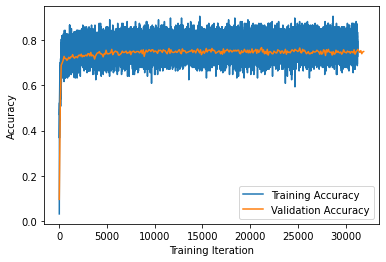

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()